In [ ]:
!pip install kaggle 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle

kaggle.json


In [ ]:
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

ref                                                      title                                     size  lastUpdated          downloadCount  voteCount  usabilityRating  
-------------------------------------------------------  ---------------------------------------  -----  -------------------  -------------  ---------  ---------------  
themrityunjaypathak/covid-cases-and-deaths-worldwide     Covid Cases and Deaths WorldWide           8KB  2023-02-01 12:22:51          10828        356  1.0              
naveenkumar20bps1137/walmart-sales-analysis              WALMART SALES ANALYSIS                   119KB  2023-03-03 18:02:11           1252         40  0.9411765        
datascientistanna/customers-dataset                      Shop Customer Data                        23KB  2023-02-07 18:42:21           9227        213  1.0              
ulrikthygepedersen/co2-emissions-by-country              CO2 Emissions                            114KB  2023-02-28 12:39:49            745         26

In [ ]:
!kaggle datasets download lonelywriter/flickr8k-data -p /content/sample_data/ --unzip
!kaggle datasets download lonelywriter/flickr8k-text -p /content/sample_data/ --unzip

100% 1.03G/1.04G [00:54<00:00, 20.6MB/s]
100% 1.04G/1.04G [00:54<00:00, 20.6MB/s]
 89% 2.00M/2.25M [00:01<00:00, 2.25MB/s]
100% 2.25M/2.25M [00:01<00:00, 2.16MB/s]


In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import pandas as pd
from time import time
import cv2
from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout,Lambda
from tensorflow.keras.layers import add
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img,img_to_array
%config InlineBackend.figure_format = 'retina'

In [ ]:
token_path = "/content/sample_data/Flickr8k.token.txt"
train_images_path = "/content/sample_data/Flickr_8k.trainImages.txt"
test_images_path = "/content/sample_data/Flickr_8k.testImages.txt"
images_path = "/content/sample_data/Flicker8k_Dataset/"
glove_path = "../input/glove6b/"

In [ ]:
doc = open(token_path,'r').read()
print(doc[:400])

1000268201_693b08cb0e.jpg#0	A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg#1	A girl going into a wooden building .
1000268201_693b08cb0e.jpg#2	A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg#3	A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg#4	A little girl in a pink dress going into a wood


In [ ]:
descriptions = dict()
for line in doc.split('\n'):
    tokens = line.split()
    if len(line) > 2:
        image_id = tokens[0].split('.')[0]
        image_desc = ' '.join(tokens[1:])
        image_desc = 'startseq ' + image_desc + ' endseq'
# #             print(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)

In [ ]:
len(descriptions.values())

8092

In [ ]:
descriptions['1000268201_693b08cb0e']

['startseq A child in a pink dress is climbing up a set of stairs in an entry way . endseq',
 'startseq A girl going into a wooden building . endseq',
 'startseq A little girl climbing into a wooden playhouse . endseq',
 'startseq A little girl climbing the stairs to her playhouse . endseq',
 'startseq A little girl in a pink dress going into a wooden cabin . endseq']

In [ ]:
# its time to clean the captions data by removing punctuations by using a table
table = str.maketrans('','',string.punctuation)
for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]
        desc_list[i] =  ' '.join(desc)

In [ ]:
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8830


In [ ]:
len(os.listdir(images_path))

8091

In [ ]:
missing_id = []
for id in descriptions.keys():
    if f"{id}.jpg" not  in os.listdir(images_path):
        missing_id.append(id)

In [ ]:
missing_id

['2258277193_586949ec62']

In [ ]:
del descriptions[missing_id[0]]

In [ ]:
min([len(x) for x in descriptions.values()])

5

In [ ]:
from keras.applications import ResNet50

incept_model = ResNet50(include_top=True)

102967424/102967424 [==============================] - 5s 0us/step


In [ ]:
from keras.models import Model
last = incept_model.layers[-2].output
extractor = Model(inputs = incept_model.input,outputs = last)
extractor.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [ ]:
def feature_extractor(img_id):
    img = cv2.imread(os.path.join(images_path,f"{img_id}.jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224,224))
    img = img.reshape(1,224,224,3)
    pred = extractor.predict(img).reshape(2048,)   
    return(pred)

In [ ]:
feature_extractor('1000268201_693b08cb0e').shape

1/1 [==============================] - 10s 10s/step


(2048,)

In [ ]:
from tqdm import tqdm
features = dict()
for key in tqdm(descriptions.keys(), total = len(descriptions.keys())):
    feature = feature_extractor(key)
    features[key] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 2/8091 [00:00<09:56, 13.56it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 4/8091 [00:00<10:02, 13.42it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 6/8091 [00:00<09:29, 14.21it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 8/8091 [00:00<09:36, 14.01it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 10/8091 [00:00<09:38, 13.98it/s]

1/1 [==============================] - 0s 29ms/step


  0%|          | 12/8091 [00:00<09:42, 13.87it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 14/8091 [00:01<09:34, 14.06it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 16/8091 [00:01<09:32, 14.12it/s]

1/1 [==============================] - 0s 25ms/step


  0%|          | 18/8091 [00:01<09:32, 14.09it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 20/8091 [00:01<09:28, 14.20it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 22/8091 [00:01<09:28, 14.20it/s]

1/1 [==============================] - 0s 24ms/step


  0%|          | 24/8091 [00:01<09:26, 14.24it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 26/8091 [00:01<09:38, 13.94it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 28/8091 [00:01<09:33, 14.05it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 30/8091 [00:02<09:43, 13.81it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 32/8091 [00:02<09:47, 13.73it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 34/8091 [00:02<09:47, 13.71it/s]

1/1 [==============================] - 0s 26ms/step


  0%|          | 36/8091 [00:02<09:41, 13.86it/s]

1/1 [==============================] - 0s 27ms/step


  0%|          | 38/8091 [00:02<09:49, 13.66it/s]

1/1 [==============================] - 0s 28ms/step


  0%|          | 40/8091 [00:02<09:41, 13.84it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 42/8091 [00:03<09:31, 14.08it/s]

1/1 [==============================] - 0s 35ms/step


  1%|          | 44/8091 [00:03<09:33, 14.04it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 46/8091 [00:03<09:42, 13.81it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 48/8091 [00:03<09:34, 13.99it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 50/8091 [00:03<09:33, 14.02it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 52/8091 [00:03<09:49, 13.63it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 54/8091 [00:03<09:42, 13.80it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 56/8091 [00:04<09:36, 13.93it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 58/8091 [00:04<09:38, 13.88it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 60/8091 [00:04<09:33, 13.99it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 62/8091 [00:04<09:21, 14.30it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 64/8091 [00:04<09:23, 14.26it/s]

1/1 [==============================] - 0s 34ms/step


  1%|          | 66/8091 [00:04<09:32, 14.02it/s]

1/1 [==============================] - 0s 26ms/step


  1%|          | 68/8091 [00:04<09:27, 14.13it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 70/8091 [00:04<09:16, 14.40it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 72/8091 [00:05<09:23, 14.23it/s]

1/1 [==============================] - 0s 24ms/step


  1%|          | 74/8091 [00:05<09:31, 14.04it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 76/8091 [00:05<09:28, 14.10it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 78/8091 [00:05<09:28, 14.10it/s]

1/1 [==============================] - 0s 28ms/step


  1%|          | 80/8091 [00:05<09:22, 14.25it/s]

1/1 [==============================] - 0s 25ms/step


  1%|          | 82/8091 [00:05<09:36, 13.89it/s]

1/1 [==============================] - 0s 27ms/step


  1%|          | 84/8091 [00:06<09:39, 13.83it/s]

1/1 [==============================] - 0s 29ms/step


  1%|          | 86/8091 [00:06<09:41, 13.77it/s]

1/1 [==============================] - 0s 36ms/step


  1%|          | 88/8091 [00:06<09:54, 13.46it/s]

1/1 [==============================] - 0s 39ms/step


  1%|          | 90/8091 [00:06<11:17, 11.81it/s]

1/1 [==============================] - 0s 46ms/step


  1%|          | 92/8091 [00:06<13:11, 10.10it/s]

1/1 [==============================] - 0s 67ms/step


  1%|          | 94/8091 [00:07<15:16,  8.72it/s]

1/1 [==============================] - 0s 55ms/step


  1%|          | 95/8091 [00:07<15:47,  8.44it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 96/8091 [00:07<15:29,  8.60it/s]

1/1 [==============================] - 0s 43ms/step


  1%|          | 97/8091 [00:07<15:30,  8.59it/s]

1/1 [==============================] - 0s 68ms/step


  1%|          | 98/8091 [00:07<16:47,  7.93it/s]

1/1 [==============================] - 0s 41ms/step


  1%|          | 99/8091 [00:07<16:25,  8.11it/s]

1/1 [==============================] - 0s 52ms/step


  1%|          | 100/8091 [00:07<16:48,  7.92it/s]

1/1 [==============================] - 0s 45ms/step


  1%|          | 101/8091 [00:07<16:51,  7.90it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 102/8091 [00:08<15:58,  8.33it/s]

1/1 [==============================] - 0s 44ms/step


  1%|▏         | 103/8091 [00:08<15:23,  8.65it/s]

1/1 [==============================] - 0s 40ms/step


  1%|▏         | 104/8091 [00:08<14:52,  8.95it/s]

1/1 [==============================] - 0s 38ms/step


  1%|▏         | 106/8091 [00:08<13:46,  9.66it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▏         | 107/8091 [00:08<14:53,  8.94it/s]

1/1 [==============================] - 0s 79ms/step


  1%|▏         | 108/8091 [00:08<16:49,  7.91it/s]

1/1 [==============================] - 0s 59ms/step


  1%|▏         | 109/8091 [00:08<17:59,  7.39it/s]

1/1 [==============================] - 0s 86ms/step


  1%|▏         | 110/8091 [00:09<19:42,  6.75it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▏         | 111/8091 [00:09<19:37,  6.78it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▏         | 112/8091 [00:09<20:49,  6.38it/s]

1/1 [==============================] - 0s 72ms/step


  1%|▏         | 113/8091 [00:09<21:20,  6.23it/s]

1/1 [==============================] - 0s 59ms/step


  1%|▏         | 114/8091 [00:09<20:26,  6.51it/s]

1/1 [==============================] - 0s 56ms/step


  1%|▏         | 115/8091 [00:09<19:15,  6.90it/s]

1/1 [==============================] - 0s 37ms/step


  1%|▏         | 116/8091 [00:09<17:43,  7.50it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 117/8091 [00:10<17:59,  7.39it/s]

1/1 [==============================] - 0s 41ms/step


  1%|▏         | 118/8091 [00:10<17:19,  7.67it/s]

1/1 [==============================] - 0s 43ms/step


  1%|▏         | 119/8091 [00:10<16:20,  8.13it/s]

1/1 [==============================] - 0s 53ms/step


  1%|▏         | 120/8091 [00:10<16:27,  8.07it/s]

1/1 [==============================] - 0s 46ms/step


  1%|▏         | 121/8091 [00:10<15:43,  8.44it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 123/8091 [00:10<12:55, 10.27it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 125/8091 [00:10<11:26, 11.60it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 127/8091 [00:11<11:06, 11.94it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 129/8091 [00:11<10:33, 12.56it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 131/8091 [00:11<10:22, 12.78it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 133/8091 [00:11<10:22, 12.78it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 135/8091 [00:11<10:02, 13.22it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 137/8091 [00:11<09:57, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 139/8091 [00:11<09:42, 13.64it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 141/8091 [00:12<09:38, 13.75it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 143/8091 [00:12<09:33, 13.86it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 145/8091 [00:12<09:36, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 147/8091 [00:12<09:36, 13.79it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 149/8091 [00:12<09:24, 14.07it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 151/8091 [00:12<09:25, 14.04it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 153/8091 [00:12<09:20, 14.17it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 155/8091 [00:13<09:26, 14.02it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 157/8091 [00:13<09:23, 14.07it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 159/8091 [00:13<09:29, 13.94it/s]

1/1 [==============================] - 0s 31ms/step


  2%|▏         | 161/8091 [00:13<09:32, 13.86it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 163/8091 [00:13<09:34, 13.80it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 165/8091 [00:13<09:32, 13.84it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 167/8091 [00:13<09:36, 13.73it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 169/8091 [00:14<09:36, 13.74it/s]

1/1 [==============================] - 0s 29ms/step


  2%|▏         | 171/8091 [00:14<09:49, 13.44it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 173/8091 [00:14<09:46, 13.49it/s]

1/1 [==============================] - 0s 30ms/step


  2%|▏         | 175/8091 [00:14<09:42, 13.59it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 177/8091 [00:14<09:30, 13.88it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 179/8091 [00:14<09:24, 14.01it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 181/8091 [00:14<09:28, 13.92it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 183/8091 [00:15<09:34, 13.76it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 185/8091 [00:15<09:44, 13.52it/s]

1/1 [==============================] - 0s 24ms/step


  2%|▏         | 187/8091 [00:15<09:41, 13.60it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 189/8091 [00:15<09:39, 13.63it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 191/8091 [00:15<09:33, 13.78it/s]

1/1 [==============================] - 0s 25ms/step


  2%|▏         | 193/8091 [00:15<09:28, 13.88it/s]

1/1 [==============================] - 0s 27ms/step


  2%|▏         | 195/8091 [00:15<09:22, 14.03it/s]

1/1 [==============================] - 0s 28ms/step


  2%|▏         | 197/8091 [00:16<09:30, 13.83it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 199/8091 [00:16<09:43, 13.52it/s]

1/1 [==============================] - 0s 26ms/step


  2%|▏         | 201/8091 [00:16<09:33, 13.77it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 203/8091 [00:16<09:32, 13.78it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 205/8091 [00:16<09:22, 14.02it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 207/8091 [00:16<09:18, 14.11it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 209/8091 [00:16<09:17, 14.15it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 211/8091 [00:17<09:38, 13.61it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 213/8091 [00:17<09:28, 13.86it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 215/8091 [00:17<09:26, 13.90it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 217/8091 [00:17<09:29, 13.83it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 219/8091 [00:17<09:34, 13.71it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 221/8091 [00:17<09:26, 13.88it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 223/8091 [00:17<09:31, 13.76it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 225/8091 [00:18<09:43, 13.47it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 227/8091 [00:18<09:52, 13.27it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 229/8091 [00:18<09:55, 13.21it/s]

1/1 [==============================] - 0s 33ms/step


  3%|▎         | 231/8091 [00:18<10:42, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 233/8091 [00:18<10:26, 12.53it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 235/8091 [00:18<10:14, 12.79it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 237/8091 [00:19<10:07, 12.93it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 239/8091 [00:19<10:08, 12.91it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 241/8091 [00:19<09:57, 13.13it/s]

1/1 [==============================] - 0s 31ms/step


  3%|▎         | 243/8091 [00:19<10:09, 12.87it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 245/8091 [00:19<09:53, 13.22it/s]

1/1 [==============================] - 0s 205ms/step


  3%|▎         | 247/8091 [00:20<16:52,  7.75it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 249/8091 [00:20<19:46,  6.61it/s]

1/1 [==============================] - 0s 39ms/step


  3%|▎         | 250/8091 [00:20<18:42,  6.99it/s]

1/1 [==============================] - 0s 44ms/step


  3%|▎         | 251/8091 [00:20<18:56,  6.90it/s]

1/1 [==============================] - 0s 106ms/step


  3%|▎         | 252/8091 [00:21<20:11,  6.47it/s]

1/1 [==============================] - 0s 166ms/step


  3%|▎         | 253/8091 [00:21<30:34,  4.27it/s]

1/1 [==============================] - 0s 89ms/step


  3%|▎         | 254/8091 [00:21<33:04,  3.95it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 255/8091 [00:21<28:00,  4.66it/s]

1/1 [==============================] - 0s 45ms/step


  3%|▎         | 256/8091 [00:22<24:05,  5.42it/s]

1/1 [==============================] - 0s 41ms/step


  3%|▎         | 257/8091 [00:22<21:22,  6.11it/s]

1/1 [==============================] - 0s 40ms/step


  3%|▎         | 258/8091 [00:22<20:08,  6.48it/s]

1/1 [==============================] - 0s 108ms/step


  3%|▎         | 259/8091 [00:22<21:26,  6.09it/s]

1/1 [==============================] - 0s 95ms/step


  3%|▎         | 260/8091 [00:22<29:05,  4.49it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 261/8091 [00:22<24:47,  5.27it/s]

1/1 [==============================] - 0s 28ms/step


  3%|▎         | 263/8091 [00:23<17:57,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


  3%|▎         | 265/8091 [00:23<14:44,  8.85it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 267/8091 [00:23<12:41, 10.28it/s]

1/1 [==============================] - 0s 27ms/step


  3%|▎         | 269/8091 [00:23<11:43, 11.12it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 271/8091 [00:23<10:53, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


  3%|▎         | 273/8091 [00:23<10:14, 12.72it/s]

1/1 [==============================] - 0s 26ms/step


  3%|▎         | 275/8091 [00:23<10:03, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 277/8091 [00:24<10:06, 12.89it/s]

1/1 [==============================] - 0s 34ms/step


  3%|▎         | 279/8091 [00:24<10:07, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 281/8091 [00:24<09:57, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


  3%|▎         | 283/8091 [00:24<09:40, 13.45it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▎         | 285/8091 [00:24<09:41, 13.43it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 287/8091 [00:24<09:38, 13.48it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 289/8091 [00:25<09:27, 13.74it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 291/8091 [00:25<09:23, 13.85it/s]

1/1 [==============================] - 0s 30ms/step


  4%|▎         | 293/8091 [00:25<09:43, 13.35it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▎         | 295/8091 [00:25<09:43, 13.35it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 297/8091 [00:25<09:38, 13.47it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▎         | 299/8091 [00:25<09:25, 13.78it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▎         | 301/8091 [00:25<09:33, 13.59it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▎         | 303/8091 [00:26<09:26, 13.76it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 305/8091 [00:26<09:41, 13.39it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 307/8091 [00:26<09:55, 13.08it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 309/8091 [00:26<09:50, 13.18it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 311/8091 [00:26<09:43, 13.34it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 313/8091 [00:26<09:42, 13.34it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 315/8091 [00:26<09:31, 13.61it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 317/8091 [00:27<09:29, 13.66it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 319/8091 [00:27<09:23, 13.80it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 321/8091 [00:27<09:27, 13.70it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 323/8091 [00:27<09:28, 13.67it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 325/8091 [00:27<09:41, 13.36it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 327/8091 [00:27<09:50, 13.15it/s]

1/1 [==============================] - 0s 27ms/step


  4%|▍         | 329/8091 [00:28<09:44, 13.28it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 331/8091 [00:28<09:47, 13.20it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 333/8091 [00:28<09:41, 13.33it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 335/8091 [00:28<09:44, 13.28it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 337/8091 [00:28<10:19, 12.52it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 339/8091 [00:28<10:10, 12.70it/s]

1/1 [==============================] - 0s 29ms/step


  4%|▍         | 341/8091 [00:28<10:08, 12.75it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 343/8091 [00:29<09:58, 12.94it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 345/8091 [00:29<10:06, 12.77it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 347/8091 [00:29<10:01, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 349/8091 [00:29<09:54, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 351/8091 [00:29<09:40, 13.33it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 353/8091 [00:29<09:47, 13.18it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 355/8091 [00:29<09:40, 13.32it/s]

1/1 [==============================] - 0s 26ms/step


  4%|▍         | 357/8091 [00:30<09:38, 13.38it/s]

1/1 [==============================] - 0s 28ms/step


  4%|▍         | 359/8091 [00:30<09:38, 13.37it/s]

1/1 [==============================] - 0s 24ms/step


  4%|▍         | 361/8091 [00:30<09:45, 13.21it/s]

1/1 [==============================] - 0s 25ms/step


  4%|▍         | 363/8091 [00:30<09:34, 13.44it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 365/8091 [00:30<09:26, 13.65it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 367/8091 [00:30<09:47, 13.15it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 369/8091 [00:31<09:40, 13.31it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 371/8091 [00:31<09:42, 13.25it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 373/8091 [00:31<09:41, 13.27it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 375/8091 [00:31<09:59, 12.87it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 377/8091 [00:31<09:53, 13.00it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▍         | 379/8091 [00:31<09:47, 13.12it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 381/8091 [00:31<09:40, 13.29it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▍         | 383/8091 [00:32<09:41, 13.26it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▍         | 385/8091 [00:32<09:50, 13.06it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▍         | 387/8091 [00:32<09:55, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▍         | 389/8091 [00:32<09:51, 13.01it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▍         | 391/8091 [00:32<10:40, 12.02it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 393/8091 [00:32<11:44, 10.92it/s]

1/1 [==============================] - 0s 48ms/step


  5%|▍         | 395/8091 [00:33<12:25, 10.32it/s]

1/1 [==============================] - 0s 49ms/step


  5%|▍         | 397/8091 [00:33<13:45,  9.32it/s]

1/1 [==============================] - 0s 39ms/step


  5%|▍         | 398/8091 [00:33<13:59,  9.17it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 399/8091 [00:33<13:51,  9.25it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 400/8091 [00:33<14:32,  8.82it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 401/8091 [00:33<15:23,  8.33it/s]

1/1 [==============================] - 0s 42ms/step


  5%|▍         | 402/8091 [00:34<16:26,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▍         | 403/8091 [00:34<15:38,  8.19it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▍         | 404/8091 [00:34<15:19,  8.36it/s]

1/1 [==============================] - 0s 40ms/step


  5%|▌         | 405/8091 [00:34<14:44,  8.69it/s]

1/1 [==============================] - 0s 47ms/step


  5%|▌         | 406/8091 [00:34<14:48,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


  5%|▌         | 407/8091 [00:34<14:43,  8.70it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 408/8091 [00:34<16:03,  7.97it/s]

1/1 [==============================] - 0s 41ms/step


  5%|▌         | 409/8091 [00:34<15:30,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 410/8091 [00:35<14:43,  8.69it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 412/8091 [00:35<12:38, 10.13it/s]

1/1 [==============================] - 0s 24ms/step


  5%|▌         | 414/8091 [00:35<11:18, 11.32it/s]

1/1 [==============================] - 0s 30ms/step


  5%|▌         | 416/8091 [00:35<10:34, 12.10it/s]

1/1 [==============================] - 0s 26ms/step


  5%|▌         | 418/8091 [00:35<10:13, 12.51it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 420/8091 [00:35<10:02, 12.74it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 422/8091 [00:35<09:52, 12.94it/s]

1/1 [==============================] - 0s 38ms/step


  5%|▌         | 424/8091 [00:36<10:26, 12.24it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 426/8091 [00:36<10:24, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 428/8091 [00:36<10:06, 12.63it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 430/8091 [00:36<10:02, 12.72it/s]

1/1 [==============================] - 0s 27ms/step


  5%|▌         | 432/8091 [00:36<10:00, 12.76it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 434/8091 [00:36<09:54, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


  5%|▌         | 436/8091 [00:37<09:41, 13.17it/s]

1/1 [==============================] - 0s 29ms/step


  5%|▌         | 438/8091 [00:37<13:37,  9.36it/s]

1/1 [==============================] - 0s 31ms/step


  5%|▌         | 440/8091 [00:37<12:35, 10.13it/s]

1/1 [==============================] - 0s 33ms/step


  5%|▌         | 442/8091 [00:37<11:54, 10.70it/s]

1/1 [==============================] - 0s 28ms/step


  5%|▌         | 444/8091 [00:37<11:26, 11.15it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 446/8091 [00:38<11:03, 11.52it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 448/8091 [00:38<11:00, 11.56it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 450/8091 [00:38<10:44, 11.86it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 452/8091 [00:38<11:14, 11.32it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 454/8091 [00:38<10:50, 11.74it/s]

1/1 [==============================] - 0s 31ms/step


  6%|▌         | 456/8091 [00:38<10:44, 11.85it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 458/8091 [00:39<10:40, 11.92it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 460/8091 [00:39<10:25, 12.20it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 462/8091 [00:39<10:12, 12.45it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 464/8091 [00:39<10:16, 12.38it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▌         | 466/8091 [00:39<10:14, 12.42it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 468/8091 [00:39<10:04, 12.60it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 470/8091 [00:39<09:54, 12.83it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 472/8091 [00:40<09:53, 12.84it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 474/8091 [00:40<09:57, 12.75it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 476/8091 [00:40<10:01, 12.66it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 478/8091 [00:40<09:50, 12.89it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 480/8091 [00:40<09:52, 12.84it/s]

1/1 [==============================] - 0s 30ms/step


  6%|▌         | 482/8091 [00:40<09:57, 12.74it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 484/8091 [00:41<09:46, 12.97it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 486/8091 [00:41<09:50, 12.89it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▌         | 488/8091 [00:41<09:37, 13.16it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 490/8091 [00:41<09:39, 13.12it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▌         | 492/8091 [00:41<09:40, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 494/8091 [00:41<09:34, 13.22it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 496/8091 [00:41<09:20, 13.56it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▌         | 498/8091 [00:42<09:45, 12.98it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 500/8091 [00:42<09:56, 12.72it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▌         | 502/8091 [00:42<09:50, 12.85it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▌         | 504/8091 [00:42<09:41, 13.04it/s]

1/1 [==============================] - 0s 25ms/step


  6%|▋         | 506/8091 [00:42<09:37, 13.13it/s]

1/1 [==============================] - 0s 26ms/step


  6%|▋         | 508/8091 [00:42<09:40, 13.06it/s]

1/1 [==============================] - 0s 32ms/step


  6%|▋         | 510/8091 [00:43<09:48, 12.88it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 512/8091 [00:43<09:40, 13.06it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 514/8091 [00:43<09:40, 13.06it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 516/8091 [00:43<09:35, 13.17it/s]

1/1 [==============================] - 0s 34ms/step


  6%|▋         | 518/8091 [00:43<10:36, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


  6%|▋         | 520/8091 [00:43<10:24, 12.13it/s]

1/1 [==============================] - 0s 29ms/step


  6%|▋         | 522/8091 [00:44<10:16, 12.28it/s]

1/1 [==============================] - 0s 28ms/step


  6%|▋         | 524/8091 [00:44<10:06, 12.47it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 526/8091 [00:44<10:26, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 528/8091 [00:44<11:02, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 530/8091 [00:44<10:27, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 532/8091 [00:44<10:17, 12.25it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 534/8091 [00:45<10:42, 11.76it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 536/8091 [00:45<12:38,  9.96it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 538/8091 [00:45<12:49,  9.82it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 540/8091 [00:45<12:58,  9.70it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 541/8091 [00:45<12:55,  9.74it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 542/8091 [00:45<13:08,  9.57it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 543/8091 [00:46<13:32,  9.29it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 544/8091 [00:46<14:06,  8.91it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 545/8091 [00:46<14:17,  8.80it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 546/8091 [00:46<14:02,  8.96it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 547/8091 [00:46<13:51,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 548/8091 [00:46<14:12,  8.85it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 550/8091 [00:46<13:57,  9.00it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 551/8091 [00:47<14:48,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 552/8091 [00:47<14:34,  8.63it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 553/8091 [00:47<14:22,  8.74it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 554/8091 [00:47<15:28,  8.12it/s]

1/1 [==============================] - 0s 28ms/step


  7%|▋         | 556/8091 [00:47<13:26,  9.34it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 558/8091 [00:47<11:58, 10.49it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 560/8091 [00:47<11:12, 11.19it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 562/8091 [00:48<11:18, 11.09it/s]

1/1 [==============================] - 0s 44ms/step


  7%|▋         | 564/8091 [00:48<12:24, 10.12it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 566/8091 [00:48<12:52,  9.74it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 567/8091 [00:48<14:15,  8.80it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 568/8091 [00:48<13:55,  9.00it/s]

1/1 [==============================] - 0s 49ms/step


  7%|▋         | 569/8091 [00:48<14:38,  8.57it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 570/8091 [00:49<14:24,  8.70it/s]

1/1 [==============================] - 0s 41ms/step


  7%|▋         | 571/8091 [00:49<14:01,  8.94it/s]

1/1 [==============================] - 0s 39ms/step


  7%|▋         | 572/8091 [00:49<14:16,  8.78it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 574/8091 [00:49<13:32,  9.25it/s]

1/1 [==============================] - 0s 37ms/step


  7%|▋         | 575/8091 [00:49<13:47,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


  7%|▋         | 576/8091 [00:49<13:48,  9.07it/s]

1/1 [==============================] - 0s 43ms/step


  7%|▋         | 577/8091 [00:49<14:52,  8.42it/s]

1/1 [==============================] - 0s 46ms/step


  7%|▋         | 578/8091 [00:49<14:41,  8.53it/s]

1/1 [==============================] - 0s 42ms/step


  7%|▋         | 579/8091 [00:50<15:06,  8.29it/s]

1/1 [==============================] - 0s 40ms/step


  7%|▋         | 580/8091 [00:50<14:41,  8.52it/s]

1/1 [==============================] - 0s 45ms/step


  7%|▋         | 581/8091 [00:50<15:55,  7.86it/s]

1/1 [==============================] - 0s 30ms/step


  7%|▋         | 583/8091 [00:50<13:27,  9.30it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 585/8091 [00:50<11:45, 10.64it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 587/8091 [00:50<10:52, 11.49it/s]

1/1 [==============================] - 0s 36ms/step


  7%|▋         | 589/8091 [00:50<11:21, 11.01it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 591/8091 [00:51<10:45, 11.62it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 593/8091 [00:51<10:28, 11.93it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 595/8091 [00:51<10:08, 12.31it/s]

1/1 [==============================] - 0s 26ms/step


  7%|▋         | 597/8091 [00:51<10:02, 12.43it/s]

1/1 [==============================] - 0s 25ms/step


  7%|▋         | 599/8091 [00:51<09:52, 12.65it/s]

1/1 [==============================] - 0s 27ms/step


  7%|▋         | 601/8091 [00:51<09:52, 12.65it/s]

1/1 [==============================] - 0s 24ms/step


  7%|▋         | 603/8091 [00:52<09:40, 12.90it/s]

1/1 [==============================] - 0s 29ms/step


  7%|▋         | 605/8091 [00:52<09:47, 12.74it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 607/8091 [00:52<09:44, 12.79it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 609/8091 [00:52<09:38, 12.93it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 611/8091 [00:52<09:31, 13.09it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 613/8091 [00:52<09:39, 12.90it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 615/8091 [00:52<09:42, 12.84it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 617/8091 [00:53<09:44, 12.78it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 619/8091 [00:53<10:04, 12.36it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 621/8091 [00:53<09:52, 12.62it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 623/8091 [00:53<10:28, 11.88it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 625/8091 [00:53<10:12, 12.19it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 627/8091 [00:53<10:39, 11.66it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 629/8091 [00:54<10:44, 11.58it/s]

1/1 [==============================] - 0s 34ms/step


  8%|▊         | 631/8091 [00:54<10:49, 11.49it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 633/8091 [00:54<10:37, 11.70it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 635/8091 [00:54<10:23, 11.96it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 637/8091 [00:54<10:02, 12.37it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 639/8091 [00:54<09:49, 12.64it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 641/8091 [00:55<09:52, 12.57it/s]

1/1 [==============================] - 0s 30ms/step


  8%|▊         | 643/8091 [00:55<09:50, 12.62it/s]

1/1 [==============================] - 0s 24ms/step


  8%|▊         | 645/8091 [00:55<09:39, 12.84it/s]

1/1 [==============================] - 0s 25ms/step


  8%|▊         | 647/8091 [00:55<09:40, 12.83it/s]

1/1 [==============================] - 0s 27ms/step


  8%|▊         | 649/8091 [00:55<09:39, 12.85it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 651/8091 [00:55<09:53, 12.54it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 653/8091 [00:56<09:46, 12.68it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 655/8091 [00:56<09:47, 12.66it/s]

1/1 [==============================] - 0s 31ms/step


  8%|▊         | 657/8091 [00:56<09:55, 12.48it/s]

1/1 [==============================] - 0s 29ms/step


  8%|▊         | 659/8091 [00:56<10:50, 11.43it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 661/8091 [00:56<10:28, 11.82it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 663/8091 [00:56<10:13, 12.10it/s]

1/1 [==============================] - 0s 32ms/step


  8%|▊         | 665/8091 [00:57<10:01, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


  8%|▊         | 667/8091 [00:57<09:47, 12.64it/s]

1/1 [==============================] - 0s 26ms/step


  8%|▊         | 669/8091 [00:57<09:42, 12.73it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 671/8091 [00:57<10:13, 12.09it/s]

1/1 [==============================] - 0s 41ms/step


  8%|▊         | 673/8091 [00:57<11:28, 10.77it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 675/8091 [00:58<13:16,  9.31it/s]

1/1 [==============================] - 0s 47ms/step


  8%|▊         | 676/8091 [00:58<14:26,  8.56it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 677/8091 [00:58<15:11,  8.13it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 678/8091 [00:58<15:05,  8.18it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 679/8091 [00:58<15:50,  7.80it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 680/8091 [00:58<15:27,  7.99it/s]

1/1 [==============================] - 0s 44ms/step


  8%|▊         | 681/8091 [00:58<15:20,  8.05it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 682/8091 [00:59<15:21,  8.04it/s]

1/1 [==============================] - 0s 46ms/step


  8%|▊         | 683/8091 [00:59<15:06,  8.17it/s]

1/1 [==============================] - 0s 38ms/step


  8%|▊         | 684/8091 [00:59<14:22,  8.58it/s]

1/1 [==============================] - 0s 40ms/step


  8%|▊         | 685/8091 [00:59<14:12,  8.69it/s]

1/1 [==============================] - 0s 43ms/step


  8%|▊         | 686/8091 [00:59<14:06,  8.75it/s]

1/1 [==============================] - 0s 39ms/step


  8%|▊         | 687/8091 [00:59<13:56,  8.86it/s]

1/1 [==============================] - 0s 41ms/step


  9%|▊         | 688/8091 [00:59<13:48,  8.94it/s]

1/1 [==============================] - 0s 46ms/step


  9%|▊         | 689/8091 [00:59<14:09,  8.71it/s]

1/1 [==============================] - 0s 40ms/step


  9%|▊         | 690/8091 [00:59<14:15,  8.65it/s]

1/1 [==============================] - 0s 42ms/step


  9%|▊         | 691/8091 [01:00<15:28,  7.97it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 693/8091 [01:00<12:35,  9.79it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 695/8091 [01:00<11:23, 10.82it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 697/8091 [01:00<10:42, 11.51it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 699/8091 [01:00<10:25, 11.83it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▊         | 701/8091 [01:00<10:00, 12.30it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▊         | 703/8091 [01:00<09:42, 12.69it/s]

1/1 [==============================] - 0s 37ms/step


  9%|▊         | 705/8091 [01:01<10:24, 11.83it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▊         | 707/8091 [01:01<09:59, 12.33it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 709/8091 [01:01<09:49, 12.53it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 711/8091 [01:01<09:45, 12.61it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 713/8091 [01:01<09:43, 12.63it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 715/8091 [01:01<09:29, 12.95it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 717/8091 [01:02<09:41, 12.69it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 719/8091 [01:02<09:58, 12.31it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 721/8091 [01:02<09:39, 12.73it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 723/8091 [01:02<09:54, 12.39it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 725/8091 [01:02<09:46, 12.57it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 727/8091 [01:02<09:42, 12.65it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 729/8091 [01:03<09:33, 12.84it/s]

1/1 [==============================] - 0s 33ms/step


  9%|▉         | 731/8091 [01:03<09:28, 12.94it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 733/8091 [01:03<10:13, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 735/8091 [01:03<10:46, 11.39it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 737/8091 [01:03<10:23, 11.79it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 739/8091 [01:03<10:26, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 741/8091 [01:04<10:10, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


  9%|▉         | 743/8091 [01:04<10:15, 11.93it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 745/8091 [01:04<10:37, 11.51it/s]

1/1 [==============================] - 0s 24ms/step


  9%|▉         | 747/8091 [01:04<10:10, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 749/8091 [01:04<10:09, 12.04it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 751/8091 [01:04<10:08, 12.07it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 753/8091 [01:05<09:50, 12.42it/s]

1/1 [==============================] - 0s 32ms/step


  9%|▉         | 755/8091 [01:05<09:39, 12.67it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 757/8091 [01:05<09:42, 12.58it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 759/8091 [01:05<09:41, 12.62it/s]

1/1 [==============================] - 0s 26ms/step


  9%|▉         | 761/8091 [01:05<09:24, 12.99it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 763/8091 [01:05<09:17, 13.15it/s]

1/1 [==============================] - 0s 27ms/step


  9%|▉         | 765/8091 [01:05<09:20, 13.06it/s]

1/1 [==============================] - 0s 25ms/step


  9%|▉         | 767/8091 [01:06<09:24, 12.96it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 769/8091 [01:06<09:31, 12.81it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 771/8091 [01:06<09:22, 13.02it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 773/8091 [01:06<09:24, 12.97it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 775/8091 [01:06<09:21, 13.02it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 777/8091 [01:06<09:32, 12.77it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 779/8091 [01:07<09:31, 12.80it/s]

1/1 [==============================] - 0s 29ms/step


 10%|▉         | 781/8091 [01:07<09:28, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 783/8091 [01:07<09:34, 12.72it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 785/8091 [01:07<09:49, 12.40it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 787/8091 [01:07<09:27, 12.87it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 789/8091 [01:07<09:21, 13.01it/s]

1/1 [==============================] - 0s 27ms/step


 10%|▉         | 791/8091 [01:08<09:30, 12.80it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 793/8091 [01:08<09:40, 12.58it/s]

1/1 [==============================] - 0s 28ms/step


 10%|▉         | 795/8091 [01:08<09:50, 12.35it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 797/8091 [01:08<09:50, 12.36it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 799/8091 [01:08<09:30, 12.77it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 801/8091 [01:08<09:21, 12.98it/s]

1/1 [==============================] - 0s 26ms/step


 10%|▉         | 803/8091 [01:08<09:36, 12.65it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 805/8091 [01:09<09:26, 12.86it/s]

1/1 [==============================] - 0s 25ms/step


 10%|▉         | 807/8091 [01:09<09:27, 12.83it/s]

1/1 [==============================] - 0s 24ms/step


 10%|▉         | 809/8091 [01:09<09:30, 12.77it/s]

1/1 [==============================] - 0s 31ms/step


 10%|█         | 811/8091 [01:09<09:47, 12.39it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 813/8091 [01:09<09:43, 12.48it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 815/8091 [01:09<09:26, 12.83it/s]

1/1 [==============================] - 0s 25ms/step


 10%|█         | 817/8091 [01:10<09:21, 12.95it/s]

1/1 [==============================] - 0s 46ms/step


 10%|█         | 819/8091 [01:10<10:29, 11.55it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 821/8091 [01:10<11:46, 10.29it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 823/8091 [01:10<12:07, 10.00it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 825/8091 [01:11<13:38,  8.88it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 826/8091 [01:11<13:39,  8.87it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 827/8091 [01:11<13:22,  9.05it/s]

1/1 [==============================] - 0s 44ms/step


 10%|█         | 828/8091 [01:11<13:45,  8.80it/s]

1/1 [==============================] - 0s 55ms/step


 10%|█         | 829/8091 [01:11<14:45,  8.20it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 830/8091 [01:11<14:51,  8.14it/s]

1/1 [==============================] - 0s 37ms/step


 10%|█         | 831/8091 [01:11<14:18,  8.46it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 832/8091 [01:11<15:15,  7.92it/s]

1/1 [==============================] - 0s 39ms/step


 10%|█         | 833/8091 [01:11<14:31,  8.33it/s]

1/1 [==============================] - 0s 43ms/step


 10%|█         | 834/8091 [01:12<14:33,  8.31it/s]

1/1 [==============================] - 0s 40ms/step


 10%|█         | 835/8091 [01:12<14:08,  8.55it/s]

1/1 [==============================] - 0s 42ms/step


 10%|█         | 836/8091 [01:12<14:20,  8.43it/s]

1/1 [==============================] - 0s 50ms/step


 10%|█         | 837/8091 [01:12<14:31,  8.33it/s]

1/1 [==============================] - 0s 41ms/step


 10%|█         | 838/8091 [01:12<14:30,  8.33it/s]

1/1 [==============================] - 0s 29ms/step


 10%|█         | 840/8091 [01:12<12:31,  9.64it/s]

1/1 [==============================] - 0s 24ms/step


 10%|█         | 842/8091 [01:12<10:54, 11.08it/s]

1/1 [==============================] - 0s 27ms/step


 10%|█         | 844/8091 [01:13<10:16, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 10%|█         | 846/8091 [01:13<09:59, 12.09it/s]

1/1 [==============================] - 0s 26ms/step


 10%|█         | 848/8091 [01:13<09:51, 12.24it/s]

1/1 [==============================] - 0s 30ms/step


 11%|█         | 850/8091 [01:13<09:49, 12.29it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 852/8091 [01:13<09:41, 12.44it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 854/8091 [01:13<09:24, 12.82it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 856/8091 [01:13<09:21, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 858/8091 [01:14<09:19, 12.92it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 860/8091 [01:14<09:18, 12.95it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 862/8091 [01:14<09:23, 12.82it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 864/8091 [01:14<09:14, 13.04it/s]

1/1 [==============================] - 0s 40ms/step


 11%|█         | 866/8091 [01:14<09:27, 12.73it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 868/8091 [01:14<09:24, 12.80it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 870/8091 [01:15<09:15, 13.00it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 872/8091 [01:15<09:10, 13.10it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 874/8091 [01:15<09:22, 12.83it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 876/8091 [01:15<09:20, 12.87it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 878/8091 [01:15<09:13, 13.04it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 880/8091 [01:15<09:12, 13.04it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 882/8091 [01:15<09:15, 12.98it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 884/8091 [01:16<09:24, 12.77it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 886/8091 [01:16<10:07, 11.85it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█         | 888/8091 [01:16<09:51, 12.17it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 890/8091 [01:16<09:40, 12.39it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 892/8091 [01:16<09:43, 12.35it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 894/8091 [01:16<09:46, 12.27it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 896/8091 [01:17<09:33, 12.55it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 898/8091 [01:17<09:30, 12.62it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█         | 900/8091 [01:17<09:33, 12.53it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█         | 902/8091 [01:17<09:37, 12.45it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 904/8091 [01:17<09:33, 12.52it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 906/8091 [01:17<09:26, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 908/8091 [01:18<09:12, 13.01it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█         | 910/8091 [01:18<09:28, 12.63it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 912/8091 [01:18<09:30, 12.58it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 914/8091 [01:18<09:22, 12.76it/s]

1/1 [==============================] - 0s 24ms/step


 11%|█▏        | 916/8091 [01:18<09:32, 12.52it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 918/8091 [01:18<09:30, 12.57it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 920/8091 [01:19<09:28, 12.61it/s]

1/1 [==============================] - 0s 31ms/step


 11%|█▏        | 922/8091 [01:19<09:19, 12.81it/s]

1/1 [==============================] - 0s 27ms/step


 11%|█▏        | 924/8091 [01:19<09:37, 12.41it/s]

1/1 [==============================] - 0s 26ms/step


 11%|█▏        | 926/8091 [01:19<09:30, 12.56it/s]

1/1 [==============================] - 0s 28ms/step


 11%|█▏        | 928/8091 [01:19<09:40, 12.34it/s]

1/1 [==============================] - 0s 25ms/step


 11%|█▏        | 930/8091 [01:19<09:31, 12.53it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 932/8091 [01:19<09:16, 12.86it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 934/8091 [01:20<09:18, 12.82it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 936/8091 [01:20<10:10, 11.71it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 938/8091 [01:20<10:40, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 940/8091 [01:20<10:24, 11.44it/s]

1/1 [==============================] - 0s 35ms/step


 12%|█▏        | 942/8091 [01:20<10:14, 11.63it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 944/8091 [01:21<10:00, 11.90it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 946/8091 [01:21<10:29, 11.34it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 948/8091 [01:21<10:57, 10.86it/s]

1/1 [==============================] - 0s 30ms/step


 12%|█▏        | 950/8091 [01:21<10:45, 11.07it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 952/8091 [01:21<10:49, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 954/8091 [01:21<10:37, 11.20it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 956/8091 [01:22<10:18, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 958/8091 [01:22<10:11, 11.66it/s]

1/1 [==============================] - 0s 28ms/step


 12%|█▏        | 960/8091 [01:22<10:21, 11.48it/s]

1/1 [==============================] - 0s 32ms/step


 12%|█▏        | 962/8091 [01:22<09:59, 11.89it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 964/8091 [01:22<11:19, 10.48it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 966/8091 [01:23<11:44, 10.11it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 968/8091 [01:23<12:02,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 970/8091 [01:23<12:14,  9.69it/s]

1/1 [==============================] - 0s 37ms/step


 12%|█▏        | 971/8091 [01:23<12:16,  9.66it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 972/8091 [01:23<12:27,  9.53it/s]

1/1 [==============================] - 0s 48ms/step


 12%|█▏        | 973/8091 [01:23<13:00,  9.12it/s]

1/1 [==============================] - 0s 40ms/step


 12%|█▏        | 974/8091 [01:23<13:16,  8.93it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 975/8091 [01:24<13:39,  8.68it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 976/8091 [01:24<13:26,  8.82it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 977/8091 [01:24<13:43,  8.64it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 978/8091 [01:24<13:37,  8.70it/s]

1/1 [==============================] - 0s 42ms/step


 12%|█▏        | 979/8091 [01:24<13:30,  8.77it/s]

1/1 [==============================] - 0s 38ms/step


 12%|█▏        | 980/8091 [01:24<13:24,  8.83it/s]

1/1 [==============================] - 0s 43ms/step


 12%|█▏        | 981/8091 [01:24<13:21,  8.88it/s]

1/1 [==============================] - 0s 54ms/step


 12%|█▏        | 982/8091 [01:24<13:46,  8.60it/s]

1/1 [==============================] - 0s 44ms/step


 12%|█▏        | 983/8091 [01:25<13:48,  8.58it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 984/8091 [01:25<14:03,  8.43it/s]

1/1 [==============================] - 0s 39ms/step


 12%|█▏        | 985/8091 [01:25<14:02,  8.43it/s]

1/1 [==============================] - 0s 45ms/step


 12%|█▏        | 986/8091 [01:25<14:03,  8.42it/s]

1/1 [==============================] - 0s 46ms/step


 12%|█▏        | 987/8091 [01:25<14:59,  7.90it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 989/8091 [01:25<12:15,  9.66it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 991/8091 [01:25<11:00, 10.74it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 993/8091 [01:25<10:12, 11.59it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 995/8091 [01:26<09:37, 12.29it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 997/8091 [01:26<09:36, 12.30it/s]

1/1 [==============================] - 0s 27ms/step


 12%|█▏        | 999/8091 [01:26<09:38, 12.26it/s]

1/1 [==============================] - 0s 29ms/step


 12%|█▏        | 1001/8091 [01:26<09:37, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 12%|█▏        | 1003/8091 [01:26<09:19, 12.67it/s]

1/1 [==============================] - 0s 24ms/step


 12%|█▏        | 1005/8091 [01:26<09:17, 12.70it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1007/8091 [01:27<09:17, 12.72it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1009/8091 [01:27<09:15, 12.76it/s]

1/1 [==============================] - 0s 25ms/step


 12%|█▏        | 1011/8091 [01:27<09:10, 12.87it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1013/8091 [01:27<09:09, 12.88it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1015/8091 [01:27<09:06, 12.96it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1017/8091 [01:27<09:37, 12.25it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1019/8091 [01:28<09:31, 12.38it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1021/8091 [01:28<09:31, 12.37it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1023/8091 [01:28<09:16, 12.69it/s]

1/1 [==============================] - 0s 30ms/step


 13%|█▎        | 1025/8091 [01:28<09:50, 11.97it/s]

1/1 [==============================] - 0s 29ms/step


 13%|█▎        | 1027/8091 [01:28<09:46, 12.04it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1029/8091 [01:28<09:50, 11.96it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1031/8091 [01:29<09:55, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1033/8091 [01:29<09:38, 12.20it/s]

1/1 [==============================] - 0s 46ms/step


 13%|█▎        | 1035/8091 [01:29<11:02, 10.66it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1037/8091 [01:29<12:28,  9.43it/s]

1/1 [==============================] - 0s 41ms/step


 13%|█▎        | 1038/8091 [01:29<12:39,  9.29it/s]

1/1 [==============================] - 0s 52ms/step


 13%|█▎        | 1039/8091 [01:29<13:02,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 1040/8091 [01:30<13:04,  8.99it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 1041/8091 [01:30<13:39,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 13%|█▎        | 1042/8091 [01:30<15:09,  7.75it/s]

1/1 [==============================] - 0s 45ms/step


 13%|█▎        | 1043/8091 [01:30<14:41,  8.00it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1044/8091 [01:30<14:12,  8.26it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 1046/8091 [01:30<13:40,  8.59it/s]

1/1 [==============================] - 0s 40ms/step


 13%|█▎        | 1047/8091 [01:30<13:19,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 1048/8091 [01:31<13:37,  8.61it/s]

1/1 [==============================] - 0s 37ms/step


 13%|█▎        | 1049/8091 [01:31<13:19,  8.80it/s]

1/1 [==============================] - 0s 39ms/step


 13%|█▎        | 1050/8091 [01:31<13:24,  8.75it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 1051/8091 [01:31<13:34,  8.65it/s]

1/1 [==============================] - 0s 43ms/step


 13%|█▎        | 1052/8091 [01:31<15:01,  7.81it/s]

1/1 [==============================] - 0s 38ms/step


 13%|█▎        | 1053/8091 [01:31<14:40,  7.99it/s]

1/1 [==============================] - 0s 44ms/step


 13%|█▎        | 1054/8091 [01:31<14:28,  8.10it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1055/8091 [01:31<13:59,  8.38it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1057/8091 [01:32<12:17,  9.53it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1059/8091 [01:32<11:01, 10.63it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1061/8091 [01:32<10:44, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1063/8091 [01:32<10:31, 11.13it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1065/8091 [01:32<10:16, 11.39it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1067/8091 [01:32<09:55, 11.79it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1069/8091 [01:33<09:51, 11.86it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1071/8091 [01:33<09:47, 11.94it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1073/8091 [01:33<09:37, 12.15it/s]

1/1 [==============================] - 0s 33ms/step


 13%|█▎        | 1075/8091 [01:33<09:40, 12.08it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1077/8091 [01:33<09:30, 12.30it/s]

1/1 [==============================] - 0s 36ms/step


 13%|█▎        | 1079/8091 [01:33<09:36, 12.16it/s]

1/1 [==============================] - 0s 25ms/step


 13%|█▎        | 1081/8091 [01:34<09:27, 12.36it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1083/8091 [01:34<09:43, 12.02it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1085/8091 [01:34<09:31, 12.25it/s]

1/1 [==============================] - 0s 27ms/step


 13%|█▎        | 1087/8091 [01:34<09:34, 12.20it/s]

1/1 [==============================] - 0s 26ms/step


 13%|█▎        | 1089/8091 [01:34<09:35, 12.17it/s]

1/1 [==============================] - 0s 28ms/step


 13%|█▎        | 1091/8091 [01:34<09:34, 12.18it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1093/8091 [01:35<09:44, 11.97it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▎        | 1095/8091 [01:35<09:41, 12.03it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▎        | 1097/8091 [01:35<09:44, 11.97it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▎        | 1099/8091 [01:35<09:45, 11.93it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 1101/8091 [01:35<10:43, 10.86it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 1103/8091 [01:35<11:39,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▎        | 1105/8091 [01:36<12:39,  9.19it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 1106/8091 [01:36<12:59,  8.96it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▎        | 1107/8091 [01:36<12:46,  9.11it/s]

1/1 [==============================] - 0s 41ms/step


 14%|█▎        | 1108/8091 [01:36<12:41,  9.17it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▎        | 1109/8091 [01:36<12:30,  9.30it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▎        | 1110/8091 [01:36<13:01,  8.93it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▎        | 1111/8091 [01:36<13:27,  8.65it/s]

1/1 [==============================] - 0s 50ms/step


 14%|█▎        | 1112/8091 [01:37<14:00,  8.30it/s]

1/1 [==============================] - 0s 51ms/step


 14%|█▍        | 1113/8091 [01:37<14:07,  8.23it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1114/8091 [01:37<14:54,  7.80it/s]

1/1 [==============================] - 0s 40ms/step


 14%|█▍        | 1115/8091 [01:37<14:29,  8.02it/s]

1/1 [==============================] - 0s 39ms/step


 14%|█▍        | 1116/8091 [01:37<14:12,  8.18it/s]

1/1 [==============================] - 0s 38ms/step


 14%|█▍        | 1117/8091 [01:37<13:41,  8.49it/s]

1/1 [==============================] - 0s 45ms/step


 14%|█▍        | 1118/8091 [01:37<13:31,  8.59it/s]

1/1 [==============================] - 0s 44ms/step


 14%|█▍        | 1119/8091 [01:37<15:28,  7.51it/s]

1/1 [==============================] - 0s 42ms/step


 14%|█▍        | 1120/8091 [01:38<14:27,  8.04it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 1121/8091 [01:38<15:15,  7.62it/s]

1/1 [==============================] - 0s 43ms/step


 14%|█▍        | 1122/8091 [01:38<15:55,  7.29it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1123/8091 [01:38<15:21,  7.56it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1125/8091 [01:38<12:37,  9.19it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1127/8091 [01:38<11:29, 10.10it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1129/8091 [01:38<10:44, 10.81it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1131/8091 [01:39<10:04, 11.52it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1133/8091 [01:39<09:55, 11.68it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1135/8091 [01:39<09:46, 11.87it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1137/8091 [01:39<09:39, 12.00it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1139/8091 [01:39<09:31, 12.17it/s]

1/1 [==============================] - 0s 24ms/step


 14%|█▍        | 1141/8091 [01:39<09:22, 12.35it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1143/8091 [01:40<09:35, 12.06it/s]

1/1 [==============================] - 0s 35ms/step


 14%|█▍        | 1145/8091 [01:40<09:29, 12.19it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1147/8091 [01:40<09:29, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1149/8091 [01:40<09:29, 12.18it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1151/8091 [01:40<09:25, 12.26it/s]

1/1 [==============================] - 0s 31ms/step


 14%|█▍        | 1153/8091 [01:40<09:27, 12.22it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1155/8091 [01:41<09:29, 12.17it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1157/8091 [01:41<09:23, 12.31it/s]

1/1 [==============================] - 0s 29ms/step


 14%|█▍        | 1159/8091 [01:41<09:34, 12.07it/s]

1/1 [==============================] - 0s 28ms/step


 14%|█▍        | 1161/8091 [01:41<09:49, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1163/8091 [01:41<09:36, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1165/8091 [01:41<09:31, 12.11it/s]

1/1 [==============================] - 0s 32ms/step


 14%|█▍        | 1167/8091 [01:42<09:52, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 14%|█▍        | 1169/8091 [01:42<09:48, 11.77it/s]

1/1 [==============================] - 0s 27ms/step


 14%|█▍        | 1171/8091 [01:42<09:43, 11.86it/s]

1/1 [==============================] - 0s 25ms/step


 14%|█▍        | 1173/8091 [01:42<09:40, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1175/8091 [01:42<09:25, 12.22it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1177/8091 [01:42<09:20, 12.35it/s]

1/1 [==============================] - 0s 28ms/step


 15%|█▍        | 1179/8091 [01:43<09:26, 12.19it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1181/8091 [01:43<09:18, 12.37it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1183/8091 [01:43<10:08, 11.35it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1185/8091 [01:43<10:26, 11.02it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1187/8091 [01:43<10:09, 11.33it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1189/8091 [01:43<09:49, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1191/8091 [01:44<09:35, 12.00it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1193/8091 [01:44<09:30, 12.10it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1195/8091 [01:44<09:25, 12.20it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1197/8091 [01:44<09:42, 11.85it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1199/8091 [01:44<09:27, 12.15it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1201/8091 [01:44<09:22, 12.26it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1203/8091 [01:45<09:15, 12.41it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▍        | 1205/8091 [01:45<09:25, 12.19it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▍        | 1207/8091 [01:45<09:23, 12.21it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1209/8091 [01:45<09:18, 12.33it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1211/8091 [01:45<09:09, 12.52it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▍        | 1213/8091 [01:45<09:11, 12.48it/s]

1/1 [==============================] - 0s 25ms/step


 15%|█▌        | 1215/8091 [01:46<09:19, 12.29it/s]

1/1 [==============================] - 0s 38ms/step


 15%|█▌        | 1217/8091 [01:46<09:28, 12.09it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1219/8091 [01:46<09:37, 11.90it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1221/8091 [01:46<09:49, 11.65it/s]

1/1 [==============================] - 0s 32ms/step


 15%|█▌        | 1223/8091 [01:46<09:54, 11.55it/s]

1/1 [==============================] - 0s 26ms/step


 15%|█▌        | 1225/8091 [01:46<09:37, 11.89it/s]

1/1 [==============================] - 0s 27ms/step


 15%|█▌        | 1227/8091 [01:47<09:32, 11.99it/s]

1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 1229/8091 [01:47<09:20, 12.25it/s]

1/1 [==============================] - 0s 31ms/step


 15%|█▌        | 1231/8091 [01:47<09:13, 12.39it/s]

1/1 [==============================] - 0s 29ms/step


 15%|█▌        | 1233/8091 [01:47<13:41,  8.35it/s]

1/1 [==============================] - 0s 33ms/step


 15%|█▌        | 1235/8091 [01:47<12:29,  9.15it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1237/8091 [01:48<11:45,  9.71it/s]

1/1 [==============================] - 0s 30ms/step


 15%|█▌        | 1239/8091 [01:48<11:14, 10.16it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 1241/8091 [01:48<12:15,  9.31it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▌        | 1243/8091 [01:48<12:56,  8.82it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 1244/8091 [01:48<13:20,  8.55it/s]

1/1 [==============================] - 0s 55ms/step


 15%|█▌        | 1245/8091 [01:49<14:02,  8.13it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 1246/8091 [01:49<14:14,  8.01it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1247/8091 [01:49<14:33,  7.84it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 1248/8091 [01:49<14:47,  7.71it/s]

1/1 [==============================] - 0s 46ms/step


 15%|█▌        | 1249/8091 [01:49<14:50,  7.68it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 1250/8091 [01:49<14:51,  7.67it/s]

1/1 [==============================] - 0s 45ms/step


 15%|█▌        | 1251/8091 [01:49<14:10,  8.04it/s]

1/1 [==============================] - 0s 48ms/step


 15%|█▌        | 1252/8091 [01:50<13:45,  8.29it/s]

1/1 [==============================] - 0s 44ms/step


 15%|█▌        | 1253/8091 [01:50<14:04,  8.10it/s]

1/1 [==============================] - 0s 42ms/step


 15%|█▌        | 1254/8091 [01:50<13:49,  8.24it/s]

1/1 [==============================] - 0s 46ms/step


 16%|█▌        | 1255/8091 [01:50<13:43,  8.30it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 1256/8091 [01:50<13:24,  8.50it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1257/8091 [01:50<13:38,  8.35it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█▌        | 1258/8091 [01:50<14:24,  7.90it/s]

1/1 [==============================] - 0s 54ms/step


 16%|█▌        | 1259/8091 [01:50<16:09,  7.05it/s]

1/1 [==============================] - 0s 50ms/step


 16%|█▌        | 1260/8091 [01:51<15:46,  7.22it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1262/8091 [01:51<13:20,  8.54it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1264/8091 [01:51<11:47,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


 16%|█▌        | 1265/8091 [01:51<11:46,  9.67it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1267/8091 [01:51<11:00, 10.34it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1269/8091 [01:51<10:55, 10.40it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1271/8091 [01:52<10:32, 10.79it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1273/8091 [01:52<10:11, 11.15it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1275/8091 [01:52<10:35, 10.72it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1277/8091 [01:52<10:41, 10.61it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1279/8091 [01:52<10:27, 10.85it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1281/8091 [01:52<10:15, 11.06it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1283/8091 [01:53<10:06, 11.22it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1285/8091 [01:53<10:21, 10.95it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1287/8091 [01:53<10:57, 10.34it/s]

1/1 [==============================] - 0s 29ms/step


 16%|█▌        | 1289/8091 [01:53<10:31, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 16%|█▌        | 1291/8091 [01:53<10:18, 11.00it/s]

1/1 [==============================] - 0s 30ms/step


 16%|█▌        | 1293/8091 [01:54<10:28, 10.82it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1295/8091 [01:54<10:17, 11.01it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1297/8091 [01:54<09:55, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1299/8091 [01:54<09:54, 11.43it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1301/8091 [01:54<09:47, 11.55it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1303/8091 [01:54<10:25, 10.86it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1305/8091 [01:55<10:11, 11.09it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1307/8091 [01:55<09:50, 11.48it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▌        | 1309/8091 [01:55<09:45, 11.59it/s]

1/1 [==============================] - 0s 32ms/step


 16%|█▌        | 1311/8091 [01:55<10:00, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▌        | 1313/8091 [01:55<09:54, 11.40it/s]

1/1 [==============================] - 0s 28ms/step


 16%|█▋        | 1315/8091 [01:55<09:43, 11.62it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1317/8091 [01:56<10:21, 10.91it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1319/8091 [01:56<10:38, 10.60it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1321/8091 [01:56<10:20, 10.90it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1323/8091 [01:56<10:10, 11.08it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1325/8091 [01:56<09:53, 11.39it/s]

1/1 [==============================] - 0s 26ms/step


 16%|█▋        | 1327/8091 [01:57<09:54, 11.37it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1329/8091 [01:57<09:53, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1331/8091 [01:57<09:49, 11.46it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1333/8091 [01:57<09:44, 11.57it/s]

1/1 [==============================] - 0s 27ms/step


 16%|█▋        | 1335/8091 [01:57<09:45, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1337/8091 [01:57<09:59, 11.26it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1339/8091 [01:58<09:59, 11.26it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1341/8091 [01:58<09:49, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1343/8091 [01:58<09:38, 11.67it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1345/8091 [01:58<09:27, 11.88it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1347/8091 [01:58<09:39, 11.65it/s]

1/1 [==============================] - 0s 30ms/step


 17%|█▋        | 1349/8091 [01:58<09:44, 11.53it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1351/8091 [01:59<09:51, 11.39it/s]

1/1 [==============================] - 0s 31ms/step


 17%|█▋        | 1353/8091 [01:59<09:54, 11.33it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1355/8091 [01:59<09:44, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1357/8091 [01:59<09:41, 11.58it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1359/8091 [01:59<09:45, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1361/8091 [02:00<09:44, 11.51it/s]

1/1 [==============================] - 0s 29ms/step


 17%|█▋        | 1363/8091 [02:00<09:40, 11.59it/s]

1/1 [==============================] - 0s 28ms/step


 17%|█▋        | 1365/8091 [02:00<09:37, 11.65it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1367/8091 [02:00<09:35, 11.68it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1369/8091 [02:00<09:22, 11.96it/s]

1/1 [==============================] - 0s 27ms/step


 17%|█▋        | 1371/8091 [02:00<09:31, 11.76it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1373/8091 [02:01<09:18, 12.02it/s]

1/1 [==============================] - 0s 51ms/step


 17%|█▋        | 1375/8091 [02:01<10:56, 10.24it/s]

1/1 [==============================] - 0s 48ms/step


 17%|█▋        | 1377/8091 [02:01<12:07,  9.23it/s]

1/1 [==============================] - 0s 39ms/step


 17%|█▋        | 1378/8091 [02:01<12:51,  8.70it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1379/8091 [02:01<12:46,  8.76it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 1380/8091 [02:01<13:03,  8.56it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 1381/8091 [02:02<13:17,  8.41it/s]

1/1 [==============================] - 0s 49ms/step


 17%|█▋        | 1382/8091 [02:02<13:38,  8.20it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1383/8091 [02:02<14:40,  7.62it/s]

1/1 [==============================] - 0s 42ms/step


 17%|█▋        | 1384/8091 [02:02<14:11,  7.87it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1385/8091 [02:02<13:21,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


 17%|█▋        | 1386/8091 [02:02<12:46,  8.74it/s]

1/1 [==============================] - 0s 56ms/step


 17%|█▋        | 1387/8091 [02:02<13:01,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


 17%|█▋        | 1388/8091 [02:02<12:52,  8.67it/s]

1/1 [==============================] - 0s 40ms/step


 17%|█▋        | 1389/8091 [02:03<12:38,  8.83it/s]

1/1 [==============================] - 0s 44ms/step


 17%|█▋        | 1391/8091 [02:03<12:36,  8.85it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1392/8091 [02:03<12:29,  8.94it/s]

1/1 [==============================] - 0s 50ms/step


 17%|█▋        | 1393/8091 [02:03<13:19,  8.38it/s]

1/1 [==============================] - 0s 41ms/step


 17%|█▋        | 1394/8091 [02:03<13:09,  8.48it/s]

1/1 [==============================] - 0s 47ms/step


 17%|█▋        | 1395/8091 [02:03<13:39,  8.17it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1397/8091 [02:03<11:40,  9.55it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1399/8091 [02:04<10:32, 10.58it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1401/8091 [02:04<10:09, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1403/8091 [02:04<10:01, 11.12it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1405/8091 [02:04<09:37, 11.59it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1407/8091 [02:04<09:17, 12.00it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1409/8091 [02:04<09:14, 12.05it/s]

1/1 [==============================] - 0s 25ms/step


 17%|█▋        | 1411/8091 [02:05<09:16, 11.99it/s]

1/1 [==============================] - 0s 26ms/step


 17%|█▋        | 1413/8091 [02:05<09:03, 12.28it/s]

1/1 [==============================] - 0s 24ms/step


 17%|█▋        | 1415/8091 [02:05<09:01, 12.32it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1417/8091 [02:05<09:06, 12.22it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1419/8091 [02:05<09:00, 12.35it/s]

1/1 [==============================] - 0s 33ms/step


 18%|█▊        | 1421/8091 [02:05<09:05, 12.22it/s]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 1423/8091 [02:06<08:55, 12.46it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1425/8091 [02:06<08:46, 12.67it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1427/8091 [02:06<08:59, 12.35it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1429/8091 [02:06<08:54, 12.46it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1431/8091 [02:06<08:53, 12.48it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1433/8091 [02:06<09:01, 12.28it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1435/8091 [02:06<09:00, 12.31it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1437/8091 [02:07<09:03, 12.25it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1439/8091 [02:07<09:05, 12.18it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1441/8091 [02:07<09:03, 12.23it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1443/8091 [02:07<09:04, 12.22it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1445/8091 [02:07<08:58, 12.33it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1447/8091 [02:07<09:04, 12.20it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1449/8091 [02:08<09:13, 12.01it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1451/8091 [02:08<09:06, 12.16it/s]

1/1 [==============================] - 0s 31ms/step


 18%|█▊        | 1453/8091 [02:08<09:12, 12.02it/s]

1/1 [==============================] - 0s 27ms/step


 18%|█▊        | 1455/8091 [02:08<09:47, 11.29it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1457/8091 [02:08<09:27, 11.68it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1459/8091 [02:09<09:27, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1461/8091 [02:09<09:20, 11.84it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1463/8091 [02:09<09:23, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1465/8091 [02:09<09:18, 11.86it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1467/8091 [02:09<09:04, 12.15it/s]

1/1 [==============================] - 0s 24ms/step


 18%|█▊        | 1469/8091 [02:09<09:02, 12.20it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1471/8091 [02:10<09:14, 11.94it/s]

1/1 [==============================] - 0s 28ms/step


 18%|█▊        | 1473/8091 [02:10<09:18, 11.84it/s]

1/1 [==============================] - 0s 30ms/step


 18%|█▊        | 1475/8091 [02:10<09:18, 11.84it/s]

1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 1477/8091 [02:10<09:17, 11.87it/s]

1/1 [==============================] - 0s 25ms/step


 18%|█▊        | 1479/8091 [02:10<09:03, 12.16it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1481/8091 [02:10<09:50, 11.20it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1483/8091 [02:11<11:06,  9.91it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 1485/8091 [02:11<11:24,  9.65it/s]

1/1 [==============================] - 0s 55ms/step


 18%|█▊        | 1486/8091 [02:11<11:43,  9.39it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1487/8091 [02:11<11:49,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1488/8091 [02:11<11:39,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 18%|█▊        | 1490/8091 [02:11<11:19,  9.71it/s]

1/1 [==============================] - 0s 51ms/step


 18%|█▊        | 1492/8091 [02:12<11:30,  9.55it/s]

1/1 [==============================] - 0s 45ms/step


 18%|█▊        | 1493/8091 [02:12<11:40,  9.42it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 1494/8091 [02:12<12:30,  8.79it/s]

1/1 [==============================] - 0s 41ms/step


 18%|█▊        | 1495/8091 [02:12<13:01,  8.43it/s]

1/1 [==============================] - 0s 42ms/step


 18%|█▊        | 1496/8091 [02:12<13:15,  8.29it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▊        | 1497/8091 [02:12<13:45,  7.99it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 1498/8091 [02:12<14:06,  7.79it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 1499/8091 [02:12<13:42,  8.01it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▊        | 1500/8091 [02:13<14:01,  7.83it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 1501/8091 [02:13<13:46,  7.98it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▊        | 1502/8091 [02:13<13:39,  8.04it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▊        | 1503/8091 [02:13<13:26,  8.17it/s]

1/1 [==============================] - 0s 57ms/step


 19%|█▊        | 1504/8091 [02:13<15:02,  7.30it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▊        | 1505/8091 [02:13<14:16,  7.69it/s]

1/1 [==============================] - 0s 40ms/step


 19%|█▊        | 1506/8091 [02:13<13:57,  7.87it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▊        | 1507/8091 [02:14<13:28,  8.14it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▊        | 1508/8091 [02:14<13:49,  7.94it/s]

1/1 [==============================] - 0s 56ms/step


 19%|█▊        | 1509/8091 [02:14<13:57,  7.86it/s]

1/1 [==============================] - 0s 52ms/step


 19%|█▊        | 1510/8091 [02:14<14:01,  7.82it/s]

1/1 [==============================] - 0s 50ms/step


 19%|█▊        | 1511/8091 [02:14<14:09,  7.74it/s]

1/1 [==============================] - 0s 54ms/step


 19%|█▊        | 1512/8091 [02:14<14:09,  7.74it/s]

1/1 [==============================] - 0s 49ms/step


 19%|█▊        | 1513/8091 [02:14<13:55,  7.87it/s]

1/1 [==============================] - 0s 41ms/step


 19%|█▊        | 1514/8091 [02:14<13:03,  8.39it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▊        | 1515/8091 [02:14<12:40,  8.64it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▊        | 1516/8091 [02:15<14:00,  7.83it/s]

1/1 [==============================] - 0s 46ms/step


 19%|█▊        | 1517/8091 [02:15<14:41,  7.46it/s]

1/1 [==============================] - 0s 55ms/step


 19%|█▉        | 1518/8091 [02:15<15:57,  6.86it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 1519/8091 [02:15<14:58,  7.32it/s]

1/1 [==============================] - 0s 37ms/step


 19%|█▉        | 1520/8091 [02:15<13:58,  7.84it/s]

1/1 [==============================] - 0s 48ms/step


 19%|█▉        | 1521/8091 [02:15<13:58,  7.84it/s]

1/1 [==============================] - 0s 66ms/step


 19%|█▉        | 1522/8091 [02:15<14:24,  7.59it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 1523/8091 [02:16<14:10,  7.72it/s]

1/1 [==============================] - 0s 51ms/step


 19%|█▉        | 1524/8091 [02:16<13:38,  8.02it/s]

1/1 [==============================] - 0s 53ms/step


 19%|█▉        | 1525/8091 [02:16<14:15,  7.68it/s]

1/1 [==============================] - 0s 47ms/step


 19%|█▉        | 1526/8091 [02:16<14:24,  7.60it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 1527/8091 [02:16<14:58,  7.31it/s]

1/1 [==============================] - 0s 42ms/step


 19%|█▉        | 1528/8091 [02:16<14:13,  7.69it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1530/8091 [02:16<11:52,  9.20it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1532/8091 [02:17<10:37, 10.28it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1534/8091 [02:17<09:56, 10.99it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1536/8091 [02:17<10:03, 10.86it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1538/8091 [02:17<09:50, 11.10it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1540/8091 [02:17<09:30, 11.47it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1542/8091 [02:17<09:59, 10.92it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1544/8091 [02:18<09:34, 11.40it/s]

1/1 [==============================] - 0s 29ms/step


 19%|█▉        | 1546/8091 [02:18<10:01, 10.88it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1548/8091 [02:18<09:51, 11.06it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1550/8091 [02:18<09:35, 11.36it/s]

1/1 [==============================] - 0s 27ms/step


 19%|█▉        | 1552/8091 [02:18<09:17, 11.72it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1554/8091 [02:18<09:16, 11.75it/s]

1/1 [==============================] - 0s 36ms/step


 19%|█▉        | 1556/8091 [02:19<09:26, 11.54it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1558/8091 [02:19<09:22, 11.62it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1560/8091 [02:19<09:37, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1562/8091 [02:19<09:38, 11.29it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1564/8091 [02:19<09:24, 11.57it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1566/8091 [02:20<09:08, 11.89it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1568/8091 [02:20<09:02, 12.03it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1570/8091 [02:20<08:54, 12.19it/s]

1/1 [==============================] - 0s 25ms/step


 19%|█▉        | 1572/8091 [02:20<09:10, 11.84it/s]

1/1 [==============================] - 0s 24ms/step


 19%|█▉        | 1574/8091 [02:20<08:59, 12.07it/s]

1/1 [==============================] - 0s 26ms/step


 19%|█▉        | 1576/8091 [02:20<08:52, 12.23it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1578/8091 [02:20<08:50, 12.28it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1580/8091 [02:21<09:14, 11.75it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1582/8091 [02:21<09:10, 11.83it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1584/8091 [02:21<09:32, 11.36it/s]

1/1 [==============================] - 0s 32ms/step


 20%|█▉        | 1586/8091 [02:21<09:21, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1588/8091 [02:21<09:25, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1590/8091 [02:22<09:22, 11.56it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1592/8091 [02:22<09:22, 11.55it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1594/8091 [02:22<09:13, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1596/8091 [02:22<09:36, 11.26it/s]

1/1 [==============================] - 0s 28ms/step


 20%|█▉        | 1598/8091 [02:22<09:40, 11.18it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1600/8091 [02:22<09:20, 11.57it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1602/8091 [02:23<09:12, 11.74it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1604/8091 [02:23<09:15, 11.68it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1606/8091 [02:23<09:14, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1608/8091 [02:23<09:19, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1610/8091 [02:23<09:15, 11.67it/s]

1/1 [==============================] - 0s 26ms/step


 20%|█▉        | 1612/8091 [02:23<09:20, 11.55it/s]

1/1 [==============================] - 0s 25ms/step


 20%|█▉        | 1614/8091 [02:24<09:07, 11.84it/s]

1/1 [==============================] - 0s 27ms/step


 20%|█▉        | 1616/8091 [02:24<09:14, 11.67it/s]

1/1 [==============================] - 0s 31ms/step


 20%|█▉        | 1618/8091 [02:24<09:18, 11.60it/s]

1/1 [==============================] - 0s 28ms/step


 20%|██        | 1620/8091 [02:24<09:30, 11.35it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1622/8091 [02:24<09:29, 11.36it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1624/8091 [02:24<09:16, 11.63it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1626/8091 [02:25<09:24, 11.45it/s]

1/1 [==============================] - 0s 29ms/step


 20%|██        | 1628/8091 [02:25<09:14, 11.65it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1630/8091 [02:25<09:12, 11.69it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1632/8091 [02:25<09:19, 11.53it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1634/8091 [02:25<09:13, 11.67it/s]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 1636/8091 [02:26<09:10, 11.73it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1638/8091 [02:26<09:06, 11.80it/s]

1/1 [==============================] - 0s 27ms/step


 20%|██        | 1640/8091 [02:26<09:21, 11.49it/s]

1/1 [==============================] - 0s 25ms/step


 20%|██        | 1642/8091 [02:26<09:25, 11.40it/s]

1/1 [==============================] - 0s 26ms/step


 20%|██        | 1644/8091 [02:26<09:32, 11.27it/s]

1/1 [==============================] - 0s 36ms/step


 20%|██        | 1646/8091 [02:26<10:34, 10.15it/s]

1/1 [==============================] - 0s 41ms/step


 20%|██        | 1648/8091 [02:27<10:43, 10.02it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1650/8091 [02:27<11:14,  9.56it/s]

1/1 [==============================] - 0s 40ms/step


 20%|██        | 1651/8091 [02:27<11:18,  9.49it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 1652/8091 [02:27<11:52,  9.04it/s]

1/1 [==============================] - 0s 38ms/step


 20%|██        | 1653/8091 [02:27<11:41,  9.17it/s]

1/1 [==============================] - 0s 52ms/step


 20%|██        | 1654/8091 [02:27<12:25,  8.64it/s]

1/1 [==============================] - 0s 42ms/step


 20%|██        | 1656/8091 [02:28<11:49,  9.06it/s]

1/1 [==============================] - 0s 37ms/step


 20%|██        | 1658/8091 [02:28<11:11,  9.58it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 1659/8091 [02:28<11:31,  9.30it/s]

1/1 [==============================] - 0s 39ms/step


 21%|██        | 1660/8091 [02:28<11:34,  9.26it/s]

1/1 [==============================] - 0s 49ms/step


 21%|██        | 1661/8091 [02:28<11:58,  8.95it/s]

1/1 [==============================] - 0s 46ms/step


 21%|██        | 1662/8091 [02:28<12:28,  8.59it/s]

1/1 [==============================] - 0s 40ms/step


 21%|██        | 1663/8091 [02:28<12:39,  8.46it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1664/8091 [02:29<13:08,  8.15it/s]

1/1 [==============================] - 0s 54ms/step


 21%|██        | 1665/8091 [02:29<13:30,  7.93it/s]

1/1 [==============================] - 0s 53ms/step


 21%|██        | 1666/8091 [02:29<14:49,  7.22it/s]

1/1 [==============================] - 0s 44ms/step


 21%|██        | 1667/8091 [02:29<15:34,  6.87it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 1668/8091 [02:29<14:34,  7.35it/s]

1/1 [==============================] - 0s 48ms/step


 21%|██        | 1669/8091 [02:29<14:53,  7.19it/s]

1/1 [==============================] - 0s 41ms/step


 21%|██        | 1670/8091 [02:29<14:03,  7.61it/s]

1/1 [==============================] - 0s 47ms/step


 21%|██        | 1671/8091 [02:30<15:25,  6.94it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1673/8091 [02:30<12:04,  8.86it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1675/8091 [02:30<10:47,  9.90it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1677/8091 [02:30<09:59, 10.70it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1679/8091 [02:30<09:41, 11.03it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1681/8091 [02:30<09:31, 11.22it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██        | 1683/8091 [02:31<09:12, 11.59it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1685/8091 [02:31<09:00, 11.85it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1687/8091 [02:31<09:11, 11.61it/s]

1/1 [==============================] - 0s 33ms/step


 21%|██        | 1689/8091 [02:31<09:17, 11.49it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1691/8091 [02:31<09:10, 11.63it/s]

1/1 [==============================] - 0s 30ms/step


 21%|██        | 1693/8091 [02:31<09:08, 11.67it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1695/8091 [02:32<09:01, 11.81it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██        | 1697/8091 [02:32<09:08, 11.65it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1699/8091 [02:32<08:53, 11.99it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1701/8091 [02:32<08:54, 11.96it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1703/8091 [02:32<08:52, 12.00it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1705/8091 [02:32<08:55, 11.92it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1707/8091 [02:33<09:02, 11.76it/s]

1/1 [==============================] - 0s 35ms/step


 21%|██        | 1709/8091 [02:33<09:11, 11.58it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1711/8091 [02:33<08:59, 11.83it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██        | 1713/8091 [02:33<09:03, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██        | 1715/8091 [02:33<09:07, 11.65it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██        | 1717/8091 [02:33<09:10, 11.58it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██        | 1719/8091 [02:34<09:03, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 21%|██▏       | 1721/8091 [02:34<08:58, 11.83it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 1723/8091 [02:34<09:03, 11.71it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 1725/8091 [02:34<09:33, 11.09it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 1727/8091 [02:34<09:06, 11.64it/s]

1/1 [==============================] - 0s 25ms/step


 21%|██▏       | 1729/8091 [02:34<09:10, 11.56it/s]

1/1 [==============================] - 0s 24ms/step


 21%|██▏       | 1731/8091 [02:35<09:04, 11.67it/s]

1/1 [==============================] - 0s 28ms/step


 21%|██▏       | 1733/8091 [02:35<09:00, 11.76it/s]

1/1 [==============================] - 0s 29ms/step


 21%|██▏       | 1735/8091 [02:35<09:06, 11.63it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1737/8091 [02:35<09:34, 11.06it/s]

1/1 [==============================] - 0s 27ms/step


 21%|██▏       | 1739/8091 [02:35<09:23, 11.28it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1741/8091 [02:36<09:28, 11.16it/s]

1/1 [==============================] - 0s 30ms/step


 22%|██▏       | 1743/8091 [02:36<09:32, 11.09it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1745/8091 [02:36<09:38, 10.98it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1747/8091 [02:36<09:16, 11.40it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1749/8091 [02:36<09:09, 11.55it/s]

1/1 [==============================] - 0s 29ms/step


 22%|██▏       | 1751/8091 [02:36<09:17, 11.37it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1753/8091 [02:37<09:12, 11.47it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1755/8091 [02:37<09:15, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1757/8091 [02:37<09:40, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1759/8091 [02:37<09:35, 11.01it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1761/8091 [02:37<09:24, 11.22it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1763/8091 [02:37<09:13, 11.43it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1765/8091 [02:38<09:14, 11.41it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1767/8091 [02:38<09:10, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 22%|██▏       | 1769/8091 [02:38<09:09, 11.51it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1771/8091 [02:38<09:05, 11.59it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1773/8091 [02:38<08:59, 11.72it/s]

1/1 [==============================] - 0s 24ms/step


 22%|██▏       | 1775/8091 [02:38<08:49, 11.92it/s]

1/1 [==============================] - 0s 25ms/step


 22%|██▏       | 1777/8091 [02:39<08:49, 11.93it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1779/8091 [02:39<08:45, 12.01it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1781/8091 [02:39<08:46, 11.99it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1783/8091 [02:39<09:19, 11.28it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1785/8091 [02:39<09:06, 11.54it/s]

1/1 [==============================] - 0s 27ms/step


 22%|██▏       | 1787/8091 [02:40<09:23, 11.18it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1789/8091 [02:40<10:05, 10.41it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 1791/8091 [02:40<11:11,  9.38it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1792/8091 [02:40<11:33,  9.09it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 1793/8091 [02:40<11:50,  8.86it/s]

1/1 [==============================] - 0s 54ms/step


 22%|██▏       | 1794/8091 [02:40<12:12,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 22%|██▏       | 1795/8091 [02:41<12:33,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 1796/8091 [02:41<12:30,  8.39it/s]

1/1 [==============================] - 0s 60ms/step


 22%|██▏       | 1797/8091 [02:41<12:54,  8.13it/s]

1/1 [==============================] - 0s 37ms/step


 22%|██▏       | 1798/8091 [02:41<12:53,  8.13it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1799/8091 [02:41<12:37,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1800/8091 [02:41<12:22,  8.48it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1801/8091 [02:41<11:50,  8.85it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1803/8091 [02:41<11:34,  9.06it/s]

1/1 [==============================] - 0s 50ms/step


 22%|██▏       | 1804/8091 [02:42<11:39,  8.99it/s]

1/1 [==============================] - 0s 38ms/step


 22%|██▏       | 1805/8091 [02:42<11:49,  8.86it/s]

1/1 [==============================] - 0s 44ms/step


 22%|██▏       | 1806/8091 [02:42<11:40,  8.97it/s]

1/1 [==============================] - 0s 41ms/step


 22%|██▏       | 1807/8091 [02:42<11:20,  9.23it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1808/8091 [02:42<11:11,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 22%|██▏       | 1810/8091 [02:42<10:46,  9.72it/s]

1/1 [==============================] - 0s 42ms/step


 22%|██▏       | 1812/8091 [02:42<11:00,  9.50it/s]

1/1 [==============================] - 0s 66ms/step


 22%|██▏       | 1813/8091 [02:43<12:07,  8.63it/s]

1/1 [==============================] - 0s 56ms/step


 22%|██▏       | 1814/8091 [02:43<12:42,  8.23it/s]

1/1 [==============================] - 0s 57ms/step


 22%|██▏       | 1815/8091 [02:43<12:54,  8.11it/s]

1/1 [==============================] - 0s 49ms/step


 22%|██▏       | 1816/8091 [02:43<13:36,  7.69it/s]

1/1 [==============================] - 0s 34ms/step


 22%|██▏       | 1817/8091 [02:43<13:11,  7.93it/s]

1/1 [==============================] - 0s 26ms/step


 22%|██▏       | 1819/8091 [02:43<11:20,  9.21it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1821/8091 [02:43<10:32,  9.92it/s]

1/1 [==============================] - 0s 31ms/step


 23%|██▎       | 1823/8091 [02:44<09:59, 10.46it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1825/8091 [02:44<09:37, 10.84it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1827/8091 [02:44<09:22, 11.13it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1829/8091 [02:44<09:13, 11.31it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1831/8091 [02:44<09:11, 11.36it/s]

1/1 [==============================] - 0s 32ms/step


 23%|██▎       | 1833/8091 [02:44<09:10, 11.37it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1835/8091 [02:45<08:47, 11.87it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1837/8091 [02:45<08:50, 11.80it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1839/8091 [02:45<08:51, 11.76it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1841/8091 [02:45<08:52, 11.73it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1843/8091 [02:45<08:47, 11.86it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1845/8091 [02:45<08:51, 11.76it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1847/8091 [02:46<08:52, 11.73it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1849/8091 [02:46<09:04, 11.46it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1851/8091 [02:46<08:54, 11.66it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1853/8091 [02:46<08:52, 11.72it/s]

1/1 [==============================] - 0s 24ms/step


 23%|██▎       | 1855/8091 [02:46<08:49, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1857/8091 [02:47<09:00, 11.52it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1859/8091 [02:47<08:51, 11.72it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1861/8091 [02:47<08:56, 11.62it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1863/8091 [02:47<08:51, 11.72it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1865/8091 [02:47<08:57, 11.58it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1867/8091 [02:47<08:58, 11.57it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1869/8091 [02:48<08:50, 11.74it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1871/8091 [02:48<08:48, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1873/8091 [02:48<09:33, 10.84it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1875/8091 [02:48<09:31, 10.88it/s]

1/1 [==============================] - 0s 30ms/step


 23%|██▎       | 1877/8091 [02:48<09:11, 11.27it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1879/8091 [02:48<09:06, 11.37it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1881/8091 [02:49<09:02, 11.44it/s]

1/1 [==============================] - 0s 27ms/step


 23%|██▎       | 1883/8091 [02:49<09:06, 11.36it/s]

1/1 [==============================] - 0s 29ms/step


 23%|██▎       | 1885/8091 [02:49<09:19, 11.09it/s]

1/1 [==============================] - 0s 25ms/step


 23%|██▎       | 1887/8091 [02:49<09:11, 11.24it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1889/8091 [02:49<09:07, 11.32it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1891/8091 [02:50<09:04, 11.38it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1893/8091 [02:50<08:59, 11.49it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1895/8091 [02:50<09:08, 11.30it/s]

1/1 [==============================] - 0s 28ms/step


 23%|██▎       | 1897/8091 [02:50<09:15, 11.14it/s]

1/1 [==============================] - 0s 26ms/step


 23%|██▎       | 1899/8091 [02:50<09:01, 11.43it/s]

1/1 [==============================] - 0s 36ms/step


 23%|██▎       | 1901/8091 [02:50<09:48, 10.51it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 1903/8091 [02:51<09:21, 11.02it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 1905/8091 [02:51<09:12, 11.20it/s]

1/1 [==============================] - 0s 24ms/step


 24%|██▎       | 1907/8091 [02:51<09:05, 11.34it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▎       | 1909/8091 [02:51<08:57, 11.51it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▎       | 1911/8091 [02:51<09:01, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 1913/8091 [02:51<08:56, 11.51it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▎       | 1915/8091 [02:52<08:51, 11.62it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▎       | 1917/8091 [02:52<10:02, 10.25it/s]

1/1 [==============================] - 0s 44ms/step


 24%|██▎       | 1919/8091 [02:52<11:03,  9.31it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▎       | 1920/8091 [02:52<11:04,  9.28it/s]

1/1 [==============================] - 0s 52ms/step


 24%|██▎       | 1921/8091 [02:52<12:22,  8.30it/s]

1/1 [==============================] - 0s 38ms/step


 24%|██▍       | 1922/8091 [02:53<12:26,  8.26it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 1923/8091 [02:53<12:42,  8.09it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 1924/8091 [02:53<12:48,  8.03it/s]

1/1 [==============================] - 0s 49ms/step


 24%|██▍       | 1925/8091 [02:53<12:38,  8.13it/s]

1/1 [==============================] - 0s 48ms/step


 24%|██▍       | 1926/8091 [02:53<12:54,  7.96it/s]

1/1 [==============================] - 0s 65ms/step


 24%|██▍       | 1927/8091 [02:53<13:28,  7.62it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 1928/8091 [02:53<14:20,  7.16it/s]

1/1 [==============================] - 0s 50ms/step


 24%|██▍       | 1929/8091 [02:53<14:06,  7.28it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 1930/8091 [02:54<14:17,  7.18it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 1931/8091 [02:54<14:05,  7.28it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 1932/8091 [02:54<14:20,  7.16it/s]

1/1 [==============================] - 0s 63ms/step


 24%|██▍       | 1933/8091 [02:54<14:29,  7.08it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██▍       | 1934/8091 [02:54<15:08,  6.78it/s]

1/1 [==============================] - 0s 43ms/step


 24%|██▍       | 1935/8091 [02:54<14:22,  7.14it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 1936/8091 [02:54<14:19,  7.16it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 1937/8091 [02:55<14:16,  7.19it/s]

1/1 [==============================] - 0s 45ms/step


 24%|██▍       | 1938/8091 [02:55<13:39,  7.51it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1939/8091 [02:55<14:03,  7.30it/s]

1/1 [==============================] - 0s 89ms/step


 24%|██▍       | 1940/8091 [02:55<14:46,  6.94it/s]

1/1 [==============================] - 0s 66ms/step


 24%|██▍       | 1941/8091 [02:55<15:10,  6.75it/s]

1/1 [==============================] - 0s 60ms/step


 24%|██▍       | 1942/8091 [02:55<15:02,  6.81it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 1943/8091 [02:55<14:23,  7.12it/s]

1/1 [==============================] - 0s 59ms/step


 24%|██▍       | 1944/8091 [02:56<14:08,  7.24it/s]

1/1 [==============================] - 0s 60ms/step


 24%|██▍       | 1945/8091 [02:56<14:05,  7.27it/s]

1/1 [==============================] - 0s 39ms/step


 24%|██▍       | 1946/8091 [02:56<13:29,  7.59it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██▍       | 1947/8091 [02:56<13:22,  7.66it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▍       | 1948/8091 [02:56<13:39,  7.50it/s]

1/1 [==============================] - 0s 57ms/step


 24%|██▍       | 1949/8091 [02:56<14:04,  7.27it/s]

1/1 [==============================] - 0s 66ms/step


 24%|██▍       | 1950/8091 [02:56<14:26,  7.09it/s]

1/1 [==============================] - 0s 58ms/step


 24%|██▍       | 1951/8091 [02:57<14:05,  7.27it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1952/8091 [02:57<13:15,  7.71it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▍       | 1953/8091 [02:57<13:53,  7.36it/s]

1/1 [==============================] - 0s 54ms/step


 24%|██▍       | 1954/8091 [02:57<13:51,  7.38it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██▍       | 1955/8091 [02:57<14:36,  7.00it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1956/8091 [02:57<14:35,  7.01it/s]

1/1 [==============================] - 0s 46ms/step


 24%|██▍       | 1957/8091 [02:57<13:27,  7.60it/s]

1/1 [==============================] - 0s 42ms/step


 24%|██▍       | 1958/8091 [02:57<12:49,  7.97it/s]

1/1 [==============================] - 0s 53ms/step


 24%|██▍       | 1959/8091 [02:58<12:53,  7.93it/s]

1/1 [==============================] - 0s 40ms/step


 24%|██▍       | 1960/8091 [02:58<12:44,  8.02it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1962/8091 [02:58<10:59,  9.29it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1964/8091 [02:58<11:02,  9.25it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1966/8091 [02:58<10:12,  9.99it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1968/8091 [02:58<09:48, 10.41it/s]

1/1 [==============================] - 0s 27ms/step


 24%|██▍       | 1970/8091 [02:59<09:31, 10.70it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1972/8091 [02:59<09:07, 11.18it/s]

1/1 [==============================] - 0s 29ms/step


 24%|██▍       | 1974/8091 [02:59<09:10, 11.11it/s]

1/1 [==============================] - 0s 30ms/step


 24%|██▍       | 1976/8091 [02:59<09:14, 11.03it/s]

1/1 [==============================] - 0s 28ms/step


 24%|██▍       | 1978/8091 [02:59<09:14, 11.02it/s]

1/1 [==============================] - 0s 25ms/step


 24%|██▍       | 1980/8091 [03:00<09:03, 11.25it/s]

1/1 [==============================] - 0s 26ms/step


 24%|██▍       | 1982/8091 [03:00<09:04, 11.22it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1984/8091 [03:00<08:57, 11.37it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 1986/8091 [03:00<08:54, 11.41it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 1988/8091 [03:00<08:53, 11.44it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 1990/8091 [03:00<09:01, 11.26it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1992/8091 [03:01<09:14, 10.99it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▍       | 1994/8091 [03:01<09:01, 11.25it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 1996/8091 [03:01<08:57, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 1998/8091 [03:01<08:56, 11.35it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2000/8091 [03:01<08:54, 11.40it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 2002/8091 [03:01<09:02, 11.23it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▍       | 2004/8091 [03:02<09:11, 11.05it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 2006/8091 [03:02<09:00, 11.26it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 2008/8091 [03:02<09:05, 11.15it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 2010/8091 [03:02<08:58, 11.29it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 2012/8091 [03:02<09:49, 10.31it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▍       | 2014/8091 [03:03<09:45, 10.38it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▍       | 2016/8091 [03:03<09:21, 10.83it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▍       | 2018/8091 [03:03<09:30, 10.65it/s]

1/1 [==============================] - 0s 28ms/step


 25%|██▍       | 2020/8091 [03:03<09:24, 10.76it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▍       | 2022/8091 [03:03<09:10, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


 25%|██▌       | 2024/8091 [03:04<09:22, 10.78it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 2026/8091 [03:04<09:19, 10.84it/s]

1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 2028/8091 [03:04<09:13, 10.96it/s]

1/1 [==============================] - 0s 29ms/step


 25%|██▌       | 2030/8091 [03:04<09:05, 11.12it/s]

1/1 [==============================] - 0s 25ms/step


 25%|██▌       | 2032/8091 [03:04<08:51, 11.39it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 2034/8091 [03:04<08:51, 11.40it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2036/8091 [03:05<12:57,  7.78it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 2037/8091 [03:05<12:30,  8.06it/s]

1/1 [==============================] - 0s 33ms/step


 25%|██▌       | 2038/8091 [03:05<12:03,  8.37it/s]

1/1 [==============================] - 0s 43ms/step


 25%|██▌       | 2039/8091 [03:05<12:30,  8.06it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 2041/8091 [03:05<11:04,  9.11it/s]

1/1 [==============================] - 0s 41ms/step


 25%|██▌       | 2042/8091 [03:05<11:04,  9.10it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2043/8091 [03:06<10:54,  9.24it/s]

1/1 [==============================] - 0s 34ms/step


 25%|██▌       | 2044/8091 [03:06<10:53,  9.25it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2046/8091 [03:06<10:26,  9.64it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2048/8091 [03:06<10:07,  9.95it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2050/8091 [03:06<09:46, 10.30it/s]

1/1 [==============================] - 0s 42ms/step


 25%|██▌       | 2052/8091 [03:06<09:46, 10.30it/s]

1/1 [==============================] - 0s 32ms/step


 25%|██▌       | 2054/8091 [03:07<09:53, 10.17it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2056/8091 [03:07<09:45, 10.30it/s]

1/1 [==============================] - 0s 35ms/step


 25%|██▌       | 2058/8091 [03:07<09:41, 10.38it/s]

1/1 [==============================] - 0s 31ms/step


 25%|██▌       | 2060/8091 [03:07<09:33, 10.52it/s]

1/1 [==============================] - 0s 30ms/step


 25%|██▌       | 2062/8091 [03:07<09:37, 10.45it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 2064/8091 [03:08<10:37,  9.46it/s]

1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 2065/8091 [03:08<11:01,  9.10it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 2066/8091 [03:08<12:11,  8.23it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██▌       | 2067/8091 [03:08<12:09,  8.25it/s]

1/1 [==============================] - 0s 58ms/step


 26%|██▌       | 2068/8091 [03:08<12:42,  7.90it/s]

1/1 [==============================] - 0s 51ms/step


 26%|██▌       | 2069/8091 [03:08<12:48,  7.84it/s]

1/1 [==============================] - 0s 53ms/step


 26%|██▌       | 2070/8091 [03:08<12:38,  7.94it/s]

1/1 [==============================] - 0s 43ms/step


 26%|██▌       | 2071/8091 [03:09<12:23,  8.10it/s]

1/1 [==============================] - 0s 55ms/step


 26%|██▌       | 2072/8091 [03:09<12:26,  8.07it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 2073/8091 [03:09<12:03,  8.32it/s]

1/1 [==============================] - 0s 59ms/step


 26%|██▌       | 2074/8091 [03:09<12:13,  8.20it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 2075/8091 [03:09<12:41,  7.90it/s]

1/1 [==============================] - 0s 71ms/step


 26%|██▌       | 2076/8091 [03:09<13:37,  7.36it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 2077/8091 [03:09<13:46,  7.28it/s]

1/1 [==============================] - 0s 54ms/step


 26%|██▌       | 2078/8091 [03:10<13:38,  7.35it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 2079/8091 [03:10<13:38,  7.34it/s]

1/1 [==============================] - 0s 46ms/step


 26%|██▌       | 2080/8091 [03:10<13:07,  7.63it/s]

1/1 [==============================] - 0s 65ms/step


 26%|██▌       | 2081/8091 [03:10<13:45,  7.28it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 2082/8091 [03:10<13:52,  7.22it/s]

1/1 [==============================] - 0s 71ms/step


 26%|██▌       | 2083/8091 [03:10<14:34,  6.87it/s]

1/1 [==============================] - 0s 71ms/step


 26%|██▌       | 2084/8091 [03:10<15:48,  6.33it/s]

1/1 [==============================] - 0s 60ms/step


 26%|██▌       | 2085/8091 [03:11<16:13,  6.17it/s]

1/1 [==============================] - 0s 41ms/step


 26%|██▌       | 2086/8091 [03:11<14:53,  6.72it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 2087/8091 [03:11<15:32,  6.44it/s]

1/1 [==============================] - 0s 32ms/step


 26%|██▌       | 2088/8091 [03:11<13:53,  7.20it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2089/8091 [03:11<12:44,  7.85it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2090/8091 [03:11<11:55,  8.39it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 2092/8091 [03:11<10:36,  9.43it/s]

1/1 [==============================] - 0s 34ms/step


 26%|██▌       | 2093/8091 [03:11<10:28,  9.54it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▌       | 2095/8091 [03:12<10:20,  9.66it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2096/8091 [03:12<10:18,  9.70it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2097/8091 [03:12<10:24,  9.59it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2099/8091 [03:12<09:58, 10.01it/s]

1/1 [==============================] - 0s 37ms/step


 26%|██▌       | 2101/8091 [03:12<10:08,  9.85it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2102/8091 [03:12<10:13,  9.75it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2104/8091 [03:13<09:44, 10.25it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2106/8091 [03:13<09:43, 10.26it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2108/8091 [03:13<09:27, 10.54it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▌       | 2110/8091 [03:13<09:21, 10.65it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2112/8091 [03:13<09:15, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2114/8091 [03:13<09:19, 10.69it/s]

1/1 [==============================] - 0s 31ms/step


 26%|██▌       | 2116/8091 [03:14<09:30, 10.48it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▌       | 2118/8091 [03:14<09:36, 10.36it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▌       | 2120/8091 [03:14<09:15, 10.76it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▌       | 2122/8091 [03:14<08:59, 11.06it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 2124/8091 [03:14<09:36, 10.35it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 2126/8091 [03:15<09:18, 10.68it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 2128/8091 [03:15<09:15, 10.74it/s]

1/1 [==============================] - 0s 28ms/step


 26%|██▋       | 2130/8091 [03:15<09:12, 10.79it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 2132/8091 [03:15<09:10, 10.82it/s]

1/1 [==============================] - 0s 30ms/step


 26%|██▋       | 2134/8091 [03:15<09:13, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 2136/8091 [03:16<09:06, 10.89it/s]

1/1 [==============================] - 0s 33ms/step


 26%|██▋       | 2138/8091 [03:16<09:01, 11.00it/s]

1/1 [==============================] - 0s 29ms/step


 26%|██▋       | 2140/8091 [03:16<08:52, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 26%|██▋       | 2142/8091 [03:16<09:04, 10.93it/s]

1/1 [==============================] - 0s 26ms/step


 26%|██▋       | 2144/8091 [03:16<08:48, 11.25it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 2146/8091 [03:16<08:46, 11.29it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2148/8091 [03:17<08:50, 11.20it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 2150/8091 [03:17<09:00, 10.98it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 2152/8091 [03:17<08:58, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 2154/8091 [03:17<08:53, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 2156/8091 [03:17<08:54, 11.10it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 2158/8091 [03:17<08:45, 11.29it/s]

1/1 [==============================] - 0s 29ms/step


 27%|██▋       | 2160/8091 [03:18<08:51, 11.15it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2162/8091 [03:18<08:57, 11.03it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2164/8091 [03:18<08:56, 11.04it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2166/8091 [03:18<08:45, 11.28it/s]

1/1 [==============================] - 0s 28ms/step


 27%|██▋       | 2168/8091 [03:18<08:43, 11.31it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2170/8091 [03:19<08:43, 11.31it/s]

1/1 [==============================] - 0s 25ms/step


 27%|██▋       | 2172/8091 [03:19<08:47, 11.22it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2174/8091 [03:19<08:37, 11.43it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 2176/8091 [03:19<08:34, 11.50it/s]

1/1 [==============================] - 0s 30ms/step


 27%|██▋       | 2178/8091 [03:19<08:45, 11.24it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2180/8091 [03:19<08:33, 11.51it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2182/8091 [03:20<08:31, 11.55it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2184/8091 [03:20<08:22, 11.76it/s]

1/1 [==============================] - 0s 27ms/step


 27%|██▋       | 2186/8091 [03:20<08:36, 11.42it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2188/8091 [03:20<08:33, 11.48it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2190/8091 [03:20<08:26, 11.65it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2192/8091 [03:20<08:28, 11.60it/s]

1/1 [==============================] - 0s 24ms/step


 27%|██▋       | 2194/8091 [03:21<08:14, 11.93it/s]

1/1 [==============================] - 0s 26ms/step


 27%|██▋       | 2196/8091 [03:21<08:20, 11.79it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 2198/8091 [03:21<09:18, 10.55it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 2200/8091 [03:21<09:52,  9.95it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 2202/8091 [03:21<10:02,  9.78it/s]

1/1 [==============================] - 0s 38ms/step


 27%|██▋       | 2203/8091 [03:22<10:00,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 27%|██▋       | 2204/8091 [03:22<10:03,  9.75it/s]

1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 2206/8091 [03:22<10:13,  9.59it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 2207/8091 [03:22<10:40,  9.19it/s]

1/1 [==============================] - 0s 59ms/step


 27%|██▋       | 2208/8091 [03:22<11:18,  8.67it/s]

1/1 [==============================] - 0s 42ms/step


 27%|██▋       | 2209/8091 [03:22<11:15,  8.71it/s]

1/1 [==============================] - 0s 37ms/step


 27%|██▋       | 2211/8091 [03:22<10:26,  9.39it/s]

1/1 [==============================] - 0s 67ms/step


 27%|██▋       | 2212/8091 [03:23<11:25,  8.57it/s]

1/1 [==============================] - 0s 41ms/step


 27%|██▋       | 2213/8091 [03:23<11:37,  8.43it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 2214/8091 [03:23<12:29,  7.84it/s]

1/1 [==============================] - 0s 78ms/step


 27%|██▋       | 2215/8091 [03:23<13:39,  7.17it/s]

1/1 [==============================] - 0s 57ms/step


 27%|██▋       | 2216/8091 [03:23<13:50,  7.07it/s]

1/1 [==============================] - 0s 43ms/step


 27%|██▋       | 2217/8091 [03:23<13:17,  7.37it/s]

1/1 [==============================] - 0s 51ms/step


 27%|██▋       | 2218/8091 [03:23<12:58,  7.55it/s]

1/1 [==============================] - 0s 61ms/step


 27%|██▋       | 2219/8091 [03:24<14:10,  6.90it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 2220/8091 [03:24<14:16,  6.86it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 2221/8091 [03:24<13:56,  7.02it/s]

1/1 [==============================] - 0s 52ms/step


 27%|██▋       | 2222/8091 [03:24<14:04,  6.95it/s]

1/1 [==============================] - 0s 46ms/step


 27%|██▋       | 2223/8091 [03:24<13:12,  7.40it/s]

1/1 [==============================] - 0s 58ms/step


 27%|██▋       | 2224/8091 [03:24<14:39,  6.67it/s]

1/1 [==============================] - 0s 39ms/step


 27%|██▋       | 2225/8091 [03:24<13:19,  7.34it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2227/8091 [03:25<11:09,  8.76it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 2229/8091 [03:25<10:03,  9.72it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2231/8091 [03:25<09:38, 10.14it/s]

1/1 [==============================] - 0s 24ms/step


 28%|██▊       | 2233/8091 [03:25<09:17, 10.50it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2235/8091 [03:25<08:58, 10.88it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 2237/8091 [03:26<08:52, 11.00it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 2239/8091 [03:26<08:55, 10.93it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2241/8091 [03:26<08:49, 11.04it/s]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 2243/8091 [03:26<08:45, 11.13it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2245/8091 [03:26<08:43, 11.16it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2247/8091 [03:26<08:39, 11.25it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2249/8091 [03:27<08:39, 11.25it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2251/8091 [03:27<08:39, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2253/8091 [03:27<08:33, 11.38it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2255/8091 [03:27<08:35, 11.32it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2257/8091 [03:27<08:35, 11.31it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2259/8091 [03:27<08:25, 11.54it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 2261/8091 [03:28<08:23, 11.58it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 2263/8091 [03:28<08:20, 11.63it/s]

1/1 [==============================] - 0s 28ms/step


 28%|██▊       | 2265/8091 [03:28<08:25, 11.53it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2267/8091 [03:28<08:33, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2269/8091 [03:28<08:41, 11.17it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2271/8091 [03:29<08:35, 11.29it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2273/8091 [03:29<08:30, 11.39it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2275/8091 [03:29<08:29, 11.41it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2277/8091 [03:29<08:25, 11.51it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2279/8091 [03:29<08:29, 11.42it/s]

1/1 [==============================] - 0s 29ms/step


 28%|██▊       | 2281/8091 [03:29<08:32, 11.34it/s]

1/1 [==============================] - 0s 27ms/step


 28%|██▊       | 2283/8091 [03:30<08:37, 11.23it/s]

1/1 [==============================] - 0s 31ms/step


 28%|██▊       | 2285/8091 [03:30<08:52, 10.89it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2287/8091 [03:30<08:50, 10.95it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2289/8091 [03:30<08:44, 11.06it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2291/8091 [03:30<08:46, 11.02it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2293/8091 [03:30<08:36, 11.23it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2295/8091 [03:31<08:35, 11.24it/s]

1/1 [==============================] - 0s 25ms/step


 28%|██▊       | 2297/8091 [03:31<08:33, 11.28it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2299/8091 [03:31<08:25, 11.45it/s]

1/1 [==============================] - 0s 35ms/step


 28%|██▊       | 2301/8091 [03:31<08:33, 11.29it/s]

1/1 [==============================] - 0s 26ms/step


 28%|██▊       | 2303/8091 [03:31<08:42, 11.07it/s]

1/1 [==============================] - 0s 48ms/step


 28%|██▊       | 2305/8091 [03:32<10:08,  9.50it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▊       | 2306/8091 [03:32<10:21,  9.31it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 2307/8091 [03:32<10:56,  8.81it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▊       | 2308/8091 [03:32<11:22,  8.47it/s]

1/1 [==============================] - 0s 48ms/step


 29%|██▊       | 2309/8091 [03:32<11:35,  8.31it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▊       | 2310/8091 [03:32<12:01,  8.01it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▊       | 2311/8091 [03:32<12:54,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2312/8091 [03:33<12:10,  7.91it/s]

1/1 [==============================] - 0s 44ms/step


 29%|██▊       | 2313/8091 [03:33<11:33,  8.33it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▊       | 2314/8091 [03:33<11:18,  8.52it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▊       | 2315/8091 [03:33<12:02,  8.00it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▊       | 2316/8091 [03:33<11:41,  8.24it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▊       | 2317/8091 [03:33<11:36,  8.29it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▊       | 2318/8091 [03:33<12:10,  7.90it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▊       | 2319/8091 [03:33<11:58,  8.03it/s]

1/1 [==============================] - 0s 72ms/step


 29%|██▊       | 2320/8091 [03:34<13:13,  7.27it/s]

1/1 [==============================] - 0s 71ms/step


 29%|██▊       | 2321/8091 [03:34<13:50,  6.95it/s]

1/1 [==============================] - 0s 62ms/step


 29%|██▊       | 2322/8091 [03:34<13:59,  6.87it/s]

1/1 [==============================] - 0s 55ms/step


 29%|██▊       | 2323/8091 [03:34<13:56,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▊       | 2324/8091 [03:34<13:05,  7.34it/s]

1/1 [==============================] - 0s 63ms/step


 29%|██▊       | 2325/8091 [03:34<13:14,  7.26it/s]

1/1 [==============================] - 0s 45ms/step


 29%|██▊       | 2326/8091 [03:34<13:16,  7.24it/s]

1/1 [==============================] - 0s 59ms/step


 29%|██▉       | 2327/8091 [03:35<13:28,  7.13it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▉       | 2328/8091 [03:35<13:55,  6.90it/s]

1/1 [==============================] - 0s 60ms/step


 29%|██▉       | 2329/8091 [03:35<14:20,  6.69it/s]

1/1 [==============================] - 0s 65ms/step


 29%|██▉       | 2330/8091 [03:35<14:18,  6.71it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2331/8091 [03:35<13:30,  7.11it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2332/8091 [03:35<12:54,  7.44it/s]

1/1 [==============================] - 0s 49ms/step


 29%|██▉       | 2333/8091 [03:35<12:24,  7.74it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 2334/8091 [03:36<12:14,  7.84it/s]

1/1 [==============================] - 0s 46ms/step


 29%|██▉       | 2335/8091 [03:36<11:39,  8.23it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 2336/8091 [03:36<11:43,  8.18it/s]

1/1 [==============================] - 0s 68ms/step


 29%|██▉       | 2337/8091 [03:36<13:15,  7.23it/s]

1/1 [==============================] - 0s 50ms/step


 29%|██▉       | 2338/8091 [03:36<12:41,  7.56it/s]

1/1 [==============================] - 0s 41ms/step


 29%|██▉       | 2339/8091 [03:36<12:09,  7.88it/s]

1/1 [==============================] - 0s 47ms/step


 29%|██▉       | 2340/8091 [03:36<12:05,  7.92it/s]

1/1 [==============================] - 0s 65ms/step


 29%|██▉       | 2341/8091 [03:36<12:46,  7.50it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▉       | 2342/8091 [03:37<13:01,  7.35it/s]

1/1 [==============================] - 0s 70ms/step


 29%|██▉       | 2343/8091 [03:37<13:43,  6.98it/s]

1/1 [==============================] - 0s 52ms/step


 29%|██▉       | 2344/8091 [03:37<13:12,  7.25it/s]

1/1 [==============================] - 0s 51ms/step


 29%|██▉       | 2345/8091 [03:37<12:37,  7.58it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██▉       | 2346/8091 [03:37<13:09,  7.28it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 2347/8091 [03:37<13:25,  7.13it/s]

1/1 [==============================] - 0s 72ms/step


 29%|██▉       | 2348/8091 [03:37<13:45,  6.95it/s]

1/1 [==============================] - 0s 62ms/step


 29%|██▉       | 2349/8091 [03:38<13:37,  7.03it/s]

1/1 [==============================] - 0s 42ms/step


 29%|██▉       | 2350/8091 [03:38<13:19,  7.18it/s]

1/1 [==============================] - 0s 61ms/step


 29%|██▉       | 2351/8091 [03:38<12:56,  7.39it/s]

1/1 [==============================] - 0s 39ms/step


 29%|██▉       | 2352/8091 [03:38<12:06,  7.90it/s]

1/1 [==============================] - 0s 38ms/step


 29%|██▉       | 2354/8091 [03:38<10:48,  8.85it/s]

1/1 [==============================] - 0s 40ms/step


 29%|██▉       | 2355/8091 [03:38<11:37,  8.22it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2357/8091 [03:38<09:54,  9.64it/s]

1/1 [==============================] - 0s 29ms/step


 29%|██▉       | 2358/8091 [03:39<09:54,  9.65it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2360/8091 [03:39<09:22, 10.19it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 2362/8091 [03:39<08:56, 10.68it/s]

1/1 [==============================] - 0s 27ms/step


 29%|██▉       | 2364/8091 [03:39<08:54, 10.71it/s]

1/1 [==============================] - 0s 30ms/step


 29%|██▉       | 2366/8091 [03:39<08:45, 10.89it/s]

1/1 [==============================] - 0s 28ms/step


 29%|██▉       | 2368/8091 [03:39<08:44, 10.91it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2370/8091 [03:40<08:38, 11.04it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2372/8091 [03:40<08:31, 11.19it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 2374/8091 [03:40<08:31, 11.19it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2376/8091 [03:40<08:18, 11.46it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2378/8091 [03:40<08:17, 11.48it/s]

1/1 [==============================] - 0s 24ms/step


 29%|██▉       | 2380/8091 [03:40<08:06, 11.73it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2382/8091 [03:41<08:20, 11.41it/s]

1/1 [==============================] - 0s 25ms/step


 29%|██▉       | 2384/8091 [03:41<08:17, 11.46it/s]

1/1 [==============================] - 0s 26ms/step


 29%|██▉       | 2386/8091 [03:41<08:25, 11.29it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 2388/8091 [03:41<08:18, 11.43it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 2390/8091 [03:41<08:08, 11.66it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 2392/8091 [03:42<08:19, 11.40it/s]

1/1 [==============================] - 0s 24ms/step


 30%|██▉       | 2394/8091 [03:42<08:24, 11.30it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 2396/8091 [03:42<08:15, 11.49it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 2398/8091 [03:42<08:38, 10.97it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 2400/8091 [03:42<08:36, 11.02it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 2402/8091 [03:42<08:36, 11.01it/s]

1/1 [==============================] - 0s 32ms/step


 30%|██▉       | 2404/8091 [03:43<08:46, 10.81it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 2406/8091 [03:43<08:38, 10.96it/s]

1/1 [==============================] - 0s 30ms/step


 30%|██▉       | 2408/8091 [03:43<08:38, 10.96it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 2410/8091 [03:43<08:47, 10.77it/s]

1/1 [==============================] - 0s 27ms/step


 30%|██▉       | 2412/8091 [03:43<08:40, 10.92it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 2414/8091 [03:44<08:42, 10.86it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 2416/8091 [03:44<08:55, 10.60it/s]

1/1 [==============================] - 0s 26ms/step


 30%|██▉       | 2418/8091 [03:44<08:46, 10.78it/s]

1/1 [==============================] - 0s 29ms/step


 30%|██▉       | 2420/8091 [03:44<08:36, 10.97it/s]

1/1 [==============================] - 0s 28ms/step


 30%|██▉       | 2422/8091 [03:44<08:39, 10.91it/s]

1/1 [==============================] - 0s 25ms/step


 30%|██▉       | 2424/8091 [03:44<08:36, 10.96it/s]

1/1 [==============================] - 0s 34ms/step


 30%|██▉       | 2426/8091 [03:45<08:45, 10.78it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2428/8091 [03:45<08:35, 10.99it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2430/8091 [03:45<08:26, 11.18it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2432/8091 [03:45<08:17, 11.38it/s]

1/1 [==============================] - 0s 26ms/step


 30%|███       | 2434/8091 [03:45<08:20, 11.31it/s]

1/1 [==============================] - 0s 32ms/step


 30%|███       | 2436/8091 [03:46<08:55, 10.57it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2438/8091 [03:46<08:49, 10.67it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2440/8091 [03:46<08:40, 10.87it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2442/8091 [03:46<08:36, 10.93it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2444/8091 [03:46<08:55, 10.54it/s]

1/1 [==============================] - 0s 28ms/step


 30%|███       | 2446/8091 [03:46<08:57, 10.50it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2448/8091 [03:47<09:17, 10.12it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2450/8091 [03:47<08:54, 10.55it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 2452/8091 [03:47<08:57, 10.50it/s]

1/1 [==============================] - 0s 29ms/step


 30%|███       | 2454/8091 [03:47<08:49, 10.64it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2456/8091 [03:47<08:33, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 30%|███       | 2458/8091 [03:48<08:33, 10.97it/s]

1/1 [==============================] - 0s 25ms/step


 30%|███       | 2460/8091 [03:48<09:11, 10.21it/s]

1/1 [==============================] - 0s 48ms/step


 30%|███       | 2462/8091 [03:48<09:45,  9.62it/s]

1/1 [==============================] - 0s 51ms/step


 30%|███       | 2463/8091 [03:48<10:02,  9.34it/s]

1/1 [==============================] - 0s 69ms/step


 30%|███       | 2464/8091 [03:48<11:03,  8.48it/s]

1/1 [==============================] - 0s 52ms/step


 30%|███       | 2465/8091 [03:48<11:18,  8.29it/s]

1/1 [==============================] - 0s 41ms/step


 30%|███       | 2466/8091 [03:49<11:17,  8.31it/s]

1/1 [==============================] - 0s 44ms/step


 30%|███       | 2467/8091 [03:49<10:55,  8.58it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2468/8091 [03:49<10:52,  8.62it/s]

1/1 [==============================] - 0s 67ms/step


 31%|███       | 2470/8091 [03:49<10:39,  8.79it/s]

1/1 [==============================] - 0s 52ms/step


 31%|███       | 2471/8091 [03:49<10:51,  8.63it/s]

1/1 [==============================] - 0s 39ms/step


 31%|███       | 2473/8091 [03:49<10:08,  9.23it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███       | 2474/8091 [03:49<10:40,  8.77it/s]

1/1 [==============================] - 0s 65ms/step


 31%|███       | 2475/8091 [03:50<11:33,  8.10it/s]

1/1 [==============================] - 0s 75ms/step


 31%|███       | 2476/8091 [03:50<12:38,  7.41it/s]

1/1 [==============================] - 0s 58ms/step


 31%|███       | 2477/8091 [03:50<12:58,  7.21it/s]

1/1 [==============================] - 0s 67ms/step


 31%|███       | 2478/8091 [03:50<13:04,  7.16it/s]

1/1 [==============================] - 0s 79ms/step


 31%|███       | 2479/8091 [03:50<13:34,  6.89it/s]

1/1 [==============================] - 0s 41ms/step


 31%|███       | 2480/8091 [03:50<13:12,  7.08it/s]

1/1 [==============================] - 0s 46ms/step


 31%|███       | 2481/8091 [03:51<12:59,  7.20it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███       | 2482/8091 [03:51<12:53,  7.25it/s]

1/1 [==============================] - 0s 68ms/step


 31%|███       | 2483/8091 [03:51<13:07,  7.12it/s]

1/1 [==============================] - 0s 57ms/step


 31%|███       | 2484/8091 [03:51<13:02,  7.16it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███       | 2485/8091 [03:51<13:19,  7.01it/s]

1/1 [==============================] - 0s 37ms/step


 31%|███       | 2486/8091 [03:51<12:13,  7.64it/s]

1/1 [==============================] - 0s 30ms/step


 31%|███       | 2488/8091 [03:51<10:52,  8.58it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2490/8091 [03:52<09:50,  9.48it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2492/8091 [03:52<09:11, 10.14it/s]

1/1 [==============================] - 0s 40ms/step


 31%|███       | 2493/8091 [03:52<09:21,  9.97it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2495/8091 [03:52<08:48, 10.58it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2497/8091 [03:52<08:47, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2499/8091 [03:52<08:33, 10.89it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2501/8091 [03:53<08:28, 10.99it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2503/8091 [03:53<08:24, 11.07it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2505/8091 [03:53<08:20, 11.17it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2507/8091 [03:53<08:25, 11.04it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███       | 2509/8091 [03:53<08:31, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2511/8091 [03:53<08:33, 10.87it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2513/8091 [03:54<08:28, 10.98it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2515/8091 [03:54<08:24, 11.04it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███       | 2517/8091 [03:54<08:21, 11.12it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███       | 2519/8091 [03:54<08:22, 11.09it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███       | 2521/8091 [03:54<08:15, 11.23it/s]

1/1 [==============================] - 0s 28ms/step


 31%|███       | 2523/8091 [03:55<08:17, 11.19it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 2525/8091 [03:55<08:34, 10.82it/s]

1/1 [==============================] - 0s 31ms/step


 31%|███       | 2527/8091 [03:55<08:32, 10.86it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 2529/8091 [03:55<08:20, 11.11it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 2531/8091 [03:55<08:40, 10.69it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 2533/8091 [03:55<08:39, 10.71it/s]

1/1 [==============================] - 0s 29ms/step


 31%|███▏      | 2535/8091 [03:56<08:38, 10.72it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 2537/8091 [03:56<08:26, 10.97it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 2539/8091 [03:56<08:32, 10.82it/s]

1/1 [==============================] - 0s 26ms/step


 31%|███▏      | 2541/8091 [03:56<08:22, 11.04it/s]

1/1 [==============================] - 0s 27ms/step


 31%|███▏      | 2543/8091 [03:56<08:20, 11.08it/s]

1/1 [==============================] - 0s 33ms/step


 31%|███▏      | 2545/8091 [03:57<08:20, 11.09it/s]

1/1 [==============================] - 0s 25ms/step


 31%|███▏      | 2547/8091 [03:57<08:21, 11.05it/s]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 2549/8091 [03:57<08:11, 11.28it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2551/8091 [03:57<08:20, 11.08it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2553/8091 [03:57<08:23, 11.01it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2555/8091 [03:57<08:24, 10.97it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2557/8091 [03:58<08:45, 10.53it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2559/8091 [03:58<08:41, 10.61it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2561/8091 [03:58<08:33, 10.77it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2563/8091 [03:58<08:31, 10.81it/s]

1/1 [==============================] - 0s 31ms/step


 32%|███▏      | 2565/8091 [03:58<08:55, 10.32it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2567/8091 [03:59<08:37, 10.67it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2569/8091 [03:59<08:44, 10.52it/s]

1/1 [==============================] - 0s 33ms/step


 32%|███▏      | 2571/8091 [03:59<08:41, 10.59it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2573/8091 [03:59<08:31, 10.79it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2575/8091 [03:59<08:29, 10.83it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2577/8091 [04:00<08:35, 10.70it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2579/8091 [04:00<08:39, 10.61it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2581/8091 [04:00<08:40, 10.59it/s]

1/1 [==============================] - 0s 28ms/step


 32%|███▏      | 2583/8091 [04:00<08:41, 10.56it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2585/8091 [04:00<08:37, 10.64it/s]

1/1 [==============================] - 0s 30ms/step


 32%|███▏      | 2587/8091 [04:01<08:35, 10.69it/s]

1/1 [==============================] - 0s 27ms/step


 32%|███▏      | 2589/8091 [04:01<08:29, 10.81it/s]

1/1 [==============================] - 0s 26ms/step


 32%|███▏      | 2591/8091 [04:01<08:23, 10.93it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2593/8091 [04:01<08:27, 10.83it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2595/8091 [04:01<09:52,  9.27it/s]

1/1 [==============================] - 0s 41ms/step


 32%|███▏      | 2596/8091 [04:01<09:47,  9.36it/s]

1/1 [==============================] - 0s 75ms/step


 32%|███▏      | 2597/8091 [04:02<10:50,  8.44it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2598/8091 [04:02<10:38,  8.60it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2599/8091 [04:02<10:19,  8.87it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 2601/8091 [04:02<10:16,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 32%|███▏      | 2602/8091 [04:02<10:23,  8.81it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2603/8091 [04:02<10:16,  8.89it/s]

1/1 [==============================] - 0s 43ms/step


 32%|███▏      | 2604/8091 [04:02<10:32,  8.68it/s]

1/1 [==============================] - 0s 45ms/step


 32%|███▏      | 2605/8091 [04:03<10:32,  8.67it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2606/8091 [04:03<10:51,  8.42it/s]

1/1 [==============================] - 0s 79ms/step


 32%|███▏      | 2607/8091 [04:03<11:47,  7.75it/s]

1/1 [==============================] - 0s 73ms/step


 32%|███▏      | 2608/8091 [04:03<12:14,  7.46it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2609/8091 [04:03<11:33,  7.90it/s]

1/1 [==============================] - 0s 57ms/step


 32%|███▏      | 2610/8091 [04:03<11:19,  8.07it/s]

1/1 [==============================] - 0s 63ms/step


 32%|███▏      | 2611/8091 [04:03<11:41,  7.82it/s]

1/1 [==============================] - 0s 36ms/step


 32%|███▏      | 2612/8091 [04:03<11:22,  8.03it/s]

1/1 [==============================] - 0s 56ms/step


 32%|███▏      | 2613/8091 [04:04<11:27,  7.97it/s]

1/1 [==============================] - 0s 82ms/step


 32%|███▏      | 2614/8091 [04:04<12:44,  7.16it/s]

1/1 [==============================] - 0s 49ms/step


 32%|███▏      | 2615/8091 [04:04<13:30,  6.75it/s]

1/1 [==============================] - 0s 75ms/step


 32%|███▏      | 2616/8091 [04:04<14:05,  6.48it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2617/8091 [04:04<13:12,  6.91it/s]

1/1 [==============================] - 0s 82ms/step


 32%|███▏      | 2618/8091 [04:04<13:46,  6.62it/s]

1/1 [==============================] - 0s 48ms/step


 32%|███▏      | 2619/8091 [04:04<13:19,  6.85it/s]

1/1 [==============================] - 0s 42ms/step


 32%|███▏      | 2620/8091 [04:05<12:07,  7.52it/s]

1/1 [==============================] - 0s 40ms/step


 32%|███▏      | 2621/8091 [04:05<11:14,  8.11it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2622/8091 [04:05<10:55,  8.35it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2624/8091 [04:05<09:58,  9.13it/s]

1/1 [==============================] - 0s 25ms/step


 32%|███▏      | 2626/8091 [04:05<09:02, 10.07it/s]

1/1 [==============================] - 0s 29ms/step


 32%|███▏      | 2627/8091 [04:05<09:19,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 32%|███▏      | 2629/8091 [04:05<09:00, 10.10it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2630/8091 [04:06<09:43,  9.36it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2632/8091 [04:06<09:03, 10.05it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2634/8091 [04:06<08:35, 10.58it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2636/8091 [04:06<08:34, 10.60it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2638/8091 [04:06<08:42, 10.43it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2640/8091 [04:07<08:37, 10.54it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2642/8091 [04:07<08:19, 10.90it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2644/8091 [04:07<08:17, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2646/8091 [04:07<08:12, 11.06it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2648/8091 [04:07<08:07, 11.17it/s]

1/1 [==============================] - 0s 33ms/step


 33%|███▎      | 2650/8091 [04:07<08:22, 10.83it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2652/8091 [04:08<08:11, 11.06it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2654/8091 [04:08<08:11, 11.07it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2656/8091 [04:08<08:15, 10.98it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2658/8091 [04:08<08:09, 11.09it/s]

1/1 [==============================] - 0s 24ms/step


 33%|███▎      | 2660/8091 [04:08<08:12, 11.03it/s]

1/1 [==============================] - 0s 34ms/step


 33%|███▎      | 2662/8091 [04:09<08:46, 10.31it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2664/8091 [04:09<08:32, 10.58it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2666/8091 [04:09<08:15, 10.94it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2668/8091 [04:09<08:22, 10.79it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2670/8091 [04:09<08:14, 10.96it/s]

1/1 [==============================] - 0s 31ms/step


 33%|███▎      | 2672/8091 [04:09<08:09, 11.07it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2674/8091 [04:10<08:16, 10.90it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2676/8091 [04:10<08:18, 10.85it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2678/8091 [04:10<08:14, 10.94it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2680/8091 [04:10<08:14, 10.95it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2682/8091 [04:10<08:23, 10.75it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2684/8091 [04:11<08:28, 10.62it/s]

1/1 [==============================] - 0s 40ms/step


 33%|███▎      | 2686/8091 [04:11<08:38, 10.42it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2688/8091 [04:11<08:47, 10.23it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2690/8091 [04:11<09:02,  9.96it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2692/8091 [04:11<08:47, 10.24it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2694/8091 [04:12<08:46, 10.25it/s]

1/1 [==============================] - 0s 29ms/step


 33%|███▎      | 2696/8091 [04:12<08:40, 10.37it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2698/8091 [04:12<08:38, 10.40it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2700/8091 [04:12<08:31, 10.54it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2702/8091 [04:12<08:25, 10.66it/s]

1/1 [==============================] - 0s 28ms/step


 33%|███▎      | 2704/8091 [04:12<08:46, 10.23it/s]

1/1 [==============================] - 0s 26ms/step


 33%|███▎      | 2706/8091 [04:13<08:48, 10.19it/s]

1/1 [==============================] - 0s 27ms/step


 33%|███▎      | 2708/8091 [04:13<08:40, 10.33it/s]

1/1 [==============================] - 0s 25ms/step


 33%|███▎      | 2710/8091 [04:13<08:34, 10.45it/s]

1/1 [==============================] - 0s 69ms/step


 34%|███▎      | 2712/8091 [04:13<09:28,  9.47it/s]

1/1 [==============================] - 0s 49ms/step


 34%|███▎      | 2713/8091 [04:13<09:44,  9.20it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▎      | 2714/8091 [04:14<09:54,  9.05it/s]

1/1 [==============================] - 0s 66ms/step


 34%|███▎      | 2715/8091 [04:14<10:47,  8.30it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▎      | 2716/8091 [04:14<10:32,  8.50it/s]

1/1 [==============================] - 0s 82ms/step


 34%|███▎      | 2718/8091 [04:14<10:46,  8.31it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▎      | 2719/8091 [04:14<11:30,  7.78it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▎      | 2720/8091 [04:14<11:43,  7.63it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▎      | 2721/8091 [04:14<11:18,  7.91it/s]

1/1 [==============================] - 0s 65ms/step


 34%|███▎      | 2722/8091 [04:15<11:41,  7.65it/s]

1/1 [==============================] - 0s 60ms/step


 34%|███▎      | 2723/8091 [04:15<12:02,  7.43it/s]

1/1 [==============================] - 0s 83ms/step


 34%|███▎      | 2724/8091 [04:15<12:56,  6.91it/s]

1/1 [==============================] - 0s 62ms/step


 34%|███▎      | 2725/8091 [04:15<13:03,  6.85it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▎      | 2726/8091 [04:15<12:36,  7.09it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▎      | 2727/8091 [04:15<12:07,  7.37it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▎      | 2728/8091 [04:15<12:07,  7.37it/s]

1/1 [==============================] - 0s 67ms/step


 34%|███▎      | 2729/8091 [04:16<12:35,  7.10it/s]

1/1 [==============================] - 0s 57ms/step


 34%|███▎      | 2730/8091 [04:16<12:15,  7.29it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2731/8091 [04:16<11:23,  7.84it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2732/8091 [04:16<11:11,  7.98it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2733/8091 [04:16<10:32,  8.47it/s]

1/1 [==============================] - 0s 48ms/step


 34%|███▍      | 2734/8091 [04:16<10:38,  8.39it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 2735/8091 [04:16<11:08,  8.01it/s]

1/1 [==============================] - 0s 71ms/step


 34%|███▍      | 2736/8091 [04:17<12:09,  7.34it/s]

1/1 [==============================] - 0s 53ms/step


 34%|███▍      | 2737/8091 [04:17<12:21,  7.22it/s]

1/1 [==============================] - 0s 85ms/step


 34%|███▍      | 2738/8091 [04:17<13:34,  6.57it/s]

1/1 [==============================] - 0s 64ms/step


 34%|███▍      | 2739/8091 [04:17<13:22,  6.67it/s]

1/1 [==============================] - 0s 61ms/step


 34%|███▍      | 2740/8091 [04:17<13:09,  6.78it/s]

1/1 [==============================] - 0s 70ms/step


 34%|███▍      | 2741/8091 [04:17<13:04,  6.82it/s]

1/1 [==============================] - 0s 73ms/step


 34%|███▍      | 2742/8091 [04:17<13:41,  6.51it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2743/8091 [04:18<12:40,  7.03it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2744/8091 [04:18<11:47,  7.56it/s]

1/1 [==============================] - 0s 56ms/step


 34%|███▍      | 2745/8091 [04:18<11:47,  7.55it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 2746/8091 [04:18<11:41,  7.62it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 2747/8091 [04:18<11:56,  7.46it/s]

1/1 [==============================] - 0s 44ms/step


 34%|███▍      | 2748/8091 [04:18<12:29,  7.13it/s]

1/1 [==============================] - 0s 55ms/step


 34%|███▍      | 2749/8091 [04:18<12:41,  7.01it/s]

1/1 [==============================] - 0s 67ms/step


 34%|███▍      | 2750/8091 [04:19<12:40,  7.02it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 2751/8091 [04:19<12:29,  7.12it/s]

1/1 [==============================] - 0s 69ms/step


 34%|███▍      | 2752/8091 [04:19<12:55,  6.88it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 2753/8091 [04:19<12:36,  7.06it/s]

1/1 [==============================] - 0s 52ms/step


 34%|███▍      | 2754/8091 [04:19<12:12,  7.28it/s]

1/1 [==============================] - 0s 51ms/step


 34%|███▍      | 2755/8091 [04:19<11:56,  7.45it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2756/8091 [04:19<11:20,  7.84it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2758/8091 [04:19<10:06,  8.80it/s]

1/1 [==============================] - 0s 40ms/step


 34%|███▍      | 2759/8091 [04:20<10:37,  8.36it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2760/8091 [04:20<10:21,  8.58it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2761/8091 [04:20<10:04,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 2763/8091 [04:20<09:18,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 34%|███▍      | 2764/8091 [04:20<09:14,  9.60it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2765/8091 [04:20<09:10,  9.67it/s]

1/1 [==============================] - 0s 42ms/step


 34%|███▍      | 2766/8091 [04:20<09:06,  9.75it/s]

1/1 [==============================] - 0s 38ms/step


 34%|███▍      | 2767/8091 [04:20<09:07,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


 34%|███▍      | 2769/8091 [04:21<09:42,  9.14it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2770/8091 [04:21<09:45,  9.09it/s]

1/1 [==============================] - 0s 47ms/step


 34%|███▍      | 2771/8091 [04:21<10:42,  8.28it/s]

1/1 [==============================] - 0s 43ms/step


 34%|███▍      | 2773/8091 [04:21<10:39,  8.32it/s]

1/1 [==============================] - 0s 39ms/step


 34%|███▍      | 2774/8091 [04:21<10:21,  8.56it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2776/8091 [04:21<09:16,  9.54it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2778/8091 [04:22<08:53,  9.96it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2780/8091 [04:22<08:36, 10.28it/s]

1/1 [==============================] - 0s 35ms/step


 34%|███▍      | 2782/8091 [04:22<08:33, 10.34it/s]

1/1 [==============================] - 0s 28ms/step


 34%|███▍      | 2784/8091 [04:22<08:54,  9.93it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2785/8091 [04:22<09:24,  9.40it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2786/8091 [04:22<09:42,  9.11it/s]

1/1 [==============================] - 0s 25ms/step


 34%|███▍      | 2787/8091 [04:23<10:00,  8.84it/s]

1/1 [==============================] - 0s 26ms/step


 34%|███▍      | 2789/8091 [04:23<09:04,  9.73it/s]

1/1 [==============================] - 0s 29ms/step


 34%|███▍      | 2791/8091 [04:23<09:01,  9.79it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2793/8091 [04:23<08:31, 10.35it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▍      | 2795/8091 [04:23<08:41, 10.15it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2797/8091 [04:24<08:37, 10.23it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2799/8091 [04:24<08:17, 10.63it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2801/8091 [04:24<08:18, 10.61it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▍      | 2803/8091 [04:24<08:25, 10.45it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2805/8091 [04:24<08:23, 10.51it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2807/8091 [04:24<08:03, 10.92it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2809/8091 [04:25<08:06, 10.85it/s]

1/1 [==============================] - 0s 33ms/step


 35%|███▍      | 2811/8091 [04:25<08:06, 10.84it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 2813/8091 [04:25<08:21, 10.53it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2815/8091 [04:25<08:43, 10.09it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▍      | 2817/8091 [04:25<08:15, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2819/8091 [04:26<08:19, 10.56it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2821/8091 [04:26<08:09, 10.77it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▍      | 2823/8091 [04:26<07:58, 11.00it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2825/8091 [04:26<08:10, 10.73it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▍      | 2827/8091 [04:26<08:04, 10.85it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2829/8091 [04:27<08:06, 10.83it/s]

1/1 [==============================] - 0s 27ms/step


 35%|███▍      | 2831/8091 [04:27<08:03, 10.87it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 2833/8091 [04:27<08:26, 10.38it/s]

1/1 [==============================] - 0s 26ms/step


 35%|███▌      | 2835/8091 [04:27<08:20, 10.50it/s]

1/1 [==============================] - 0s 25ms/step


 35%|███▌      | 2837/8091 [04:27<08:17, 10.57it/s]

1/1 [==============================] - 0s 28ms/step


 35%|███▌      | 2839/8091 [04:27<08:13, 10.65it/s]

1/1 [==============================] - 0s 29ms/step


 35%|███▌      | 2841/8091 [04:28<08:06, 10.79it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2843/8091 [04:28<07:59, 10.95it/s]

1/1 [==============================] - 0s 30ms/step


 35%|███▌      | 2845/8091 [04:28<11:43,  7.46it/s]

1/1 [==============================] - 0s 37ms/step


 35%|███▌      | 2846/8091 [04:28<11:13,  7.79it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 2847/8091 [04:29<10:46,  8.11it/s]

1/1 [==============================] - 0s 40ms/step


 35%|███▌      | 2849/8091 [04:29<09:55,  8.81it/s]

1/1 [==============================] - 0s 31ms/step


 35%|███▌      | 2851/8091 [04:29<09:16,  9.42it/s]

1/1 [==============================] - 0s 39ms/step


 35%|███▌      | 2853/8091 [04:29<09:13,  9.47it/s]

1/1 [==============================] - 0s 32ms/step


 35%|███▌      | 2854/8091 [04:29<09:21,  9.33it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 2855/8091 [04:29<09:31,  9.16it/s]

1/1 [==============================] - 0s 50ms/step


 35%|███▌      | 2856/8091 [04:29<09:47,  8.92it/s]

1/1 [==============================] - 0s 48ms/step


 35%|███▌      | 2857/8091 [04:30<09:51,  8.85it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 2858/8091 [04:30<09:55,  8.79it/s]

1/1 [==============================] - 0s 63ms/step


 35%|███▌      | 2859/8091 [04:30<10:21,  8.42it/s]

1/1 [==============================] - 0s 78ms/step


 35%|███▌      | 2860/8091 [04:30<11:10,  7.80it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 2861/8091 [04:30<11:13,  7.76it/s]

1/1 [==============================] - 0s 45ms/step


 35%|███▌      | 2862/8091 [04:30<11:20,  7.69it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 2863/8091 [04:30<10:52,  8.01it/s]

1/1 [==============================] - 0s 43ms/step


 35%|███▌      | 2864/8091 [04:30<10:17,  8.47it/s]

1/1 [==============================] - 0s 42ms/step


 35%|███▌      | 2865/8091 [04:31<09:54,  8.79it/s]

1/1 [==============================] - 0s 46ms/step


 35%|███▌      | 2866/8091 [04:31<09:47,  8.90it/s]

1/1 [==============================] - 0s 65ms/step


 35%|███▌      | 2867/8091 [04:31<10:13,  8.51it/s]

1/1 [==============================] - 0s 47ms/step


 35%|███▌      | 2868/8091 [04:31<10:11,  8.55it/s]

1/1 [==============================] - 0s 76ms/step


 35%|███▌      | 2869/8091 [04:31<10:58,  7.93it/s]

1/1 [==============================] - 0s 57ms/step


 35%|███▌      | 2870/8091 [04:31<12:04,  7.21it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 2871/8091 [04:31<12:24,  7.01it/s]

1/1 [==============================] - 0s 49ms/step


 35%|███▌      | 2872/8091 [04:31<11:49,  7.35it/s]

1/1 [==============================] - 0s 104ms/step


 36%|███▌      | 2873/8091 [04:32<13:29,  6.45it/s]

1/1 [==============================] - 0s 73ms/step


 36%|███▌      | 2874/8091 [04:32<13:52,  6.26it/s]

1/1 [==============================] - 0s 86ms/step


 36%|███▌      | 2875/8091 [04:32<15:33,  5.59it/s]

1/1 [==============================] - 0s 60ms/step


 36%|███▌      | 2876/8091 [04:32<14:19,  6.07it/s]

1/1 [==============================] - 0s 61ms/step


 36%|███▌      | 2877/8091 [04:32<13:25,  6.47it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2878/8091 [04:32<12:31,  6.94it/s]

1/1 [==============================] - 0s 94ms/step


 36%|███▌      | 2879/8091 [04:33<13:45,  6.31it/s]

1/1 [==============================] - 0s 58ms/step


 36%|███▌      | 2880/8091 [04:33<13:59,  6.21it/s]

1/1 [==============================] - 0s 65ms/step


 36%|███▌      | 2881/8091 [04:33<14:19,  6.06it/s]

1/1 [==============================] - 0s 59ms/step


 36%|███▌      | 2882/8091 [04:33<13:22,  6.49it/s]

1/1 [==============================] - 0s 61ms/step


 36%|███▌      | 2883/8091 [04:33<13:11,  6.58it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2884/8091 [04:33<12:04,  7.19it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2885/8091 [04:33<11:09,  7.77it/s]

1/1 [==============================] - 0s 45ms/step


 36%|███▌      | 2886/8091 [04:34<10:39,  8.14it/s]

1/1 [==============================] - 0s 47ms/step


 36%|███▌      | 2887/8091 [04:34<10:16,  8.44it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2888/8091 [04:34<10:14,  8.47it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2889/8091 [04:34<09:45,  8.88it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2890/8091 [04:34<09:38,  8.99it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2891/8091 [04:34<09:24,  9.22it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2893/8091 [04:34<08:54,  9.72it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2894/8091 [04:34<08:58,  9.65it/s]

1/1 [==============================] - 0s 40ms/step


 36%|███▌      | 2895/8091 [04:35<09:12,  9.40it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2896/8091 [04:35<09:06,  9.51it/s]

1/1 [==============================] - 0s 32ms/step


 36%|███▌      | 2898/8091 [04:35<08:44,  9.90it/s]

1/1 [==============================] - 0s 37ms/step


 36%|███▌      | 2899/8091 [04:35<08:47,  9.85it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2900/8091 [04:35<08:51,  9.76it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2901/8091 [04:35<08:52,  9.75it/s]

1/1 [==============================] - 0s 31ms/step


 36%|███▌      | 2902/8091 [04:35<08:48,  9.81it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2903/8091 [04:35<09:00,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2904/8091 [04:35<09:11,  9.41it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2906/8091 [04:36<08:58,  9.64it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2907/8091 [04:36<08:58,  9.63it/s]

1/1 [==============================] - 0s 43ms/step


 36%|███▌      | 2908/8091 [04:36<09:11,  9.41it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2909/8091 [04:36<09:10,  9.41it/s]

1/1 [==============================] - 0s 34ms/step


 36%|███▌      | 2910/8091 [04:36<09:04,  9.51it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2911/8091 [04:36<09:01,  9.56it/s]

1/1 [==============================] - 0s 39ms/step


 36%|███▌      | 2912/8091 [04:36<09:08,  9.44it/s]

1/1 [==============================] - 0s 44ms/step


 36%|███▌      | 2913/8091 [04:36<09:12,  9.37it/s]

1/1 [==============================] - 0s 42ms/step


 36%|███▌      | 2914/8091 [04:37<09:04,  9.50it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2915/8091 [04:37<10:23,  8.31it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▌      | 2917/8091 [04:37<09:18,  9.26it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2919/8091 [04:37<08:48,  9.79it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2920/8091 [04:37<08:49,  9.76it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▌      | 2921/8091 [04:37<08:47,  9.81it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2923/8091 [04:38<09:34,  9.00it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2924/8091 [04:38<09:31,  9.04it/s]

1/1 [==============================] - 0s 35ms/step


 36%|███▌      | 2925/8091 [04:38<09:19,  9.23it/s]

1/1 [==============================] - 0s 38ms/step


 36%|███▌      | 2926/8091 [04:38<09:18,  9.25it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▌      | 2927/8091 [04:38<09:10,  9.38it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▌      | 2929/8091 [04:38<08:35, 10.02it/s]

1/1 [==============================] - 0s 30ms/step


 36%|███▌      | 2931/8091 [04:38<08:28, 10.15it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 2933/8091 [04:39<08:45,  9.81it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 2935/8091 [04:39<08:30, 10.10it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 2937/8091 [04:39<08:26, 10.17it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 2939/8091 [04:39<08:16, 10.38it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 2941/8091 [04:39<08:18, 10.33it/s]

1/1 [==============================] - 0s 33ms/step


 36%|███▋      | 2943/8091 [04:40<08:43,  9.83it/s]

1/1 [==============================] - 0s 29ms/step


 36%|███▋      | 2944/8091 [04:40<08:42,  9.84it/s]

1/1 [==============================] - 0s 36ms/step


 36%|███▋      | 2945/8091 [04:40<08:45,  9.79it/s]

1/1 [==============================] - 0s 28ms/step


 36%|███▋      | 2947/8091 [04:40<08:29, 10.09it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 2949/8091 [04:40<08:14, 10.39it/s]

1/1 [==============================] - 0s 27ms/step


 36%|███▋      | 2951/8091 [04:40<08:07, 10.55it/s]

1/1 [==============================] - 0s 26ms/step


 36%|███▋      | 2953/8091 [04:40<08:03, 10.64it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2955/8091 [04:41<08:05, 10.58it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2957/8091 [04:41<08:36,  9.94it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2959/8091 [04:41<08:13, 10.40it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 2961/8091 [04:41<08:08, 10.50it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 2963/8091 [04:41<08:02, 10.62it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 2965/8091 [04:42<08:17, 10.30it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2967/8091 [04:42<08:35,  9.93it/s]

1/1 [==============================] - 0s 33ms/step


 37%|███▋      | 2969/8091 [04:42<08:26, 10.12it/s]

1/1 [==============================] - 0s 30ms/step


 37%|███▋      | 2971/8091 [04:42<08:17, 10.29it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2973/8091 [04:42<08:09, 10.45it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 2975/8091 [04:43<08:21, 10.21it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2977/8091 [04:43<08:27, 10.08it/s]

1/1 [==============================] - 0s 28ms/step


 37%|███▋      | 2979/8091 [04:43<08:26, 10.10it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 2981/8091 [04:43<08:48,  9.67it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 2982/8091 [04:43<08:56,  9.53it/s]

1/1 [==============================] - 0s 48ms/step


 37%|███▋      | 2983/8091 [04:43<09:23,  9.07it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 2984/8091 [04:44<10:09,  8.38it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 2985/8091 [04:44<10:34,  8.04it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 2986/8091 [04:44<10:57,  7.76it/s]

1/1 [==============================] - 0s 59ms/step


 37%|███▋      | 2987/8091 [04:44<10:57,  7.76it/s]

1/1 [==============================] - 0s 72ms/step


 37%|███▋      | 2988/8091 [04:44<11:38,  7.31it/s]

1/1 [==============================] - 0s 86ms/step


 37%|███▋      | 2989/8091 [04:44<12:46,  6.66it/s]

1/1 [==============================] - 0s 49ms/step


 37%|███▋      | 2990/8091 [04:44<12:05,  7.03it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2991/8091 [04:45<11:05,  7.66it/s]

1/1 [==============================] - 0s 52ms/step


 37%|███▋      | 2992/8091 [04:45<11:26,  7.43it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 2993/8091 [04:45<11:22,  7.47it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2994/8091 [04:45<11:17,  7.52it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 2995/8091 [04:45<10:49,  7.85it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 2996/8091 [04:45<10:31,  8.06it/s]

1/1 [==============================] - 0s 58ms/step


 37%|███▋      | 2997/8091 [04:45<11:02,  7.69it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 2998/8091 [04:45<10:34,  8.03it/s]

1/1 [==============================] - 0s 51ms/step


 37%|███▋      | 3000/8091 [04:46<09:51,  8.61it/s]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 3001/8091 [04:46<10:18,  8.23it/s]

1/1 [==============================] - 0s 46ms/step


 37%|███▋      | 3002/8091 [04:46<10:11,  8.32it/s]

1/1 [==============================] - 0s 72ms/step


 37%|███▋      | 3004/8091 [04:46<10:19,  8.21it/s]

1/1 [==============================] - 0s 82ms/step


 37%|███▋      | 3005/8091 [04:46<11:17,  7.51it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3006/8091 [04:47<11:08,  7.60it/s]

1/1 [==============================] - 0s 35ms/step


 37%|███▋      | 3008/8091 [04:47<09:48,  8.63it/s]

1/1 [==============================] - 0s 40ms/step


 37%|███▋      | 3009/8091 [04:47<09:36,  8.81it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 3010/8091 [04:47<09:34,  8.85it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3012/8091 [04:47<09:06,  9.30it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 3014/8091 [04:47<08:51,  9.56it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 3016/8091 [04:47<08:34,  9.87it/s]

1/1 [==============================] - 0s 44ms/step


 37%|███▋      | 3017/8091 [04:48<09:14,  9.16it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 3018/8091 [04:48<09:09,  9.22it/s]

1/1 [==============================] - 0s 39ms/step


 37%|███▋      | 3019/8091 [04:48<09:05,  9.30it/s]

1/1 [==============================] - 0s 38ms/step


 37%|███▋      | 3021/8091 [04:48<08:52,  9.52it/s]

1/1 [==============================] - 0s 41ms/step


 37%|███▋      | 3022/8091 [04:48<08:49,  9.58it/s]

1/1 [==============================] - 0s 43ms/step


 37%|███▋      | 3023/8091 [04:48<08:51,  9.54it/s]

1/1 [==============================] - 0s 36ms/step


 37%|███▋      | 3024/8091 [04:48<08:46,  9.63it/s]

1/1 [==============================] - 0s 29ms/step


 37%|███▋      | 3026/8091 [04:49<08:27,  9.98it/s]

1/1 [==============================] - 0s 26ms/step


 37%|███▋      | 3028/8091 [04:49<08:14, 10.24it/s]

1/1 [==============================] - 0s 27ms/step


 37%|███▋      | 3030/8091 [04:49<08:12, 10.27it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3032/8091 [04:49<08:07, 10.38it/s]

1/1 [==============================] - 0s 25ms/step


 37%|███▋      | 3034/8091 [04:49<07:49, 10.77it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3036/8091 [04:49<07:42, 10.93it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3038/8091 [04:50<07:57, 10.59it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3040/8091 [04:50<08:01, 10.49it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3042/8091 [04:50<07:59, 10.54it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3044/8091 [04:50<07:54, 10.64it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3046/8091 [04:50<07:54, 10.64it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3048/8091 [04:51<07:53, 10.64it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3050/8091 [04:51<07:48, 10.75it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 3052/8091 [04:51<07:56, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 38%|███▊      | 3054/8091 [04:51<07:54, 10.62it/s]

1/1 [==============================] - 0s 28ms/step


 38%|███▊      | 3056/8091 [04:51<07:58, 10.53it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3058/8091 [04:52<07:52, 10.65it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3060/8091 [04:52<07:44, 10.82it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3062/8091 [04:52<07:50, 10.69it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3064/8091 [04:52<08:03, 10.41it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3066/8091 [04:52<07:56, 10.54it/s]

1/1 [==============================] - 0s 31ms/step


 38%|███▊      | 3068/8091 [04:53<08:00, 10.45it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3070/8091 [04:53<07:52, 10.63it/s]

1/1 [==============================] - 0s 25ms/step


 38%|███▊      | 3072/8091 [04:53<07:52, 10.62it/s]

1/1 [==============================] - 0s 29ms/step


 38%|███▊      | 3074/8091 [04:53<07:54, 10.58it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3076/8091 [04:53<07:57, 10.51it/s]

1/1 [==============================] - 0s 30ms/step


 38%|███▊      | 3078/8091 [04:53<07:54, 10.55it/s]

1/1 [==============================] - 0s 27ms/step


 38%|███▊      | 3080/8091 [04:54<07:59, 10.44it/s]

1/1 [==============================] - 0s 26ms/step


 38%|███▊      | 3082/8091 [04:54<07:51, 10.61it/s]

1/1 [==============================] - 0s 41ms/step


 38%|███▊      | 3084/8091 [04:54<08:15, 10.11it/s]

1/1 [==============================] - 0s 65ms/step


 38%|███▊      | 3086/8091 [04:54<09:21,  8.92it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 3087/8091 [04:54<09:45,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 3089/8091 [04:55<09:17,  8.97it/s]

1/1 [==============================] - 0s 43ms/step


 38%|███▊      | 3090/8091 [04:55<09:14,  9.01it/s]

1/1 [==============================] - 0s 58ms/step


 38%|███▊      | 3091/8091 [04:55<09:26,  8.82it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3092/8091 [04:55<09:35,  8.68it/s]

1/1 [==============================] - 0s 36ms/step


 38%|███▊      | 3094/8091 [04:55<08:49,  9.43it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3096/8091 [04:55<08:26,  9.86it/s]

1/1 [==============================] - 0s 48ms/step


 38%|███▊      | 3097/8091 [04:56<08:59,  9.26it/s]

1/1 [==============================] - 0s 57ms/step


 38%|███▊      | 3098/8091 [04:56<09:44,  8.54it/s]

1/1 [==============================] - 0s 49ms/step


 38%|███▊      | 3099/8091 [04:56<09:57,  8.36it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3100/8091 [04:56<09:42,  8.57it/s]

1/1 [==============================] - 0s 42ms/step


 38%|███▊      | 3101/8091 [04:56<10:03,  8.27it/s]

1/1 [==============================] - 0s 38ms/step


 38%|███▊      | 3102/8091 [04:56<09:43,  8.55it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 3104/8091 [04:56<09:23,  8.85it/s]

1/1 [==============================] - 0s 47ms/step


 38%|███▊      | 3105/8091 [04:57<09:55,  8.38it/s]

1/1 [==============================] - 0s 51ms/step


 38%|███▊      | 3106/8091 [04:57<10:08,  8.19it/s]

1/1 [==============================] - 0s 60ms/step


 38%|███▊      | 3107/8091 [04:57<10:37,  7.81it/s]

1/1 [==============================] - 0s 66ms/step


 38%|███▊      | 3108/8091 [04:57<11:08,  7.45it/s]

1/1 [==============================] - 0s 67ms/step


 38%|███▊      | 3109/8091 [04:57<11:46,  7.05it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 3110/8091 [04:57<11:33,  7.18it/s]

1/1 [==============================] - 0s 55ms/step


 38%|███▊      | 3111/8091 [04:57<11:06,  7.48it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 3112/8091 [04:57<11:29,  7.22it/s]

1/1 [==============================] - 0s 69ms/step


 38%|███▊      | 3113/8091 [04:58<12:08,  6.84it/s]

1/1 [==============================] - 0s 63ms/step


 38%|███▊      | 3114/8091 [04:58<12:09,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 38%|███▊      | 3115/8091 [04:58<11:23,  7.28it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▊      | 3116/8091 [04:58<11:10,  7.42it/s]

1/1 [==============================] - 0s 67ms/step


 39%|███▊      | 3117/8091 [04:58<11:20,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 3118/8091 [04:58<10:46,  7.69it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▊      | 3119/8091 [04:58<10:27,  7.92it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▊      | 3120/8091 [04:59<10:55,  7.58it/s]

1/1 [==============================] - 0s 54ms/step


 39%|███▊      | 3121/8091 [04:59<11:06,  7.45it/s]

1/1 [==============================] - 0s 74ms/step


 39%|███▊      | 3122/8091 [04:59<11:16,  7.34it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▊      | 3123/8091 [04:59<11:08,  7.43it/s]

1/1 [==============================] - 0s 59ms/step


 39%|███▊      | 3124/8091 [04:59<11:36,  7.13it/s]

1/1 [==============================] - 0s 70ms/step


 39%|███▊      | 3125/8091 [04:59<12:07,  6.83it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 3126/8091 [04:59<11:25,  7.25it/s]

1/1 [==============================] - 0s 58ms/step


 39%|███▊      | 3127/8091 [05:00<11:45,  7.04it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 3128/8091 [05:00<11:56,  6.92it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 3129/8091 [05:00<11:21,  7.28it/s]

1/1 [==============================] - 0s 64ms/step


 39%|███▊      | 3130/8091 [05:00<11:17,  7.33it/s]

1/1 [==============================] - 0s 56ms/step


 39%|███▊      | 3131/8091 [05:00<11:33,  7.15it/s]

1/1 [==============================] - 0s 81ms/step


 39%|███▊      | 3132/8091 [05:00<12:11,  6.78it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▊      | 3133/8091 [05:00<11:10,  7.40it/s]

1/1 [==============================] - 0s 46ms/step


 39%|███▊      | 3134/8091 [05:01<11:35,  7.13it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▊      | 3135/8091 [05:01<10:36,  7.79it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 3136/8091 [05:01<10:06,  8.16it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3137/8091 [05:01<09:50,  8.39it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3138/8091 [05:01<09:30,  8.68it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3139/8091 [05:01<09:17,  8.89it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3140/8091 [05:01<09:07,  9.04it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3141/8091 [05:01<08:59,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3142/8091 [05:01<08:57,  9.21it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3144/8091 [05:02<08:25,  9.78it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3146/8091 [05:02<08:37,  9.56it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3148/8091 [05:02<08:29,  9.71it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3150/8091 [05:02<08:20,  9.88it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3151/8091 [05:02<08:21,  9.84it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▉      | 3152/8091 [05:02<08:36,  9.56it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3153/8091 [05:03<08:37,  9.55it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3154/8091 [05:03<08:33,  9.61it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 3155/8091 [05:03<09:40,  8.51it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3157/8091 [05:03<09:04,  9.06it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3158/8091 [05:03<08:55,  9.21it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3159/8091 [05:03<08:48,  9.33it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3160/8091 [05:03<08:49,  9.31it/s]

1/1 [==============================] - 0s 49ms/step


 39%|███▉      | 3161/8091 [05:03<08:53,  9.23it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3162/8091 [05:04<09:48,  8.38it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3163/8091 [05:04<10:18,  7.97it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▉      | 3164/8091 [05:04<10:53,  7.53it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3166/8091 [05:04<09:39,  8.50it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3167/8091 [05:04<09:21,  8.77it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3168/8091 [05:04<10:00,  8.19it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3169/8091 [05:04<09:39,  8.49it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3170/8091 [05:05<09:34,  8.57it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3171/8091 [05:05<09:22,  8.74it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3172/8091 [05:05<09:13,  8.89it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3173/8091 [05:05<09:10,  8.94it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3174/8091 [05:05<08:59,  9.11it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3175/8091 [05:05<08:57,  9.15it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 3176/8091 [05:05<08:48,  9.30it/s]

1/1 [==============================] - 0s 42ms/step


 39%|███▉      | 3177/8091 [05:05<09:35,  8.54it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3178/8091 [05:05<10:12,  8.02it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 3179/8091 [05:06<09:53,  8.27it/s]

1/1 [==============================] - 0s 44ms/step


 39%|███▉      | 3180/8091 [05:06<09:32,  8.58it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 3182/8091 [05:06<08:45,  9.33it/s]

1/1 [==============================] - 0s 31ms/step


 39%|███▉      | 3184/8091 [05:06<08:26,  9.68it/s]

1/1 [==============================] - 0s 27ms/step


 39%|███▉      | 3186/8091 [05:06<08:09, 10.02it/s]

1/1 [==============================] - 0s 41ms/step


 39%|███▉      | 3187/8091 [05:06<08:13,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 3189/8091 [05:07<08:06, 10.08it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 3190/8091 [05:07<08:12,  9.95it/s]

1/1 [==============================] - 0s 26ms/step


 39%|███▉      | 3191/8091 [05:07<08:33,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 39%|███▉      | 3192/8091 [05:07<08:31,  9.58it/s]

1/1 [==============================] - 0s 38ms/step


 39%|███▉      | 3193/8091 [05:07<09:14,  8.83it/s]

1/1 [==============================] - 0s 28ms/step


 39%|███▉      | 3195/8091 [05:07<08:18,  9.82it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 3197/8091 [05:07<08:02, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 40%|███▉      | 3199/8091 [05:08<07:53, 10.34it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 3201/8091 [05:08<07:57, 10.23it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 3203/8091 [05:08<07:55, 10.28it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 3205/8091 [05:08<08:17,  9.83it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 3207/8091 [05:08<07:52, 10.33it/s]

1/1 [==============================] - 0s 28ms/step


 40%|███▉      | 3209/8091 [05:09<07:54, 10.29it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 3211/8091 [05:09<07:52, 10.32it/s]

1/1 [==============================] - 0s 30ms/step


 40%|███▉      | 3213/8091 [05:09<07:46, 10.45it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 3215/8091 [05:09<07:36, 10.69it/s]

1/1 [==============================] - 0s 27ms/step


 40%|███▉      | 3217/8091 [05:09<07:55, 10.25it/s]

1/1 [==============================] - 0s 26ms/step


 40%|███▉      | 3219/8091 [05:09<07:40, 10.58it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 3221/8091 [05:10<07:50, 10.36it/s]

1/1 [==============================] - 0s 34ms/step


 40%|███▉      | 3223/8091 [05:10<07:51, 10.33it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 3225/8091 [05:10<07:48, 10.40it/s]

1/1 [==============================] - 0s 25ms/step


 40%|███▉      | 3227/8091 [05:10<07:40, 10.56it/s]

1/1 [==============================] - 0s 46ms/step


 40%|███▉      | 3229/8091 [05:11<08:40,  9.35it/s]

1/1 [==============================] - 0s 39ms/step


 40%|███▉      | 3230/8091 [05:11<08:41,  9.32it/s]

1/1 [==============================] - 0s 60ms/step


 40%|███▉      | 3231/8091 [05:11<09:14,  8.76it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███▉      | 3232/8091 [05:11<09:56,  8.15it/s]

1/1 [==============================] - 0s 62ms/step


 40%|███▉      | 3233/8091 [05:11<10:20,  7.83it/s]

1/1 [==============================] - 0s 43ms/step


 40%|███▉      | 3234/8091 [05:11<10:07,  8.00it/s]

1/1 [==============================] - 0s 58ms/step


 40%|███▉      | 3235/8091 [05:11<10:16,  7.88it/s]

1/1 [==============================] - 0s 65ms/step


 40%|███▉      | 3236/8091 [05:11<10:31,  7.69it/s]

1/1 [==============================] - 0s 63ms/step


 40%|████      | 3237/8091 [05:12<10:45,  7.52it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3238/8091 [05:12<10:21,  7.81it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3239/8091 [05:12<09:52,  8.19it/s]

1/1 [==============================] - 0s 58ms/step


 40%|████      | 3240/8091 [05:12<10:29,  7.71it/s]

1/1 [==============================] - 0s 44ms/step


 40%|████      | 3241/8091 [05:12<10:03,  8.03it/s]

1/1 [==============================] - 0s 58ms/step


 40%|████      | 3242/8091 [05:12<09:58,  8.10it/s]

1/1 [==============================] - 0s 36ms/step


 40%|████      | 3243/8091 [05:12<09:31,  8.48it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 3244/8091 [05:12<09:55,  8.15it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 3245/8091 [05:13<09:42,  8.33it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3246/8091 [05:13<10:04,  8.01it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 3247/8091 [05:13<09:42,  8.31it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 3248/8091 [05:13<10:13,  7.90it/s]

1/1 [==============================] - 0s 85ms/step


 40%|████      | 3249/8091 [05:13<11:01,  7.32it/s]

1/1 [==============================] - 0s 48ms/step


 40%|████      | 3250/8091 [05:13<10:46,  7.49it/s]

1/1 [==============================] - 0s 52ms/step


 40%|████      | 3251/8091 [05:13<11:49,  6.82it/s]

1/1 [==============================] - 0s 60ms/step


 40%|████      | 3252/8091 [05:14<11:18,  7.13it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3253/8091 [05:14<10:48,  7.46it/s]

1/1 [==============================] - 0s 53ms/step


 40%|████      | 3254/8091 [05:14<10:45,  7.49it/s]

1/1 [==============================] - 0s 56ms/step


 40%|████      | 3255/8091 [05:14<10:29,  7.68it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3256/8091 [05:14<09:54,  8.13it/s]

1/1 [==============================] - 0s 38ms/step


 40%|████      | 3257/8091 [05:14<09:29,  8.48it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3258/8091 [05:14<09:11,  8.77it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3259/8091 [05:14<09:52,  8.15it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3261/8091 [05:15<09:02,  8.90it/s]

1/1 [==============================] - 0s 43ms/step


 40%|████      | 3262/8091 [05:15<09:09,  8.79it/s]

1/1 [==============================] - 0s 46ms/step


 40%|████      | 3264/8091 [05:15<08:46,  9.16it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 3265/8091 [05:15<09:28,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 40%|████      | 3266/8091 [05:15<09:23,  8.56it/s]

1/1 [==============================] - 0s 41ms/step


 40%|████      | 3268/8091 [05:15<08:44,  9.19it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 3269/8091 [05:15<08:41,  9.25it/s]

1/1 [==============================] - 0s 39ms/step


 40%|████      | 3270/8091 [05:16<08:39,  9.28it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 3271/8091 [05:16<08:48,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


 40%|████      | 3272/8091 [05:16<08:45,  9.18it/s]

1/1 [==============================] - 0s 53ms/step


 40%|████      | 3274/8091 [05:16<08:50,  9.09it/s]

1/1 [==============================] - 0s 35ms/step


 40%|████      | 3276/8091 [05:16<08:23,  9.56it/s]

1/1 [==============================] - 0s 42ms/step


 41%|████      | 3277/8091 [05:16<08:20,  9.61it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3278/8091 [05:16<08:18,  9.66it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3280/8091 [05:17<07:55, 10.13it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 3282/8091 [05:17<07:54, 10.14it/s]

1/1 [==============================] - 0s 39ms/step


 41%|████      | 3284/8091 [05:17<07:51, 10.20it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 3286/8091 [05:17<08:04,  9.92it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 3287/8091 [05:17<08:06,  9.87it/s]

1/1 [==============================] - 0s 52ms/step


 41%|████      | 3288/8091 [05:17<08:15,  9.70it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 3290/8091 [05:18<07:55, 10.09it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 3292/8091 [05:18<07:45, 10.31it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 3294/8091 [05:18<07:45, 10.32it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 3296/8091 [05:18<07:45, 10.29it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 3298/8091 [05:18<07:39, 10.42it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3300/8091 [05:19<07:37, 10.47it/s]

1/1 [==============================] - 0s 33ms/step


 41%|████      | 3302/8091 [05:19<07:40, 10.41it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 3304/8091 [05:19<07:39, 10.42it/s]

1/1 [==============================] - 0s 36ms/step


 41%|████      | 3306/8091 [05:19<07:38, 10.44it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 3308/8091 [05:19<07:33, 10.55it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 3310/8091 [05:19<07:46, 10.25it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 3312/8091 [05:20<07:36, 10.47it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 3314/8091 [05:20<07:38, 10.41it/s]

1/1 [==============================] - 0s 30ms/step


 41%|████      | 3316/8091 [05:20<07:39, 10.38it/s]

1/1 [==============================] - 0s 45ms/step


 41%|████      | 3318/8091 [05:20<07:50, 10.15it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 3320/8091 [05:20<07:44, 10.28it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 3322/8091 [05:21<07:41, 10.33it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████      | 3324/8091 [05:21<07:42, 10.31it/s]

1/1 [==============================] - 0s 25ms/step


 41%|████      | 3326/8091 [05:21<07:37, 10.41it/s]

1/1 [==============================] - 0s 34ms/step


 41%|████      | 3328/8091 [05:21<07:40, 10.33it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 3330/8091 [05:21<07:33, 10.51it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 3332/8091 [05:22<07:25, 10.68it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████      | 3334/8091 [05:22<07:27, 10.63it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 3336/8091 [05:22<07:29, 10.58it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████▏     | 3338/8091 [05:22<07:26, 10.63it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 3340/8091 [05:22<07:53, 10.03it/s]

1/1 [==============================] - 0s 26ms/step


 41%|████▏     | 3342/8091 [05:23<07:56,  9.96it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 3344/8091 [05:23<07:46, 10.18it/s]

1/1 [==============================] - 0s 28ms/step


 41%|████▏     | 3346/8091 [05:23<07:40, 10.31it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 3348/8091 [05:23<07:35, 10.42it/s]

1/1 [==============================] - 0s 35ms/step


 41%|████▏     | 3350/8091 [05:23<07:46, 10.16it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 3352/8091 [05:24<08:02,  9.82it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████▏     | 3353/8091 [05:24<08:08,  9.70it/s]

1/1 [==============================] - 0s 47ms/step


 41%|████▏     | 3354/8091 [05:24<08:14,  9.57it/s]

1/1 [==============================] - 0s 76ms/step


 41%|████▏     | 3355/8091 [05:24<09:17,  8.49it/s]

1/1 [==============================] - 0s 53ms/step


 41%|████▏     | 3356/8091 [05:24<09:35,  8.23it/s]

1/1 [==============================] - 0s 58ms/step


 41%|████▏     | 3357/8091 [05:24<10:17,  7.67it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3358/8091 [05:24<10:37,  7.43it/s]

1/1 [==============================] - 0s 56ms/step


 42%|████▏     | 3359/8091 [05:25<10:35,  7.45it/s]

1/1 [==============================] - 0s 93ms/step


 42%|████▏     | 3360/8091 [05:25<11:24,  6.91it/s]

1/1 [==============================] - 0s 72ms/step


 42%|████▏     | 3361/8091 [05:25<11:39,  6.76it/s]

1/1 [==============================] - 0s 69ms/step


 42%|████▏     | 3362/8091 [05:25<11:23,  6.92it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 3363/8091 [05:25<11:05,  7.11it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3364/8091 [05:25<10:43,  7.35it/s]

1/1 [==============================] - 0s 64ms/step


 42%|████▏     | 3365/8091 [05:25<10:58,  7.17it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3366/8091 [05:26<10:22,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3367/8091 [05:26<09:38,  8.17it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3368/8091 [05:26<09:13,  8.53it/s]

1/1 [==============================] - 0s 43ms/step


 42%|████▏     | 3369/8091 [05:26<10:05,  7.79it/s]

1/1 [==============================] - 0s 59ms/step


 42%|████▏     | 3370/8091 [05:26<10:11,  7.71it/s]

1/1 [==============================] - 0s 88ms/step


 42%|████▏     | 3371/8091 [05:26<10:57,  7.18it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 3372/8091 [05:26<10:33,  7.45it/s]

1/1 [==============================] - 0s 58ms/step


 42%|████▏     | 3373/8091 [05:26<10:44,  7.32it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 3374/8091 [05:27<10:24,  7.55it/s]

1/1 [==============================] - 0s 71ms/step


 42%|████▏     | 3375/8091 [05:27<11:00,  7.14it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 3376/8091 [05:27<10:42,  7.34it/s]

1/1 [==============================] - 0s 67ms/step


 42%|████▏     | 3377/8091 [05:27<11:15,  6.98it/s]

1/1 [==============================] - 0s 51ms/step


 42%|████▏     | 3379/8091 [05:27<09:47,  8.02it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3380/8091 [05:27<09:21,  8.39it/s]

1/1 [==============================] - 0s 49ms/step


 42%|████▏     | 3381/8091 [05:27<09:18,  8.43it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3383/8091 [05:28<08:34,  9.15it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3384/8091 [05:28<08:32,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 3386/8091 [05:28<08:22,  9.37it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3387/8091 [05:28<08:17,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3388/8091 [05:28<08:54,  8.81it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3389/8091 [05:28<08:38,  9.06it/s]

1/1 [==============================] - 0s 48ms/step


 42%|████▏     | 3391/8091 [05:28<08:23,  9.33it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3393/8091 [05:29<08:09,  9.60it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3395/8091 [05:29<07:59,  9.79it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 3396/8091 [05:29<08:10,  9.58it/s]

1/1 [==============================] - 0s 50ms/step


 42%|████▏     | 3397/8091 [05:29<08:55,  8.76it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3398/8091 [05:29<09:28,  8.25it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 3400/8091 [05:29<08:27,  9.25it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 3402/8091 [05:30<08:01,  9.75it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3403/8091 [05:30<08:05,  9.65it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 3404/8091 [05:30<08:06,  9.63it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 3405/8091 [05:30<08:05,  9.65it/s]

1/1 [==============================] - 0s 35ms/step


 42%|████▏     | 3407/8091 [05:30<07:49,  9.97it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 3409/8091 [05:30<07:45, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 3410/8091 [05:30<07:49,  9.97it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3411/8091 [05:31<07:57,  9.80it/s]

1/1 [==============================] - 0s 42ms/step


 42%|████▏     | 3412/8091 [05:31<08:06,  9.63it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3413/8091 [05:31<08:32,  9.13it/s]

1/1 [==============================] - 0s 52ms/step


 42%|████▏     | 3414/8091 [05:31<08:39,  9.00it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3415/8091 [05:31<08:39,  9.00it/s]

1/1 [==============================] - 0s 31ms/step


 42%|████▏     | 3417/8091 [05:31<08:12,  9.48it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 3419/8091 [05:31<07:55,  9.83it/s]

1/1 [==============================] - 0s 46ms/step


 42%|████▏     | 3420/8091 [05:32<08:07,  9.59it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3421/8091 [05:32<08:05,  9.62it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 3423/8091 [05:32<07:48,  9.96it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3424/8091 [05:32<07:48,  9.95it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 3425/8091 [05:32<08:05,  9.61it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3426/8091 [05:32<08:08,  9.55it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3427/8091 [05:32<08:08,  9.55it/s]

1/1 [==============================] - 0s 39ms/step


 42%|████▏     | 3428/8091 [05:32<08:09,  9.53it/s]

1/1 [==============================] - 0s 45ms/step


 42%|████▏     | 3429/8091 [05:32<09:02,  8.60it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 3431/8091 [05:33<08:02,  9.65it/s]

1/1 [==============================] - 0s 38ms/step


 42%|████▏     | 3432/8091 [05:33<07:59,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


 42%|████▏     | 3433/8091 [05:33<08:01,  9.67it/s]

1/1 [==============================] - 0s 28ms/step


 42%|████▏     | 3435/8091 [05:33<07:55,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 42%|████▏     | 3436/8091 [05:33<07:53,  9.83it/s]

1/1 [==============================] - 0s 34ms/step


 42%|████▏     | 3437/8091 [05:33<07:51,  9.87it/s]

1/1 [==============================] - 0s 44ms/step


 42%|████▏     | 3438/8091 [05:33<07:50,  9.88it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3439/8091 [05:33<07:53,  9.83it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3440/8091 [05:34<08:36,  9.01it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 3442/8091 [05:34<07:58,  9.72it/s]

1/1 [==============================] - 0s 29ms/step


 43%|████▎     | 3444/8091 [05:34<07:37, 10.16it/s]

1/1 [==============================] - 0s 33ms/step


 43%|████▎     | 3446/8091 [05:34<07:30, 10.31it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 3448/8091 [05:34<07:32, 10.26it/s]

1/1 [==============================] - 0s 34ms/step


 43%|████▎     | 3450/8091 [05:35<07:32, 10.26it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 3452/8091 [05:35<07:43, 10.02it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3453/8091 [05:35<07:45,  9.96it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3454/8091 [05:35<08:14,  9.38it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3455/8091 [05:35<08:12,  9.40it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 3456/8091 [05:35<08:42,  8.88it/s]

1/1 [==============================] - 0s 67ms/step


 43%|████▎     | 3457/8091 [05:35<09:38,  8.01it/s]

1/1 [==============================] - 0s 71ms/step


 43%|████▎     | 3458/8091 [05:36<10:34,  7.30it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 3459/8091 [05:36<10:50,  7.12it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3460/8091 [05:36<10:11,  7.58it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3461/8091 [05:36<10:06,  7.63it/s]

1/1 [==============================] - 0s 75ms/step


 43%|████▎     | 3462/8091 [05:36<10:41,  7.22it/s]

1/1 [==============================] - 0s 52ms/step


 43%|████▎     | 3463/8091 [05:36<11:11,  6.89it/s]

1/1 [==============================] - 0s 61ms/step


 43%|████▎     | 3464/8091 [05:36<11:32,  6.68it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 3465/8091 [05:37<11:00,  7.00it/s]

1/1 [==============================] - 0s 76ms/step


 43%|████▎     | 3466/8091 [05:37<11:30,  6.70it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3467/8091 [05:37<11:15,  6.85it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3468/8091 [05:37<10:40,  7.21it/s]

1/1 [==============================] - 0s 60ms/step


 43%|████▎     | 3469/8091 [05:37<11:07,  6.93it/s]

1/1 [==============================] - 0s 53ms/step


 43%|████▎     | 3470/8091 [05:37<11:07,  6.92it/s]

1/1 [==============================] - 0s 71ms/step


 43%|████▎     | 3471/8091 [05:37<11:28,  6.71it/s]

1/1 [==============================] - 0s 72ms/step


 43%|████▎     | 3472/8091 [05:38<11:48,  6.52it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3473/8091 [05:38<11:26,  6.72it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 3474/8091 [05:38<10:54,  7.06it/s]

1/1 [==============================] - 0s 58ms/step


 43%|████▎     | 3475/8091 [05:38<10:50,  7.09it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 3476/8091 [05:38<11:01,  6.98it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 3477/8091 [05:38<11:21,  6.77it/s]

1/1 [==============================] - 0s 49ms/step


 43%|████▎     | 3478/8091 [05:38<11:32,  6.66it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3479/8091 [05:39<10:39,  7.21it/s]

1/1 [==============================] - 0s 43ms/step


 43%|████▎     | 3480/8091 [05:39<10:23,  7.39it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 3481/8091 [05:39<10:45,  7.14it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3482/8091 [05:39<10:27,  7.34it/s]

1/1 [==============================] - 0s 62ms/step


 43%|████▎     | 3483/8091 [05:39<10:44,  7.15it/s]

1/1 [==============================] - 0s 63ms/step


 43%|████▎     | 3484/8091 [05:39<11:04,  6.94it/s]

1/1 [==============================] - 0s 89ms/step


 43%|████▎     | 3485/8091 [05:39<11:45,  6.53it/s]

1/1 [==============================] - 0s 54ms/step


 43%|████▎     | 3486/8091 [05:40<11:33,  6.64it/s]

1/1 [==============================] - 0s 67ms/step


 43%|████▎     | 3487/8091 [05:40<11:26,  6.71it/s]

1/1 [==============================] - 0s 65ms/step


 43%|████▎     | 3488/8091 [05:40<11:37,  6.60it/s]

1/1 [==============================] - 0s 69ms/step


 43%|████▎     | 3489/8091 [05:40<11:53,  6.45it/s]

1/1 [==============================] - 0s 83ms/step


 43%|████▎     | 3490/8091 [05:40<13:07,  5.84it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3491/8091 [05:40<12:25,  6.17it/s]

1/1 [==============================] - 0s 71ms/step


 43%|████▎     | 3492/8091 [05:41<12:14,  6.26it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 3493/8091 [05:41<12:10,  6.29it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3494/8091 [05:41<11:06,  6.90it/s]

1/1 [==============================] - 0s 57ms/step


 43%|████▎     | 3495/8091 [05:41<10:49,  7.08it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 3496/8091 [05:41<10:04,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 43%|████▎     | 3497/8091 [05:41<09:24,  8.14it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3498/8091 [05:41<09:50,  7.78it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3500/8091 [05:42<09:25,  8.11it/s]

1/1 [==============================] - 0s 66ms/step


 43%|████▎     | 3501/8091 [05:42<09:32,  8.02it/s]

1/1 [==============================] - 0s 45ms/step


 43%|████▎     | 3502/8091 [05:42<09:24,  8.13it/s]

1/1 [==============================] - 0s 48ms/step


 43%|████▎     | 3503/8091 [05:42<09:12,  8.31it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3504/8091 [05:42<08:53,  8.60it/s]

1/1 [==============================] - 0s 42ms/step


 43%|████▎     | 3505/8091 [05:42<09:17,  8.23it/s]

1/1 [==============================] - 0s 39ms/step


 43%|████▎     | 3506/8091 [05:42<08:51,  8.63it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3508/8091 [05:42<08:06,  9.42it/s]

1/1 [==============================] - 0s 41ms/step


 43%|████▎     | 3509/8091 [05:43<08:14,  9.27it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3511/8091 [05:43<07:59,  9.56it/s]

1/1 [==============================] - 0s 44ms/step


 43%|████▎     | 3513/8091 [05:43<07:53,  9.66it/s]

1/1 [==============================] - 0s 47ms/step


 43%|████▎     | 3514/8091 [05:43<07:51,  9.71it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3516/8091 [05:43<07:46,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3517/8091 [05:43<07:47,  9.77it/s]

1/1 [==============================] - 0s 46ms/step


 43%|████▎     | 3518/8091 [05:43<07:58,  9.56it/s]

1/1 [==============================] - 0s 40ms/step


 43%|████▎     | 3519/8091 [05:44<07:55,  9.61it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▎     | 3520/8091 [05:44<08:10,  9.32it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 3521/8091 [05:44<08:05,  9.41it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3523/8091 [05:44<07:49,  9.74it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 3524/8091 [05:44<08:01,  9.49it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 3525/8091 [05:44<08:03,  9.44it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3526/8091 [05:44<08:04,  9.43it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▎     | 3528/8091 [05:45<07:43,  9.84it/s]

1/1 [==============================] - 0s 49ms/step


 44%|████▎     | 3529/8091 [05:45<08:03,  9.43it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▎     | 3530/8091 [05:45<08:08,  9.34it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3531/8091 [05:45<08:09,  9.32it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 3532/8091 [05:45<08:16,  9.18it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▎     | 3533/8091 [05:45<08:13,  9.23it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▎     | 3534/8091 [05:45<08:05,  9.39it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 3535/8091 [05:45<08:00,  9.47it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 3536/8091 [05:45<08:06,  9.36it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▎     | 3537/8091 [05:46<08:51,  8.57it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▎     | 3538/8091 [05:46<08:44,  8.68it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▎     | 3539/8091 [05:46<09:27,  8.02it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3540/8091 [05:46<09:00,  8.42it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 3541/8091 [05:46<09:45,  7.78it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3542/8091 [05:46<09:09,  8.27it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3543/8091 [05:46<08:51,  8.56it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3545/8091 [05:47<09:02,  8.38it/s]

1/1 [==============================] - 0s 39ms/step


 44%|████▍     | 3547/8091 [05:47<08:21,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3548/8091 [05:47<08:12,  9.23it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3549/8091 [05:47<08:07,  9.32it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3550/8091 [05:47<08:04,  9.37it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3551/8091 [05:47<08:23,  9.01it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 3552/8091 [05:47<09:09,  8.26it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3553/8091 [05:47<08:46,  8.62it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3554/8091 [05:48<08:41,  8.70it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3555/8091 [05:48<08:32,  8.84it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3556/8091 [05:48<08:28,  8.91it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3557/8091 [05:48<08:20,  9.06it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3559/8091 [05:48<07:57,  9.49it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 3560/8091 [05:48<08:02,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3561/8091 [05:48<08:01,  9.41it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3563/8091 [05:48<07:51,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3565/8091 [05:49<07:48,  9.67it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 3566/8091 [05:49<08:03,  9.36it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3567/8091 [05:49<08:02,  9.37it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3568/8091 [05:49<08:03,  9.35it/s]

1/1 [==============================] - 0s 45ms/step


 44%|████▍     | 3570/8091 [05:49<07:48,  9.65it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 3572/8091 [05:49<07:39,  9.83it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3573/8091 [05:49<07:40,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3574/8091 [05:50<08:21,  9.00it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3576/8091 [05:50<07:33,  9.95it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3577/8091 [05:50<07:33,  9.96it/s]

1/1 [==============================] - 0s 46ms/step


 44%|████▍     | 3578/8091 [05:50<08:21,  9.00it/s]

1/1 [==============================] - 0s 28ms/step


 44%|████▍     | 3580/8091 [05:50<07:52,  9.54it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3581/8091 [05:50<07:48,  9.63it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3583/8091 [05:51<07:44,  9.71it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 3584/8091 [05:51<07:56,  9.46it/s]

1/1 [==============================] - 0s 37ms/step


 44%|████▍     | 3585/8091 [05:51<08:32,  8.79it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 3587/8091 [05:51<07:42,  9.74it/s]

1/1 [==============================] - 0s 43ms/step


 44%|████▍     | 3588/8091 [05:51<07:51,  9.55it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 3589/8091 [05:51<07:59,  9.39it/s]

1/1 [==============================] - 0s 42ms/step


 44%|████▍     | 3590/8091 [05:51<08:00,  9.36it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3591/8091 [05:51<07:55,  9.46it/s]

1/1 [==============================] - 0s 40ms/step


 44%|████▍     | 3592/8091 [05:52<08:07,  9.23it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3593/8091 [05:52<08:02,  9.32it/s]

1/1 [==============================] - 0s 44ms/step


 44%|████▍     | 3594/8091 [05:52<07:54,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3595/8091 [05:52<07:52,  9.51it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 3597/8091 [05:52<07:29, 10.00it/s]

1/1 [==============================] - 0s 41ms/step


 44%|████▍     | 3599/8091 [05:52<07:24, 10.11it/s]

1/1 [==============================] - 0s 60ms/step


 44%|████▍     | 3600/8091 [05:52<07:55,  9.44it/s]

1/1 [==============================] - 0s 59ms/step


 45%|████▍     | 3601/8091 [05:52<08:17,  9.02it/s]

1/1 [==============================] - 0s 64ms/step


 45%|████▍     | 3602/8091 [05:53<09:02,  8.27it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 3603/8091 [05:53<08:59,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 3604/8091 [05:53<09:25,  7.93it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▍     | 3605/8091 [05:53<09:53,  7.56it/s]

1/1 [==============================] - 0s 61ms/step


 45%|████▍     | 3606/8091 [05:53<10:08,  7.37it/s]

1/1 [==============================] - 0s 80ms/step


 45%|████▍     | 3607/8091 [05:53<10:37,  7.03it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 3608/8091 [05:53<10:09,  7.35it/s]

1/1 [==============================] - 0s 80ms/step


 45%|████▍     | 3609/8091 [05:54<10:52,  6.87it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▍     | 3610/8091 [05:54<10:26,  7.15it/s]

1/1 [==============================] - 0s 84ms/step


 45%|████▍     | 3611/8091 [05:54<10:55,  6.83it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 3612/8091 [05:54<10:25,  7.16it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 3613/8091 [05:54<09:35,  7.78it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▍     | 3614/8091 [05:54<09:29,  7.86it/s]

1/1 [==============================] - 0s 71ms/step


 45%|████▍     | 3615/8091 [05:54<10:05,  7.39it/s]

1/1 [==============================] - 0s 57ms/step


 45%|████▍     | 3616/8091 [05:55<10:06,  7.38it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▍     | 3617/8091 [05:55<10:00,  7.45it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▍     | 3618/8091 [05:55<10:11,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3619/8091 [05:55<09:32,  7.82it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3620/8091 [05:55<08:58,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3622/8091 [05:55<07:56,  9.38it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 3624/8091 [05:55<07:50,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 3625/8091 [05:56<08:27,  8.80it/s]

1/1 [==============================] - 0s 41ms/step


 45%|████▍     | 3626/8091 [05:56<08:29,  8.77it/s]

1/1 [==============================] - 0s 38ms/step


 45%|████▍     | 3627/8091 [05:56<08:24,  8.85it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3629/8091 [05:56<08:02,  9.25it/s]

1/1 [==============================] - 0s 40ms/step


 45%|████▍     | 3631/8091 [05:56<07:38,  9.73it/s]

1/1 [==============================] - 0s 37ms/step


 45%|████▍     | 3632/8091 [05:56<07:36,  9.76it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▍     | 3634/8091 [05:56<07:32,  9.86it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▍     | 3635/8091 [05:57<07:36,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 45%|████▍     | 3636/8091 [05:57<07:43,  9.62it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▍     | 3637/8091 [05:57<13:53,  5.34it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▍     | 3638/8091 [05:57<12:31,  5.93it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▍     | 3639/8091 [05:57<11:21,  6.53it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▍     | 3640/8091 [05:57<10:34,  7.01it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 3641/8091 [05:58<10:03,  7.37it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3642/8091 [05:58<10:30,  7.06it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3643/8091 [05:58<09:50,  7.54it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3644/8091 [05:58<09:14,  8.02it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 3645/8091 [05:58<09:06,  8.14it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3646/8091 [05:58<09:02,  8.20it/s]

1/1 [==============================] - 0s 53ms/step


 45%|████▌     | 3647/8091 [05:58<09:52,  7.50it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3648/8091 [05:58<09:19,  7.94it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 3649/8091 [05:59<09:11,  8.05it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 3650/8091 [05:59<08:55,  8.30it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3651/8091 [05:59<08:51,  8.35it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 3652/8091 [05:59<08:41,  8.52it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 3653/8091 [05:59<08:45,  8.45it/s]

1/1 [==============================] - 0s 54ms/step


 45%|████▌     | 3654/8091 [05:59<09:00,  8.20it/s]

1/1 [==============================] - 0s 50ms/step


 45%|████▌     | 3655/8091 [05:59<08:56,  8.27it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 3656/8091 [05:59<08:36,  8.58it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3657/8091 [06:00<08:20,  8.85it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 3658/8091 [06:00<08:29,  8.70it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3659/8091 [06:00<08:29,  8.70it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 3660/8091 [06:00<08:30,  8.68it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3661/8091 [06:00<08:13,  8.97it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3662/8091 [06:00<08:08,  9.06it/s]

1/1 [==============================] - 0s 55ms/step


 45%|████▌     | 3663/8091 [06:00<08:42,  8.47it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3664/8091 [06:00<08:24,  8.78it/s]

1/1 [==============================] - 0s 48ms/step


 45%|████▌     | 3665/8091 [06:00<08:17,  8.89it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3666/8091 [06:01<08:07,  9.07it/s]

1/1 [==============================] - 0s 70ms/step


 45%|████▌     | 3667/8091 [06:01<09:35,  7.69it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3668/8091 [06:01<09:13,  7.99it/s]

1/1 [==============================] - 0s 44ms/step


 45%|████▌     | 3669/8091 [06:01<08:53,  8.28it/s]

1/1 [==============================] - 0s 52ms/step


 45%|████▌     | 3670/8091 [06:01<09:40,  7.62it/s]

1/1 [==============================] - 0s 34ms/step


 45%|████▌     | 3671/8091 [06:01<09:05,  8.10it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3672/8091 [06:01<08:49,  8.34it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3673/8091 [06:01<08:30,  8.65it/s]

1/1 [==============================] - 0s 49ms/step


 45%|████▌     | 3674/8091 [06:02<08:31,  8.64it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 3675/8091 [06:02<08:40,  8.48it/s]

1/1 [==============================] - 0s 51ms/step


 45%|████▌     | 3676/8091 [06:02<09:02,  8.13it/s]

1/1 [==============================] - 0s 42ms/step


 45%|████▌     | 3677/8091 [06:02<08:38,  8.51it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▌     | 3678/8091 [06:02<08:33,  8.59it/s]

1/1 [==============================] - 0s 43ms/step


 45%|████▌     | 3679/8091 [06:02<08:15,  8.91it/s]

1/1 [==============================] - 0s 47ms/step


 45%|████▌     | 3680/8091 [06:02<08:29,  8.66it/s]

1/1 [==============================] - 0s 45ms/step


 45%|████▌     | 3681/8091 [06:02<08:28,  8.68it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3682/8091 [06:02<08:18,  8.85it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3683/8091 [06:03<08:13,  8.93it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3684/8091 [06:03<08:17,  8.86it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3685/8091 [06:03<08:15,  8.89it/s]

1/1 [==============================] - 0s 47ms/step


 46%|████▌     | 3686/8091 [06:03<08:17,  8.86it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3687/8091 [06:03<09:39,  7.60it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▌     | 3689/8091 [06:03<08:34,  8.56it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 3690/8091 [06:03<08:25,  8.71it/s]

1/1 [==============================] - 0s 38ms/step


 46%|████▌     | 3691/8091 [06:03<08:14,  8.90it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3692/8091 [06:04<08:13,  8.92it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 3693/8091 [06:04<08:10,  8.97it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 3694/8091 [06:04<08:06,  9.03it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 3695/8091 [06:04<08:03,  9.09it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3696/8091 [06:04<08:14,  8.89it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3697/8091 [06:04<08:21,  8.76it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 3698/8091 [06:04<08:09,  8.98it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▌     | 3699/8091 [06:04<08:17,  8.82it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3700/8091 [06:04<08:05,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3701/8091 [06:05<07:58,  9.17it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3702/8091 [06:05<07:55,  9.23it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3703/8091 [06:05<08:06,  9.03it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 3704/8091 [06:05<08:36,  8.49it/s]

1/1 [==============================] - 0s 55ms/step


 46%|████▌     | 3705/8091 [06:05<08:46,  8.33it/s]

1/1 [==============================] - 0s 56ms/step


 46%|████▌     | 3706/8091 [06:05<09:07,  8.00it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 3707/8091 [06:05<08:57,  8.15it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3708/8091 [06:05<08:37,  8.48it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 3709/8091 [06:06<09:05,  8.03it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 3710/8091 [06:06<09:18,  7.85it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 3711/8091 [06:06<09:53,  7.39it/s]

1/1 [==============================] - 0s 80ms/step


 46%|████▌     | 3712/8091 [06:06<10:26,  6.99it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3713/8091 [06:06<09:54,  7.37it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 3714/8091 [06:06<09:52,  7.39it/s]

1/1 [==============================] - 0s 66ms/step


 46%|████▌     | 3715/8091 [06:06<10:16,  7.10it/s]

1/1 [==============================] - 0s 67ms/step


 46%|████▌     | 3716/8091 [06:07<10:22,  7.03it/s]

1/1 [==============================] - 0s 63ms/step


 46%|████▌     | 3717/8091 [06:07<10:19,  7.06it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3718/8091 [06:07<09:41,  7.53it/s]

1/1 [==============================] - 0s 91ms/step


 46%|████▌     | 3719/8091 [06:07<10:51,  6.71it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 3720/8091 [06:07<10:50,  6.71it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 3721/8091 [06:07<10:18,  7.07it/s]

1/1 [==============================] - 0s 51ms/step


 46%|████▌     | 3722/8091 [06:07<10:18,  7.07it/s]

1/1 [==============================] - 0s 58ms/step


 46%|████▌     | 3723/8091 [06:08<10:35,  6.88it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▌     | 3724/8091 [06:08<10:20,  7.04it/s]

1/1 [==============================] - 0s 57ms/step


 46%|████▌     | 3725/8091 [06:08<10:28,  6.95it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3726/8091 [06:08<10:15,  7.09it/s]

1/1 [==============================] - 0s 64ms/step


 46%|████▌     | 3727/8091 [06:08<09:55,  7.33it/s]

1/1 [==============================] - 0s 48ms/step


 46%|████▌     | 3728/8091 [06:08<09:42,  7.48it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3729/8091 [06:08<09:04,  8.01it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▌     | 3730/8091 [06:08<08:41,  8.36it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3731/8091 [06:09<08:16,  8.79it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 3733/8091 [06:09<07:59,  9.09it/s]

1/1 [==============================] - 0s 60ms/step


 46%|████▌     | 3735/8091 [06:09<08:33,  8.48it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3736/8091 [06:09<08:22,  8.66it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3737/8091 [06:09<08:12,  8.83it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▌     | 3738/8091 [06:09<08:04,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3739/8091 [06:09<07:58,  9.10it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▌     | 3740/8091 [06:10<08:06,  8.94it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 3741/8091 [06:10<08:00,  9.06it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▌     | 3742/8091 [06:10<08:00,  9.06it/s]

1/1 [==============================] - 0s 45ms/step


 46%|████▋     | 3743/8091 [06:10<08:47,  8.25it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▋     | 3744/8091 [06:10<08:40,  8.34it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3745/8091 [06:10<09:16,  7.81it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 3746/8091 [06:10<08:44,  8.28it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 3747/8091 [06:10<08:25,  8.59it/s]

1/1 [==============================] - 0s 46ms/step


 46%|████▋     | 3748/8091 [06:11<08:17,  8.73it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 3750/8091 [06:11<07:41,  9.41it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 3751/8091 [06:11<07:38,  9.46it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 3752/8091 [06:11<07:49,  9.24it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 3753/8091 [06:11<07:50,  9.22it/s]

1/1 [==============================] - 0s 43ms/step


 46%|████▋     | 3755/8091 [06:11<07:26,  9.72it/s]

1/1 [==============================] - 0s 42ms/step


 46%|████▋     | 3757/8091 [06:11<07:20,  9.84it/s]

1/1 [==============================] - 0s 36ms/step


 46%|████▋     | 3759/8091 [06:12<07:08, 10.10it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▋     | 3760/8091 [06:12<07:53,  9.15it/s]

1/1 [==============================] - 0s 44ms/step


 46%|████▋     | 3761/8091 [06:12<08:28,  8.52it/s]

1/1 [==============================] - 0s 50ms/step


 46%|████▋     | 3762/8091 [06:12<08:23,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3763/8091 [06:12<09:09,  7.87it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3764/8091 [06:12<09:28,  7.61it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3765/8091 [06:12<08:51,  8.14it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3766/8091 [06:13<08:31,  8.45it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3767/8091 [06:13<08:18,  8.67it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3769/8091 [06:13<07:48,  9.23it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3770/8091 [06:13<07:42,  9.33it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3771/8091 [06:13<07:36,  9.46it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3772/8091 [06:13<07:42,  9.35it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3774/8091 [06:13<07:27,  9.65it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 3776/8091 [06:14<07:36,  9.45it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3777/8091 [06:14<07:32,  9.53it/s]

1/1 [==============================] - 0s 58ms/step


 47%|████▋     | 3778/8091 [06:14<07:52,  9.12it/s]

1/1 [==============================] - 0s 47ms/step


 47%|████▋     | 3780/8091 [06:14<07:47,  9.23it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3781/8091 [06:14<07:59,  8.99it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3782/8091 [06:14<07:53,  9.09it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3783/8091 [06:14<07:45,  9.26it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3784/8091 [06:15<08:38,  8.31it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3785/8091 [06:15<08:14,  8.70it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3786/8091 [06:15<08:00,  8.97it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3787/8091 [06:15<07:59,  8.98it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3788/8091 [06:15<08:01,  8.94it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3789/8091 [06:15<08:05,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


 47%|████▋     | 3790/8091 [06:15<08:05,  8.86it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3791/8091 [06:15<08:01,  8.92it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3792/8091 [06:15<07:47,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 47%|████▋     | 3793/8091 [06:15<07:37,  9.39it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 3794/8091 [06:16<07:54,  9.05it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 3795/8091 [06:16<07:55,  9.03it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3796/8091 [06:16<08:03,  8.88it/s]

1/1 [==============================] - 0s 80ms/step


 47%|████▋     | 3797/8091 [06:16<08:47,  8.14it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 3798/8091 [06:16<08:52,  8.07it/s]

1/1 [==============================] - 0s 74ms/step


 47%|████▋     | 3799/8091 [06:16<09:43,  7.36it/s]

1/1 [==============================] - 0s 75ms/step


 47%|████▋     | 3800/8091 [06:16<10:21,  6.90it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3801/8091 [06:17<10:10,  7.02it/s]

1/1 [==============================] - 0s 68ms/step


 47%|████▋     | 3802/8091 [06:17<10:44,  6.65it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3803/8091 [06:17<09:54,  7.21it/s]

1/1 [==============================] - 0s 45ms/step


 47%|████▋     | 3804/8091 [06:17<09:14,  7.73it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 3805/8091 [06:17<09:36,  7.43it/s]

1/1 [==============================] - 0s 44ms/step


 47%|████▋     | 3806/8091 [06:17<09:45,  7.32it/s]

1/1 [==============================] - 0s 57ms/step


 47%|████▋     | 3807/8091 [06:17<09:57,  7.16it/s]

1/1 [==============================] - 0s 64ms/step


 47%|████▋     | 3808/8091 [06:18<09:59,  7.14it/s]

1/1 [==============================] - 0s 78ms/step


 47%|████▋     | 3809/8091 [06:18<10:26,  6.83it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3810/8091 [06:18<10:21,  6.89it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 3811/8091 [06:18<09:57,  7.16it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████▋     | 3812/8091 [06:18<09:58,  7.14it/s]

1/1 [==============================] - 0s 82ms/step


 47%|████▋     | 3813/8091 [06:18<10:33,  6.75it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 3814/8091 [06:18<10:39,  6.69it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 3815/8091 [06:19<10:30,  6.78it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3816/8091 [06:19<09:55,  7.18it/s]

1/1 [==============================] - 0s 62ms/step


 47%|████▋     | 3817/8091 [06:19<09:54,  7.19it/s]

1/1 [==============================] - 0s 70ms/step


 47%|████▋     | 3818/8091 [06:19<10:24,  6.84it/s]

1/1 [==============================] - 0s 54ms/step


 47%|████▋     | 3819/8091 [06:19<10:15,  6.94it/s]

1/1 [==============================] - 0s 43ms/step


 47%|████▋     | 3820/8091 [06:19<09:48,  7.26it/s]

1/1 [==============================] - 0s 60ms/step


 47%|████▋     | 3821/8091 [06:19<09:54,  7.18it/s]

1/1 [==============================] - 0s 67ms/step


 47%|████▋     | 3822/8091 [06:20<09:58,  7.13it/s]

1/1 [==============================] - 0s 65ms/step


 47%|████▋     | 3823/8091 [06:20<10:31,  6.76it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 3824/8091 [06:20<10:29,  6.78it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3825/8091 [06:20<09:38,  7.37it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3826/8091 [06:20<09:47,  7.26it/s]

1/1 [==============================] - 0s 66ms/step


 47%|████▋     | 3827/8091 [06:20<10:03,  7.07it/s]

1/1 [==============================] - 0s 50ms/step


 47%|████▋     | 3828/8091 [06:20<09:53,  7.18it/s]

1/1 [==============================] - 0s 55ms/step


 47%|████▋     | 3829/8091 [06:21<10:08,  7.00it/s]

1/1 [==============================] - 0s 61ms/step


 47%|████▋     | 3830/8091 [06:21<10:24,  6.83it/s]

1/1 [==============================] - 0s 56ms/step


 47%|████▋     | 3831/8091 [06:21<10:11,  6.97it/s]

1/1 [==============================] - 0s 41ms/step


 47%|████▋     | 3832/8091 [06:21<09:54,  7.17it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3833/8091 [06:21<09:09,  7.74it/s]

1/1 [==============================] - 0s 39ms/step


 47%|████▋     | 3834/8091 [06:21<08:35,  8.26it/s]

1/1 [==============================] - 0s 84ms/step


 47%|████▋     | 3836/8091 [06:21<08:35,  8.25it/s]

1/1 [==============================] - 0s 80ms/step


 47%|████▋     | 3837/8091 [06:22<10:02,  7.06it/s]

1/1 [==============================] - 0s 49ms/step


 47%|████▋     | 3838/8091 [06:22<09:54,  7.15it/s]

1/1 [==============================] - 0s 82ms/step


 47%|████▋     | 3839/8091 [06:22<10:19,  6.87it/s]

1/1 [==============================] - 0s 53ms/step


 47%|████▋     | 3840/8091 [06:22<10:13,  6.93it/s]

1/1 [==============================] - 0s 51ms/step


 47%|████▋     | 3841/8091 [06:22<11:01,  6.43it/s]

1/1 [==============================] - 0s 37ms/step


 47%|████▋     | 3842/8091 [06:22<09:53,  7.16it/s]

1/1 [==============================] - 0s 40ms/step


 47%|████▋     | 3843/8091 [06:22<09:09,  7.73it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3845/8091 [06:23<08:13,  8.61it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3847/8091 [06:23<08:11,  8.63it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3849/8091 [06:23<07:45,  9.12it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3850/8091 [06:23<07:52,  8.97it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3851/8091 [06:23<07:42,  9.17it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3852/8091 [06:23<07:39,  9.23it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3854/8091 [06:24<07:28,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3855/8091 [06:24<07:25,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3856/8091 [06:24<07:20,  9.62it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3858/8091 [06:24<07:20,  9.62it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3859/8091 [06:24<07:22,  9.56it/s]

1/1 [==============================] - 0s 51ms/step


 48%|████▊     | 3860/8091 [06:24<07:45,  9.09it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3862/8091 [06:24<07:32,  9.36it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3863/8091 [06:25<07:26,  9.47it/s]

1/1 [==============================] - 0s 49ms/step


 48%|████▊     | 3864/8091 [06:25<07:27,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3865/8091 [06:25<07:32,  9.33it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3867/8091 [06:25<07:21,  9.57it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3868/8091 [06:25<07:18,  9.64it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3869/8091 [06:25<07:22,  9.54it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3870/8091 [06:25<08:00,  8.78it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3872/8091 [06:25<07:24,  9.49it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3874/8091 [06:26<07:20,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3875/8091 [06:26<07:25,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3876/8091 [06:26<07:28,  9.39it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3877/8091 [06:26<07:31,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3879/8091 [06:26<07:14,  9.70it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3881/8091 [06:26<07:10,  9.77it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3882/8091 [06:27<07:10,  9.77it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3883/8091 [06:27<07:12,  9.73it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3884/8091 [06:27<07:23,  9.48it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3885/8091 [06:27<07:28,  9.38it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3886/8091 [06:27<07:30,  9.34it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 3887/8091 [06:27<08:20,  8.40it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3888/8091 [06:27<08:01,  8.72it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3889/8091 [06:27<07:54,  8.85it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3890/8091 [06:27<07:39,  9.14it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 3892/8091 [06:28<07:20,  9.53it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3893/8091 [06:28<07:26,  9.40it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3894/8091 [06:28<07:26,  9.40it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3895/8091 [06:28<07:21,  9.50it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3896/8091 [06:28<07:22,  9.49it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3897/8091 [06:28<07:16,  9.60it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 3898/8091 [06:28<07:26,  9.40it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3899/8091 [06:28<07:22,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3901/8091 [06:29<07:42,  9.07it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3902/8091 [06:29<07:34,  9.22it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3903/8091 [06:29<07:50,  8.91it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3904/8091 [06:29<07:42,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3905/8091 [06:29<07:35,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 48%|████▊     | 3906/8091 [06:29<07:29,  9.30it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3907/8091 [06:29<07:28,  9.32it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3908/8091 [06:29<07:31,  9.26it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3909/8091 [06:29<07:34,  9.19it/s]

1/1 [==============================] - 0s 44ms/step


 48%|████▊     | 3910/8091 [06:30<08:20,  8.35it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3911/8091 [06:30<07:58,  8.73it/s]

1/1 [==============================] - 0s 50ms/step


 48%|████▊     | 3912/8091 [06:30<08:10,  8.52it/s]

1/1 [==============================] - 0s 45ms/step


 48%|████▊     | 3913/8091 [06:30<07:54,  8.80it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3914/8091 [06:30<07:48,  8.92it/s]

1/1 [==============================] - 0s 43ms/step


 48%|████▊     | 3915/8091 [06:30<07:41,  9.06it/s]

1/1 [==============================] - 0s 48ms/step


 48%|████▊     | 3916/8091 [06:30<07:45,  8.96it/s]

1/1 [==============================] - 0s 37ms/step


 48%|████▊     | 3917/8091 [06:30<07:33,  9.20it/s]

1/1 [==============================] - 0s 40ms/step


 48%|████▊     | 3919/8091 [06:31<07:14,  9.60it/s]

1/1 [==============================] - 0s 39ms/step


 48%|████▊     | 3920/8091 [06:31<07:54,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 48%|████▊     | 3921/8091 [06:31<08:27,  8.22it/s]

1/1 [==============================] - 0s 47ms/step


 48%|████▊     | 3922/8091 [06:31<08:11,  8.47it/s]

1/1 [==============================] - 0s 42ms/step


 48%|████▊     | 3923/8091 [06:31<07:57,  8.74it/s]

1/1 [==============================] - 0s 46ms/step


 48%|████▊     | 3924/8091 [06:31<07:50,  8.86it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▊     | 3925/8091 [06:31<08:36,  8.07it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▊     | 3926/8091 [06:31<08:13,  8.43it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▊     | 3927/8091 [06:32<08:00,  8.67it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▊     | 3928/8091 [06:32<08:42,  7.96it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 3929/8091 [06:32<08:15,  8.40it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▊     | 3930/8091 [06:32<09:04,  7.64it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▊     | 3932/8091 [06:32<08:04,  8.58it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▊     | 3933/8091 [06:32<08:18,  8.34it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▊     | 3934/8091 [06:32<08:21,  8.30it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▊     | 3935/8091 [06:33<08:01,  8.63it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▊     | 3936/8091 [06:33<08:23,  8.25it/s]

1/1 [==============================] - 0s 80ms/step


 49%|████▊     | 3937/8091 [06:33<09:07,  7.59it/s]

1/1 [==============================] - 0s 74ms/step


 49%|████▊     | 3938/8091 [06:33<09:37,  7.19it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▊     | 3939/8091 [06:33<09:45,  7.09it/s]

1/1 [==============================] - 0s 67ms/step


 49%|████▊     | 3940/8091 [06:33<09:59,  6.93it/s]

1/1 [==============================] - 0s 59ms/step


 49%|████▊     | 3941/8091 [06:33<09:52,  7.01it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▊     | 3942/8091 [06:34<09:35,  7.21it/s]

1/1 [==============================] - 0s 69ms/step


 49%|████▊     | 3943/8091 [06:34<10:12,  6.77it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▊     | 3944/8091 [06:34<09:39,  7.15it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 3946/8091 [06:34<08:51,  7.81it/s]

1/1 [==============================] - 0s 54ms/step


 49%|████▉     | 3947/8091 [06:34<09:01,  7.65it/s]

1/1 [==============================] - 0s 47ms/step


 49%|████▉     | 3948/8091 [06:34<09:15,  7.46it/s]

1/1 [==============================] - 0s 50ms/step


 49%|████▉     | 3949/8091 [06:34<09:25,  7.32it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 3950/8091 [06:35<09:33,  7.22it/s]

1/1 [==============================] - 0s 60ms/step


 49%|████▉     | 3951/8091 [06:35<09:49,  7.03it/s]

1/1 [==============================] - 0s 67ms/step


 49%|████▉     | 3952/8091 [06:35<09:49,  7.02it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 3953/8091 [06:35<09:35,  7.18it/s]

1/1 [==============================] - 0s 83ms/step


 49%|████▉     | 3954/8091 [06:35<09:59,  6.90it/s]

1/1 [==============================] - 0s 49ms/step


 49%|████▉     | 3955/8091 [06:35<09:50,  7.01it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3956/8091 [06:35<09:11,  7.50it/s]

1/1 [==============================] - 0s 55ms/step


 49%|████▉     | 3957/8091 [06:36<09:20,  7.37it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3958/8091 [06:36<08:42,  7.91it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3959/8091 [06:36<09:02,  7.62it/s]

1/1 [==============================] - 0s 52ms/step


 49%|████▉     | 3961/8091 [06:36<08:06,  8.48it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 3962/8091 [06:36<08:51,  7.77it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3963/8091 [06:36<08:23,  8.20it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3965/8091 [06:37<07:40,  8.96it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3966/8091 [06:37<07:33,  9.09it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3967/8091 [06:37<07:28,  9.19it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 3968/8091 [06:37<07:29,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 49%|████▉     | 3970/8091 [06:37<07:04,  9.71it/s]

1/1 [==============================] - 0s 51ms/step


 49%|████▉     | 3971/8091 [06:37<07:10,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3972/8091 [06:37<07:11,  9.54it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 3973/8091 [06:37<07:19,  9.38it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3975/8091 [06:38<07:10,  9.57it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 3976/8091 [06:38<07:23,  9.29it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3977/8091 [06:38<07:25,  9.23it/s]

1/1 [==============================] - 0s 45ms/step


 49%|████▉     | 3978/8091 [06:38<07:30,  9.14it/s]

1/1 [==============================] - 0s 42ms/step


 49%|████▉     | 3979/8091 [06:38<07:31,  9.10it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3980/8091 [06:38<07:31,  9.10it/s]

1/1 [==============================] - 0s 43ms/step


 49%|████▉     | 3981/8091 [06:38<07:42,  8.88it/s]

1/1 [==============================] - 0s 41ms/step


 49%|████▉     | 3982/8091 [06:38<08:25,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 3983/8091 [06:38<08:07,  8.43it/s]

1/1 [==============================] - 0s 48ms/step


 49%|████▉     | 3984/8091 [06:39<08:55,  7.67it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 3985/8091 [06:39<08:31,  8.02it/s]

1/1 [==============================] - 0s 44ms/step


 49%|████▉     | 3987/8091 [06:39<07:46,  8.80it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3988/8091 [06:39<07:44,  8.84it/s]

1/1 [==============================] - 0s 46ms/step


 49%|████▉     | 3989/8091 [06:39<07:33,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3990/8091 [06:39<07:27,  9.16it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3992/8091 [06:39<06:54,  9.90it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 3993/8091 [06:40<07:04,  9.65it/s]

1/1 [==============================] - 0s 39ms/step


 49%|████▉     | 3995/8091 [06:40<06:48, 10.03it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3997/8091 [06:40<06:32, 10.43it/s]

1/1 [==============================] - 0s 37ms/step


 49%|████▉     | 3999/8091 [06:40<06:28, 10.54it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 4001/8091 [06:40<06:37, 10.29it/s]

1/1 [==============================] - 0s 38ms/step


 49%|████▉     | 4003/8091 [06:41<06:41, 10.18it/s]

1/1 [==============================] - 0s 40ms/step


 49%|████▉     | 4005/8091 [06:41<06:50,  9.96it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4006/8091 [06:41<06:50,  9.94it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4008/8091 [06:41<06:53,  9.87it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 4009/8091 [06:41<06:52,  9.89it/s]

1/1 [==============================] - 0s 50ms/step


 50%|████▉     | 4010/8091 [06:41<06:57,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4011/8091 [06:41<07:34,  8.99it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4012/8091 [06:41<07:23,  9.20it/s]

1/1 [==============================] - 0s 45ms/step


 50%|████▉     | 4013/8091 [06:42<07:59,  8.51it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 4014/8091 [06:42<08:18,  8.19it/s]

1/1 [==============================] - 0s 48ms/step


 50%|████▉     | 4015/8091 [06:42<08:44,  7.77it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4016/8091 [06:42<08:11,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4017/8091 [06:42<08:30,  7.98it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 4018/8091 [06:42<08:06,  8.36it/s]

1/1 [==============================] - 0s 60ms/step


 50%|████▉     | 4019/8091 [06:42<08:21,  8.13it/s]

1/1 [==============================] - 0s 49ms/step


 50%|████▉     | 4020/8091 [06:43<08:19,  8.16it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 4021/8091 [06:43<08:42,  7.79it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 4023/8091 [06:43<07:42,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 4025/8091 [06:43<07:18,  9.27it/s]

1/1 [==============================] - 0s 42ms/step


 50%|████▉     | 4026/8091 [06:43<07:44,  8.76it/s]

1/1 [==============================] - 0s 39ms/step


 50%|████▉     | 4028/8091 [06:43<07:22,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 50%|████▉     | 4029/8091 [06:43<07:28,  9.05it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 4031/8091 [06:44<07:14,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4032/8091 [06:44<07:08,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 4034/8091 [06:44<06:56,  9.74it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4035/8091 [06:44<06:54,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


 50%|████▉     | 4036/8091 [06:44<06:53,  9.81it/s]

1/1 [==============================] - 0s 41ms/step


 50%|████▉     | 4038/8091 [06:44<06:46,  9.97it/s]

1/1 [==============================] - 0s 47ms/step


 50%|████▉     | 4039/8091 [06:45<06:55,  9.75it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 4040/8091 [06:45<06:54,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 50%|████▉     | 4041/8091 [06:45<06:52,  9.83it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4043/8091 [06:45<06:29, 10.38it/s]

1/1 [==============================] - 0s 36ms/step


 50%|████▉     | 4045/8091 [06:45<06:24, 10.52it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4047/8091 [06:45<06:22, 10.58it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 4049/8091 [06:45<06:24, 10.53it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 4051/8091 [06:46<06:37, 10.18it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 4053/8091 [06:46<07:27,  9.03it/s]

1/1 [==============================] - 0s 65ms/step


 50%|█████     | 4054/8091 [06:46<07:49,  8.60it/s]

1/1 [==============================] - 0s 63ms/step


 50%|█████     | 4055/8091 [06:46<08:23,  8.01it/s]

1/1 [==============================] - 0s 80ms/step


 50%|█████     | 4056/8091 [06:46<09:11,  7.32it/s]

1/1 [==============================] - 0s 53ms/step


 50%|█████     | 4057/8091 [06:47<09:07,  7.37it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 4058/8091 [06:47<09:05,  7.39it/s]

1/1 [==============================] - 0s 61ms/step


 50%|█████     | 4059/8091 [06:47<08:55,  7.54it/s]

1/1 [==============================] - 0s 49ms/step


 50%|█████     | 4060/8091 [06:47<08:37,  7.80it/s]

1/1 [==============================] - 0s 39ms/step


 50%|█████     | 4061/8091 [06:47<08:09,  8.23it/s]

1/1 [==============================] - 0s 60ms/step


 50%|█████     | 4062/8091 [06:47<08:05,  8.29it/s]

1/1 [==============================] - 0s 70ms/step


 50%|█████     | 4063/8091 [06:47<08:38,  7.76it/s]

1/1 [==============================] - 0s 76ms/step


 50%|█████     | 4064/8091 [06:47<09:09,  7.33it/s]

1/1 [==============================] - 0s 61ms/step


 50%|█████     | 4065/8091 [06:48<09:19,  7.20it/s]

1/1 [==============================] - 0s 45ms/step


 50%|█████     | 4066/8091 [06:48<08:42,  7.70it/s]

1/1 [==============================] - 0s 44ms/step


 50%|█████     | 4067/8091 [06:48<08:58,  7.47it/s]

1/1 [==============================] - 0s 62ms/step


 50%|█████     | 4068/8091 [06:48<08:44,  7.67it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4069/8091 [06:48<08:34,  7.82it/s]

1/1 [==============================] - 0s 47ms/step


 50%|█████     | 4070/8091 [06:48<08:22,  7.99it/s]

1/1 [==============================] - 0s 79ms/step


 50%|█████     | 4071/8091 [06:48<09:05,  7.36it/s]

1/1 [==============================] - 0s 84ms/step


 50%|█████     | 4072/8091 [06:49<09:37,  6.95it/s]

1/1 [==============================] - 0s 46ms/step


 50%|█████     | 4073/8091 [06:49<09:33,  7.00it/s]

1/1 [==============================] - 0s 71ms/step


 50%|█████     | 4074/8091 [06:49<10:05,  6.63it/s]

1/1 [==============================] - 0s 65ms/step


 50%|█████     | 4075/8091 [06:49<09:56,  6.74it/s]

1/1 [==============================] - 0s 51ms/step


 50%|█████     | 4076/8091 [06:49<09:39,  6.93it/s]

1/1 [==============================] - 0s 38ms/step


 50%|█████     | 4078/8091 [06:49<08:06,  8.25it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4080/8091 [06:50<07:32,  8.86it/s]

1/1 [==============================] - 0s 42ms/step


 50%|█████     | 4081/8091 [06:50<07:32,  8.86it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 4082/8091 [06:50<07:54,  8.45it/s]

1/1 [==============================] - 0s 37ms/step


 50%|█████     | 4083/8091 [06:50<07:36,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 50%|█████     | 4085/8091 [06:50<07:13,  9.25it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4086/8091 [06:50<07:34,  8.82it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4088/8091 [06:50<07:11,  9.27it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4089/8091 [06:51<07:37,  8.74it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 4090/8091 [06:51<07:32,  8.83it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4092/8091 [06:51<07:04,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4094/8091 [06:51<06:49,  9.75it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4095/8091 [06:51<06:48,  9.78it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4097/8091 [06:51<06:40,  9.98it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 4098/8091 [06:51<06:44,  9.88it/s]

1/1 [==============================] - 0s 41ms/step


 51%|█████     | 4099/8091 [06:52<06:48,  9.78it/s]

1/1 [==============================] - 0s 63ms/step


 51%|█████     | 4100/8091 [06:52<07:16,  9.14it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4101/8091 [06:52<07:49,  8.50it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4102/8091 [06:52<07:33,  8.79it/s]

1/1 [==============================] - 0s 46ms/step


 51%|█████     | 4103/8091 [06:52<07:20,  9.04it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 4104/8091 [06:52<07:16,  9.13it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4105/8091 [06:52<07:06,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4106/8091 [06:52<07:06,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4108/8091 [06:53<06:48,  9.75it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4109/8091 [06:53<07:00,  9.48it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 4110/8091 [06:53<07:19,  9.06it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4111/8091 [06:53<07:16,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 51%|█████     | 4113/8091 [06:53<06:49,  9.71it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4115/8091 [06:53<06:42,  9.88it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4116/8091 [06:53<06:52,  9.63it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4117/8091 [06:53<06:54,  9.59it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4118/8091 [06:54<07:13,  9.17it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 4119/8091 [06:54<07:15,  9.13it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4120/8091 [06:54<07:11,  9.19it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4121/8091 [06:54<07:11,  9.21it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4123/8091 [06:54<06:49,  9.70it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4125/8091 [06:54<06:37,  9.98it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4126/8091 [06:54<06:43,  9.83it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4127/8091 [06:55<06:53,  9.58it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 4128/8091 [06:55<06:59,  9.45it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████     | 4129/8091 [06:55<07:07,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4130/8091 [06:55<06:59,  9.45it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4132/8091 [06:55<06:53,  9.58it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4134/8091 [06:55<06:43,  9.81it/s]

1/1 [==============================] - 0s 39ms/step


 51%|█████     | 4135/8091 [06:55<06:43,  9.81it/s]

1/1 [==============================] - 0s 42ms/step


 51%|█████     | 4136/8091 [06:55<06:48,  9.68it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 4137/8091 [06:56<06:50,  9.63it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████     | 4139/8091 [06:56<06:55,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████     | 4141/8091 [06:56<06:36,  9.96it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████     | 4142/8091 [06:56<07:13,  9.12it/s]

1/1 [==============================] - 0s 44ms/step


 51%|█████     | 4144/8091 [06:56<06:59,  9.42it/s]

1/1 [==============================] - 0s 62ms/step


 51%|█████     | 4145/8091 [06:56<07:24,  8.88it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████     | 4146/8091 [06:57<07:15,  9.06it/s]

1/1 [==============================] - 0s 53ms/step


 51%|█████▏    | 4147/8091 [06:57<07:28,  8.79it/s]

1/1 [==============================] - 0s 37ms/step


 51%|█████▏    | 4148/8091 [06:57<07:22,  8.92it/s]

1/1 [==============================] - 0s 54ms/step


 51%|█████▏    | 4149/8091 [06:57<07:42,  8.52it/s]

1/1 [==============================] - 0s 57ms/step


 51%|█████▏    | 4150/8091 [06:57<08:07,  8.09it/s]

1/1 [==============================] - 0s 82ms/step


 51%|█████▏    | 4151/8091 [06:57<08:49,  7.44it/s]

1/1 [==============================] - 0s 84ms/step


 51%|█████▏    | 4152/8091 [06:57<09:31,  6.90it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████▏    | 4153/8091 [06:58<09:20,  7.03it/s]

1/1 [==============================] - 0s 48ms/step


 51%|█████▏    | 4154/8091 [06:58<09:15,  7.08it/s]

1/1 [==============================] - 0s 81ms/step


 51%|█████▏    | 4155/8091 [06:58<09:41,  6.77it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████▏    | 4156/8091 [06:58<09:30,  6.90it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 4157/8091 [06:58<08:47,  7.46it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 4159/8091 [06:58<08:01,  8.17it/s]

1/1 [==============================] - 0s 59ms/step


 51%|█████▏    | 4160/8091 [06:58<08:05,  8.09it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 4161/8091 [06:59<07:59,  8.20it/s]

1/1 [==============================] - 0s 38ms/step


 51%|█████▏    | 4162/8091 [06:59<07:36,  8.61it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 4163/8091 [06:59<07:34,  8.64it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████▏    | 4164/8091 [06:59<07:24,  8.84it/s]

1/1 [==============================] - 0s 45ms/step


 51%|█████▏    | 4165/8091 [06:59<07:32,  8.67it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████▏    | 4166/8091 [06:59<07:18,  8.96it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 4167/8091 [06:59<07:14,  9.03it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4168/8091 [06:59<07:07,  9.18it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4169/8091 [06:59<06:59,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4171/8091 [07:00<06:47,  9.61it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 4172/8091 [07:00<07:24,  8.81it/s]

1/1 [==============================] - 0s 61ms/step


 52%|█████▏    | 4173/8091 [07:00<07:49,  8.35it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 4174/8091 [07:00<08:33,  7.63it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 4175/8091 [07:00<08:41,  7.51it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 4176/8091 [07:00<08:44,  7.46it/s]

1/1 [==============================] - 0s 73ms/step


 52%|█████▏    | 4177/8091 [07:00<09:16,  7.03it/s]

1/1 [==============================] - 0s 65ms/step


 52%|█████▏    | 4178/8091 [07:01<09:21,  6.98it/s]

1/1 [==============================] - 0s 62ms/step


 52%|█████▏    | 4179/8091 [07:01<09:36,  6.79it/s]

1/1 [==============================] - 0s 83ms/step


 52%|█████▏    | 4180/8091 [07:01<10:01,  6.51it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 4181/8091 [07:01<09:59,  6.53it/s]

1/1 [==============================] - 0s 89ms/step


 52%|█████▏    | 4182/8091 [07:01<09:59,  6.52it/s]

1/1 [==============================] - 0s 76ms/step


 52%|█████▏    | 4183/8091 [07:01<09:49,  6.63it/s]

1/1 [==============================] - 0s 68ms/step


 52%|█████▏    | 4184/8091 [07:02<09:54,  6.58it/s]

1/1 [==============================] - 0s 71ms/step


 52%|█████▏    | 4185/8091 [07:02<09:58,  6.53it/s]

1/1 [==============================] - 0s 56ms/step


 52%|█████▏    | 4186/8091 [07:02<09:48,  6.63it/s]

1/1 [==============================] - 0s 67ms/step


 52%|█████▏    | 4187/8091 [07:02<09:47,  6.64it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4188/8091 [07:02<09:25,  6.90it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4189/8091 [07:02<09:15,  7.03it/s]

1/1 [==============================] - 0s 79ms/step


 52%|█████▏    | 4190/8091 [07:02<09:27,  6.87it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 4191/8091 [07:03<09:23,  6.92it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 4192/8091 [07:03<09:04,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4193/8091 [07:03<08:51,  7.33it/s]

1/1 [==============================] - 0s 55ms/step


 52%|█████▏    | 4194/8091 [07:03<08:54,  7.29it/s]

1/1 [==============================] - 0s 59ms/step


 52%|█████▏    | 4195/8091 [07:03<08:41,  7.47it/s]

1/1 [==============================] - 0s 64ms/step


 52%|█████▏    | 4196/8091 [07:03<09:25,  6.89it/s]

1/1 [==============================] - 0s 70ms/step


 52%|█████▏    | 4197/8091 [07:03<09:36,  6.75it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4198/8091 [07:04<08:56,  7.25it/s]

1/1 [==============================] - 0s 47ms/step


 52%|█████▏    | 4199/8091 [07:04<08:30,  7.63it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4200/8091 [07:04<08:04,  8.03it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 4201/8091 [07:04<07:44,  8.37it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4202/8091 [07:04<08:24,  7.71it/s]

1/1 [==============================] - 0s 57ms/step


 52%|█████▏    | 4203/8091 [07:04<08:11,  7.91it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4204/8091 [07:04<07:51,  8.25it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4205/8091 [07:04<07:26,  8.70it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4206/8091 [07:04<07:19,  8.84it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4207/8091 [07:05<07:36,  8.51it/s]

1/1 [==============================] - 0s 51ms/step


 52%|█████▏    | 4208/8091 [07:05<07:38,  8.46it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 4209/8091 [07:05<07:37,  8.49it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4210/8091 [07:05<07:22,  8.76it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4211/8091 [07:05<07:58,  8.10it/s]

1/1 [==============================] - 0s 50ms/step


 52%|█████▏    | 4212/8091 [07:05<07:55,  8.16it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4213/8091 [07:05<07:38,  8.46it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████▏    | 4214/8091 [07:05<07:24,  8.73it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4216/8091 [07:06<07:39,  8.44it/s]

1/1 [==============================] - 0s 49ms/step


 52%|█████▏    | 4217/8091 [07:06<07:38,  8.45it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4218/8091 [07:06<07:24,  8.71it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4219/8091 [07:06<07:12,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4220/8091 [07:06<07:00,  9.21it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 4221/8091 [07:06<06:55,  9.31it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4222/8091 [07:06<06:51,  9.39it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4223/8091 [07:06<06:55,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4225/8091 [07:07<06:38,  9.70it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4226/8091 [07:07<06:43,  9.59it/s]

1/1 [==============================] - 0s 44ms/step


 52%|█████▏    | 4227/8091 [07:07<06:39,  9.66it/s]

1/1 [==============================] - 0s 37ms/step


 52%|█████▏    | 4228/8091 [07:07<06:39,  9.68it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4230/8091 [07:07<06:28,  9.94it/s]

1/1 [==============================] - 0s 63ms/step


 52%|█████▏    | 4231/8091 [07:07<06:56,  9.27it/s]

1/1 [==============================] - 0s 39ms/step


 52%|█████▏    | 4232/8091 [07:07<06:56,  9.26it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4233/8091 [07:07<06:53,  9.33it/s]

1/1 [==============================] - 0s 40ms/step


 52%|█████▏    | 4234/8091 [07:08<06:55,  9.29it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4235/8091 [07:08<06:57,  9.24it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4237/8091 [07:08<06:41,  9.60it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4238/8091 [07:08<06:39,  9.66it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4240/8091 [07:08<07:07,  9.00it/s]

1/1 [==============================] - 0s 42ms/step


 52%|█████▏    | 4241/8091 [07:08<07:06,  9.02it/s]

1/1 [==============================] - 0s 43ms/step


 52%|█████▏    | 4242/8091 [07:08<07:04,  9.07it/s]

1/1 [==============================] - 0s 41ms/step


 52%|█████▏    | 4243/8091 [07:09<07:04,  9.06it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 4244/8091 [07:09<06:57,  9.21it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 4245/8091 [07:09<07:01,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4246/8091 [07:09<06:52,  9.33it/s]

1/1 [==============================] - 0s 38ms/step


 52%|█████▏    | 4247/8091 [07:09<06:44,  9.50it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4248/8091 [07:09<06:41,  9.57it/s]

1/1 [==============================] - 0s 36ms/step


 53%|█████▎    | 4249/8091 [07:09<06:38,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4251/8091 [07:09<07:09,  8.93it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4252/8091 [07:09<07:07,  8.98it/s]

1/1 [==============================] - 0s 57ms/step


 53%|█████▎    | 4253/8091 [07:10<07:15,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4255/8091 [07:10<06:51,  9.33it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4256/8091 [07:10<06:48,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4257/8091 [07:10<06:47,  9.41it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 4258/8091 [07:10<06:44,  9.47it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4259/8091 [07:10<06:45,  9.44it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4261/8091 [07:10<06:42,  9.52it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 4262/8091 [07:11<06:38,  9.60it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4263/8091 [07:11<06:36,  9.64it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4264/8091 [07:11<07:16,  8.76it/s]

1/1 [==============================] - 0s 44ms/step


 53%|█████▎    | 4265/8091 [07:11<07:05,  9.00it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 4266/8091 [07:11<07:01,  9.09it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4267/8091 [07:11<06:56,  9.18it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4268/8091 [07:11<06:54,  9.21it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4269/8091 [07:11<06:56,  9.17it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4270/8091 [07:11<07:13,  8.82it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 4272/8091 [07:12<06:53,  9.24it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 4273/8091 [07:12<06:57,  9.15it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4274/8091 [07:12<06:55,  9.19it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 4275/8091 [07:12<06:57,  9.14it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4276/8091 [07:12<06:54,  9.20it/s]

1/1 [==============================] - 0s 42ms/step


 53%|█████▎    | 4277/8091 [07:12<06:58,  9.12it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4278/8091 [07:12<07:01,  9.05it/s]

1/1 [==============================] - 0s 60ms/step


 53%|█████▎    | 4279/8091 [07:12<07:12,  8.82it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4281/8091 [07:13<06:44,  9.42it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4283/8091 [07:13<06:28,  9.79it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4284/8091 [07:13<06:29,  9.78it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4285/8091 [07:13<06:36,  9.59it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4286/8091 [07:13<07:11,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 53%|█████▎    | 4287/8091 [07:13<07:15,  8.74it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 4288/8091 [07:13<07:16,  8.71it/s]

1/1 [==============================] - 0s 47ms/step


 53%|█████▎    | 4289/8091 [07:14<07:25,  8.53it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 4290/8091 [07:14<07:47,  8.13it/s]

1/1 [==============================] - 0s 50ms/step


 53%|█████▎    | 4291/8091 [07:14<07:57,  7.96it/s]

1/1 [==============================] - 0s 68ms/step


 53%|█████▎    | 4292/8091 [07:14<08:27,  7.49it/s]

1/1 [==============================] - 0s 76ms/step


 53%|█████▎    | 4293/8091 [07:14<09:08,  6.93it/s]

1/1 [==============================] - 0s 80ms/step


 53%|█████▎    | 4294/8091 [07:14<09:40,  6.54it/s]

1/1 [==============================] - 0s 72ms/step


 53%|█████▎    | 4295/8091 [07:14<09:47,  6.46it/s]

1/1 [==============================] - 0s 48ms/step


 53%|█████▎    | 4296/8091 [07:15<09:23,  6.73it/s]

1/1 [==============================] - 0s 65ms/step


 53%|█████▎    | 4297/8091 [07:15<09:28,  6.67it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4298/8091 [07:15<08:45,  7.21it/s]

1/1 [==============================] - 0s 37ms/step


 53%|█████▎    | 4299/8091 [07:15<08:09,  7.75it/s]

1/1 [==============================] - 0s 55ms/step


 53%|█████▎    | 4301/8091 [07:15<07:25,  8.51it/s]

1/1 [==============================] - 0s 74ms/step


 53%|█████▎    | 4302/8091 [07:15<08:09,  7.75it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 4303/8091 [07:15<08:17,  7.62it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4304/8091 [07:16<07:59,  7.89it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 4305/8091 [07:16<08:08,  7.75it/s]

1/1 [==============================] - 0s 92ms/step


 53%|█████▎    | 4306/8091 [07:16<08:36,  7.33it/s]

1/1 [==============================] - 0s 45ms/step


 53%|█████▎    | 4307/8091 [07:16<08:10,  7.71it/s]

1/1 [==============================] - 0s 80ms/step


 53%|█████▎    | 4308/8091 [07:16<08:53,  7.10it/s]

1/1 [==============================] - 0s 49ms/step


 53%|█████▎    | 4309/8091 [07:16<08:54,  7.08it/s]

1/1 [==============================] - 0s 84ms/step


 53%|█████▎    | 4310/8091 [07:16<09:21,  6.74it/s]

1/1 [==============================] - 0s 78ms/step


 53%|█████▎    | 4311/8091 [07:17<09:43,  6.48it/s]

1/1 [==============================] - 0s 61ms/step


 53%|█████▎    | 4312/8091 [07:17<09:25,  6.68it/s]

1/1 [==============================] - 0s 63ms/step


 53%|█████▎    | 4313/8091 [07:17<09:34,  6.58it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 4314/8091 [07:17<09:24,  6.70it/s]

1/1 [==============================] - 0s 74ms/step


 53%|█████▎    | 4315/8091 [07:17<09:28,  6.64it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 4316/8091 [07:17<09:07,  6.90it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4317/8091 [07:17<08:17,  7.59it/s]

1/1 [==============================] - 0s 56ms/step


 53%|█████▎    | 4318/8091 [07:18<08:06,  7.76it/s]

1/1 [==============================] - 0s 53ms/step


 53%|█████▎    | 4320/8091 [07:18<07:17,  8.61it/s]

1/1 [==============================] - 0s 39ms/step


 53%|█████▎    | 4322/8091 [07:18<06:51,  9.16it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 4323/8091 [07:18<06:51,  9.15it/s]

1/1 [==============================] - 0s 43ms/step


 53%|█████▎    | 4324/8091 [07:18<07:26,  8.43it/s]

1/1 [==============================] - 0s 38ms/step


 53%|█████▎    | 4325/8091 [07:18<07:09,  8.77it/s]

1/1 [==============================] - 0s 46ms/step


 53%|█████▎    | 4326/8091 [07:18<07:10,  8.74it/s]

1/1 [==============================] - 0s 52ms/step


 53%|█████▎    | 4328/8091 [07:19<07:27,  8.40it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 4329/8091 [07:19<07:12,  8.69it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▎    | 4331/8091 [07:19<06:45,  9.28it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 4332/8091 [07:19<06:43,  9.32it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▎    | 4334/8091 [07:19<06:31,  9.59it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 4336/8091 [07:19<06:21,  9.84it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▎    | 4337/8091 [07:20<07:01,  8.91it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▎    | 4338/8091 [07:20<06:51,  9.11it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 4340/8091 [07:20<06:41,  9.34it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▎    | 4341/8091 [07:20<07:09,  8.73it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▎    | 4343/8091 [07:20<06:48,  9.18it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 4344/8091 [07:20<06:49,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▎    | 4346/8091 [07:21<06:29,  9.62it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▎    | 4347/8091 [07:21<07:04,  8.82it/s]

1/1 [==============================] - 0s 51ms/step


 54%|█████▍    | 4349/8091 [07:21<06:55,  9.01it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 4350/8091 [07:21<06:51,  9.10it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4352/8091 [07:21<06:37,  9.40it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4354/8091 [07:21<06:25,  9.70it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4355/8091 [07:22<06:29,  9.59it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4357/8091 [07:22<06:25,  9.69it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4358/8091 [07:22<06:26,  9.65it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4359/8091 [07:22<06:25,  9.68it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 4360/8091 [07:22<06:33,  9.48it/s]

1/1 [==============================] - 0s 60ms/step


 54%|█████▍    | 4362/8091 [07:22<06:43,  9.23it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4363/8091 [07:22<06:37,  9.37it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4364/8091 [07:23<06:35,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


 54%|█████▍    | 4366/8091 [07:23<06:18,  9.83it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4367/8091 [07:23<06:32,  9.50it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4368/8091 [07:23<06:28,  9.57it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4369/8091 [07:23<06:33,  9.47it/s]

1/1 [==============================] - 0s 35ms/step


 54%|█████▍    | 4371/8091 [07:23<06:21,  9.75it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 4372/8091 [07:23<06:25,  9.64it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4373/8091 [07:23<06:28,  9.57it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4374/8091 [07:24<06:26,  9.61it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 4375/8091 [07:24<06:24,  9.66it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4376/8091 [07:24<06:22,  9.71it/s]

1/1 [==============================] - 0s 57ms/step


 54%|█████▍    | 4377/8091 [07:24<07:01,  8.81it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4378/8091 [07:24<06:57,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4380/8091 [07:24<06:31,  9.48it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 4382/8091 [07:24<06:51,  9.02it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4384/8091 [07:25<06:35,  9.37it/s]

1/1 [==============================] - 0s 55ms/step


 54%|█████▍    | 4385/8091 [07:25<06:59,  8.84it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 4386/8091 [07:25<06:59,  8.84it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 4387/8091 [07:25<06:50,  9.02it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4389/8091 [07:25<06:26,  9.59it/s]

1/1 [==============================] - 0s 45ms/step


 54%|█████▍    | 4391/8091 [07:25<06:41,  9.22it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 4392/8091 [07:26<06:35,  9.36it/s]

1/1 [==============================] - 0s 47ms/step


 54%|█████▍    | 4393/8091 [07:26<06:44,  9.15it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4394/8091 [07:26<06:44,  9.13it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 4395/8091 [07:26<06:45,  9.11it/s]

1/1 [==============================] - 0s 42ms/step


 54%|█████▍    | 4396/8091 [07:26<06:52,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


 54%|█████▍    | 4398/8091 [07:26<06:22,  9.65it/s]

1/1 [==============================] - 0s 44ms/step


 54%|█████▍    | 4399/8091 [07:26<06:32,  9.40it/s]

1/1 [==============================] - 0s 46ms/step


 54%|█████▍    | 4400/8091 [07:26<07:20,  8.39it/s]

1/1 [==============================] - 0s 52ms/step


 54%|█████▍    | 4401/8091 [07:27<07:14,  8.50it/s]

1/1 [==============================] - 0s 38ms/step


 54%|█████▍    | 4402/8091 [07:27<07:00,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 54%|█████▍    | 4403/8091 [07:27<06:54,  8.90it/s]

1/1 [==============================] - 0s 40ms/step


 54%|█████▍    | 4404/8091 [07:27<06:50,  8.98it/s]

1/1 [==============================] - 0s 48ms/step


 54%|█████▍    | 4405/8091 [07:27<06:52,  8.93it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 4406/8091 [07:27<06:49,  9.01it/s]

1/1 [==============================] - 0s 39ms/step


 54%|█████▍    | 4408/8091 [07:27<06:28,  9.48it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████▍    | 4409/8091 [07:27<06:40,  9.19it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 4410/8091 [07:28<06:55,  8.86it/s]

1/1 [==============================] - 0s 41ms/step


 55%|█████▍    | 4411/8091 [07:28<06:44,  9.10it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 4412/8091 [07:28<07:23,  8.30it/s]

1/1 [==============================] - 0s 77ms/step


 55%|█████▍    | 4413/8091 [07:28<07:57,  7.71it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▍    | 4414/8091 [07:28<08:14,  7.44it/s]

1/1 [==============================] - 0s 91ms/step


 55%|█████▍    | 4415/8091 [07:28<09:15,  6.61it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 4416/8091 [07:28<08:34,  7.15it/s]

1/1 [==============================] - 0s 60ms/step


 55%|█████▍    | 4417/8091 [07:29<08:43,  7.02it/s]

1/1 [==============================] - 0s 83ms/step


 55%|█████▍    | 4418/8091 [07:29<09:13,  6.64it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 4419/8091 [07:29<08:37,  7.09it/s]

1/1 [==============================] - 0s 84ms/step


 55%|█████▍    | 4420/8091 [07:29<09:05,  6.73it/s]

1/1 [==============================] - 0s 62ms/step


 55%|█████▍    | 4421/8091 [07:29<08:58,  6.82it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▍    | 4422/8091 [07:29<09:31,  6.42it/s]

1/1 [==============================] - 0s 73ms/step


 55%|█████▍    | 4423/8091 [07:29<09:26,  6.48it/s]

1/1 [==============================] - 0s 64ms/step


 55%|█████▍    | 4424/8091 [07:30<09:02,  6.76it/s]

1/1 [==============================] - 0s 75ms/step


 55%|█████▍    | 4425/8091 [07:30<09:24,  6.50it/s]

1/1 [==============================] - 0s 76ms/step


 55%|█████▍    | 4426/8091 [07:30<09:39,  6.32it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▍    | 4427/8091 [07:30<09:29,  6.43it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 4428/8091 [07:30<09:02,  6.75it/s]

1/1 [==============================] - 0s 78ms/step


 55%|█████▍    | 4429/8091 [07:30<09:13,  6.61it/s]

1/1 [==============================] - 0s 64ms/step


 55%|█████▍    | 4430/8091 [07:31<09:16,  6.58it/s]

1/1 [==============================] - 0s 65ms/step


 55%|█████▍    | 4431/8091 [07:31<09:14,  6.59it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▍    | 4432/8091 [07:31<08:49,  6.92it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 4433/8091 [07:31<08:15,  7.38it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▍    | 4434/8091 [07:31<08:49,  6.90it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 4435/8091 [07:31<08:07,  7.50it/s]

1/1 [==============================] - 0s 40ms/step


 55%|█████▍    | 4437/8091 [07:31<07:01,  8.68it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4439/8091 [07:32<06:46,  8.99it/s]

1/1 [==============================] - 0s 39ms/step


 55%|█████▍    | 4441/8091 [07:32<06:30,  9.34it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 4442/8091 [07:32<06:33,  9.26it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▍    | 4443/8091 [07:32<07:11,  8.45it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▍    | 4444/8091 [07:32<07:05,  8.56it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▍    | 4445/8091 [07:32<06:55,  8.77it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▍    | 4446/8091 [07:32<06:49,  8.90it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▍    | 4447/8091 [07:32<06:50,  8.88it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▍    | 4448/8091 [07:33<13:14,  4.58it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▍    | 4449/8091 [07:33<11:22,  5.33it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▍    | 4450/8091 [07:33<10:12,  5.95it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 4451/8091 [07:33<09:09,  6.63it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 4452/8091 [07:33<08:24,  7.21it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 4453/8091 [07:34<07:59,  7.59it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 4454/8091 [07:34<07:39,  7.92it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 4455/8091 [07:34<07:20,  8.25it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▌    | 4456/8091 [07:34<07:20,  8.25it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▌    | 4457/8091 [07:34<07:31,  8.04it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 4458/8091 [07:34<07:17,  8.31it/s]

1/1 [==============================] - 0s 59ms/step


 55%|█████▌    | 4459/8091 [07:34<07:25,  8.16it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 4460/8091 [07:34<07:12,  8.40it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 4461/8091 [07:34<07:17,  8.29it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 4462/8091 [07:35<07:12,  8.40it/s]

1/1 [==============================] - 0s 45ms/step


 55%|█████▌    | 4463/8091 [07:35<07:07,  8.49it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 4464/8091 [07:35<07:03,  8.57it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 4465/8091 [07:35<07:09,  8.45it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 4466/8091 [07:35<06:59,  8.65it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 4467/8091 [07:35<06:52,  8.79it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▌    | 4468/8091 [07:35<07:03,  8.56it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 4469/8091 [07:35<07:14,  8.34it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 4470/8091 [07:36<07:54,  7.63it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 4471/8091 [07:36<08:18,  7.26it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 4472/8091 [07:36<07:56,  7.60it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 4473/8091 [07:36<08:18,  7.26it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 4474/8091 [07:36<08:07,  7.42it/s]

1/1 [==============================] - 0s 52ms/step


 55%|█████▌    | 4475/8091 [07:36<08:06,  7.44it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 4476/8091 [07:36<08:22,  7.19it/s]

1/1 [==============================] - 0s 46ms/step


 55%|█████▌    | 4477/8091 [07:37<07:56,  7.58it/s]

1/1 [==============================] - 0s 53ms/step


 55%|█████▌    | 4478/8091 [07:37<07:47,  7.74it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 4479/8091 [07:37<07:30,  8.02it/s]

1/1 [==============================] - 0s 50ms/step


 55%|█████▌    | 4480/8091 [07:37<07:23,  8.13it/s]

1/1 [==============================] - 0s 56ms/step


 55%|█████▌    | 4481/8091 [07:37<07:15,  8.29it/s]

1/1 [==============================] - 0s 51ms/step


 55%|█████▌    | 4482/8091 [07:37<07:10,  8.38it/s]

1/1 [==============================] - 0s 44ms/step


 55%|█████▌    | 4483/8091 [07:37<07:24,  8.12it/s]

1/1 [==============================] - 0s 61ms/step


 55%|█████▌    | 4484/8091 [07:37<07:25,  8.10it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 4485/8091 [07:37<07:17,  8.25it/s]

1/1 [==============================] - 0s 47ms/step


 55%|█████▌    | 4486/8091 [07:38<07:11,  8.36it/s]

1/1 [==============================] - 0s 48ms/step


 55%|█████▌    | 4487/8091 [07:38<07:04,  8.49it/s]

1/1 [==============================] - 0s 43ms/step


 55%|█████▌    | 4488/8091 [07:38<06:53,  8.71it/s]

1/1 [==============================] - 0s 49ms/step


 55%|█████▌    | 4489/8091 [07:38<07:04,  8.49it/s]

1/1 [==============================] - 0s 70ms/step


 55%|█████▌    | 4490/8091 [07:38<08:09,  7.36it/s]

1/1 [==============================] - 0s 70ms/step


 56%|█████▌    | 4491/8091 [07:38<08:39,  6.93it/s]

1/1 [==============================] - 0s 75ms/step


 56%|█████▌    | 4492/8091 [07:38<09:00,  6.66it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▌    | 4493/8091 [07:39<08:35,  6.98it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4494/8091 [07:39<08:08,  7.36it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4495/8091 [07:39<07:50,  7.64it/s]

1/1 [==============================] - 0s 93ms/step


 56%|█████▌    | 4496/8091 [07:39<08:30,  7.04it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 4497/8091 [07:39<08:22,  7.15it/s]

1/1 [==============================] - 0s 74ms/step


 56%|█████▌    | 4498/8091 [07:39<08:40,  6.90it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4499/8091 [07:39<08:05,  7.40it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 4500/8091 [07:40<08:25,  7.10it/s]

1/1 [==============================] - 0s 52ms/step


 56%|█████▌    | 4501/8091 [07:40<08:05,  7.40it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 4502/8091 [07:40<07:49,  7.65it/s]

1/1 [==============================] - 0s 57ms/step


 56%|█████▌    | 4503/8091 [07:40<08:11,  7.30it/s]

1/1 [==============================] - 0s 78ms/step


 56%|█████▌    | 4504/8091 [07:40<08:39,  6.90it/s]

1/1 [==============================] - 0s 103ms/step


 56%|█████▌    | 4505/8091 [07:40<09:37,  6.21it/s]

1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 4506/8091 [07:40<09:30,  6.28it/s]

1/1 [==============================] - 0s 88ms/step


 56%|█████▌    | 4507/8091 [07:41<09:55,  6.02it/s]

1/1 [==============================] - 0s 95ms/step


 56%|█████▌    | 4508/8091 [07:41<10:36,  5.63it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 4509/8091 [07:41<10:18,  5.79it/s]

1/1 [==============================] - 0s 75ms/step


 56%|█████▌    | 4510/8091 [07:41<10:12,  5.84it/s]

1/1 [==============================] - 0s 77ms/step


 56%|█████▌    | 4511/8091 [07:41<10:15,  5.81it/s]

1/1 [==============================] - 0s 68ms/step


 56%|█████▌    | 4512/8091 [07:42<10:06,  5.90it/s]

1/1 [==============================] - 0s 77ms/step


 56%|█████▌    | 4513/8091 [07:42<10:12,  5.84it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 4514/8091 [07:42<09:27,  6.30it/s]

1/1 [==============================] - 0s 97ms/step


 56%|█████▌    | 4515/8091 [07:42<10:01,  5.94it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 4516/8091 [07:42<09:08,  6.52it/s]

1/1 [==============================] - 0s 79ms/step


 56%|█████▌    | 4517/8091 [07:42<09:15,  6.44it/s]

1/1 [==============================] - 0s 62ms/step


 56%|█████▌    | 4518/8091 [07:42<08:52,  6.71it/s]

1/1 [==============================] - 0s 83ms/step


 56%|█████▌    | 4519/8091 [07:43<09:14,  6.44it/s]

1/1 [==============================] - 0s 78ms/step


 56%|█████▌    | 4520/8091 [07:43<09:18,  6.40it/s]

1/1 [==============================] - 0s 60ms/step


 56%|█████▌    | 4521/8091 [07:43<09:04,  6.55it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4522/8091 [07:43<08:14,  7.22it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4523/8091 [07:43<07:36,  7.82it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4524/8091 [07:43<07:10,  8.29it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 4525/8091 [07:43<06:52,  8.64it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4527/8091 [07:44<06:28,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 4528/8091 [07:44<06:25,  9.25it/s]

1/1 [==============================] - 0s 65ms/step


 56%|█████▌    | 4529/8091 [07:44<06:45,  8.78it/s]

1/1 [==============================] - 0s 67ms/step


 56%|█████▌    | 4530/8091 [07:44<07:32,  7.87it/s]

1/1 [==============================] - 0s 61ms/step


 56%|█████▌    | 4531/8091 [07:44<07:43,  7.69it/s]

1/1 [==============================] - 0s 70ms/step


 56%|█████▌    | 4532/8091 [07:44<07:59,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4533/8091 [07:44<07:47,  7.60it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▌    | 4534/8091 [07:44<07:56,  7.46it/s]

1/1 [==============================] - 0s 51ms/step


 56%|█████▌    | 4535/8091 [07:45<07:51,  7.54it/s]

1/1 [==============================] - 0s 44ms/step


 56%|█████▌    | 4536/8091 [07:45<08:27,  7.00it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4537/8091 [07:45<07:49,  7.57it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▌    | 4538/8091 [07:45<07:35,  7.80it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4539/8091 [07:45<07:08,  8.30it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4540/8091 [07:45<06:56,  8.52it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4541/8091 [07:45<07:28,  7.91it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4542/8091 [07:45<07:02,  8.39it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▌    | 4543/8091 [07:46<06:49,  8.67it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 4544/8091 [07:46<06:51,  8.62it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▌    | 4545/8091 [07:46<07:00,  8.44it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 4546/8091 [07:46<06:52,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▌    | 4547/8091 [07:46<06:42,  8.81it/s]

1/1 [==============================] - 0s 49ms/step


 56%|█████▌    | 4548/8091 [07:46<06:41,  8.82it/s]

1/1 [==============================] - 0s 47ms/step


 56%|█████▌    | 4549/8091 [07:46<07:14,  8.16it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 4550/8091 [07:46<07:31,  7.84it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▌    | 4551/8091 [07:47<07:45,  7.60it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 4552/8091 [07:47<07:18,  8.07it/s]

1/1 [==============================] - 0s 50ms/step


 56%|█████▋    | 4553/8091 [07:47<07:34,  7.78it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 4554/8091 [07:47<07:04,  8.33it/s]

1/1 [==============================] - 0s 43ms/step


 56%|█████▋    | 4555/8091 [07:47<06:51,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▋    | 4557/8091 [07:47<06:16,  9.38it/s]

1/1 [==============================] - 0s 39ms/step


 56%|█████▋    | 4558/8091 [07:47<06:17,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 4559/8091 [07:47<06:28,  9.09it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 4560/8091 [07:48<06:22,  9.24it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▋    | 4561/8091 [07:48<06:17,  9.36it/s]

1/1 [==============================] - 0s 48ms/step


 56%|█████▋    | 4562/8091 [07:48<06:41,  8.79it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▋    | 4563/8091 [07:48<07:20,  8.01it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 4564/8091 [07:48<07:14,  8.12it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▋    | 4565/8091 [07:48<07:01,  8.37it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 4567/8091 [07:48<06:28,  9.06it/s]

1/1 [==============================] - 0s 41ms/step


 56%|█████▋    | 4568/8091 [07:48<06:27,  9.08it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▋    | 4569/8091 [07:49<06:32,  8.97it/s]

1/1 [==============================] - 0s 46ms/step


 56%|█████▋    | 4570/8091 [07:49<06:27,  9.09it/s]

1/1 [==============================] - 0s 40ms/step


 56%|█████▋    | 4571/8091 [07:49<06:26,  9.10it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 4572/8091 [07:49<06:40,  8.78it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4573/8091 [07:49<06:35,  8.89it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 4574/8091 [07:49<07:16,  8.05it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4575/8091 [07:49<06:52,  8.52it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 4576/8091 [07:49<07:17,  8.03it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4577/8091 [07:49<06:55,  8.45it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 4578/8091 [07:50<06:53,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4579/8091 [07:50<06:49,  8.58it/s]

1/1 [==============================] - 0s 60ms/step


 57%|█████▋    | 4580/8091 [07:50<07:07,  8.21it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 4581/8091 [07:50<07:18,  8.00it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4583/8091 [07:50<06:38,  8.81it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4584/8091 [07:50<06:32,  8.94it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4586/8091 [07:51<06:18,  9.26it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4588/8091 [07:51<06:08,  9.51it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4589/8091 [07:51<06:15,  9.32it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4590/8091 [07:51<06:22,  9.14it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4591/8091 [07:51<06:22,  9.15it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4592/8091 [07:51<06:16,  9.30it/s]

1/1 [==============================] - 0s 48ms/step


 57%|█████▋    | 4593/8091 [07:51<06:19,  9.22it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 4594/8091 [07:51<06:21,  9.16it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4596/8091 [07:52<06:06,  9.54it/s]

1/1 [==============================] - 0s 37ms/step


 57%|█████▋    | 4597/8091 [07:52<06:03,  9.63it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4598/8091 [07:52<06:06,  9.53it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4599/8091 [07:52<06:08,  9.47it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4600/8091 [07:52<06:23,  9.11it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 4601/8091 [07:52<07:01,  8.27it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4602/8091 [07:52<06:43,  8.65it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4603/8091 [07:52<06:39,  8.74it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 4604/8091 [07:52<06:28,  8.98it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4605/8091 [07:53<06:23,  9.08it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4607/8091 [07:53<06:16,  9.24it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4608/8091 [07:53<06:14,  9.29it/s]

1/1 [==============================] - 0s 47ms/step


 57%|█████▋    | 4609/8091 [07:53<07:04,  8.20it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4610/8091 [07:53<06:48,  8.53it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4611/8091 [07:53<06:36,  8.78it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4612/8091 [07:53<07:02,  8.24it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4613/8091 [07:54<06:43,  8.61it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4614/8091 [07:54<06:31,  8.87it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4616/8091 [07:54<06:08,  9.43it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4617/8091 [07:54<06:18,  9.19it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4618/8091 [07:54<06:22,  9.09it/s]

1/1 [==============================] - 0s 42ms/step


 57%|█████▋    | 4619/8091 [07:54<06:15,  9.24it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 4620/8091 [07:54<06:20,  9.11it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4621/8091 [07:54<06:20,  9.11it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 4622/8091 [07:54<06:12,  9.30it/s]

1/1 [==============================] - 0s 46ms/step


 57%|█████▋    | 4623/8091 [07:55<06:07,  9.44it/s]

1/1 [==============================] - 0s 73ms/step


 57%|█████▋    | 4624/8091 [07:55<06:54,  8.37it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 4625/8091 [07:55<07:17,  7.93it/s]

1/1 [==============================] - 0s 51ms/step


 57%|█████▋    | 4626/8091 [07:55<07:19,  7.89it/s]

1/1 [==============================] - 0s 68ms/step


 57%|█████▋    | 4627/8091 [07:55<07:44,  7.46it/s]

1/1 [==============================] - 0s 71ms/step


 57%|█████▋    | 4628/8091 [07:55<08:29,  6.80it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 4629/8091 [07:55<08:01,  7.19it/s]

1/1 [==============================] - 0s 50ms/step


 57%|█████▋    | 4630/8091 [07:56<08:00,  7.20it/s]

1/1 [==============================] - 0s 53ms/step


 57%|█████▋    | 4631/8091 [07:56<08:07,  7.09it/s]

1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 4632/8091 [07:56<08:18,  6.93it/s]

1/1 [==============================] - 0s 74ms/step


 57%|█████▋    | 4633/8091 [07:56<08:35,  6.71it/s]

1/1 [==============================] - 0s 80ms/step


 57%|█████▋    | 4634/8091 [07:56<09:15,  6.22it/s]

1/1 [==============================] - 0s 52ms/step


 57%|█████▋    | 4635/8091 [07:56<08:55,  6.45it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4636/8091 [07:56<08:06,  7.11it/s]

1/1 [==============================] - 0s 79ms/step


 57%|█████▋    | 4637/8091 [07:57<08:27,  6.80it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 4638/8091 [07:57<07:58,  7.22it/s]

1/1 [==============================] - 0s 40ms/step


 57%|█████▋    | 4639/8091 [07:57<07:23,  7.78it/s]

1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 4640/8091 [07:57<07:37,  7.54it/s]

1/1 [==============================] - 0s 62ms/step


 57%|█████▋    | 4641/8091 [07:57<07:50,  7.34it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 4642/8091 [07:57<07:52,  7.29it/s]

1/1 [==============================] - 0s 56ms/step


 57%|█████▋    | 4643/8091 [07:57<08:12,  7.00it/s]

1/1 [==============================] - 0s 67ms/step


 57%|█████▋    | 4644/8091 [07:58<08:10,  7.03it/s]

1/1 [==============================] - 0s 67ms/step


 57%|█████▋    | 4645/8091 [07:58<08:18,  6.91it/s]

1/1 [==============================] - 0s 69ms/step


 57%|█████▋    | 4646/8091 [07:58<08:20,  6.88it/s]

1/1 [==============================] - 0s 91ms/step


 57%|█████▋    | 4647/8091 [07:58<09:21,  6.13it/s]

1/1 [==============================] - 0s 73ms/step


 57%|█████▋    | 4648/8091 [07:58<09:31,  6.03it/s]

1/1 [==============================] - 0s 54ms/step


 57%|█████▋    | 4649/8091 [07:58<09:05,  6.31it/s]

1/1 [==============================] - 0s 58ms/step


 57%|█████▋    | 4650/8091 [07:59<08:50,  6.49it/s]

1/1 [==============================] - 0s 43ms/step


 57%|█████▋    | 4651/8091 [07:59<08:07,  7.06it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 4652/8091 [07:59<07:26,  7.71it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 4653/8091 [07:59<07:12,  7.95it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 4655/8091 [07:59<07:03,  8.11it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4656/8091 [07:59<07:14,  7.90it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4657/8091 [07:59<06:53,  8.30it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4658/8091 [07:59<06:48,  8.41it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4659/8091 [08:00<06:31,  8.76it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4660/8091 [08:00<06:27,  8.85it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4662/8091 [08:00<06:08,  9.31it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4663/8091 [08:00<06:04,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4664/8091 [08:00<06:09,  9.29it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 4666/8091 [08:00<05:47,  9.86it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4668/8091 [08:00<05:40, 10.07it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4669/8091 [08:01<06:30,  8.77it/s]

1/1 [==============================] - 0s 57ms/step


 58%|█████▊    | 4670/8091 [08:01<06:34,  8.67it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4672/8091 [08:01<06:08,  9.29it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4673/8091 [08:01<06:03,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4674/8091 [08:01<06:00,  9.49it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 4675/8091 [08:01<06:01,  9.45it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4676/8091 [08:01<06:10,  9.22it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4677/8091 [08:01<06:05,  9.34it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4678/8091 [08:02<06:05,  9.33it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4679/8091 [08:02<06:00,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4680/8091 [08:02<06:05,  9.34it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4681/8091 [08:02<06:10,  9.21it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4682/8091 [08:02<06:07,  9.27it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4683/8091 [08:02<06:02,  9.41it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4684/8091 [08:02<06:37,  8.57it/s]

1/1 [==============================] - 0s 50ms/step


 58%|█████▊    | 4685/8091 [08:02<06:30,  8.73it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4686/8091 [08:02<06:27,  8.78it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 4687/8091 [08:03<06:38,  8.55it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 4688/8091 [08:03<06:48,  8.33it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 4689/8091 [08:03<06:50,  8.29it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 4690/8091 [08:03<06:51,  8.27it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4692/8091 [08:03<06:23,  8.87it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 4694/8091 [08:03<06:10,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4695/8091 [08:04<06:11,  9.15it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4696/8091 [08:04<06:16,  9.01it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4697/8091 [08:04<06:15,  9.03it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 4698/8091 [08:04<06:12,  9.12it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4699/8091 [08:04<06:06,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4701/8091 [08:04<05:53,  9.58it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4702/8091 [08:04<06:24,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 58%|█████▊    | 4704/8091 [08:05<06:10,  9.14it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4705/8091 [08:05<06:15,  9.01it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 4706/8091 [08:05<06:24,  8.81it/s]

1/1 [==============================] - 0s 46ms/step


 58%|█████▊    | 4707/8091 [08:05<06:24,  8.79it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 4708/8091 [08:05<06:30,  8.66it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4709/8091 [08:05<06:19,  8.91it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 4711/8091 [08:05<06:08,  9.17it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4712/8091 [08:05<06:10,  9.12it/s]

1/1 [==============================] - 0s 53ms/step


 58%|█████▊    | 4713/8091 [08:06<06:16,  8.98it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 4714/8091 [08:06<07:09,  7.86it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4715/8091 [08:06<06:45,  8.33it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4716/8091 [08:06<06:28,  8.70it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 4717/8091 [08:06<06:50,  8.22it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4718/8091 [08:06<06:38,  8.45it/s]

1/1 [==============================] - 0s 48ms/step


 58%|█████▊    | 4720/8091 [08:06<06:15,  8.99it/s]

1/1 [==============================] - 0s 38ms/step


 58%|█████▊    | 4721/8091 [08:06<06:08,  9.14it/s]

1/1 [==============================] - 0s 51ms/step


 58%|█████▊    | 4722/8091 [08:07<06:15,  8.96it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 4723/8091 [08:07<06:35,  8.52it/s]

1/1 [==============================] - 0s 41ms/step


 58%|█████▊    | 4725/8091 [08:07<06:02,  9.28it/s]

1/1 [==============================] - 0s 42ms/step


 58%|█████▊    | 4726/8091 [08:07<06:00,  9.33it/s]

1/1 [==============================] - 0s 52ms/step


 58%|█████▊    | 4728/8091 [08:07<05:55,  9.47it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 4729/8091 [08:07<05:50,  9.58it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 4731/8091 [08:07<05:37,  9.94it/s]

1/1 [==============================] - 0s 45ms/step


 58%|█████▊    | 4732/8091 [08:08<06:01,  9.30it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 4733/8091 [08:08<05:57,  9.39it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 4734/8091 [08:08<05:54,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 4735/8091 [08:08<05:52,  9.51it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▊    | 4737/8091 [08:08<05:43,  9.75it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▊    | 4739/8091 [08:08<05:42,  9.78it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▊    | 4740/8091 [08:08<06:20,  8.80it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▊    | 4741/8091 [08:09<06:28,  8.63it/s]

1/1 [==============================] - 0s 55ms/step


 59%|█████▊    | 4742/8091 [08:09<06:45,  8.26it/s]

1/1 [==============================] - 0s 56ms/step


 59%|█████▊    | 4743/8091 [08:09<06:47,  8.23it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 4744/8091 [08:09<06:32,  8.53it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▊    | 4745/8091 [08:09<07:29,  7.45it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▊    | 4746/8091 [08:09<07:08,  7.81it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▊    | 4748/8091 [08:09<06:14,  8.92it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▊    | 4750/8091 [08:10<05:53,  9.45it/s]

1/1 [==============================] - 0s 46ms/step


 59%|█████▊    | 4751/8091 [08:10<05:58,  9.32it/s]

1/1 [==============================] - 0s 63ms/step


 59%|█████▊    | 4752/8091 [08:10<06:41,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▊    | 4753/8091 [08:10<06:54,  8.06it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4754/8091 [08:10<07:11,  7.73it/s]

1/1 [==============================] - 0s 80ms/step


 59%|█████▉    | 4755/8091 [08:10<07:44,  7.19it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 4756/8091 [08:11<07:48,  7.12it/s]

1/1 [==============================] - 0s 65ms/step


 59%|█████▉    | 4757/8091 [08:11<07:59,  6.96it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 4758/8091 [08:11<07:48,  7.11it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 4759/8091 [08:11<07:13,  7.69it/s]

1/1 [==============================] - 0s 72ms/step


 59%|█████▉    | 4760/8091 [08:11<07:31,  7.37it/s]

1/1 [==============================] - 0s 62ms/step


 59%|█████▉    | 4761/8091 [08:11<07:36,  7.29it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 4762/8091 [08:11<07:31,  7.37it/s]

1/1 [==============================] - 0s 51ms/step


 59%|█████▉    | 4763/8091 [08:11<07:31,  7.37it/s]

1/1 [==============================] - 0s 74ms/step


 59%|█████▉    | 4764/8091 [08:12<07:56,  6.98it/s]

1/1 [==============================] - 0s 81ms/step


 59%|█████▉    | 4765/8091 [08:12<08:34,  6.47it/s]

1/1 [==============================] - 0s 67ms/step


 59%|█████▉    | 4766/8091 [08:12<08:36,  6.44it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 4767/8091 [08:12<08:27,  6.55it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4768/8091 [08:12<07:43,  7.18it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4769/8091 [08:12<07:08,  7.75it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 4770/8091 [08:12<06:53,  8.03it/s]

1/1 [==============================] - 0s 45ms/step


 59%|█████▉    | 4771/8091 [08:13<07:11,  7.70it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4773/8091 [08:13<06:20,  8.72it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4774/8091 [08:13<06:20,  8.73it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4775/8091 [08:13<06:07,  9.02it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4776/8091 [08:13<06:07,  9.01it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4778/8091 [08:13<05:44,  9.61it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4779/8091 [08:13<05:43,  9.64it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4781/8091 [08:14<05:25, 10.18it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 4783/8091 [08:14<05:27, 10.09it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4784/8091 [08:14<05:35,  9.87it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 4785/8091 [08:14<06:17,  8.76it/s]

1/1 [==============================] - 0s 44ms/step


 59%|█████▉    | 4786/8091 [08:14<06:09,  8.95it/s]

1/1 [==============================] - 0s 36ms/step


 59%|█████▉    | 4787/8091 [08:14<06:10,  8.93it/s]

1/1 [==============================] - 0s 49ms/step


 59%|█████▉    | 4789/8091 [08:14<05:57,  9.23it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4790/8091 [08:15<05:51,  9.39it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 4791/8091 [08:15<06:18,  8.71it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4792/8091 [08:15<06:15,  8.78it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4793/8091 [08:15<06:36,  8.32it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 4794/8091 [08:15<06:23,  8.60it/s]

1/1 [==============================] - 0s 41ms/step


 59%|█████▉    | 4795/8091 [08:15<06:16,  8.75it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4796/8091 [08:15<06:15,  8.78it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4797/8091 [08:15<06:04,  9.04it/s]

1/1 [==============================] - 0s 42ms/step


 59%|█████▉    | 4799/8091 [08:16<05:50,  9.39it/s]

1/1 [==============================] - 0s 60ms/step


 59%|█████▉    | 4800/8091 [08:16<06:10,  8.89it/s]

1/1 [==============================] - 0s 40ms/step


 59%|█████▉    | 4802/8091 [08:16<05:55,  9.24it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4803/8091 [08:16<05:53,  9.31it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4805/8091 [08:16<05:38,  9.70it/s]

1/1 [==============================] - 0s 47ms/step


 59%|█████▉    | 4806/8091 [08:16<05:44,  9.54it/s]

1/1 [==============================] - 0s 48ms/step


 59%|█████▉    | 4807/8091 [08:16<05:44,  9.53it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4808/8091 [08:17<05:46,  9.49it/s]

1/1 [==============================] - 0s 38ms/step


 59%|█████▉    | 4810/8091 [08:17<05:33,  9.83it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 4811/8091 [08:17<05:38,  9.69it/s]

1/1 [==============================] - 0s 57ms/step


 59%|█████▉    | 4812/8091 [08:17<06:01,  9.06it/s]

1/1 [==============================] - 0s 39ms/step


 59%|█████▉    | 4813/8091 [08:17<05:57,  9.17it/s]

1/1 [==============================] - 0s 50ms/step


 59%|█████▉    | 4814/8091 [08:17<06:01,  9.07it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4816/8091 [08:17<05:38,  9.67it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4818/8091 [08:18<05:36,  9.71it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4820/8091 [08:18<05:33,  9.82it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4821/8091 [08:18<05:40,  9.60it/s]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 4822/8091 [08:18<05:46,  9.43it/s]

1/1 [==============================] - 0s 57ms/step


 60%|█████▉    | 4823/8091 [08:18<06:38,  8.21it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4825/8091 [08:18<06:03,  8.99it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4826/8091 [08:18<06:01,  9.04it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 4827/8091 [08:19<05:57,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4828/8091 [08:19<05:50,  9.31it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4829/8091 [08:19<05:45,  9.43it/s]

1/1 [==============================] - 0s 46ms/step


 60%|█████▉    | 4830/8091 [08:19<05:51,  9.28it/s]

1/1 [==============================] - 0s 40ms/step


 60%|█████▉    | 4831/8091 [08:19<05:54,  9.19it/s]

1/1 [==============================] - 0s 37ms/step


 60%|█████▉    | 4832/8091 [08:19<05:54,  9.18it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4833/8091 [08:19<06:00,  9.03it/s]

1/1 [==============================] - 0s 38ms/step


 60%|█████▉    | 4835/8091 [08:19<05:49,  9.33it/s]

1/1 [==============================] - 0s 64ms/step


 60%|█████▉    | 4836/8091 [08:20<06:10,  8.78it/s]

1/1 [==============================] - 0s 52ms/step


 60%|█████▉    | 4837/8091 [08:20<06:31,  8.31it/s]

1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 4838/8091 [08:20<06:43,  8.07it/s]

1/1 [==============================] - 0s 45ms/step


 60%|█████▉    | 4839/8091 [08:20<06:45,  8.03it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4840/8091 [08:20<06:32,  8.28it/s]

1/1 [==============================] - 0s 41ms/step


 60%|█████▉    | 4841/8091 [08:20<06:28,  8.36it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4842/8091 [08:20<06:12,  8.71it/s]

1/1 [==============================] - 0s 53ms/step


 60%|█████▉    | 4843/8091 [08:20<06:15,  8.65it/s]

1/1 [==============================] - 0s 85ms/step


 60%|█████▉    | 4844/8091 [08:21<07:25,  7.28it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 4845/8091 [08:21<07:15,  7.45it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4846/8091 [08:21<06:53,  7.85it/s]

1/1 [==============================] - 0s 39ms/step


 60%|█████▉    | 4847/8091 [08:21<06:31,  8.29it/s]

1/1 [==============================] - 0s 54ms/step


 60%|█████▉    | 4848/8091 [08:21<06:35,  8.20it/s]

1/1 [==============================] - 0s 55ms/step


 60%|█████▉    | 4849/8091 [08:21<06:55,  7.80it/s]

1/1 [==============================] - 0s 63ms/step


 60%|█████▉    | 4850/8091 [08:21<07:06,  7.59it/s]

1/1 [==============================] - 0s 48ms/step


 60%|█████▉    | 4851/8091 [08:21<06:51,  7.87it/s]

1/1 [==============================] - 0s 51ms/step


 60%|█████▉    | 4852/8091 [08:22<06:57,  7.76it/s]

1/1 [==============================] - 0s 73ms/step


 60%|█████▉    | 4853/8091 [08:22<07:33,  7.14it/s]

1/1 [==============================] - 0s 75ms/step


 60%|█████▉    | 4854/8091 [08:22<07:51,  6.87it/s]

1/1 [==============================] - 0s 67ms/step


 60%|██████    | 4855/8091 [08:22<08:01,  6.73it/s]

1/1 [==============================] - 0s 69ms/step


 60%|██████    | 4856/8091 [08:22<08:07,  6.64it/s]

1/1 [==============================] - 0s 68ms/step


 60%|██████    | 4857/8091 [08:22<08:31,  6.32it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 4858/8091 [08:23<08:19,  6.47it/s]

1/1 [==============================] - 0s 72ms/step


 60%|██████    | 4859/8091 [08:23<08:22,  6.43it/s]

1/1 [==============================] - 0s 62ms/step


 60%|██████    | 4860/8091 [08:23<08:08,  6.62it/s]

1/1 [==============================] - 0s 61ms/step


 60%|██████    | 4861/8091 [08:23<07:52,  6.84it/s]

1/1 [==============================] - 0s 56ms/step


 60%|██████    | 4862/8091 [08:23<07:38,  7.04it/s]

1/1 [==============================] - 0s 66ms/step


 60%|██████    | 4863/8091 [08:23<07:38,  7.05it/s]

1/1 [==============================] - 0s 83ms/step


 60%|██████    | 4864/8091 [08:23<07:59,  6.72it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4865/8091 [08:24<07:31,  7.14it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4866/8091 [08:24<07:02,  7.63it/s]

1/1 [==============================] - 0s 41ms/step


 60%|██████    | 4867/8091 [08:24<06:39,  8.08it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4868/8091 [08:24<06:23,  8.40it/s]

1/1 [==============================] - 0s 86ms/step


 60%|██████    | 4869/8091 [08:24<07:07,  7.53it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4870/8091 [08:24<06:37,  8.11it/s]

1/1 [==============================] - 0s 88ms/step


 60%|██████    | 4871/8091 [08:24<07:15,  7.39it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 4872/8091 [08:24<07:16,  7.38it/s]

1/1 [==============================] - 0s 69ms/step


 60%|██████    | 4873/8091 [08:25<07:43,  6.95it/s]

1/1 [==============================] - 0s 52ms/step


 60%|██████    | 4874/8091 [08:25<07:46,  6.90it/s]

1/1 [==============================] - 0s 39ms/step


 60%|██████    | 4875/8091 [08:25<07:16,  7.37it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████    | 4876/8091 [08:25<07:05,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


 60%|██████    | 4878/8091 [08:25<06:12,  8.62it/s]

1/1 [==============================] - 0s 60ms/step


 60%|██████    | 4879/8091 [08:25<06:28,  8.28it/s]

1/1 [==============================] - 0s 55ms/step


 60%|██████    | 4880/8091 [08:25<06:46,  7.91it/s]

1/1 [==============================] - 0s 68ms/step


 60%|██████    | 4881/8091 [08:26<06:55,  7.73it/s]

1/1 [==============================] - 0s 71ms/step


 60%|██████    | 4882/8091 [08:26<07:23,  7.24it/s]

1/1 [==============================] - 0s 75ms/step


 60%|██████    | 4883/8091 [08:26<07:35,  7.04it/s]

1/1 [==============================] - 0s 49ms/step


 60%|██████    | 4884/8091 [08:26<07:29,  7.13it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4885/8091 [08:26<07:01,  7.61it/s]

1/1 [==============================] - 0s 35ms/step


 60%|██████    | 4887/8091 [08:26<06:11,  8.62it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 4888/8091 [08:26<06:01,  8.86it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4890/8091 [08:27<05:38,  9.47it/s]

1/1 [==============================] - 0s 50ms/step


 60%|██████    | 4891/8091 [08:27<06:10,  8.63it/s]

1/1 [==============================] - 0s 43ms/step


 60%|██████    | 4892/8091 [08:27<06:01,  8.86it/s]

1/1 [==============================] - 0s 53ms/step


 60%|██████    | 4893/8091 [08:27<06:11,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 60%|██████    | 4895/8091 [08:27<05:39,  9.41it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 4897/8091 [08:27<05:37,  9.46it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4898/8091 [08:28<05:33,  9.57it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4899/8091 [08:28<05:36,  9.47it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4900/8091 [08:28<05:41,  9.35it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4901/8091 [08:28<05:43,  9.28it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████    | 4902/8091 [08:28<05:39,  9.40it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4903/8091 [08:28<05:37,  9.43it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4904/8091 [08:28<05:35,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4906/8091 [08:28<05:28,  9.70it/s]

1/1 [==============================] - 0s 58ms/step


 61%|██████    | 4907/8091 [08:28<05:40,  9.36it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4909/8091 [08:29<05:35,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4910/8091 [08:29<05:42,  9.29it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4911/8091 [08:29<05:38,  9.40it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4912/8091 [08:29<05:34,  9.49it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4913/8091 [08:29<05:32,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4914/8091 [08:29<05:30,  9.62it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4915/8091 [08:29<05:33,  9.52it/s]

1/1 [==============================] - 0s 49ms/step


 61%|██████    | 4917/8091 [08:30<05:25,  9.74it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 4918/8091 [08:30<05:34,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4919/8091 [08:30<05:39,  9.36it/s]

1/1 [==============================] - 0s 50ms/step


 61%|██████    | 4920/8091 [08:30<05:49,  9.06it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4921/8091 [08:30<05:40,  9.30it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 4922/8091 [08:30<05:50,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4924/8091 [08:30<05:31,  9.55it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4925/8091 [08:30<05:32,  9.51it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4926/8091 [08:31<05:33,  9.49it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4927/8091 [08:31<05:41,  9.25it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4928/8091 [08:31<05:49,  9.05it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████    | 4929/8091 [08:31<05:43,  9.22it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4930/8091 [08:31<05:59,  8.80it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4931/8091 [08:31<06:25,  8.20it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4933/8091 [08:31<05:43,  9.19it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4934/8091 [08:31<06:05,  8.64it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 4936/8091 [08:32<05:58,  8.80it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████    | 4937/8091 [08:32<06:10,  8.51it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4938/8091 [08:32<06:02,  8.69it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4939/8091 [08:32<05:54,  8.90it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 4940/8091 [08:32<05:55,  8.87it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████    | 4941/8091 [08:32<05:57,  8.81it/s]

1/1 [==============================] - 0s 46ms/step


 61%|██████    | 4942/8091 [08:32<05:56,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 61%|██████    | 4944/8091 [08:33<05:23,  9.72it/s]

1/1 [==============================] - 0s 57ms/step


 61%|██████    | 4945/8091 [08:33<05:50,  8.99it/s]

1/1 [==============================] - 0s 47ms/step


 61%|██████    | 4946/8091 [08:33<06:32,  8.00it/s]

1/1 [==============================] - 0s 42ms/step


 61%|██████    | 4947/8091 [08:33<06:18,  8.30it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4948/8091 [08:33<06:07,  8.56it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4950/8091 [08:33<05:40,  9.23it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████    | 4951/8091 [08:33<05:35,  9.36it/s]

1/1 [==============================] - 0s 43ms/step


 61%|██████    | 4952/8091 [08:33<05:30,  9.51it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████    | 4953/8091 [08:34<05:35,  9.36it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████    | 4955/8091 [08:34<05:33,  9.41it/s]

1/1 [==============================] - 0s 45ms/step


 61%|██████▏   | 4956/8091 [08:34<05:35,  9.36it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 4957/8091 [08:34<05:55,  8.81it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 4959/8091 [08:34<05:33,  9.38it/s]

1/1 [==============================] - 0s 36ms/step


 61%|██████▏   | 4961/8091 [08:34<05:17,  9.84it/s]

1/1 [==============================] - 0s 39ms/step


 61%|██████▏   | 4963/8091 [08:35<05:13,  9.98it/s]

1/1 [==============================] - 0s 44ms/step


 61%|██████▏   | 4964/8091 [08:35<05:19,  9.78it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████▏   | 4965/8091 [08:35<05:25,  9.59it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4966/8091 [08:35<05:26,  9.56it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4967/8091 [08:35<05:25,  9.59it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4968/8091 [08:35<05:54,  8.81it/s]

1/1 [==============================] - 0s 54ms/step


 61%|██████▏   | 4970/8091 [08:35<05:44,  9.05it/s]

1/1 [==============================] - 0s 38ms/step


 61%|██████▏   | 4971/8091 [08:35<05:39,  9.18it/s]

1/1 [==============================] - 0s 48ms/step


 61%|██████▏   | 4972/8091 [08:36<05:43,  9.09it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4973/8091 [08:36<05:44,  9.04it/s]

1/1 [==============================] - 0s 40ms/step


 61%|██████▏   | 4974/8091 [08:36<05:43,  9.08it/s]

1/1 [==============================] - 0s 41ms/step


 61%|██████▏   | 4975/8091 [08:36<05:34,  9.30it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4977/8091 [08:36<05:24,  9.60it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4978/8091 [08:36<05:22,  9.66it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 4979/8091 [08:36<05:34,  9.30it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 4980/8091 [08:36<05:41,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 4981/8091 [08:37<05:36,  9.24it/s]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 4982/8091 [08:37<06:03,  8.55it/s]

1/1 [==============================] - 0s 64ms/step


 62%|██████▏   | 4983/8091 [08:37<06:38,  7.80it/s]

1/1 [==============================] - 0s 57ms/step


 62%|██████▏   | 4984/8091 [08:37<06:43,  7.70it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 4985/8091 [08:37<06:25,  8.06it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 4986/8091 [08:37<06:22,  8.12it/s]

1/1 [==============================] - 0s 53ms/step


 62%|██████▏   | 4987/8091 [08:37<06:32,  7.91it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 4988/8091 [08:37<06:45,  7.66it/s]

1/1 [==============================] - 0s 62ms/step


 62%|██████▏   | 4989/8091 [08:38<06:50,  7.55it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 4990/8091 [08:38<06:45,  7.65it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 4991/8091 [08:38<06:58,  7.40it/s]

1/1 [==============================] - 0s 93ms/step


 62%|██████▏   | 4992/8091 [08:38<07:37,  6.77it/s]

1/1 [==============================] - 0s 74ms/step


 62%|██████▏   | 4993/8091 [08:38<07:44,  6.66it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 4994/8091 [08:38<07:34,  6.81it/s]

1/1 [==============================] - 0s 63ms/step


 62%|██████▏   | 4995/8091 [08:38<07:25,  6.95it/s]

1/1 [==============================] - 0s 85ms/step


 62%|██████▏   | 4996/8091 [08:39<07:46,  6.63it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 4997/8091 [08:39<07:37,  6.76it/s]

1/1 [==============================] - 0s 59ms/step


 62%|██████▏   | 4998/8091 [08:39<07:33,  6.82it/s]

1/1 [==============================] - 0s 36ms/step


 62%|██████▏   | 4999/8091 [08:39<06:53,  7.47it/s]

1/1 [==============================] - 0s 83ms/step


 62%|██████▏   | 5000/8091 [08:39<07:27,  6.91it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5001/8091 [08:39<06:57,  7.40it/s]

1/1 [==============================] - 0s 76ms/step


 62%|██████▏   | 5002/8091 [08:39<07:05,  7.26it/s]

1/1 [==============================] - 0s 65ms/step


 62%|██████▏   | 5003/8091 [08:40<07:14,  7.10it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5004/8091 [08:40<06:54,  7.45it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 5005/8091 [08:40<06:29,  7.93it/s]

1/1 [==============================] - 0s 50ms/step


 62%|██████▏   | 5006/8091 [08:40<06:18,  8.16it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5007/8091 [08:40<06:01,  8.52it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5009/8091 [08:40<05:36,  9.15it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5011/8091 [08:40<05:21,  9.58it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5013/8091 [08:41<05:06, 10.06it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5014/8091 [08:41<05:37,  9.12it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 5015/8091 [08:41<05:36,  9.15it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5016/8091 [08:41<05:35,  9.17it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5018/8091 [08:41<05:21,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5020/8091 [08:41<05:15,  9.74it/s]

1/1 [==============================] - 0s 43ms/step


 62%|██████▏   | 5021/8091 [08:42<05:21,  9.56it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5023/8091 [08:42<05:11,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 62%|██████▏   | 5025/8091 [08:42<05:04, 10.08it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 5026/8091 [08:42<05:44,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 5028/8091 [08:42<05:30,  9.27it/s]

1/1 [==============================] - 0s 39ms/step


 62%|██████▏   | 5029/8091 [08:42<05:26,  9.38it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 5030/8091 [08:42<05:27,  9.34it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5031/8091 [08:43<05:26,  9.37it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 5032/8091 [08:43<05:24,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 5033/8091 [08:43<05:22,  9.48it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 5035/8091 [08:43<05:19,  9.55it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 5036/8091 [08:43<05:23,  9.45it/s]

1/1 [==============================] - 0s 54ms/step


 62%|██████▏   | 5037/8091 [08:43<05:39,  8.99it/s]

1/1 [==============================] - 0s 49ms/step


 62%|██████▏   | 5038/8091 [08:43<05:43,  8.89it/s]

1/1 [==============================] - 0s 45ms/step


 62%|██████▏   | 5039/8091 [08:43<05:39,  8.99it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 5040/8091 [08:44<05:33,  9.15it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 5042/8091 [08:44<05:17,  9.62it/s]

1/1 [==============================] - 0s 38ms/step


 62%|██████▏   | 5043/8091 [08:44<05:15,  9.65it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5044/8091 [08:44<05:23,  9.43it/s]

1/1 [==============================] - 0s 46ms/step


 62%|██████▏   | 5045/8091 [08:44<05:29,  9.25it/s]

1/1 [==============================] - 0s 41ms/step


 62%|██████▏   | 5047/8091 [08:44<05:17,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


 62%|██████▏   | 5048/8091 [08:44<05:19,  9.54it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 5049/8091 [08:44<05:19,  9.51it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 5051/8091 [08:45<05:24,  9.38it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 5052/8091 [08:45<05:23,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 5053/8091 [08:45<05:25,  9.34it/s]

1/1 [==============================] - 0s 44ms/step


 62%|██████▏   | 5054/8091 [08:45<05:26,  9.29it/s]

1/1 [==============================] - 0s 56ms/step


 62%|██████▏   | 5056/8091 [08:45<05:18,  9.52it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5057/8091 [08:45<05:43,  8.84it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 5059/8091 [08:46<05:30,  9.19it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5061/8091 [08:46<05:17,  9.54it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5062/8091 [08:46<05:16,  9.56it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5063/8091 [08:46<05:14,  9.63it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5064/8091 [08:46<05:46,  8.73it/s]

1/1 [==============================] - 0s 53ms/step


 63%|██████▎   | 5066/8091 [08:46<05:35,  9.03it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5067/8091 [08:46<05:30,  9.16it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5068/8091 [08:47<05:23,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5070/8091 [08:47<05:07,  9.81it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5071/8091 [08:47<05:38,  8.91it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5072/8091 [08:47<05:34,  9.02it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5073/8091 [08:47<05:26,  9.23it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5074/8091 [08:47<05:22,  9.36it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 5076/8091 [08:47<05:13,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5078/8091 [08:48<05:04,  9.90it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5080/8091 [08:48<05:00, 10.01it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5082/8091 [08:48<04:54, 10.21it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5084/8091 [08:48<05:03,  9.91it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5086/8091 [08:48<05:05,  9.84it/s]

1/1 [==============================] - 0s 46ms/step


 63%|██████▎   | 5088/8091 [08:49<05:04,  9.88it/s]

1/1 [==============================] - 0s 37ms/step


 63%|██████▎   | 5090/8091 [08:49<04:58, 10.06it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5092/8091 [08:49<04:49, 10.37it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5094/8091 [08:49<04:49, 10.35it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5096/8091 [08:49<04:49, 10.36it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5098/8091 [08:50<05:20,  9.33it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5099/8091 [08:50<05:26,  9.18it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5100/8091 [08:50<05:30,  9.06it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5101/8091 [08:50<05:33,  8.96it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5102/8091 [08:50<05:28,  9.09it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 5103/8091 [08:50<05:30,  9.04it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5104/8091 [08:50<05:25,  9.18it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 5105/8091 [08:50<05:42,  8.71it/s]

1/1 [==============================] - 0s 73ms/step


 63%|██████▎   | 5106/8091 [08:51<06:12,  8.00it/s]

1/1 [==============================] - 0s 45ms/step


 63%|██████▎   | 5107/8091 [08:51<06:31,  7.62it/s]

1/1 [==============================] - 0s 68ms/step


 63%|██████▎   | 5108/8091 [08:51<06:45,  7.35it/s]

1/1 [==============================] - 0s 86ms/step


 63%|██████▎   | 5109/8091 [08:51<07:20,  6.76it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 5110/8091 [08:51<07:12,  6.89it/s]

1/1 [==============================] - 0s 48ms/step


 63%|██████▎   | 5111/8091 [08:51<07:06,  6.99it/s]

1/1 [==============================] - 0s 69ms/step


 63%|██████▎   | 5112/8091 [08:51<07:15,  6.83it/s]

1/1 [==============================] - 0s 83ms/step


 63%|██████▎   | 5113/8091 [08:52<07:32,  6.58it/s]

1/1 [==============================] - 0s 54ms/step


 63%|██████▎   | 5114/8091 [08:52<07:23,  6.72it/s]

1/1 [==============================] - 0s 47ms/step


 63%|██████▎   | 5115/8091 [08:52<07:08,  6.95it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5116/8091 [08:52<06:49,  7.26it/s]

1/1 [==============================] - 0s 43ms/step


 63%|██████▎   | 5117/8091 [08:52<06:27,  7.68it/s]

1/1 [==============================] - 0s 44ms/step


 63%|██████▎   | 5118/8091 [08:52<06:13,  7.95it/s]

1/1 [==============================] - 0s 51ms/step


 63%|██████▎   | 5119/8091 [08:52<06:11,  8.01it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5120/8091 [08:52<05:50,  8.47it/s]

1/1 [==============================] - 0s 76ms/step


 63%|██████▎   | 5121/8091 [08:53<06:15,  7.91it/s]

1/1 [==============================] - 0s 79ms/step


 63%|██████▎   | 5122/8091 [08:53<06:56,  7.13it/s]

1/1 [==============================] - 0s 70ms/step


 63%|██████▎   | 5123/8091 [08:53<07:08,  6.93it/s]

1/1 [==============================] - 0s 50ms/step


 63%|██████▎   | 5124/8091 [08:53<06:58,  7.09it/s]

1/1 [==============================] - 0s 52ms/step


 63%|██████▎   | 5125/8091 [08:53<07:28,  6.61it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5126/8091 [08:53<06:50,  7.22it/s]

1/1 [==============================] - 0s 39ms/step


 63%|██████▎   | 5127/8091 [08:53<06:28,  7.63it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 5128/8091 [08:54<06:01,  8.19it/s]

1/1 [==============================] - 0s 38ms/step


 63%|██████▎   | 5129/8091 [08:54<05:42,  8.65it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5131/8091 [08:54<05:16,  9.35it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 5132/8091 [08:54<05:12,  9.47it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 5133/8091 [08:54<05:30,  8.95it/s]

1/1 [==============================] - 0s 40ms/step


 63%|██████▎   | 5134/8091 [08:54<05:29,  8.97it/s]

1/1 [==============================] - 0s 49ms/step


 63%|██████▎   | 5135/8091 [08:54<05:30,  8.94it/s]

1/1 [==============================] - 0s 42ms/step


 63%|██████▎   | 5136/8091 [08:54<05:31,  8.92it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▎   | 5138/8091 [08:55<05:19,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 64%|██████▎   | 5140/8091 [08:55<05:26,  9.04it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 5141/8091 [08:55<05:24,  9.08it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 5142/8091 [08:55<05:22,  9.14it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 5143/8091 [08:55<05:24,  9.09it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▎   | 5144/8091 [08:55<05:21,  9.18it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▎   | 5145/8091 [08:55<05:26,  9.01it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▎   | 5146/8091 [08:56<05:24,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 5148/8091 [08:56<05:08,  9.54it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 5149/8091 [08:56<05:13,  9.37it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▎   | 5150/8091 [08:56<05:13,  9.39it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 5151/8091 [08:56<05:17,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▎   | 5152/8091 [08:56<05:11,  9.43it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▎   | 5153/8091 [08:56<05:25,  9.02it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▎   | 5154/8091 [08:56<05:27,  8.98it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▎   | 5155/8091 [08:57<05:28,  8.93it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▎   | 5157/8091 [08:57<05:11,  9.43it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▎   | 5158/8091 [08:57<05:13,  9.34it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 5159/8091 [08:57<05:09,  9.47it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 5160/8091 [08:57<05:21,  9.13it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5161/8091 [08:57<05:23,  9.06it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 5162/8091 [08:57<05:52,  8.32it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 5163/8091 [08:57<05:44,  8.49it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 5164/8091 [08:58<05:33,  8.78it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 5165/8091 [08:58<06:08,  7.94it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 5167/8091 [08:58<05:33,  8.76it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5168/8091 [08:58<05:32,  8.79it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5169/8091 [08:58<05:28,  8.90it/s]

1/1 [==============================] - 0s 49ms/step


 64%|██████▍   | 5170/8091 [08:58<05:55,  8.22it/s]

1/1 [==============================] - 0s 48ms/step


 64%|██████▍   | 5171/8091 [08:58<05:52,  8.29it/s]

1/1 [==============================] - 0s 55ms/step


 64%|██████▍   | 5172/8091 [08:58<05:53,  8.27it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5173/8091 [08:59<05:57,  8.16it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5174/8091 [08:59<05:42,  8.51it/s]

1/1 [==============================] - 0s 44ms/step


 64%|██████▍   | 5175/8091 [08:59<05:37,  8.65it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 5177/8091 [08:59<05:24,  8.97it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5178/8091 [08:59<05:19,  9.10it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5180/8091 [08:59<05:03,  9.59it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 5182/8091 [09:00<05:20,  9.07it/s]

1/1 [==============================] - 0s 39ms/step


 64%|██████▍   | 5183/8091 [09:00<05:15,  9.21it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5184/8091 [09:00<05:11,  9.34it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5186/8091 [09:00<04:58,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5188/8091 [09:00<04:54,  9.85it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5190/8091 [09:00<04:58,  9.72it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5191/8091 [09:00<04:57,  9.73it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5193/8091 [09:01<05:00,  9.65it/s]

1/1 [==============================] - 0s 41ms/step


 64%|██████▍   | 5194/8091 [09:01<05:22,  8.97it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 5195/8091 [09:01<05:27,  8.85it/s]

1/1 [==============================] - 0s 68ms/step


 64%|██████▍   | 5196/8091 [09:01<05:49,  8.27it/s]

1/1 [==============================] - 0s 84ms/step


 64%|██████▍   | 5197/8091 [09:01<06:26,  7.49it/s]

1/1 [==============================] - 0s 53ms/step


 64%|██████▍   | 5198/8091 [09:01<06:29,  7.43it/s]

1/1 [==============================] - 0s 75ms/step


 64%|██████▍   | 5199/8091 [09:02<06:51,  7.03it/s]

1/1 [==============================] - 0s 61ms/step


 64%|██████▍   | 5200/8091 [09:02<06:54,  6.97it/s]

1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 5201/8091 [09:02<06:56,  6.94it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 5203/8091 [09:02<05:49,  8.27it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 5204/8091 [09:02<05:37,  8.56it/s]

1/1 [==============================] - 0s 45ms/step


 64%|██████▍   | 5206/8091 [09:02<05:20,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 64%|██████▍   | 5208/8091 [09:03<04:59,  9.63it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 5209/8091 [09:03<05:04,  9.45it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 5210/8091 [09:03<05:15,  9.14it/s]

1/1 [==============================] - 0s 63ms/step


 64%|██████▍   | 5211/8091 [09:03<05:48,  8.27it/s]

1/1 [==============================] - 0s 60ms/step


 64%|██████▍   | 5212/8091 [09:03<06:13,  7.71it/s]

1/1 [==============================] - 0s 77ms/step


 64%|██████▍   | 5213/8091 [09:03<06:56,  6.90it/s]

1/1 [==============================] - 0s 79ms/step


 64%|██████▍   | 5214/8091 [09:03<07:19,  6.55it/s]

1/1 [==============================] - 0s 77ms/step


 64%|██████▍   | 5215/8091 [09:04<07:35,  6.32it/s]

1/1 [==============================] - 0s 72ms/step


 64%|██████▍   | 5216/8091 [09:04<07:46,  6.16it/s]

1/1 [==============================] - 0s 64ms/step


 64%|██████▍   | 5217/8091 [09:04<07:42,  6.21it/s]

1/1 [==============================] - 0s 69ms/step


 64%|██████▍   | 5218/8091 [09:04<07:30,  6.38it/s]

1/1 [==============================] - 0s 76ms/step


 65%|██████▍   | 5219/8091 [09:04<07:37,  6.28it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▍   | 5220/8091 [09:04<07:30,  6.37it/s]

1/1 [==============================] - 0s 78ms/step


 65%|██████▍   | 5221/8091 [09:05<07:37,  6.27it/s]

1/1 [==============================] - 0s 78ms/step


 65%|██████▍   | 5222/8091 [09:05<07:52,  6.07it/s]

1/1 [==============================] - 0s 89ms/step


 65%|██████▍   | 5223/8091 [09:05<08:08,  5.87it/s]

1/1 [==============================] - 0s 78ms/step


 65%|██████▍   | 5224/8091 [09:05<08:05,  5.90it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 5225/8091 [09:05<07:48,  6.12it/s]

1/1 [==============================] - 0s 68ms/step


 65%|██████▍   | 5226/8091 [09:05<07:35,  6.29it/s]

1/1 [==============================] - 0s 60ms/step


 65%|██████▍   | 5227/8091 [09:06<07:55,  6.02it/s]

1/1 [==============================] - 0s 67ms/step


 65%|██████▍   | 5228/8091 [09:06<07:49,  6.10it/s]

1/1 [==============================] - 0s 63ms/step


 65%|██████▍   | 5229/8091 [09:06<07:43,  6.17it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 5230/8091 [09:06<07:11,  6.64it/s]

1/1 [==============================] - 0s 74ms/step


 65%|██████▍   | 5231/8091 [09:06<07:27,  6.39it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 5232/8091 [09:06<07:20,  6.49it/s]

1/1 [==============================] - 0s 39ms/step


 65%|██████▍   | 5233/8091 [09:06<06:34,  7.24it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▍   | 5234/8091 [09:07<06:35,  7.23it/s]

1/1 [==============================] - 0s 71ms/step


 65%|██████▍   | 5235/8091 [09:07<06:42,  7.10it/s]

1/1 [==============================] - 0s 71ms/step


 65%|██████▍   | 5236/8091 [09:07<06:56,  6.85it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▍   | 5237/8091 [09:07<06:47,  7.00it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 5238/8091 [09:07<06:38,  7.16it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 5239/8091 [09:07<06:33,  7.24it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▍   | 5240/8091 [09:07<06:15,  7.59it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 5241/8091 [09:08<05:49,  8.15it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 5242/8091 [09:08<06:10,  7.68it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 5244/8091 [09:08<05:26,  8.72it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 5245/8091 [09:08<05:18,  8.92it/s]

1/1 [==============================] - 0s 38ms/step


 65%|██████▍   | 5247/8091 [09:08<05:03,  9.38it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▍   | 5248/8091 [09:08<05:12,  9.11it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▍   | 5249/8091 [09:09<09:19,  5.08it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 5250/8091 [09:09<08:23,  5.64it/s]

1/1 [==============================] - 0s 52ms/step


 65%|██████▍   | 5251/8091 [09:09<07:35,  6.23it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 5252/8091 [09:09<06:57,  6.80it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 5253/8091 [09:09<06:28,  7.31it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 5254/8091 [09:09<06:10,  7.66it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▍   | 5255/8091 [09:09<05:55,  7.99it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 5256/8091 [09:10<05:44,  8.22it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▍   | 5257/8091 [09:10<05:33,  8.49it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▍   | 5258/8091 [09:10<05:51,  8.05it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▍   | 5259/8091 [09:10<05:45,  8.21it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 5260/8091 [09:10<06:15,  7.54it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 5261/8091 [09:10<06:06,  7.73it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 5262/8091 [09:10<05:53,  8.01it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 5263/8091 [09:10<05:43,  8.23it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 5264/8091 [09:11<05:44,  8.22it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5265/8091 [09:11<06:08,  7.67it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 5266/8091 [09:11<06:04,  7.75it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5267/8091 [09:11<05:52,  8.01it/s]

1/1 [==============================] - 0s 72ms/step


 65%|██████▌   | 5268/8091 [09:11<06:14,  7.53it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5269/8091 [09:11<06:00,  7.83it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 5270/8091 [09:11<05:47,  8.12it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 5271/8091 [09:11<05:35,  8.40it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 5272/8091 [09:12<05:29,  8.56it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 5273/8091 [09:12<05:40,  8.26it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 5274/8091 [09:12<06:07,  7.66it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 5275/8091 [09:12<06:12,  7.56it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 5276/8091 [09:12<05:56,  7.90it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 5277/8091 [09:12<06:00,  7.82it/s]

1/1 [==============================] - 0s 59ms/step


 65%|██████▌   | 5278/8091 [09:12<06:19,  7.41it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 5279/8091 [09:12<05:57,  7.86it/s]

1/1 [==============================] - 0s 65ms/step


 65%|██████▌   | 5280/8091 [09:13<06:29,  7.21it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 5281/8091 [09:13<06:11,  7.55it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 5282/8091 [09:13<06:07,  7.64it/s]

1/1 [==============================] - 0s 55ms/step


 65%|██████▌   | 5283/8091 [09:13<05:58,  7.84it/s]

1/1 [==============================] - 0s 43ms/step


 65%|██████▌   | 5284/8091 [09:13<05:52,  7.97it/s]

1/1 [==============================] - 0s 58ms/step


 65%|██████▌   | 5285/8091 [09:13<05:59,  7.81it/s]

1/1 [==============================] - 0s 56ms/step


 65%|██████▌   | 5286/8091 [09:13<05:56,  7.88it/s]

1/1 [==============================] - 0s 45ms/step


 65%|██████▌   | 5287/8091 [09:13<05:39,  8.26it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 5288/8091 [09:14<05:36,  8.32it/s]

1/1 [==============================] - 0s 49ms/step


 65%|██████▌   | 5289/8091 [09:14<05:33,  8.41it/s]

1/1 [==============================] - 0s 57ms/step


 65%|██████▌   | 5290/8091 [09:14<05:36,  8.31it/s]

1/1 [==============================] - 0s 48ms/step


 65%|██████▌   | 5291/8091 [09:14<05:40,  8.22it/s]

1/1 [==============================] - 0s 50ms/step


 65%|██████▌   | 5292/8091 [09:14<05:36,  8.33it/s]

1/1 [==============================] - 0s 54ms/step


 65%|██████▌   | 5293/8091 [09:14<05:42,  8.16it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 5294/8091 [09:14<06:02,  7.72it/s]

1/1 [==============================] - 0s 47ms/step


 65%|██████▌   | 5295/8091 [09:14<05:45,  8.10it/s]

1/1 [==============================] - 0s 51ms/step


 65%|██████▌   | 5296/8091 [09:15<05:41,  8.17it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 5297/8091 [09:15<05:33,  8.38it/s]

1/1 [==============================] - 0s 46ms/step


 65%|██████▌   | 5298/8091 [09:15<05:27,  8.52it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▌   | 5299/8091 [09:15<05:18,  8.77it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5300/8091 [09:15<05:10,  8.98it/s]

1/1 [==============================] - 0s 54ms/step


 66%|██████▌   | 5301/8091 [09:15<05:28,  8.49it/s]

1/1 [==============================] - 0s 73ms/step


 66%|██████▌   | 5302/8091 [09:15<05:47,  8.03it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 5303/8091 [09:15<06:01,  7.71it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 5304/8091 [09:16<05:49,  7.97it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 5305/8091 [09:16<05:48,  7.99it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 5306/8091 [09:16<05:44,  8.09it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5307/8091 [09:16<05:27,  8.49it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5308/8091 [09:16<05:21,  8.67it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5309/8091 [09:16<05:09,  8.98it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5310/8091 [09:16<05:12,  8.89it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5311/8091 [09:16<05:19,  8.69it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 5312/8091 [09:16<05:41,  8.13it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 5313/8091 [09:17<05:28,  8.47it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5315/8091 [09:17<05:05,  9.09it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5317/8091 [09:17<04:51,  9.51it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5318/8091 [09:17<04:52,  9.47it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▌   | 5319/8091 [09:17<05:18,  8.71it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 5320/8091 [09:17<05:23,  8.56it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 5321/8091 [09:17<05:34,  8.28it/s]

1/1 [==============================] - 0s 49ms/step


 66%|██████▌   | 5322/8091 [09:18<05:46,  7.99it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5323/8091 [09:18<05:38,  8.19it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5324/8091 [09:18<05:24,  8.53it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 5325/8091 [09:18<05:12,  8.84it/s]

1/1 [==============================] - 0s 44ms/step


 66%|██████▌   | 5326/8091 [09:18<05:15,  8.78it/s]

1/1 [==============================] - 0s 79ms/step


 66%|██████▌   | 5327/8091 [09:18<05:59,  7.68it/s]

1/1 [==============================] - 0s 65ms/step


 66%|██████▌   | 5328/8091 [09:18<06:31,  7.05it/s]

1/1 [==============================] - 0s 87ms/step


 66%|██████▌   | 5329/8091 [09:19<07:05,  6.49it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 5330/8091 [09:19<06:54,  6.66it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5331/8091 [09:19<06:33,  7.02it/s]

1/1 [==============================] - 0s 77ms/step


 66%|██████▌   | 5332/8091 [09:19<06:39,  6.91it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▌   | 5333/8091 [09:19<06:14,  7.37it/s]

1/1 [==============================] - 0s 63ms/step


 66%|██████▌   | 5334/8091 [09:19<06:01,  7.62it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5335/8091 [09:19<05:47,  7.92it/s]

1/1 [==============================] - 0s 82ms/step


 66%|██████▌   | 5336/8091 [09:20<06:28,  7.10it/s]

1/1 [==============================] - 0s 71ms/step


 66%|██████▌   | 5337/8091 [09:20<06:39,  6.90it/s]

1/1 [==============================] - 0s 63ms/step


 66%|██████▌   | 5338/8091 [09:20<06:40,  6.88it/s]

1/1 [==============================] - 0s 80ms/step


 66%|██████▌   | 5339/8091 [09:20<07:02,  6.52it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 5340/8091 [09:20<06:47,  6.75it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5341/8091 [09:20<06:15,  7.32it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 5342/8091 [09:20<05:59,  7.64it/s]

1/1 [==============================] - 0s 45ms/step


 66%|██████▌   | 5343/8091 [09:20<05:55,  7.74it/s]

1/1 [==============================] - 0s 57ms/step


 66%|██████▌   | 5344/8091 [09:21<05:51,  7.81it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5345/8091 [09:21<05:50,  7.83it/s]

1/1 [==============================] - 0s 102ms/step


 66%|██████▌   | 5346/8091 [09:21<06:33,  6.98it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▌   | 5347/8091 [09:21<06:16,  7.29it/s]

1/1 [==============================] - 0s 42ms/step


 66%|██████▌   | 5348/8091 [09:21<05:53,  7.76it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5349/8091 [09:21<05:39,  8.08it/s]

1/1 [==============================] - 0s 46ms/step


 66%|██████▌   | 5350/8091 [09:21<05:31,  8.26it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 5351/8091 [09:21<05:25,  8.41it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5352/8091 [09:22<05:22,  8.50it/s]

1/1 [==============================] - 0s 43ms/step


 66%|██████▌   | 5353/8091 [09:22<05:19,  8.57it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5354/8091 [09:22<05:13,  8.74it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▌   | 5355/8091 [09:22<05:32,  8.24it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5356/8091 [09:22<05:34,  8.18it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5357/8091 [09:22<05:23,  8.45it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▌   | 5358/8091 [09:22<05:12,  8.76it/s]

1/1 [==============================] - 0s 62ms/step


 66%|██████▌   | 5359/8091 [09:22<05:20,  8.52it/s]

1/1 [==============================] - 0s 52ms/step


 66%|██████▌   | 5360/8091 [09:23<05:25,  8.38it/s]

1/1 [==============================] - 0s 55ms/step


 66%|██████▋   | 5361/8091 [09:23<05:43,  7.95it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 5362/8091 [09:23<05:58,  7.61it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▋   | 5363/8091 [09:23<05:43,  7.95it/s]

1/1 [==============================] - 0s 48ms/step


 66%|██████▋   | 5365/8091 [09:23<05:10,  8.78it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 5366/8091 [09:23<05:07,  8.86it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 5368/8091 [09:23<04:49,  9.42it/s]

1/1 [==============================] - 0s 51ms/step


 66%|██████▋   | 5369/8091 [09:24<04:50,  9.37it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 5370/8091 [09:24<04:46,  9.51it/s]

1/1 [==============================] - 0s 50ms/step


 66%|██████▋   | 5371/8091 [09:24<04:46,  9.48it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 5372/8091 [09:24<04:53,  9.27it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 5373/8091 [09:24<04:53,  9.28it/s]

1/1 [==============================] - 0s 40ms/step


 66%|██████▋   | 5375/8091 [09:24<04:38,  9.76it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 5376/8091 [09:24<04:37,  9.80it/s]

1/1 [==============================] - 0s 39ms/step


 66%|██████▋   | 5378/8091 [09:24<04:32,  9.96it/s]

1/1 [==============================] - 0s 53ms/step


 66%|██████▋   | 5379/8091 [09:25<04:40,  9.67it/s]

1/1 [==============================] - 0s 41ms/step


 66%|██████▋   | 5380/8091 [09:25<05:08,  8.78it/s]

1/1 [==============================] - 0s 49ms/step


 67%|██████▋   | 5381/8091 [09:25<05:13,  8.63it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5382/8091 [09:25<05:02,  8.95it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5383/8091 [09:25<05:26,  8.30it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5384/8091 [09:25<05:12,  8.68it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5385/8091 [09:25<05:10,  8.72it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5386/8091 [09:25<04:58,  9.06it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5387/8091 [09:26<05:21,  8.41it/s]

1/1 [==============================] - 0s 61ms/step


 67%|██████▋   | 5388/8091 [09:26<05:32,  8.14it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5389/8091 [09:26<05:26,  8.27it/s]

1/1 [==============================] - 0s 59ms/step


 67%|██████▋   | 5390/8091 [09:26<05:39,  7.95it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5391/8091 [09:26<05:33,  8.10it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5392/8091 [09:26<05:19,  8.46it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5394/8091 [09:26<04:50,  9.27it/s]

1/1 [==============================] - 0s 35ms/step


 67%|██████▋   | 5396/8091 [09:27<04:33,  9.84it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5397/8091 [09:27<04:37,  9.72it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5398/8091 [09:27<04:38,  9.66it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5399/8091 [09:27<05:12,  8.62it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5400/8091 [09:27<05:11,  8.64it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5401/8091 [09:27<05:08,  8.73it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5402/8091 [09:27<04:59,  8.97it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5403/8091 [09:27<05:20,  8.38it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5404/8091 [09:27<05:11,  8.61it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5405/8091 [09:28<05:30,  8.13it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5406/8091 [09:28<05:53,  7.59it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5407/8091 [09:28<05:59,  7.46it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5408/8091 [09:28<06:00,  7.43it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 5409/8091 [09:28<05:38,  7.93it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5410/8091 [09:28<05:22,  8.33it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5411/8091 [09:28<05:07,  8.70it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5413/8091 [09:29<04:42,  9.48it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 5415/8091 [09:29<04:41,  9.49it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5416/8091 [09:29<04:41,  9.49it/s]

1/1 [==============================] - 0s 42ms/step


 67%|██████▋   | 5417/8091 [09:29<04:40,  9.52it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5418/8091 [09:29<04:38,  9.61it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 5419/8091 [09:29<04:41,  9.48it/s]

1/1 [==============================] - 0s 40ms/step


 67%|██████▋   | 5420/8091 [09:29<04:39,  9.56it/s]

1/1 [==============================] - 0s 50ms/step


 67%|██████▋   | 5421/8091 [09:29<04:42,  9.47it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5422/8091 [09:29<04:39,  9.55it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5424/8091 [09:30<04:30,  9.85it/s]

1/1 [==============================] - 0s 48ms/step


 67%|██████▋   | 5425/8091 [09:30<04:40,  9.51it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5427/8091 [09:30<04:31,  9.80it/s]

1/1 [==============================] - 0s 39ms/step


 67%|██████▋   | 5428/8091 [09:30<04:33,  9.74it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5430/8091 [09:30<04:24, 10.05it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5431/8091 [09:30<04:26,  9.98it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5432/8091 [09:31<04:28,  9.91it/s]

1/1 [==============================] - 0s 37ms/step


 67%|██████▋   | 5434/8091 [09:31<04:19, 10.25it/s]

1/1 [==============================] - 0s 41ms/step


 67%|██████▋   | 5436/8091 [09:31<04:21, 10.14it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 5438/8091 [09:31<04:18, 10.26it/s]

1/1 [==============================] - 0s 46ms/step


 67%|██████▋   | 5440/8091 [09:31<04:30,  9.82it/s]

1/1 [==============================] - 0s 53ms/step


 67%|██████▋   | 5441/8091 [09:31<04:53,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 67%|██████▋   | 5442/8091 [09:32<04:51,  9.08it/s]

1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 5443/8091 [09:32<05:20,  8.25it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5444/8091 [09:32<05:26,  8.10it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 5445/8091 [09:32<05:37,  7.84it/s]

1/1 [==============================] - 0s 55ms/step


 67%|██████▋   | 5446/8091 [09:32<05:48,  7.60it/s]

1/1 [==============================] - 0s 45ms/step


 67%|██████▋   | 5447/8091 [09:32<05:44,  7.68it/s]

1/1 [==============================] - 0s 73ms/step


 67%|██████▋   | 5448/8091 [09:32<05:53,  7.47it/s]

1/1 [==============================] - 0s 60ms/step


 67%|██████▋   | 5449/8091 [09:33<05:55,  7.43it/s]

1/1 [==============================] - 0s 44ms/step


 67%|██████▋   | 5450/8091 [09:33<05:41,  7.72it/s]

1/1 [==============================] - 0s 52ms/step


 67%|██████▋   | 5451/8091 [09:33<05:33,  7.92it/s]

1/1 [==============================] - 0s 57ms/step


 67%|██████▋   | 5452/8091 [09:33<06:11,  7.11it/s]

1/1 [==============================] - 0s 96ms/step


 67%|██████▋   | 5453/8091 [09:33<06:49,  6.45it/s]

1/1 [==============================] - 0s 69ms/step


 67%|██████▋   | 5454/8091 [09:33<06:41,  6.57it/s]

1/1 [==============================] - 0s 58ms/step


 67%|██████▋   | 5455/8091 [09:33<06:37,  6.63it/s]

1/1 [==============================] - 0s 80ms/step


 67%|██████▋   | 5456/8091 [09:34<06:59,  6.28it/s]

1/1 [==============================] - 0s 43ms/step


 67%|██████▋   | 5457/8091 [09:34<06:35,  6.65it/s]

1/1 [==============================] - 0s 78ms/step


 67%|██████▋   | 5458/8091 [09:34<06:36,  6.65it/s]

1/1 [==============================] - 0s 69ms/step


 67%|██████▋   | 5459/8091 [09:34<06:44,  6.51it/s]

1/1 [==============================] - 0s 72ms/step


 67%|██████▋   | 5460/8091 [09:34<06:50,  6.41it/s]

1/1 [==============================] - 0s 66ms/step


 67%|██████▋   | 5461/8091 [09:34<06:56,  6.32it/s]

1/1 [==============================] - 0s 81ms/step


 68%|██████▊   | 5462/8091 [09:35<07:04,  6.19it/s]

1/1 [==============================] - 0s 50ms/step


 68%|██████▊   | 5463/8091 [09:35<06:31,  6.71it/s]

1/1 [==============================] - 0s 83ms/step


 68%|██████▊   | 5464/8091 [09:35<06:51,  6.38it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 5465/8091 [09:35<06:37,  6.61it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5466/8091 [09:35<06:18,  6.94it/s]

1/1 [==============================] - 0s 56ms/step


 68%|██████▊   | 5467/8091 [09:35<06:17,  6.95it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5468/8091 [09:35<06:12,  7.04it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5469/8091 [09:35<05:47,  7.54it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5470/8091 [09:36<06:03,  7.22it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5471/8091 [09:36<05:33,  7.85it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5472/8091 [09:36<05:14,  8.34it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5473/8091 [09:36<05:00,  8.70it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5474/8091 [09:36<04:57,  8.80it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 5476/8091 [09:36<04:38,  9.38it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 5477/8091 [09:36<04:38,  9.38it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5478/8091 [09:36<04:39,  9.35it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5479/8091 [09:37<04:39,  9.34it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 5481/8091 [09:37<04:31,  9.62it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5483/8091 [09:37<04:23,  9.88it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 5484/8091 [09:37<04:32,  9.55it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 5485/8091 [09:37<04:55,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5486/8091 [09:37<04:47,  9.06it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5487/8091 [09:37<04:43,  9.18it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 5488/8091 [09:38<04:51,  8.92it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5489/8091 [09:38<04:43,  9.19it/s]

1/1 [==============================] - 0s 52ms/step


 68%|██████▊   | 5490/8091 [09:38<04:47,  9.03it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5491/8091 [09:38<04:48,  9.02it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5493/8091 [09:38<04:37,  9.37it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5494/8091 [09:38<04:35,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5496/8091 [09:38<04:23,  9.85it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5497/8091 [09:38<04:26,  9.72it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5499/8091 [09:39<04:26,  9.72it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5500/8091 [09:39<04:25,  9.77it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5501/8091 [09:39<04:24,  9.80it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5502/8091 [09:39<04:52,  8.85it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5503/8091 [09:39<04:52,  8.85it/s]

1/1 [==============================] - 0s 46ms/step


 68%|██████▊   | 5504/8091 [09:39<04:49,  8.95it/s]

1/1 [==============================] - 0s 36ms/step


 68%|██████▊   | 5505/8091 [09:39<04:42,  9.15it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5506/8091 [09:39<04:41,  9.18it/s]

1/1 [==============================] - 0s 39ms/step


 68%|██████▊   | 5507/8091 [09:40<04:35,  9.38it/s]

1/1 [==============================] - 0s 45ms/step


 68%|██████▊   | 5509/8091 [09:40<04:50,  8.88it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 5510/8091 [09:40<04:48,  8.93it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5512/8091 [09:40<04:34,  9.41it/s]

1/1 [==============================] - 0s 43ms/step


 68%|██████▊   | 5513/8091 [09:40<04:35,  9.37it/s]

1/1 [==============================] - 0s 44ms/step


 68%|██████▊   | 5515/8091 [09:40<04:47,  8.95it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5516/8091 [09:41<04:51,  8.85it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5517/8091 [09:41<04:46,  9.00it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5518/8091 [09:41<04:40,  9.19it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5519/8091 [09:41<04:35,  9.34it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5521/8091 [09:41<04:29,  9.54it/s]

1/1 [==============================] - 0s 48ms/step


 68%|██████▊   | 5522/8091 [09:41<04:34,  9.35it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5523/8091 [09:41<04:58,  8.59it/s]

1/1 [==============================] - 0s 40ms/step


 68%|██████▊   | 5524/8091 [09:41<04:50,  8.83it/s]

1/1 [==============================] - 0s 42ms/step


 68%|██████▊   | 5525/8091 [09:42<04:42,  9.08it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 5526/8091 [09:42<04:58,  8.59it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5527/8091 [09:42<04:48,  8.88it/s]

1/1 [==============================] - 0s 41ms/step


 68%|██████▊   | 5528/8091 [09:42<04:44,  9.01it/s]

1/1 [==============================] - 0s 51ms/step


 68%|██████▊   | 5529/8091 [09:42<04:56,  8.65it/s]

1/1 [==============================] - 0s 71ms/step


 68%|██████▊   | 5530/8091 [09:42<05:17,  8.08it/s]

1/1 [==============================] - 0s 68ms/step


 68%|██████▊   | 5531/8091 [09:42<05:48,  7.34it/s]

1/1 [==============================] - 0s 72ms/step


 68%|██████▊   | 5532/8091 [09:43<06:13,  6.84it/s]

1/1 [==============================] - 0s 66ms/step


 68%|██████▊   | 5533/8091 [09:43<06:09,  6.92it/s]

1/1 [==============================] - 0s 78ms/step


 68%|██████▊   | 5534/8091 [09:43<06:25,  6.64it/s]

1/1 [==============================] - 0s 55ms/step


 68%|██████▊   | 5535/8091 [09:43<06:28,  6.59it/s]

1/1 [==============================] - 0s 49ms/step


 68%|██████▊   | 5536/8091 [09:43<06:10,  6.90it/s]

1/1 [==============================] - 0s 82ms/step


 68%|██████▊   | 5537/8091 [09:43<06:34,  6.47it/s]

1/1 [==============================] - 0s 76ms/step


 68%|██████▊   | 5538/8091 [09:43<06:43,  6.33it/s]

1/1 [==============================] - 0s 60ms/step


 68%|██████▊   | 5539/8091 [09:44<06:24,  6.64it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 5540/8091 [09:44<05:48,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 68%|██████▊   | 5541/8091 [09:44<05:40,  7.49it/s]

1/1 [==============================] - 0s 85ms/step


 68%|██████▊   | 5542/8091 [09:44<06:07,  6.94it/s]

1/1 [==============================] - 0s 68ms/step


 69%|██████▊   | 5543/8091 [09:44<06:22,  6.67it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▊   | 5544/8091 [09:44<05:53,  7.21it/s]

1/1 [==============================] - 0s 64ms/step


 69%|██████▊   | 5545/8091 [09:44<05:46,  7.35it/s]

1/1 [==============================] - 0s 77ms/step


 69%|██████▊   | 5546/8091 [09:45<05:59,  7.08it/s]

1/1 [==============================] - 0s 48ms/step


 69%|██████▊   | 5547/8091 [09:45<05:46,  7.33it/s]

1/1 [==============================] - 0s 71ms/step


 69%|██████▊   | 5548/8091 [09:45<06:17,  6.73it/s]

1/1 [==============================] - 0s 75ms/step


 69%|██████▊   | 5549/8091 [09:45<06:34,  6.45it/s]

1/1 [==============================] - 0s 72ms/step


 69%|██████▊   | 5550/8091 [09:45<06:49,  6.20it/s]

1/1 [==============================] - 0s 59ms/step


 69%|██████▊   | 5551/8091 [09:45<06:37,  6.40it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▊   | 5552/8091 [09:45<06:11,  6.84it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▊   | 5553/8091 [09:46<06:04,  6.97it/s]

1/1 [==============================] - 0s 56ms/step


 69%|██████▊   | 5554/8091 [09:46<06:03,  6.97it/s]

1/1 [==============================] - 0s 80ms/step


 69%|██████▊   | 5555/8091 [09:46<06:18,  6.69it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▊   | 5556/8091 [09:46<06:20,  6.66it/s]

1/1 [==============================] - 0s 73ms/step


 69%|██████▊   | 5557/8091 [09:46<06:22,  6.62it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▊   | 5558/8091 [09:46<06:13,  6.78it/s]

1/1 [==============================] - 0s 71ms/step


 69%|██████▊   | 5559/8091 [09:47<06:36,  6.39it/s]

1/1 [==============================] - 0s 65ms/step


 69%|██████▊   | 5560/8091 [09:47<06:34,  6.42it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▊   | 5561/8091 [09:47<05:56,  7.09it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▊   | 5562/8091 [09:47<05:42,  7.38it/s]

1/1 [==============================] - 0s 84ms/step


 69%|██████▉   | 5563/8091 [09:47<05:55,  7.11it/s]

1/1 [==============================] - 0s 53ms/step


 69%|██████▉   | 5564/8091 [09:47<06:00,  7.01it/s]

1/1 [==============================] - 0s 50ms/step


 69%|██████▉   | 5565/8091 [09:47<05:47,  7.28it/s]

1/1 [==============================] - 0s 66ms/step


 69%|██████▉   | 5566/8091 [09:47<05:51,  7.18it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 5567/8091 [09:48<05:41,  7.39it/s]

1/1 [==============================] - 0s 89ms/step


 69%|██████▉   | 5568/8091 [09:48<06:21,  6.62it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5569/8091 [09:48<05:53,  7.14it/s]

1/1 [==============================] - 0s 86ms/step


 69%|██████▉   | 5570/8091 [09:48<06:07,  6.86it/s]

1/1 [==============================] - 0s 60ms/step


 69%|██████▉   | 5571/8091 [09:48<06:00,  7.00it/s]

1/1 [==============================] - 0s 73ms/step


 69%|██████▉   | 5572/8091 [09:48<06:03,  6.93it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5573/8091 [09:48<05:56,  7.07it/s]

1/1 [==============================] - 0s 75ms/step


 69%|██████▉   | 5574/8091 [09:49<06:10,  6.79it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 5575/8091 [09:49<05:51,  7.17it/s]

1/1 [==============================] - 0s 58ms/step


 69%|██████▉   | 5576/8091 [09:49<06:27,  6.49it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5578/8091 [09:49<05:22,  7.79it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 5579/8091 [09:49<05:10,  8.09it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 5580/8091 [09:49<04:57,  8.44it/s]

1/1 [==============================] - 0s 44ms/step


 69%|██████▉   | 5582/8091 [09:50<04:56,  8.46it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5583/8091 [09:50<04:49,  8.67it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5585/8091 [09:50<04:31,  9.22it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 5586/8091 [09:50<04:34,  9.14it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5587/8091 [09:50<04:28,  9.32it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5588/8091 [09:50<04:25,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5589/8091 [09:50<04:23,  9.50it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5590/8091 [09:50<04:23,  9.49it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5591/8091 [09:51<04:29,  9.28it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 5592/8091 [09:51<04:28,  9.31it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 5593/8091 [09:51<04:39,  8.93it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 5594/8091 [09:51<04:48,  8.67it/s]

1/1 [==============================] - 0s 42ms/step


 69%|██████▉   | 5595/8091 [09:51<04:38,  8.98it/s]

1/1 [==============================] - 0s 54ms/step


 69%|██████▉   | 5596/8091 [09:51<04:38,  8.95it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 5597/8091 [09:51<04:37,  8.97it/s]

1/1 [==============================] - 0s 45ms/step


 69%|██████▉   | 5598/8091 [09:51<04:33,  9.11it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5600/8091 [09:52<04:21,  9.51it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 5602/8091 [09:52<04:23,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5603/8091 [09:52<04:21,  9.51it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5604/8091 [09:52<04:20,  9.54it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5605/8091 [09:52<04:19,  9.58it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5607/8091 [09:52<04:10,  9.93it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5609/8091 [09:52<04:09,  9.95it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5610/8091 [09:53<04:14,  9.75it/s]

1/1 [==============================] - 0s 41ms/step


 69%|██████▉   | 5611/8091 [09:53<04:20,  9.51it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 5612/8091 [09:53<04:25,  9.33it/s]

1/1 [==============================] - 0s 40ms/step


 69%|██████▉   | 5613/8091 [09:53<04:52,  8.46it/s]

1/1 [==============================] - 0s 39ms/step


 69%|██████▉   | 5615/8091 [09:53<04:37,  8.92it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5616/8091 [09:53<04:52,  8.47it/s]

1/1 [==============================] - 0s 52ms/step


 69%|██████▉   | 5617/8091 [09:53<04:46,  8.62it/s]

1/1 [==============================] - 0s 38ms/step


 69%|██████▉   | 5618/8091 [09:53<04:37,  8.91it/s]

1/1 [==============================] - 0s 37ms/step


 69%|██████▉   | 5620/8091 [09:54<04:22,  9.40it/s]

1/1 [==============================] - 0s 49ms/step


 69%|██████▉   | 5621/8091 [09:54<04:41,  8.77it/s]

1/1 [==============================] - 0s 46ms/step


 69%|██████▉   | 5622/8091 [09:54<04:41,  8.78it/s]

1/1 [==============================] - 0s 51ms/step


 69%|██████▉   | 5623/8091 [09:54<04:40,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 5625/8091 [09:54<04:28,  9.20it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 5626/8091 [09:54<04:45,  8.63it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5627/8091 [09:54<04:38,  8.84it/s]

1/1 [==============================] - 0s 36ms/step


 70%|██████▉   | 5628/8091 [09:55<04:36,  8.90it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 5629/8091 [09:55<04:31,  9.08it/s]

1/1 [==============================] - 0s 48ms/step


 70%|██████▉   | 5630/8091 [09:55<04:34,  8.96it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5632/8091 [09:55<04:21,  9.42it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 5634/8091 [09:55<04:08,  9.87it/s]

1/1 [==============================] - 0s 37ms/step


 70%|██████▉   | 5635/8091 [09:55<04:13,  9.68it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 5637/8091 [09:56<04:14,  9.66it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 5638/8091 [09:56<04:20,  9.41it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5639/8091 [09:56<04:43,  8.63it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5640/8091 [09:56<04:36,  8.85it/s]

1/1 [==============================] - 0s 41ms/step


 70%|██████▉   | 5641/8091 [09:56<04:31,  9.01it/s]

1/1 [==============================] - 0s 56ms/step


 70%|██████▉   | 5642/8091 [09:56<04:40,  8.74it/s]

1/1 [==============================] - 0s 45ms/step


 70%|██████▉   | 5643/8091 [09:56<04:32,  8.99it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 5644/8091 [09:56<04:24,  9.24it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 5646/8091 [09:57<04:12,  9.67it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5648/8091 [09:57<04:20,  9.39it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5649/8091 [09:57<04:18,  9.46it/s]

1/1 [==============================] - 0s 42ms/step


 70%|██████▉   | 5650/8091 [09:57<04:43,  8.60it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5651/8091 [09:57<04:37,  8.79it/s]

1/1 [==============================] - 0s 46ms/step


 70%|██████▉   | 5652/8091 [09:57<04:40,  8.71it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 5653/8091 [09:57<04:35,  8.86it/s]

1/1 [==============================] - 0s 43ms/step


 70%|██████▉   | 5654/8091 [09:57<04:32,  8.93it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5655/8091 [09:58<04:33,  8.91it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 5656/8091 [09:58<04:59,  8.12it/s]

1/1 [==============================] - 0s 52ms/step


 70%|██████▉   | 5657/8091 [09:58<05:03,  8.03it/s]

1/1 [==============================] - 0s 58ms/step


 70%|██████▉   | 5658/8091 [09:58<05:00,  8.10it/s]

1/1 [==============================] - 0s 38ms/step


 70%|██████▉   | 5659/8091 [09:58<04:44,  8.54it/s]

1/1 [==============================] - 0s 39ms/step


 70%|██████▉   | 5661/8091 [09:58<04:24,  9.17it/s]

1/1 [==============================] - 0s 47ms/step


 70%|██████▉   | 5662/8091 [09:58<04:52,  8.30it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 5664/8091 [09:59<04:35,  8.80it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 5666/8091 [09:59<04:24,  9.15it/s]

1/1 [==============================] - 0s 44ms/step


 70%|███████   | 5667/8091 [09:59<04:26,  9.09it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 5668/8091 [09:59<04:30,  8.95it/s]

1/1 [==============================] - 0s 53ms/step


 70%|███████   | 5669/8091 [09:59<04:48,  8.39it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5670/8091 [09:59<04:37,  8.72it/s]

1/1 [==============================] - 0s 60ms/step


 70%|███████   | 5671/8091 [09:59<04:45,  8.46it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 5672/8091 [10:00<04:57,  8.14it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 5673/8091 [10:00<05:08,  7.83it/s]

1/1 [==============================] - 0s 84ms/step


 70%|███████   | 5674/8091 [10:00<05:39,  7.11it/s]

1/1 [==============================] - 0s 53ms/step


 70%|███████   | 5675/8091 [10:00<05:46,  6.98it/s]

1/1 [==============================] - 0s 79ms/step


 70%|███████   | 5676/8091 [10:00<06:05,  6.60it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 5677/8091 [10:00<05:48,  6.93it/s]

1/1 [==============================] - 0s 46ms/step


 70%|███████   | 5678/8091 [10:00<05:33,  7.24it/s]

1/1 [==============================] - 0s 36ms/step


 70%|███████   | 5680/8091 [10:01<04:43,  8.51it/s]

1/1 [==============================] - 0s 41ms/step


 70%|███████   | 5681/8091 [10:01<04:40,  8.60it/s]

1/1 [==============================] - 0s 69ms/step


 70%|███████   | 5682/8091 [10:01<04:52,  8.24it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5683/8091 [10:01<05:02,  7.97it/s]

1/1 [==============================] - 0s 65ms/step


 70%|███████   | 5684/8091 [10:01<05:28,  7.33it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 5685/8091 [10:01<05:35,  7.17it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 5686/8091 [10:01<05:42,  7.02it/s]

1/1 [==============================] - 0s 68ms/step


 70%|███████   | 5687/8091 [10:02<05:56,  6.75it/s]

1/1 [==============================] - 0s 54ms/step


 70%|███████   | 5688/8091 [10:02<05:53,  6.80it/s]

1/1 [==============================] - 0s 47ms/step


 70%|███████   | 5689/8091 [10:02<05:55,  6.75it/s]

1/1 [==============================] - 0s 56ms/step


 70%|███████   | 5690/8091 [10:02<06:07,  6.54it/s]

1/1 [==============================] - 0s 57ms/step


 70%|███████   | 5691/8091 [10:02<06:00,  6.67it/s]

1/1 [==============================] - 0s 84ms/step


 70%|███████   | 5692/8091 [10:02<06:26,  6.21it/s]

1/1 [==============================] - 0s 74ms/step


 70%|███████   | 5693/8091 [10:03<06:31,  6.13it/s]

1/1 [==============================] - 0s 53ms/step


 70%|███████   | 5694/8091 [10:03<06:39,  5.99it/s]

1/1 [==============================] - 0s 48ms/step


 70%|███████   | 5695/8091 [10:03<06:01,  6.63it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5696/8091 [10:03<05:25,  7.35it/s]

1/1 [==============================] - 0s 55ms/step


 70%|███████   | 5698/8091 [10:03<04:48,  8.29it/s]

1/1 [==============================] - 0s 38ms/step


 70%|███████   | 5700/8091 [10:03<04:23,  9.09it/s]

1/1 [==============================] - 0s 39ms/step


 70%|███████   | 5701/8091 [10:04<04:40,  8.51it/s]

1/1 [==============================] - 0s 42ms/step


 70%|███████   | 5702/8091 [10:04<05:06,  7.80it/s]

1/1 [==============================] - 0s 51ms/step


 70%|███████   | 5704/8091 [10:04<04:41,  8.47it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5705/8091 [10:04<04:32,  8.75it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5707/8091 [10:04<04:14,  9.37it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5708/8091 [10:04<04:17,  9.25it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 5709/8091 [10:04<04:18,  9.23it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 5710/8091 [10:05<04:19,  9.18it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5711/8091 [10:05<04:18,  9.20it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5712/8091 [10:05<04:21,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5714/8091 [10:05<04:08,  9.55it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 5716/8091 [10:05<03:55, 10.10it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████   | 5718/8091 [10:05<03:57,  9.98it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5719/8091 [10:05<03:58,  9.93it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5720/8091 [10:06<04:05,  9.64it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5721/8091 [10:06<04:07,  9.57it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5722/8091 [10:06<04:12,  9.40it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5723/8091 [10:06<04:08,  9.53it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5725/8091 [10:06<03:56,  9.99it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5726/8091 [10:06<04:02,  9.77it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5727/8091 [10:06<04:02,  9.74it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 5728/8091 [10:06<04:39,  8.46it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5729/8091 [10:07<04:39,  8.44it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5730/8091 [10:07<04:33,  8.64it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 5731/8091 [10:07<04:32,  8.65it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 5732/8091 [10:07<04:32,  8.66it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5733/8091 [10:07<04:29,  8.75it/s]

1/1 [==============================] - 0s 45ms/step


 71%|███████   | 5734/8091 [10:07<04:25,  8.89it/s]

1/1 [==============================] - 0s 34ms/step


 71%|███████   | 5736/8091 [10:07<04:03,  9.68it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 5737/8091 [10:07<04:10,  9.41it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5738/8091 [10:07<04:14,  9.25it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████   | 5739/8091 [10:08<04:20,  9.03it/s]

1/1 [==============================] - 0s 48ms/step


 71%|███████   | 5740/8091 [10:08<04:19,  9.07it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5741/8091 [10:08<04:38,  8.42it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 5742/8091 [10:08<04:42,  8.32it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5744/8091 [10:08<04:32,  8.62it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5745/8091 [10:08<04:49,  8.12it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████   | 5746/8091 [10:08<04:35,  8.53it/s]

1/1 [==============================] - 0s 44ms/step


 71%|███████   | 5747/8091 [10:09<04:34,  8.55it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 5748/8091 [10:09<04:24,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████   | 5749/8091 [10:09<04:16,  9.14it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████   | 5750/8091 [10:09<04:20,  9.00it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5751/8091 [10:09<04:14,  9.20it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████   | 5752/8091 [10:09<04:15,  9.17it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5753/8091 [10:09<04:18,  9.04it/s]

1/1 [==============================] - 0s 50ms/step


 71%|███████   | 5754/8091 [10:09<04:37,  8.42it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5755/8091 [10:09<04:27,  8.74it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5756/8091 [10:10<04:24,  8.83it/s]

1/1 [==============================] - 0s 56ms/step


 71%|███████   | 5757/8091 [10:10<04:25,  8.78it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5759/8091 [10:10<04:03,  9.59it/s]

1/1 [==============================] - 0s 36ms/step


 71%|███████   | 5761/8091 [10:10<03:52, 10.01it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████   | 5762/8091 [10:10<04:11,  9.25it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████   | 5763/8091 [10:10<04:09,  9.35it/s]

1/1 [==============================] - 0s 57ms/step


 71%|███████   | 5764/8091 [10:10<04:19,  8.95it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 5765/8091 [10:11<04:17,  9.03it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 5766/8091 [10:11<04:20,  8.92it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5767/8091 [10:11<04:16,  9.05it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5768/8091 [10:11<04:10,  9.26it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 5769/8091 [10:11<04:30,  8.59it/s]

1/1 [==============================] - 0s 42ms/step


 71%|███████▏  | 5770/8091 [10:11<04:44,  8.16it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 5771/8091 [10:11<04:30,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5772/8091 [10:11<04:26,  8.69it/s]

1/1 [==============================] - 0s 51ms/step


 71%|███████▏  | 5773/8091 [10:11<04:37,  8.36it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████▏  | 5774/8091 [10:12<04:29,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 5775/8091 [10:12<04:20,  8.88it/s]

1/1 [==============================] - 0s 39ms/step


 71%|███████▏  | 5776/8091 [10:12<04:13,  9.13it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 5778/8091 [10:12<04:01,  9.57it/s]

1/1 [==============================] - 0s 37ms/step


 71%|███████▏  | 5780/8091 [10:12<03:55,  9.82it/s]

1/1 [==============================] - 0s 46ms/step


 71%|███████▏  | 5782/8091 [10:12<03:53,  9.90it/s]

1/1 [==============================] - 0s 52ms/step


 71%|███████▏  | 5783/8091 [10:13<04:15,  9.03it/s]

1/1 [==============================] - 0s 41ms/step


 71%|███████▏  | 5784/8091 [10:13<04:13,  9.10it/s]

1/1 [==============================] - 0s 40ms/step


 71%|███████▏  | 5785/8091 [10:13<04:15,  9.03it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 5786/8091 [10:13<04:28,  8.59it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5787/8091 [10:13<04:22,  8.78it/s]

1/1 [==============================] - 0s 63ms/step


 72%|███████▏  | 5788/8091 [10:13<04:37,  8.31it/s]

1/1 [==============================] - 0s 70ms/step


 72%|███████▏  | 5789/8091 [10:13<04:55,  7.80it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 5790/8091 [10:13<04:51,  7.89it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 5791/8091 [10:13<04:33,  8.40it/s]

1/1 [==============================] - 0s 80ms/step


 72%|███████▏  | 5792/8091 [10:14<04:59,  7.67it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5793/8091 [10:14<05:02,  7.59it/s]

1/1 [==============================] - 0s 78ms/step


 72%|███████▏  | 5794/8091 [10:14<05:33,  6.89it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5795/8091 [10:14<05:20,  7.15it/s]

1/1 [==============================] - 0s 60ms/step


 72%|███████▏  | 5796/8091 [10:14<05:14,  7.29it/s]

1/1 [==============================] - 0s 76ms/step


 72%|███████▏  | 5797/8091 [10:14<05:37,  6.80it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5798/8091 [10:15<05:17,  7.22it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5799/8091 [10:15<05:04,  7.53it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5800/8091 [10:15<04:51,  7.87it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 5801/8091 [10:15<04:58,  7.67it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 5802/8091 [10:15<05:04,  7.52it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 5803/8091 [10:15<05:03,  7.53it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 5804/8091 [10:15<05:04,  7.50it/s]

1/1 [==============================] - 0s 71ms/step


 72%|███████▏  | 5806/8091 [10:16<05:00,  7.62it/s]

1/1 [==============================] - 0s 68ms/step


 72%|███████▏  | 5807/8091 [10:16<05:17,  7.19it/s]

1/1 [==============================] - 0s 88ms/step


 72%|███████▏  | 5808/8091 [10:16<05:42,  6.67it/s]

1/1 [==============================] - 0s 69ms/step


 72%|███████▏  | 5809/8091 [10:16<05:55,  6.41it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5810/8091 [10:16<05:33,  6.84it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5811/8091 [10:16<05:10,  7.35it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5812/8091 [10:16<05:02,  7.54it/s]

1/1 [==============================] - 0s 46ms/step


 72%|███████▏  | 5813/8091 [10:17<04:45,  7.97it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 5814/8091 [10:17<04:35,  8.26it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5815/8091 [10:17<04:35,  8.27it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5816/8091 [10:17<04:24,  8.61it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 5818/8091 [10:17<04:13,  8.95it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 5819/8091 [10:17<04:32,  8.34it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5820/8091 [10:17<04:24,  8.58it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5821/8091 [10:17<04:22,  8.63it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5822/8091 [10:18<04:13,  8.94it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5823/8091 [10:18<04:33,  8.30it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5824/8091 [10:18<04:27,  8.47it/s]

1/1 [==============================] - 0s 49ms/step


 72%|███████▏  | 5825/8091 [10:18<04:38,  8.14it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5826/8091 [10:18<04:26,  8.49it/s]

1/1 [==============================] - 0s 41ms/step


 72%|███████▏  | 5827/8091 [10:18<04:22,  8.61it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5828/8091 [10:18<04:15,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5829/8091 [10:18<04:34,  8.23it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 5830/8091 [10:19<04:28,  8.42it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5831/8091 [10:19<04:25,  8.51it/s]

1/1 [==============================] - 0s 55ms/step


 72%|███████▏  | 5832/8091 [10:19<04:33,  8.27it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5833/8091 [10:19<05:01,  7.50it/s]

1/1 [==============================] - 0s 39ms/step


 72%|███████▏  | 5834/8091 [10:19<04:51,  7.74it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████▏  | 5836/8091 [10:19<04:27,  8.43it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 5837/8091 [10:19<04:18,  8.73it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 5838/8091 [10:19<04:13,  8.87it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5840/8091 [10:20<03:58,  9.44it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5842/8091 [10:20<04:01,  9.32it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5843/8091 [10:20<03:58,  9.42it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 5844/8091 [10:20<04:04,  9.19it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 5845/8091 [10:20<04:12,  8.89it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5847/8091 [10:20<04:15,  8.78it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5849/8091 [10:21<04:02,  9.25it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5850/8091 [10:21<04:04,  9.16it/s]

1/1 [==============================] - 0s 54ms/step


 72%|███████▏  | 5851/8091 [10:21<04:07,  9.06it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 5852/8091 [10:21<04:23,  8.51it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5853/8091 [10:21<04:16,  8.72it/s]

1/1 [==============================] - 0s 38ms/step


 72%|███████▏  | 5854/8091 [10:21<04:10,  8.93it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5855/8091 [10:21<04:04,  9.14it/s]

1/1 [==============================] - 0s 37ms/step


 72%|███████▏  | 5856/8091 [10:21<04:01,  9.24it/s]

1/1 [==============================] - 0s 44ms/step


 72%|███████▏  | 5857/8091 [10:22<04:04,  9.15it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5858/8091 [10:22<04:00,  9.29it/s]

1/1 [==============================] - 0s 35ms/step


 72%|███████▏  | 5860/8091 [10:22<03:49,  9.72it/s]

1/1 [==============================] - 0s 40ms/step


 72%|███████▏  | 5861/8091 [10:22<03:54,  9.52it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 5862/8091 [10:22<04:01,  9.24it/s]

1/1 [==============================] - 0s 56ms/step


 72%|███████▏  | 5863/8091 [10:22<04:07,  9.00it/s]

1/1 [==============================] - 0s 51ms/step


 72%|███████▏  | 5864/8091 [10:22<04:10,  8.88it/s]

1/1 [==============================] - 0s 50ms/step


 72%|███████▏  | 5865/8091 [10:22<04:33,  8.13it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5866/8091 [10:23<04:19,  8.56it/s]

1/1 [==============================] - 0s 35ms/step


 73%|███████▎  | 5868/8091 [10:23<03:59,  9.30it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 5869/8091 [10:23<03:57,  9.35it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5870/8091 [10:23<04:01,  9.18it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5871/8091 [10:23<04:03,  9.12it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 5872/8091 [10:23<04:07,  8.95it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5873/8091 [10:23<04:30,  8.20it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 5874/8091 [10:23<04:33,  8.10it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5875/8091 [10:24<04:23,  8.41it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5876/8091 [10:24<04:16,  8.64it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 5877/8091 [10:24<04:15,  8.65it/s]

1/1 [==============================] - 0s 62ms/step


 73%|███████▎  | 5879/8091 [10:24<04:17,  8.60it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 5880/8091 [10:24<04:31,  8.13it/s]

1/1 [==============================] - 0s 88ms/step


 73%|███████▎  | 5881/8091 [10:24<05:03,  7.28it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5882/8091 [10:24<04:58,  7.39it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 5883/8091 [10:25<05:07,  7.18it/s]

1/1 [==============================] - 0s 81ms/step


 73%|███████▎  | 5884/8091 [10:25<05:19,  6.90it/s]

1/1 [==============================] - 0s 46ms/step


 73%|███████▎  | 5885/8091 [10:25<05:02,  7.28it/s]

1/1 [==============================] - 0s 47ms/step


 73%|███████▎  | 5886/8091 [10:25<04:58,  7.38it/s]

1/1 [==============================] - 0s 81ms/step


 73%|███████▎  | 5887/8091 [10:25<05:17,  6.95it/s]

1/1 [==============================] - 0s 40ms/step


 73%|███████▎  | 5888/8091 [10:25<05:00,  7.33it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 5889/8091 [10:25<04:55,  7.46it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 5890/8091 [10:26<04:59,  7.35it/s]

1/1 [==============================] - 0s 83ms/step


 73%|███████▎  | 5891/8091 [10:26<05:31,  6.63it/s]

1/1 [==============================] - 0s 70ms/step


 73%|███████▎  | 5892/8091 [10:26<05:41,  6.44it/s]

1/1 [==============================] - 0s 74ms/step


 73%|███████▎  | 5893/8091 [10:26<05:40,  6.45it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5894/8091 [10:26<05:58,  6.12it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 5895/8091 [10:26<05:43,  6.40it/s]

1/1 [==============================] - 0s 60ms/step


 73%|███████▎  | 5896/8091 [10:27<05:33,  6.58it/s]

1/1 [==============================] - 0s 58ms/step


 73%|███████▎  | 5897/8091 [10:27<05:30,  6.65it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5898/8091 [10:27<05:23,  6.78it/s]

1/1 [==============================] - 0s 59ms/step


 73%|███████▎  | 5899/8091 [10:27<05:14,  6.96it/s]

1/1 [==============================] - 0s 76ms/step


 73%|███████▎  | 5900/8091 [10:27<05:25,  6.74it/s]

1/1 [==============================] - 0s 61ms/step


 73%|███████▎  | 5901/8091 [10:27<05:23,  6.78it/s]

1/1 [==============================] - 0s 85ms/step


 73%|███████▎  | 5902/8091 [10:27<05:36,  6.51it/s]

1/1 [==============================] - 0s 63ms/step


 73%|███████▎  | 5903/8091 [10:28<05:40,  6.42it/s]

1/1 [==============================] - 0s 42ms/step


 73%|███████▎  | 5904/8091 [10:28<05:16,  6.90it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5906/8091 [10:28<04:33,  7.99it/s]

1/1 [==============================] - 0s 52ms/step


 73%|███████▎  | 5907/8091 [10:28<04:37,  7.88it/s]

1/1 [==============================] - 0s 80ms/step


 73%|███████▎  | 5908/8091 [10:28<05:02,  7.22it/s]

1/1 [==============================] - 0s 54ms/step


 73%|███████▎  | 5909/8091 [10:28<05:02,  7.21it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5910/8091 [10:28<04:42,  7.72it/s]

1/1 [==============================] - 0s 79ms/step


 73%|███████▎  | 5912/8091 [10:29<04:39,  7.80it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5913/8091 [10:29<04:48,  7.56it/s]

1/1 [==============================] - 0s 69ms/step


 73%|███████▎  | 5914/8091 [10:29<04:59,  7.27it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5916/8091 [10:29<04:24,  8.24it/s]

1/1 [==============================] - 0s 49ms/step


 73%|███████▎  | 5917/8091 [10:29<04:20,  8.36it/s]

1/1 [==============================] - 0s 55ms/step


 73%|███████▎  | 5918/8091 [10:29<04:23,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5919/8091 [10:30<04:12,  8.59it/s]

1/1 [==============================] - 0s 79ms/step


 73%|███████▎  | 5920/8091 [10:30<04:38,  7.78it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5921/8091 [10:30<04:25,  8.16it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5922/8091 [10:30<04:21,  8.31it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5923/8091 [10:30<04:12,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5924/8091 [10:30<04:02,  8.92it/s]

1/1 [==============================] - 0s 56ms/step


 73%|███████▎  | 5925/8091 [10:30<04:07,  8.73it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5927/8091 [10:30<03:51,  9.33it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5928/8091 [10:31<03:51,  9.36it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5929/8091 [10:31<04:06,  8.77it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5930/8091 [10:31<03:59,  9.03it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5931/8091 [10:31<03:57,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5932/8091 [10:31<03:52,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5933/8091 [10:31<03:50,  9.37it/s]

1/1 [==============================] - 0s 39ms/step


 73%|███████▎  | 5934/8091 [10:31<03:47,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 5935/8091 [10:31<03:44,  9.61it/s]

1/1 [==============================] - 0s 51ms/step


 73%|███████▎  | 5936/8091 [10:31<03:49,  9.40it/s]

1/1 [==============================] - 0s 48ms/step


 73%|███████▎  | 5937/8091 [10:32<03:51,  9.32it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5938/8091 [10:32<03:46,  9.50it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5939/8091 [10:32<03:49,  9.37it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5940/8091 [10:32<03:46,  9.51it/s]

1/1 [==============================] - 0s 41ms/step


 73%|███████▎  | 5941/8091 [10:32<04:07,  8.70it/s]

1/1 [==============================] - 0s 36ms/step


 73%|███████▎  | 5943/8091 [10:32<03:53,  9.20it/s]

1/1 [==============================] - 0s 37ms/step


 73%|███████▎  | 5944/8091 [10:32<03:48,  9.38it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 5945/8091 [10:32<03:45,  9.51it/s]

1/1 [==============================] - 0s 57ms/step


 73%|███████▎  | 5946/8091 [10:33<03:50,  9.29it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5947/8091 [10:33<03:49,  9.34it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 5948/8091 [10:33<03:45,  9.50it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5949/8091 [10:33<03:44,  9.56it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▎  | 5950/8091 [10:33<03:44,  9.55it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5951/8091 [10:33<03:43,  9.60it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 5952/8091 [10:33<04:06,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▎  | 5953/8091 [10:33<04:03,  8.78it/s]

1/1 [==============================] - 0s 55ms/step


 74%|███████▎  | 5954/8091 [10:33<04:07,  8.63it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▎  | 5955/8091 [10:34<04:05,  8.71it/s]

1/1 [==============================] - 0s 35ms/step


 74%|███████▎  | 5956/8091 [10:34<03:58,  8.97it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▎  | 5957/8091 [10:34<03:59,  8.90it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▎  | 5958/8091 [10:34<03:55,  9.04it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 5959/8091 [10:34<03:56,  9.00it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 5960/8091 [10:34<04:05,  8.67it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5961/8091 [10:34<03:56,  9.01it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▎  | 5962/8091 [10:34<03:54,  9.09it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▎  | 5964/8091 [10:35<03:44,  9.48it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 5965/8091 [10:35<03:49,  9.28it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▎  | 5966/8091 [10:35<03:44,  9.45it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▎  | 5967/8091 [10:35<03:48,  9.31it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 5968/8091 [10:35<03:50,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5969/8091 [10:35<03:49,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5970/8091 [10:35<03:47,  9.30it/s]

1/1 [==============================] - 0s 64ms/step


 74%|███████▍  | 5971/8091 [10:35<03:58,  8.90it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 5972/8091 [10:35<03:55,  8.99it/s]

1/1 [==============================] - 0s 49ms/step


 74%|███████▍  | 5973/8091 [10:36<03:53,  9.06it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 5974/8091 [10:36<03:54,  9.04it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 5975/8091 [10:36<03:58,  8.88it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 5976/8091 [10:36<03:52,  9.08it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 5977/8091 [10:36<04:00,  8.80it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5978/8091 [10:36<03:57,  8.91it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5979/8091 [10:36<03:53,  9.03it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 5980/8091 [10:36<03:49,  9.21it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 5981/8091 [10:36<03:53,  9.05it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 5982/8091 [10:37<03:51,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 5983/8091 [10:37<03:52,  9.06it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5984/8091 [10:37<03:50,  9.15it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5985/8091 [10:37<03:52,  9.07it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 5986/8091 [10:37<04:13,  8.29it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▍  | 5987/8091 [10:37<04:05,  8.58it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 5988/8091 [10:37<04:27,  7.87it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▍  | 5989/8091 [10:37<04:19,  8.10it/s]

1/1 [==============================] - 0s 54ms/step


 74%|███████▍  | 5990/8091 [10:37<04:19,  8.11it/s]

1/1 [==============================] - 0s 36ms/step


 74%|███████▍  | 5992/8091 [10:38<03:53,  8.99it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 5993/8091 [10:38<04:04,  8.59it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 5994/8091 [10:38<03:55,  8.90it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 5995/8091 [10:38<04:02,  8.63it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 5996/8091 [10:38<03:54,  8.94it/s]

1/1 [==============================] - 0s 44ms/step


 74%|███████▍  | 5997/8091 [10:38<03:51,  9.04it/s]

1/1 [==============================] - 0s 37ms/step


 74%|███████▍  | 5999/8091 [10:38<03:35,  9.71it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 6000/8091 [10:39<03:38,  9.57it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 6001/8091 [10:39<03:41,  9.44it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 6002/8091 [10:39<04:02,  8.60it/s]

1/1 [==============================] - 0s 52ms/step


 74%|███████▍  | 6003/8091 [10:39<03:58,  8.77it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 6004/8091 [10:39<03:57,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 6005/8091 [10:39<03:52,  8.98it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 6006/8091 [10:39<03:54,  8.89it/s]

1/1 [==============================] - 0s 39ms/step


 74%|███████▍  | 6007/8091 [10:39<03:56,  8.80it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 6008/8091 [10:40<04:18,  8.06it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 6009/8091 [10:40<04:14,  8.17it/s]

1/1 [==============================] - 0s 41ms/step


 74%|███████▍  | 6010/8091 [10:40<04:01,  8.62it/s]

1/1 [==============================] - 0s 38ms/step


 74%|███████▍  | 6011/8091 [10:40<03:56,  8.78it/s]

1/1 [==============================] - 0s 56ms/step


 74%|███████▍  | 6013/8091 [10:40<03:53,  8.91it/s]

1/1 [==============================] - 0s 74ms/step


 74%|███████▍  | 6014/8091 [10:40<04:24,  7.85it/s]

1/1 [==============================] - 0s 45ms/step


 74%|███████▍  | 6015/8091 [10:40<04:22,  7.90it/s]

1/1 [==============================] - 0s 62ms/step


 74%|███████▍  | 6016/8091 [10:40<04:25,  7.80it/s]

1/1 [==============================] - 0s 46ms/step


 74%|███████▍  | 6017/8091 [10:41<04:20,  7.97it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 6019/8091 [10:41<04:00,  8.60it/s]

1/1 [==============================] - 0s 48ms/step


 74%|███████▍  | 6021/8091 [10:41<03:49,  9.00it/s]

1/1 [==============================] - 0s 51ms/step


 74%|███████▍  | 6022/8091 [10:41<04:10,  8.27it/s]

1/1 [==============================] - 0s 78ms/step


 74%|███████▍  | 6023/8091 [10:41<04:28,  7.69it/s]

1/1 [==============================] - 0s 76ms/step


 74%|███████▍  | 6024/8091 [10:41<04:45,  7.24it/s]

1/1 [==============================] - 0s 50ms/step


 74%|███████▍  | 6025/8091 [10:42<04:48,  7.16it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 6026/8091 [10:42<04:38,  7.40it/s]

1/1 [==============================] - 0s 57ms/step


 74%|███████▍  | 6027/8091 [10:42<04:45,  7.24it/s]

1/1 [==============================] - 0s 37ms/step


 75%|███████▍  | 6028/8091 [10:42<04:31,  7.60it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 6030/8091 [10:42<04:03,  8.46it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▍  | 6031/8091 [10:42<04:06,  8.36it/s]

1/1 [==============================] - 0s 64ms/step


 75%|███████▍  | 6032/8091 [10:43<04:22,  7.83it/s]

1/1 [==============================] - 0s 74ms/step


 75%|███████▍  | 6033/8091 [10:43<04:37,  7.42it/s]

1/1 [==============================] - 0s 41ms/step


 75%|███████▍  | 6034/8091 [10:43<04:37,  7.41it/s]

1/1 [==============================] - 0s 68ms/step


 75%|███████▍  | 6035/8091 [10:43<04:43,  7.26it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 6036/8091 [10:43<04:39,  7.34it/s]

1/1 [==============================] - 0s 78ms/step


 75%|███████▍  | 6037/8091 [10:43<05:01,  6.81it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 6038/8091 [10:43<04:58,  6.87it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▍  | 6039/8091 [10:44<04:51,  7.03it/s]

1/1 [==============================] - 0s 82ms/step


 75%|███████▍  | 6040/8091 [10:44<05:07,  6.67it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 6041/8091 [10:44<05:19,  6.42it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 6042/8091 [10:44<04:49,  7.08it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6044/8091 [10:44<04:05,  8.33it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6045/8091 [10:44<03:59,  8.53it/s]

1/1 [==============================] - 0s 39ms/step


 75%|███████▍  | 6046/8091 [10:44<03:58,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6047/8091 [10:44<03:51,  8.84it/s]

1/1 [==============================] - 0s 38ms/step


 75%|███████▍  | 6049/8091 [10:45<03:39,  9.31it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 6050/8091 [10:45<07:04,  4.80it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 6051/8091 [10:45<06:15,  5.44it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 6052/8091 [10:45<05:34,  6.10it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▍  | 6053/8091 [10:46<05:03,  6.71it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▍  | 6054/8091 [10:46<04:49,  7.04it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▍  | 6055/8091 [10:46<04:56,  6.86it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 6056/8091 [10:46<04:42,  7.21it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▍  | 6057/8091 [10:46<04:36,  7.37it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▍  | 6058/8091 [10:46<04:27,  7.59it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▍  | 6059/8091 [10:46<04:44,  7.15it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▍  | 6060/8091 [10:46<04:25,  7.64it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 6061/8091 [10:47<04:30,  7.51it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▍  | 6062/8091 [10:47<04:13,  7.99it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 6063/8091 [10:47<04:08,  8.18it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▍  | 6064/8091 [10:47<04:09,  8.13it/s]

1/1 [==============================] - 0s 74ms/step


 75%|███████▍  | 6065/8091 [10:47<04:21,  7.74it/s]

1/1 [==============================] - 0s 66ms/step


 75%|███████▍  | 6066/8091 [10:47<04:34,  7.37it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 6067/8091 [10:47<04:26,  7.60it/s]

1/1 [==============================] - 0s 58ms/step


 75%|███████▍  | 6068/8091 [10:47<04:19,  7.78it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 6069/8091 [10:48<04:22,  7.72it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6070/8091 [10:48<04:15,  7.90it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 6071/8091 [10:48<04:06,  8.19it/s]

1/1 [==============================] - 0s 42ms/step


 75%|███████▌  | 6073/8091 [10:48<03:43,  9.02it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6074/8091 [10:48<03:51,  8.70it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 6075/8091 [10:48<04:06,  8.18it/s]

1/1 [==============================] - 0s 63ms/step


 75%|███████▌  | 6076/8091 [10:48<04:08,  8.11it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 6077/8091 [10:49<04:03,  8.28it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6078/8091 [10:49<04:19,  7.75it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 6079/8091 [10:49<04:06,  8.18it/s]

1/1 [==============================] - 0s 52ms/step


 75%|███████▌  | 6080/8091 [10:49<04:00,  8.37it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 6081/8091 [10:49<03:55,  8.53it/s]

1/1 [==============================] - 0s 60ms/step


 75%|███████▌  | 6082/8091 [10:49<04:01,  8.32it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 6083/8091 [10:49<03:55,  8.54it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 6084/8091 [10:49<03:57,  8.44it/s]

1/1 [==============================] - 0s 50ms/step


 75%|███████▌  | 6085/8091 [10:50<04:01,  8.32it/s]

1/1 [==============================] - 0s 54ms/step


 75%|███████▌  | 6086/8091 [10:50<04:05,  8.17it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 6087/8091 [10:50<03:55,  8.52it/s]

1/1 [==============================] - 0s 44ms/step


 75%|███████▌  | 6088/8091 [10:50<03:51,  8.64it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 6089/8091 [10:50<03:58,  8.39it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 6090/8091 [10:50<04:02,  8.26it/s]

1/1 [==============================] - 0s 61ms/step


 75%|███████▌  | 6091/8091 [10:50<04:06,  8.12it/s]

1/1 [==============================] - 0s 53ms/step


 75%|███████▌  | 6092/8091 [10:50<03:59,  8.33it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 6093/8091 [10:50<04:00,  8.30it/s]

1/1 [==============================] - 0s 57ms/step


 75%|███████▌  | 6095/8091 [10:51<03:49,  8.70it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 6096/8091 [10:51<03:53,  8.55it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 6097/8091 [10:51<03:56,  8.42it/s]

1/1 [==============================] - 0s 46ms/step


 75%|███████▌  | 6098/8091 [10:51<03:50,  8.65it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 6099/8091 [10:51<03:44,  8.88it/s]

1/1 [==============================] - 0s 59ms/step


 75%|███████▌  | 6100/8091 [10:51<03:45,  8.82it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 6101/8091 [10:51<03:45,  8.84it/s]

1/1 [==============================] - 0s 51ms/step


 75%|███████▌  | 6102/8091 [10:51<03:45,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


 75%|███████▌  | 6103/8091 [10:52<03:39,  9.04it/s]

1/1 [==============================] - 0s 45ms/step


 75%|███████▌  | 6104/8091 [10:52<04:04,  8.13it/s]

1/1 [==============================] - 0s 48ms/step


 75%|███████▌  | 6105/8091 [10:52<04:03,  8.15it/s]

1/1 [==============================] - 0s 49ms/step


 75%|███████▌  | 6106/8091 [10:52<04:02,  8.18it/s]

1/1 [==============================] - 0s 55ms/step


 75%|███████▌  | 6107/8091 [10:52<04:00,  8.24it/s]

1/1 [==============================] - 0s 47ms/step


 75%|███████▌  | 6108/8091 [10:52<03:51,  8.56it/s]

1/1 [==============================] - 0s 46ms/step


 76%|███████▌  | 6109/8091 [10:52<03:54,  8.46it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 6110/8091 [10:52<03:59,  8.28it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 6111/8091 [10:53<03:52,  8.51it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 6112/8091 [10:53<03:51,  8.57it/s]

1/1 [==============================] - 0s 59ms/step


 76%|███████▌  | 6113/8091 [10:53<03:56,  8.35it/s]

1/1 [==============================] - 0s 50ms/step


 76%|███████▌  | 6114/8091 [10:53<03:51,  8.53it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 6115/8091 [10:53<03:43,  8.84it/s]

1/1 [==============================] - 0s 52ms/step


 76%|███████▌  | 6116/8091 [10:53<03:50,  8.56it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 6118/8091 [10:53<03:37,  9.07it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 6119/8091 [10:53<03:37,  9.05it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 6121/8091 [10:54<03:28,  9.44it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 6122/8091 [10:54<03:33,  9.22it/s]

1/1 [==============================] - 0s 56ms/step


 76%|███████▌  | 6123/8091 [10:54<03:43,  8.79it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 6124/8091 [10:54<04:02,  8.10it/s]

1/1 [==============================] - 0s 60ms/step


 76%|███████▌  | 6125/8091 [10:54<04:03,  8.07it/s]

1/1 [==============================] - 0s 83ms/step


 76%|███████▌  | 6126/8091 [10:54<04:30,  7.26it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 6127/8091 [10:54<04:17,  7.63it/s]

1/1 [==============================] - 0s 57ms/step


 76%|███████▌  | 6128/8091 [10:55<04:25,  7.39it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6129/8091 [10:55<04:11,  7.79it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 6130/8091 [10:55<04:02,  8.07it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 6131/8091 [10:55<03:53,  8.40it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6132/8091 [10:55<03:46,  8.66it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 6133/8091 [10:55<03:42,  8.78it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 6134/8091 [10:55<03:38,  8.96it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6135/8091 [10:55<03:33,  9.16it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6136/8091 [10:55<03:30,  9.30it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 6137/8091 [10:56<03:46,  8.63it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 6138/8091 [10:56<03:48,  8.56it/s]

1/1 [==============================] - 0s 66ms/step


 76%|███████▌  | 6139/8091 [10:56<04:04,  7.98it/s]

1/1 [==============================] - 0s 80ms/step


 76%|███████▌  | 6140/8091 [10:56<04:26,  7.32it/s]

1/1 [==============================] - 0s 51ms/step


 76%|███████▌  | 6141/8091 [10:56<04:23,  7.39it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6142/8091 [10:56<04:09,  7.82it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6143/8091 [10:56<03:55,  8.25it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▌  | 6144/8091 [10:57<03:49,  8.50it/s]

1/1 [==============================] - 0s 64ms/step


 76%|███████▌  | 6145/8091 [10:57<04:15,  7.61it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 6146/8091 [10:57<04:29,  7.23it/s]

1/1 [==============================] - 0s 87ms/step


 76%|███████▌  | 6147/8091 [10:57<04:54,  6.59it/s]

1/1 [==============================] - 0s 61ms/step


 76%|███████▌  | 6148/8091 [10:57<04:48,  6.73it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6149/8091 [10:57<04:27,  7.26it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 6150/8091 [10:57<04:22,  7.39it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▌  | 6151/8091 [10:58<04:23,  7.38it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 6152/8091 [10:58<04:17,  7.52it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 6153/8091 [10:58<04:06,  7.88it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 6154/8091 [10:58<03:55,  8.23it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▌  | 6155/8091 [10:58<03:53,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 6156/8091 [10:58<03:48,  8.46it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 6157/8091 [10:58<03:40,  8.77it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6158/8091 [10:58<03:37,  8.87it/s]

1/1 [==============================] - 0s 49ms/step


 76%|███████▌  | 6159/8091 [10:58<03:38,  8.85it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▌  | 6160/8091 [10:59<03:36,  8.92it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 6161/8091 [10:59<03:34,  9.01it/s]

1/1 [==============================] - 0s 37ms/step


 76%|███████▌  | 6163/8091 [10:59<03:20,  9.62it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▌  | 6164/8091 [10:59<03:27,  9.28it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▌  | 6165/8091 [10:59<03:50,  8.35it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▌  | 6166/8091 [10:59<03:47,  8.45it/s]

1/1 [==============================] - 0s 55ms/step


 76%|███████▌  | 6167/8091 [10:59<04:01,  7.98it/s]

1/1 [==============================] - 0s 40ms/step


 76%|███████▌  | 6168/8091 [10:59<03:52,  8.28it/s]

1/1 [==============================] - 0s 48ms/step


 76%|███████▌  | 6169/8091 [11:00<03:45,  8.52it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 6171/8091 [11:00<03:30,  9.13it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 6172/8091 [11:00<03:33,  8.98it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 6173/8091 [11:00<03:31,  9.07it/s]

1/1 [==============================] - 0s 44ms/step


 76%|███████▋  | 6174/8091 [11:00<03:36,  8.84it/s]

1/1 [==============================] - 0s 39ms/step


 76%|███████▋  | 6176/8091 [11:00<03:24,  9.37it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▋  | 6177/8091 [11:00<03:30,  9.07it/s]

1/1 [==============================] - 0s 54ms/step


 76%|███████▋  | 6178/8091 [11:01<03:32,  8.99it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▋  | 6179/8091 [11:01<03:40,  8.67it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 6181/8091 [11:01<03:31,  9.05it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 6182/8091 [11:01<03:33,  8.95it/s]

1/1 [==============================] - 0s 41ms/step


 76%|███████▋  | 6183/8091 [11:01<03:30,  9.08it/s]

1/1 [==============================] - 0s 43ms/step


 76%|███████▋  | 6184/8091 [11:01<03:49,  8.33it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 6185/8091 [11:01<03:49,  8.30it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 6186/8091 [11:02<03:48,  8.35it/s]

1/1 [==============================] - 0s 45ms/step


 76%|███████▋  | 6187/8091 [11:02<04:03,  7.83it/s]

1/1 [==============================] - 0s 53ms/step


 76%|███████▋  | 6188/8091 [11:02<04:01,  7.89it/s]

1/1 [==============================] - 0s 42ms/step


 76%|███████▋  | 6189/8091 [11:02<03:46,  8.38it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 6190/8091 [11:02<03:47,  8.36it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6191/8091 [11:02<03:36,  8.78it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 6192/8091 [11:02<03:31,  8.98it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 6193/8091 [11:02<03:35,  8.79it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 6194/8091 [11:02<03:30,  9.00it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6195/8091 [11:03<03:28,  9.08it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6196/8091 [11:03<03:32,  8.90it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6197/8091 [11:03<03:54,  8.09it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 6198/8091 [11:03<03:50,  8.21it/s]

1/1 [==============================] - 0s 43ms/step


 77%|███████▋  | 6199/8091 [11:03<03:48,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6200/8091 [11:03<04:01,  7.83it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 6201/8091 [11:03<03:53,  8.08it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6202/8091 [11:03<03:43,  8.44it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6203/8091 [11:04<03:36,  8.72it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6204/8091 [11:04<03:36,  8.73it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 6205/8091 [11:04<03:36,  8.71it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 6206/8091 [11:04<03:35,  8.75it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 6208/8091 [11:04<03:42,  8.45it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 6209/8091 [11:04<04:06,  7.63it/s]

1/1 [==============================] - 0s 79ms/step


 77%|███████▋  | 6210/8091 [11:04<04:22,  7.18it/s]

1/1 [==============================] - 0s 55ms/step


 77%|███████▋  | 6211/8091 [11:05<04:20,  7.23it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 6212/8091 [11:05<04:33,  6.86it/s]

1/1 [==============================] - 0s 67ms/step


 77%|███████▋  | 6213/8091 [11:05<04:37,  6.77it/s]

1/1 [==============================] - 0s 72ms/step


 77%|███████▋  | 6214/8091 [11:05<04:40,  6.69it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 6215/8091 [11:05<04:25,  7.07it/s]

1/1 [==============================] - 0s 75ms/step


 77%|███████▋  | 6216/8091 [11:05<04:35,  6.80it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 6217/8091 [11:05<04:31,  6.89it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 6218/8091 [11:06<04:22,  7.12it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6219/8091 [11:06<04:12,  7.41it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 6220/8091 [11:06<04:05,  7.62it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6221/8091 [11:06<03:51,  8.06it/s]

1/1 [==============================] - 0s 81ms/step


 77%|███████▋  | 6223/8091 [11:06<03:56,  7.91it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 6224/8091 [11:06<04:15,  7.32it/s]

1/1 [==============================] - 0s 89ms/step


 77%|███████▋  | 6225/8091 [11:07<04:35,  6.77it/s]

1/1 [==============================] - 0s 47ms/step


 77%|███████▋  | 6226/8091 [11:07<04:28,  6.94it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 6227/8091 [11:07<04:22,  7.10it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 6228/8091 [11:07<04:18,  7.22it/s]

1/1 [==============================] - 0s 53ms/step


 77%|███████▋  | 6229/8091 [11:07<04:11,  7.41it/s]

1/1 [==============================] - 0s 81ms/step


 77%|███████▋  | 6230/8091 [11:07<04:21,  7.12it/s]

1/1 [==============================] - 0s 58ms/step


 77%|███████▋  | 6231/8091 [11:07<04:26,  6.99it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 6232/8091 [11:08<04:27,  6.96it/s]

1/1 [==============================] - 0s 61ms/step


 77%|███████▋  | 6233/8091 [11:08<04:13,  7.32it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6234/8091 [11:08<04:03,  7.63it/s]

1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 6235/8091 [11:08<04:13,  7.33it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 6236/8091 [11:08<04:04,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6237/8091 [11:08<03:47,  8.16it/s]

1/1 [==============================] - 0s 60ms/step


 77%|███████▋  | 6239/8091 [11:08<03:40,  8.38it/s]

1/1 [==============================] - 0s 36ms/step


 77%|███████▋  | 6240/8091 [11:08<03:36,  8.56it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6241/8091 [11:09<03:30,  8.78it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6242/8091 [11:09<03:29,  8.83it/s]

1/1 [==============================] - 0s 51ms/step


 77%|███████▋  | 6243/8091 [11:09<03:30,  8.78it/s]

1/1 [==============================] - 0s 38ms/step


 77%|███████▋  | 6244/8091 [11:09<03:26,  8.96it/s]

1/1 [==============================] - 0s 75ms/step


 77%|███████▋  | 6245/8091 [11:09<03:51,  7.96it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 6246/8091 [11:09<04:02,  7.62it/s]

1/1 [==============================] - 0s 66ms/step


 77%|███████▋  | 6247/8091 [11:09<04:14,  7.25it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 6248/8091 [11:09<03:59,  7.70it/s]

1/1 [==============================] - 0s 59ms/step


 77%|███████▋  | 6249/8091 [11:10<04:09,  7.37it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 6250/8091 [11:10<04:28,  6.86it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6251/8091 [11:10<04:12,  7.27it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 6252/8091 [11:10<04:31,  6.77it/s]

1/1 [==============================] - 0s 70ms/step


 77%|███████▋  | 6253/8091 [11:10<04:43,  6.47it/s]

1/1 [==============================] - 0s 56ms/step


 77%|███████▋  | 6254/8091 [11:10<04:34,  6.70it/s]

1/1 [==============================] - 0s 78ms/step


 77%|███████▋  | 6255/8091 [11:11<04:47,  6.38it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6256/8091 [11:11<04:19,  7.07it/s]

1/1 [==============================] - 0s 41ms/step


 77%|███████▋  | 6257/8091 [11:11<04:07,  7.42it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6258/8091 [11:11<04:00,  7.62it/s]

1/1 [==============================] - 0s 54ms/step


 77%|███████▋  | 6259/8091 [11:11<04:09,  7.34it/s]

1/1 [==============================] - 0s 79ms/step


 77%|███████▋  | 6260/8091 [11:11<04:37,  6.60it/s]

1/1 [==============================] - 0s 69ms/step


 77%|███████▋  | 6261/8091 [11:11<04:39,  6.54it/s]

1/1 [==============================] - 0s 71ms/step


 77%|███████▋  | 6262/8091 [11:12<04:43,  6.46it/s]

1/1 [==============================] - 0s 50ms/step


 77%|███████▋  | 6263/8091 [11:12<04:38,  6.56it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6264/8091 [11:12<04:09,  7.31it/s]

1/1 [==============================] - 0s 39ms/step


 77%|███████▋  | 6265/8091 [11:12<03:50,  7.93it/s]

1/1 [==============================] - 0s 40ms/step


 77%|███████▋  | 6266/8091 [11:12<03:41,  8.23it/s]

1/1 [==============================] - 0s 45ms/step


 77%|███████▋  | 6267/8091 [11:12<03:40,  8.27it/s]

1/1 [==============================] - 0s 52ms/step


 77%|███████▋  | 6268/8091 [11:12<03:48,  7.99it/s]

1/1 [==============================] - 0s 46ms/step


 77%|███████▋  | 6269/8091 [11:12<03:41,  8.24it/s]

1/1 [==============================] - 0s 42ms/step


 77%|███████▋  | 6270/8091 [11:13<03:34,  8.50it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6271/8091 [11:13<03:32,  8.55it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6272/8091 [11:13<03:24,  8.89it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 6273/8091 [11:13<03:40,  8.23it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6275/8091 [11:13<03:19,  9.09it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 6276/8091 [11:13<03:27,  8.75it/s]

1/1 [==============================] - 0s 53ms/step


 78%|███████▊  | 6277/8091 [11:13<03:42,  8.14it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 6278/8091 [11:13<03:34,  8.46it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6279/8091 [11:14<03:30,  8.62it/s]

1/1 [==============================] - 0s 43ms/step


 78%|███████▊  | 6280/8091 [11:14<03:23,  8.90it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6281/8091 [11:14<03:25,  8.81it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6282/8091 [11:14<03:26,  8.74it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6284/8091 [11:14<03:10,  9.49it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 6285/8091 [11:14<03:11,  9.41it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6287/8091 [11:14<03:05,  9.71it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6288/8091 [11:15<03:08,  9.59it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6289/8091 [11:15<03:06,  9.69it/s]

1/1 [==============================] - 0s 45ms/step


 78%|███████▊  | 6290/8091 [11:15<03:29,  8.61it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6291/8091 [11:15<03:23,  8.83it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 6292/8091 [11:15<03:22,  8.88it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6294/8091 [11:15<03:09,  9.51it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6295/8091 [11:15<03:11,  9.40it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6296/8091 [11:15<03:09,  9.47it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6297/8091 [11:15<03:07,  9.54it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6299/8091 [11:16<03:11,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6300/8091 [11:16<03:11,  9.35it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6301/8091 [11:16<03:13,  9.24it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6302/8091 [11:16<03:11,  9.32it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 6303/8091 [11:16<03:13,  9.25it/s]

1/1 [==============================] - 0s 46ms/step


 78%|███████▊  | 6304/8091 [11:16<03:11,  9.35it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6305/8091 [11:16<03:33,  8.36it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6306/8091 [11:17<03:32,  8.39it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6307/8091 [11:17<03:25,  8.69it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6308/8091 [11:17<03:22,  8.82it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 6309/8091 [11:17<03:41,  8.06it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6310/8091 [11:17<03:51,  7.69it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 6311/8091 [11:17<03:58,  7.48it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6313/8091 [11:17<03:34,  8.28it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6314/8091 [11:17<03:26,  8.62it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6315/8091 [11:18<03:40,  8.04it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6316/8091 [11:18<03:34,  8.29it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6317/8091 [11:18<03:26,  8.60it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6318/8091 [11:18<03:21,  8.78it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6319/8091 [11:18<03:15,  9.04it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6320/8091 [11:18<03:11,  9.24it/s]

1/1 [==============================] - 0s 49ms/step


 78%|███████▊  | 6321/8091 [11:18<03:16,  8.99it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6322/8091 [11:18<03:11,  9.26it/s]

1/1 [==============================] - 0s 52ms/step


 78%|███████▊  | 6324/8091 [11:19<03:07,  9.41it/s]

1/1 [==============================] - 0s 54ms/step


 78%|███████▊  | 6325/8091 [11:19<03:09,  9.32it/s]

1/1 [==============================] - 0s 47ms/step


 78%|███████▊  | 6326/8091 [11:19<03:09,  9.32it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6328/8091 [11:19<03:00,  9.76it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6330/8091 [11:19<02:56,  9.96it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6331/8091 [11:19<02:58,  9.86it/s]

1/1 [==============================] - 0s 51ms/step


 78%|███████▊  | 6332/8091 [11:19<03:06,  9.46it/s]

1/1 [==============================] - 0s 36ms/step


 78%|███████▊  | 6334/8091 [11:20<02:59,  9.80it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6335/8091 [11:20<02:58,  9.85it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6336/8091 [11:20<03:00,  9.75it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6337/8091 [11:20<03:05,  9.44it/s]

1/1 [==============================] - 0s 39ms/step


 78%|███████▊  | 6338/8091 [11:20<03:07,  9.35it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6339/8091 [11:20<03:09,  9.23it/s]

1/1 [==============================] - 0s 50ms/step


 78%|███████▊  | 6340/8091 [11:20<03:09,  9.26it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 6341/8091 [11:20<03:24,  8.55it/s]

1/1 [==============================] - 0s 44ms/step


 78%|███████▊  | 6342/8091 [11:21<03:28,  8.38it/s]

1/1 [==============================] - 0s 48ms/step


 78%|███████▊  | 6343/8091 [11:21<03:23,  8.57it/s]

1/1 [==============================] - 0s 55ms/step


 78%|███████▊  | 6344/8091 [11:21<03:41,  7.87it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6345/8091 [11:21<03:27,  8.40it/s]

1/1 [==============================] - 0s 41ms/step


 78%|███████▊  | 6346/8091 [11:21<03:42,  7.84it/s]

1/1 [==============================] - 0s 42ms/step


 78%|███████▊  | 6347/8091 [11:21<03:35,  8.10it/s]

1/1 [==============================] - 0s 37ms/step


 78%|███████▊  | 6348/8091 [11:21<03:23,  8.57it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6349/8091 [11:21<03:21,  8.65it/s]

1/1 [==============================] - 0s 38ms/step


 78%|███████▊  | 6350/8091 [11:21<03:16,  8.86it/s]

1/1 [==============================] - 0s 40ms/step


 78%|███████▊  | 6351/8091 [11:22<03:39,  7.93it/s]

1/1 [==============================] - 0s 52ms/step


 79%|███████▊  | 6352/8091 [11:22<03:33,  8.14it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▊  | 6353/8091 [11:22<03:25,  8.48it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▊  | 6354/8091 [11:22<03:16,  8.85it/s]

1/1 [==============================] - 0s 74ms/step


 79%|███████▊  | 6355/8091 [11:22<03:33,  8.13it/s]

1/1 [==============================] - 0s 65ms/step


 79%|███████▊  | 6356/8091 [11:22<03:44,  7.73it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▊  | 6357/8091 [11:22<03:50,  7.52it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▊  | 6358/8091 [11:22<03:44,  7.72it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▊  | 6359/8091 [11:23<03:48,  7.58it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▊  | 6360/8091 [11:23<03:47,  7.62it/s]

1/1 [==============================] - 0s 73ms/step


 79%|███████▊  | 6361/8091 [11:23<04:02,  7.13it/s]

1/1 [==============================] - 0s 66ms/step


 79%|███████▊  | 6362/8091 [11:23<04:08,  6.95it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▊  | 6363/8091 [11:23<03:58,  7.25it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▊  | 6364/8091 [11:23<03:45,  7.67it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▊  | 6365/8091 [11:23<03:41,  7.78it/s]

1/1 [==============================] - 0s 61ms/step


 79%|███████▊  | 6366/8091 [11:24<03:44,  7.67it/s]

1/1 [==============================] - 0s 62ms/step


 79%|███████▊  | 6367/8091 [11:24<03:45,  7.64it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▊  | 6368/8091 [11:24<03:41,  7.77it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 6369/8091 [11:24<03:47,  7.58it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▊  | 6370/8091 [11:24<03:44,  7.65it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▊  | 6371/8091 [11:24<03:46,  7.60it/s]

1/1 [==============================] - 0s 80ms/step


 79%|███████▉  | 6372/8091 [11:24<04:10,  6.87it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6373/8091 [11:25<03:54,  7.33it/s]

1/1 [==============================] - 0s 66ms/step


 79%|███████▉  | 6375/8091 [11:25<03:40,  7.79it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 6376/8091 [11:25<03:33,  8.01it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6377/8091 [11:25<03:27,  8.26it/s]

1/1 [==============================] - 0s 53ms/step


 79%|███████▉  | 6379/8091 [11:25<03:12,  8.91it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6380/8091 [11:25<03:09,  9.01it/s]

1/1 [==============================] - 0s 59ms/step


 79%|███████▉  | 6381/8091 [11:25<03:22,  8.45it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6382/8091 [11:26<03:20,  8.54it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 6383/8091 [11:26<03:17,  8.63it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 6384/8091 [11:26<03:21,  8.47it/s]

1/1 [==============================] - 0s 35ms/step


 79%|███████▉  | 6385/8091 [11:26<03:13,  8.82it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 6386/8091 [11:26<03:07,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6387/8091 [11:26<03:08,  9.05it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6389/8091 [11:26<02:56,  9.65it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6391/8091 [11:26<02:49, 10.03it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6392/8091 [11:27<02:50,  9.97it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 6393/8091 [11:27<02:54,  9.71it/s]

1/1 [==============================] - 0s 44ms/step


 79%|███████▉  | 6394/8091 [11:27<02:58,  9.52it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6395/8091 [11:27<03:22,  8.38it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6397/8091 [11:27<03:07,  9.02it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6398/8091 [11:27<03:05,  9.11it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6399/8091 [11:27<03:05,  9.12it/s]

1/1 [==============================] - 0s 48ms/step


 79%|███████▉  | 6400/8091 [11:27<03:05,  9.13it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6401/8091 [11:28<03:03,  9.20it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6402/8091 [11:28<03:20,  8.42it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 6403/8091 [11:28<03:33,  7.91it/s]

1/1 [==============================] - 0s 42ms/step


 79%|███████▉  | 6404/8091 [11:28<03:29,  8.06it/s]

1/1 [==============================] - 0s 45ms/step


 79%|███████▉  | 6406/8091 [11:28<03:11,  8.78it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6407/8091 [11:28<03:07,  8.98it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6408/8091 [11:28<03:03,  9.16it/s]

1/1 [==============================] - 0s 34ms/step


 79%|███████▉  | 6410/8091 [11:29<02:49,  9.93it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6411/8091 [11:29<02:49,  9.93it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6412/8091 [11:29<02:56,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6413/8091 [11:29<02:56,  9.53it/s]

1/1 [==============================] - 0s 57ms/step


 79%|███████▉  | 6414/8091 [11:29<03:01,  9.22it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6415/8091 [11:29<02:57,  9.42it/s]

1/1 [==============================] - 0s 46ms/step


 79%|███████▉  | 6416/8091 [11:29<02:57,  9.44it/s]

1/1 [==============================] - 0s 50ms/step


 79%|███████▉  | 6417/8091 [11:29<02:57,  9.45it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 6419/8091 [11:30<02:48,  9.90it/s]

1/1 [==============================] - 0s 51ms/step


 79%|███████▉  | 6420/8091 [11:30<02:52,  9.66it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6422/8091 [11:30<03:03,  9.09it/s]

1/1 [==============================] - 0s 43ms/step


 79%|███████▉  | 6423/8091 [11:30<03:00,  9.23it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6424/8091 [11:30<02:59,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 79%|███████▉  | 6425/8091 [11:30<03:11,  8.71it/s]

1/1 [==============================] - 0s 39ms/step


 79%|███████▉  | 6426/8091 [11:30<03:06,  8.94it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 6427/8091 [11:30<03:08,  8.81it/s]

1/1 [==============================] - 0s 41ms/step


 79%|███████▉  | 6428/8091 [11:31<03:04,  9.04it/s]

1/1 [==============================] - 0s 47ms/step


 79%|███████▉  | 6429/8091 [11:31<03:04,  9.03it/s]

1/1 [==============================] - 0s 38ms/step


 79%|███████▉  | 6431/8091 [11:31<02:56,  9.41it/s]

1/1 [==============================] - 0s 40ms/step


 79%|███████▉  | 6432/8091 [11:31<02:56,  9.40it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 6433/8091 [11:31<02:55,  9.46it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 6434/8091 [11:31<03:14,  8.52it/s]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 6435/8091 [11:31<03:14,  8.53it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 6436/8091 [11:31<03:09,  8.74it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 6437/8091 [11:32<03:05,  8.94it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 6438/8091 [11:32<03:05,  8.90it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 6439/8091 [11:32<03:20,  8.22it/s]

1/1 [==============================] - 0s 44ms/step


 80%|███████▉  | 6440/8091 [11:32<03:18,  8.32it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 6441/8091 [11:32<03:10,  8.64it/s]

1/1 [==============================] - 0s 49ms/step


 80%|███████▉  | 6443/8091 [11:32<03:03,  8.96it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 6444/8091 [11:32<03:16,  8.38it/s]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 6445/8091 [11:32<03:14,  8.44it/s]

1/1 [==============================] - 0s 42ms/step


 80%|███████▉  | 6447/8091 [11:33<03:00,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


 80%|███████▉  | 6448/8091 [11:33<03:12,  8.54it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 6449/8091 [11:33<03:13,  8.47it/s]

1/1 [==============================] - 0s 36ms/step


 80%|███████▉  | 6451/8091 [11:33<02:54,  9.38it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 6453/8091 [11:33<02:47,  9.81it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 6455/8091 [11:34<02:54,  9.39it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 6456/8091 [11:34<02:53,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 6457/8091 [11:34<02:52,  9.45it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 6458/8091 [11:34<02:57,  9.22it/s]

1/1 [==============================] - 0s 53ms/step


 80%|███████▉  | 6459/8091 [11:34<02:58,  9.16it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 6460/8091 [11:34<02:56,  9.23it/s]

1/1 [==============================] - 0s 39ms/step


 80%|███████▉  | 6461/8091 [11:34<02:55,  9.28it/s]

1/1 [==============================] - 0s 46ms/step


 80%|███████▉  | 6463/8091 [11:34<02:48,  9.65it/s]

1/1 [==============================] - 0s 47ms/step


 80%|███████▉  | 6464/8091 [11:35<02:52,  9.46it/s]

1/1 [==============================] - 0s 40ms/step


 80%|███████▉  | 6466/8091 [11:35<02:45,  9.84it/s]

1/1 [==============================] - 0s 37ms/step


 80%|███████▉  | 6467/8091 [11:35<02:45,  9.81it/s]

1/1 [==============================] - 0s 43ms/step


 80%|███████▉  | 6468/8091 [11:35<02:50,  9.51it/s]

1/1 [==============================] - 0s 51ms/step


 80%|███████▉  | 6469/8091 [11:35<02:50,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 80%|███████▉  | 6470/8091 [11:35<02:50,  9.48it/s]

1/1 [==============================] - 0s 35ms/step


 80%|███████▉  | 6472/8091 [11:35<02:42,  9.94it/s]

1/1 [==============================] - 0s 36ms/step


 80%|████████  | 6474/8091 [11:36<02:56,  9.14it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 6476/8091 [11:36<02:57,  9.12it/s]

1/1 [==============================] - 0s 61ms/step


 80%|████████  | 6477/8091 [11:36<03:07,  8.61it/s]

1/1 [==============================] - 0s 43ms/step


 80%|████████  | 6478/8091 [11:36<03:04,  8.74it/s]

1/1 [==============================] - 0s 86ms/step


 80%|████████  | 6479/8091 [11:36<03:25,  7.84it/s]

1/1 [==============================] - 0s 65ms/step


 80%|████████  | 6480/8091 [11:36<03:37,  7.39it/s]

1/1 [==============================] - 0s 85ms/step


 80%|████████  | 6481/8091 [11:37<03:58,  6.76it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 6482/8091 [11:37<03:58,  6.75it/s]

1/1 [==============================] - 0s 73ms/step


 80%|████████  | 6483/8091 [11:37<04:03,  6.59it/s]

1/1 [==============================] - 0s 82ms/step


 80%|████████  | 6484/8091 [11:37<04:10,  6.41it/s]

1/1 [==============================] - 0s 83ms/step


 80%|████████  | 6485/8091 [11:37<04:20,  6.16it/s]

1/1 [==============================] - 0s 98ms/step


 80%|████████  | 6486/8091 [11:37<04:25,  6.04it/s]

1/1 [==============================] - 0s 79ms/step


 80%|████████  | 6487/8091 [11:38<04:19,  6.18it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6488/8091 [11:38<04:00,  6.67it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 6489/8091 [11:38<03:39,  7.29it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 6490/8091 [11:38<03:36,  7.39it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 6491/8091 [11:38<03:24,  7.83it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 6492/8091 [11:38<03:13,  8.28it/s]

1/1 [==============================] - 0s 44ms/step


 80%|████████  | 6493/8091 [11:38<03:13,  8.27it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6494/8091 [11:38<03:05,  8.59it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 6495/8091 [11:38<02:58,  8.92it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 6496/8091 [11:39<03:06,  8.56it/s]

1/1 [==============================] - 0s 50ms/step


 80%|████████  | 6497/8091 [11:39<03:15,  8.16it/s]

1/1 [==============================] - 0s 53ms/step


 80%|████████  | 6498/8091 [11:39<03:19,  7.98it/s]

1/1 [==============================] - 0s 48ms/step


 80%|████████  | 6499/8091 [11:39<03:23,  7.81it/s]

1/1 [==============================] - 0s 47ms/step


 80%|████████  | 6500/8091 [11:39<03:24,  7.77it/s]

1/1 [==============================] - 0s 70ms/step


 80%|████████  | 6501/8091 [11:39<03:41,  7.19it/s]

1/1 [==============================] - 0s 63ms/step


 80%|████████  | 6502/8091 [11:39<03:46,  7.02it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6503/8091 [11:40<03:34,  7.41it/s]

1/1 [==============================] - 0s 51ms/step


 80%|████████  | 6504/8091 [11:40<03:30,  7.54it/s]

1/1 [==============================] - 0s 45ms/step


 80%|████████  | 6505/8091 [11:40<03:28,  7.61it/s]

1/1 [==============================] - 0s 41ms/step


 80%|████████  | 6506/8091 [11:40<03:13,  8.19it/s]

1/1 [==============================] - 0s 37ms/step


 80%|████████  | 6508/8091 [11:40<02:55,  9.00it/s]

1/1 [==============================] - 0s 39ms/step


 80%|████████  | 6509/8091 [11:40<02:56,  8.98it/s]

1/1 [==============================] - 0s 52ms/step


 80%|████████  | 6510/8091 [11:40<02:57,  8.92it/s]

1/1 [==============================] - 0s 42ms/step


 80%|████████  | 6511/8091 [11:40<02:55,  9.02it/s]

1/1 [==============================] - 0s 40ms/step


 80%|████████  | 6512/8091 [11:41<02:51,  9.18it/s]

1/1 [==============================] - 0s 38ms/step


 80%|████████  | 6513/8091 [11:41<02:48,  9.36it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6515/8091 [11:41<02:39,  9.85it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6517/8091 [11:41<02:34, 10.16it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 6519/8091 [11:41<02:51,  9.14it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 6520/8091 [11:41<02:56,  8.92it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 6522/8091 [11:42<02:46,  9.45it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 6523/8091 [11:42<02:49,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6524/8091 [11:42<02:49,  9.24it/s]

1/1 [==============================] - 0s 47ms/step


 81%|████████  | 6525/8091 [11:42<02:49,  9.23it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 6526/8091 [11:42<02:51,  9.11it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6528/8091 [11:42<02:46,  9.37it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 6529/8091 [11:42<02:53,  9.01it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6531/8091 [11:43<02:45,  9.45it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6532/8091 [11:43<02:43,  9.53it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 6533/8091 [11:43<02:44,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████  | 6534/8091 [11:43<02:47,  9.28it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6535/8091 [11:43<03:00,  8.62it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 6536/8091 [11:43<02:57,  8.76it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6537/8091 [11:43<02:51,  9.08it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 6538/8091 [11:43<03:03,  8.47it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6539/8091 [11:43<02:55,  8.86it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6540/8091 [11:44<02:50,  9.07it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████  | 6541/8091 [11:44<02:52,  8.98it/s]

1/1 [==============================] - 0s 37ms/step


 81%|████████  | 6542/8091 [11:44<02:48,  9.19it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6543/8091 [11:44<02:48,  9.19it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6544/8091 [11:44<02:45,  9.34it/s]

1/1 [==============================] - 0s 46ms/step


 81%|████████  | 6545/8091 [11:44<02:45,  9.32it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6546/8091 [11:44<02:50,  9.07it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 6547/8091 [11:44<03:18,  7.78it/s]

1/1 [==============================] - 0s 41ms/step


 81%|████████  | 6548/8091 [11:44<03:10,  8.10it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████  | 6550/8091 [11:45<02:50,  9.03it/s]

1/1 [==============================] - 0s 39ms/step


 81%|████████  | 6551/8091 [11:45<03:06,  8.26it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6553/8091 [11:45<02:51,  8.99it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6555/8091 [11:45<02:39,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6556/8091 [11:45<02:42,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6557/8091 [11:45<02:43,  9.39it/s]

1/1 [==============================] - 0s 62ms/step


 81%|████████  | 6558/8091 [11:46<02:50,  9.01it/s]

1/1 [==============================] - 0s 48ms/step


 81%|████████  | 6559/8091 [11:46<02:54,  8.76it/s]

1/1 [==============================] - 0s 64ms/step


 81%|████████  | 6560/8091 [11:46<03:04,  8.28it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████  | 6561/8091 [11:46<03:16,  7.78it/s]

1/1 [==============================] - 0s 52ms/step


 81%|████████  | 6562/8091 [11:46<03:13,  7.90it/s]

1/1 [==============================] - 0s 60ms/step


 81%|████████  | 6563/8091 [11:46<03:22,  7.56it/s]

1/1 [==============================] - 0s 35ms/step


 81%|████████  | 6564/8091 [11:46<03:15,  7.81it/s]

1/1 [==============================] - 0s 70ms/step


 81%|████████  | 6565/8091 [11:47<03:31,  7.20it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████  | 6566/8091 [11:47<03:20,  7.61it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████  | 6567/8091 [11:47<03:17,  7.73it/s]

1/1 [==============================] - 0s 43ms/step


 81%|████████  | 6569/8091 [11:47<03:02,  8.35it/s]

1/1 [==============================] - 0s 38ms/step


 81%|████████  | 6570/8091 [11:47<02:58,  8.50it/s]

1/1 [==============================] - 0s 45ms/step


 81%|████████  | 6572/8091 [11:47<02:52,  8.81it/s]

1/1 [==============================] - 0s 75ms/step


 81%|████████  | 6573/8091 [11:47<03:08,  8.06it/s]

1/1 [==============================] - 0s 73ms/step


 81%|████████▏ | 6574/8091 [11:48<03:21,  7.53it/s]

1/1 [==============================] - 0s 75ms/step


 81%|████████▏ | 6575/8091 [11:48<03:31,  7.17it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 6576/8091 [11:48<03:32,  7.12it/s]

1/1 [==============================] - 0s 61ms/step


 81%|████████▏ | 6577/8091 [11:48<03:31,  7.15it/s]

1/1 [==============================] - 0s 40ms/step


 81%|████████▏ | 6578/8091 [11:48<03:23,  7.44it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 6579/8091 [11:48<03:23,  7.41it/s]

1/1 [==============================] - 0s 44ms/step


 81%|████████▏ | 6580/8091 [11:48<03:12,  7.85it/s]

1/1 [==============================] - 0s 55ms/step


 81%|████████▏ | 6581/8091 [11:49<03:19,  7.56it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 6582/8091 [11:49<03:31,  7.13it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 6583/8091 [11:49<03:29,  7.21it/s]

1/1 [==============================] - 0s 51ms/step


 81%|████████▏ | 6584/8091 [11:49<03:22,  7.43it/s]

1/1 [==============================] - 0s 74ms/step


 81%|████████▏ | 6585/8091 [11:49<03:34,  7.01it/s]

1/1 [==============================] - 0s 42ms/step


 81%|████████▏ | 6586/8091 [11:49<03:29,  7.20it/s]

1/1 [==============================] - 0s 36ms/step


 81%|████████▏ | 6588/8091 [11:49<02:57,  8.47it/s]

1/1 [==============================] - 0s 63ms/step


 81%|████████▏ | 6589/8091 [11:50<02:58,  8.43it/s]

1/1 [==============================] - 0s 53ms/step


 81%|████████▏ | 6591/8091 [11:50<02:49,  8.83it/s]

1/1 [==============================] - 0s 58ms/step


 81%|████████▏ | 6592/8091 [11:50<02:55,  8.52it/s]

1/1 [==============================] - 0s 49ms/step


 81%|████████▏ | 6593/8091 [11:50<02:55,  8.54it/s]

1/1 [==============================] - 0s 54ms/step


 81%|████████▏ | 6594/8091 [11:50<02:58,  8.41it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6595/8091 [11:50<02:54,  8.58it/s]

1/1 [==============================] - 0s 81ms/step


 82%|████████▏ | 6596/8091 [11:50<03:13,  7.74it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 6597/8091 [11:51<03:12,  7.77it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6598/8091 [11:51<03:06,  8.00it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6599/8091 [11:51<03:02,  8.17it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6600/8091 [11:51<02:55,  8.51it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6602/8091 [11:51<02:40,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6604/8091 [11:51<02:31,  9.84it/s]

1/1 [==============================] - 0s 35ms/step


 82%|████████▏ | 6606/8091 [11:51<02:25, 10.20it/s]

1/1 [==============================] - 0s 50ms/step


 82%|████████▏ | 6608/8091 [11:52<02:29,  9.89it/s]

1/1 [==============================] - 0s 85ms/step


 82%|████████▏ | 6609/8091 [11:52<02:45,  8.94it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6610/8091 [11:52<02:50,  8.69it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6611/8091 [11:52<02:49,  8.71it/s]

1/1 [==============================] - 0s 83ms/step


 82%|████████▏ | 6612/8091 [11:52<03:11,  7.74it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6613/8091 [11:52<03:13,  7.64it/s]

1/1 [==============================] - 0s 51ms/step


 82%|████████▏ | 6614/8091 [11:53<03:15,  7.56it/s]

1/1 [==============================] - 0s 83ms/step


 82%|████████▏ | 6615/8091 [11:53<03:26,  7.15it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 6616/8091 [11:53<03:14,  7.60it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6617/8091 [11:53<03:08,  7.80it/s]

1/1 [==============================] - 0s 68ms/step


 82%|████████▏ | 6618/8091 [11:53<03:25,  7.17it/s]

1/1 [==============================] - 0s 76ms/step


 82%|████████▏ | 6619/8091 [11:53<03:32,  6.93it/s]

1/1 [==============================] - 0s 69ms/step


 82%|████████▏ | 6620/8091 [11:53<03:36,  6.79it/s]

1/1 [==============================] - 0s 79ms/step


 82%|████████▏ | 6621/8091 [11:54<03:38,  6.73it/s]

1/1 [==============================] - 0s 63ms/step


 82%|████████▏ | 6622/8091 [11:54<03:45,  6.50it/s]

1/1 [==============================] - 0s 60ms/step


 82%|████████▏ | 6623/8091 [11:54<03:42,  6.58it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6625/8091 [11:54<03:03,  8.00it/s]

1/1 [==============================] - 0s 36ms/step


 82%|████████▏ | 6626/8091 [11:54<02:57,  8.25it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6627/8091 [11:54<02:50,  8.58it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 6628/8091 [11:54<02:48,  8.66it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6630/8091 [11:55<02:36,  9.32it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6631/8091 [11:55<02:46,  8.76it/s]

1/1 [==============================] - 0s 57ms/step


 82%|████████▏ | 6632/8091 [11:55<02:52,  8.44it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6633/8091 [11:55<02:46,  8.73it/s]

1/1 [==============================] - 0s 55ms/step


 82%|████████▏ | 6634/8091 [11:55<02:49,  8.58it/s]

1/1 [==============================] - 0s 44ms/step


 82%|████████▏ | 6635/8091 [11:55<02:48,  8.66it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6636/8091 [11:55<02:45,  8.79it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6637/8091 [11:55<02:40,  9.04it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6638/8091 [11:55<02:38,  9.17it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6640/8091 [11:56<02:30,  9.65it/s]

1/1 [==============================] - 0s 45ms/step


 82%|████████▏ | 6642/8091 [11:56<02:31,  9.56it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6643/8091 [11:56<02:34,  9.35it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6645/8091 [11:56<02:27,  9.82it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6647/8091 [11:56<02:22, 10.16it/s]

1/1 [==============================] - 0s 49ms/step


 82%|████████▏ | 6649/8091 [11:57<02:28,  9.70it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6651/8091 [11:57<02:37,  9.17it/s]

1/1 [==============================] - 0s 40ms/step


 82%|████████▏ | 6652/8091 [11:57<02:37,  9.12it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6653/8091 [11:57<02:37,  9.14it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6654/8091 [11:57<02:35,  9.22it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6655/8091 [11:57<02:32,  9.40it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6656/8091 [11:57<02:34,  9.29it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6657/8091 [11:58<02:50,  8.42it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6658/8091 [11:58<02:42,  8.81it/s]

1/1 [==============================] - 0s 41ms/step


 82%|████████▏ | 6659/8091 [11:58<02:43,  8.76it/s]

1/1 [==============================] - 0s 42ms/step


 82%|████████▏ | 6660/8091 [11:58<02:40,  8.90it/s]

1/1 [==============================] - 0s 62ms/step


 82%|████████▏ | 6661/8091 [11:58<02:46,  8.57it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 6662/8091 [11:58<02:45,  8.63it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6663/8091 [11:58<02:43,  8.72it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6664/8091 [11:58<02:44,  8.68it/s]

1/1 [==============================] - 0s 43ms/step


 82%|████████▏ | 6665/8091 [11:58<02:39,  8.94it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 6667/8091 [11:59<02:40,  8.90it/s]

1/1 [==============================] - 0s 37ms/step


 82%|████████▏ | 6668/8091 [11:59<02:39,  8.93it/s]

1/1 [==============================] - 0s 52ms/step


 82%|████████▏ | 6670/8091 [11:59<02:34,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 82%|████████▏ | 6671/8091 [11:59<02:36,  9.08it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6672/8091 [11:59<02:38,  8.98it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6673/8091 [11:59<02:34,  9.17it/s]

1/1 [==============================] - 0s 39ms/step


 82%|████████▏ | 6674/8091 [11:59<02:32,  9.28it/s]

1/1 [==============================] - 0s 47ms/step


 82%|████████▏ | 6675/8091 [12:00<02:35,  9.10it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6676/8091 [12:00<02:33,  9.23it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6678/8091 [12:00<02:25,  9.68it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6679/8091 [12:00<02:43,  8.64it/s]

1/1 [==============================] - 0s 47ms/step


 83%|████████▎ | 6680/8091 [12:00<02:44,  8.56it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6681/8091 [12:00<02:38,  8.89it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6683/8091 [12:00<02:39,  8.81it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6685/8091 [12:01<02:42,  8.66it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6686/8091 [12:01<02:40,  8.76it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6687/8091 [12:01<02:37,  8.91it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 6688/8091 [12:01<02:43,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6689/8091 [12:01<02:49,  8.28it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 6690/8091 [12:01<02:49,  8.24it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6691/8091 [12:01<02:43,  8.58it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6692/8091 [12:01<02:38,  8.82it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6694/8091 [12:02<02:32,  9.14it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6695/8091 [12:02<02:32,  9.17it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 6697/8091 [12:02<02:28,  9.36it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6698/8091 [12:02<02:37,  8.85it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6699/8091 [12:02<02:38,  8.79it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6700/8091 [12:02<02:34,  8.99it/s]

1/1 [==============================] - 0s 55ms/step


 83%|████████▎ | 6701/8091 [12:02<02:36,  8.87it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6703/8091 [12:03<02:30,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6704/8091 [12:03<02:27,  9.41it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6705/8091 [12:03<02:26,  9.44it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6706/8091 [12:03<02:27,  9.41it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 6707/8091 [12:03<02:31,  9.13it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6708/8091 [12:03<02:31,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6709/8091 [12:03<02:28,  9.29it/s]

1/1 [==============================] - 0s 50ms/step


 83%|████████▎ | 6710/8091 [12:03<02:36,  8.83it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6712/8091 [12:04<02:21,  9.72it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6713/8091 [12:04<02:24,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6715/8091 [12:04<02:20,  9.76it/s]

1/1 [==============================] - 0s 48ms/step


 83%|████████▎ | 6716/8091 [12:04<02:34,  8.91it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6717/8091 [12:04<02:35,  8.81it/s]

1/1 [==============================] - 0s 60ms/step


 83%|████████▎ | 6718/8091 [12:04<02:41,  8.51it/s]

1/1 [==============================] - 0s 53ms/step


 83%|████████▎ | 6719/8091 [12:04<02:54,  7.88it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 6720/8091 [12:05<03:05,  7.40it/s]

1/1 [==============================] - 0s 42ms/step


 83%|████████▎ | 6721/8091 [12:05<02:59,  7.62it/s]

1/1 [==============================] - 0s 78ms/step


 83%|████████▎ | 6722/8091 [12:05<03:10,  7.17it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6723/8091 [12:05<03:00,  7.59it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6724/8091 [12:05<03:02,  7.48it/s]

1/1 [==============================] - 0s 49ms/step


 83%|████████▎ | 6725/8091 [12:05<03:03,  7.46it/s]

1/1 [==============================] - 0s 65ms/step


 83%|████████▎ | 6726/8091 [12:05<02:59,  7.59it/s]

1/1 [==============================] - 0s 68ms/step


 83%|████████▎ | 6727/8091 [12:06<03:06,  7.32it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6728/8091 [12:06<03:16,  6.93it/s]

1/1 [==============================] - 0s 82ms/step


 83%|████████▎ | 6729/8091 [12:06<03:24,  6.66it/s]

1/1 [==============================] - 0s 51ms/step


 83%|████████▎ | 6730/8091 [12:06<03:18,  6.87it/s]

1/1 [==============================] - 0s 66ms/step


 83%|████████▎ | 6731/8091 [12:06<03:21,  6.75it/s]

1/1 [==============================] - 0s 77ms/step


 83%|████████▎ | 6732/8091 [12:06<03:29,  6.50it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6733/8091 [12:06<03:20,  6.77it/s]

1/1 [==============================] - 0s 79ms/step


 83%|████████▎ | 6734/8091 [12:07<03:22,  6.71it/s]

1/1 [==============================] - 0s 52ms/step


 83%|████████▎ | 6735/8091 [12:07<03:12,  7.05it/s]

1/1 [==============================] - 0s 69ms/step


 83%|████████▎ | 6736/8091 [12:07<03:14,  6.95it/s]

1/1 [==============================] - 0s 79ms/step


 83%|████████▎ | 6737/8091 [12:07<03:24,  6.62it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6738/8091 [12:07<03:12,  7.04it/s]

1/1 [==============================] - 0s 63ms/step


 83%|████████▎ | 6739/8091 [12:07<03:20,  6.75it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6740/8091 [12:07<03:05,  7.29it/s]

1/1 [==============================] - 0s 41ms/step


 83%|████████▎ | 6741/8091 [12:08<02:54,  7.72it/s]

1/1 [==============================] - 0s 40ms/step


 83%|████████▎ | 6742/8091 [12:08<02:48,  8.01it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6743/8091 [12:08<02:45,  8.15it/s]

1/1 [==============================] - 0s 44ms/step


 83%|████████▎ | 6744/8091 [12:08<02:37,  8.56it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6745/8091 [12:08<02:37,  8.57it/s]

1/1 [==============================] - 0s 45ms/step


 83%|████████▎ | 6746/8091 [12:08<02:53,  7.75it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6747/8091 [12:08<02:47,  8.05it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6748/8091 [12:08<02:42,  8.24it/s]

1/1 [==============================] - 0s 43ms/step


 83%|████████▎ | 6749/8091 [12:09<02:34,  8.69it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6750/8091 [12:09<02:31,  8.87it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6751/8091 [12:09<02:43,  8.20it/s]

1/1 [==============================] - 0s 46ms/step


 83%|████████▎ | 6752/8091 [12:09<02:41,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


 83%|████████▎ | 6753/8091 [12:09<02:34,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 83%|████████▎ | 6754/8091 [12:09<02:32,  8.75it/s]

1/1 [==============================] - 0s 38ms/step


 83%|████████▎ | 6755/8091 [12:09<02:28,  9.01it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 6756/8091 [12:09<02:25,  9.18it/s]

1/1 [==============================] - 0s 66ms/step


 84%|████████▎ | 6757/8091 [12:09<02:35,  8.59it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▎ | 6758/8091 [12:10<02:34,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6759/8091 [12:10<02:28,  9.00it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 6760/8091 [12:10<02:27,  9.00it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 6761/8091 [12:10<02:44,  8.08it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 6762/8091 [12:10<02:39,  8.35it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 6763/8091 [12:10<02:35,  8.55it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▎ | 6765/8091 [12:10<02:25,  9.10it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▎ | 6766/8091 [12:10<02:26,  9.04it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 6768/8091 [12:11<02:27,  8.94it/s]

1/1 [==============================] - 0s 47ms/step


 84%|████████▎ | 6769/8091 [12:11<02:37,  8.40it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 6771/8091 [12:11<02:38,  8.34it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▎ | 6773/8091 [12:11<02:39,  8.27it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▎ | 6775/8091 [12:12<02:30,  8.72it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▎ | 6776/8091 [12:12<02:28,  8.85it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6777/8091 [12:12<02:29,  8.80it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6779/8091 [12:12<02:21,  9.26it/s]

1/1 [==============================] - 0s 46ms/step


 84%|████████▍ | 6780/8091 [12:12<02:22,  9.20it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6781/8091 [12:12<02:20,  9.30it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 6783/8091 [12:12<02:19,  9.38it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6785/8091 [12:13<02:20,  9.27it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 6786/8091 [12:13<02:25,  8.98it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 6787/8091 [12:13<02:27,  8.83it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6788/8091 [12:13<02:26,  8.87it/s]

1/1 [==============================] - 0s 41ms/step


 84%|████████▍ | 6789/8091 [12:13<02:24,  9.00it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6790/8091 [12:13<02:24,  9.03it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 6791/8091 [12:13<02:23,  9.03it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6793/8091 [12:13<02:18,  9.39it/s]

1/1 [==============================] - 0s 48ms/step


 84%|████████▍ | 6794/8091 [12:14<02:19,  9.30it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 6795/8091 [12:14<02:21,  9.16it/s]

1/1 [==============================] - 0s 43ms/step


 84%|████████▍ | 6797/8091 [12:14<02:29,  8.63it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6798/8091 [12:14<02:40,  8.06it/s]

1/1 [==============================] - 0s 38ms/step


 84%|████████▍ | 6800/8091 [12:14<02:24,  8.91it/s]

1/1 [==============================] - 0s 36ms/step


 84%|████████▍ | 6801/8091 [12:14<02:21,  9.10it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6802/8091 [12:15<02:33,  8.39it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6803/8091 [12:15<02:42,  7.90it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6805/8091 [12:15<02:39,  8.08it/s]

1/1 [==============================] - 0s 63ms/step


 84%|████████▍ | 6806/8091 [12:15<02:42,  7.93it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6807/8091 [12:15<02:38,  8.10it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6809/8091 [12:15<02:24,  8.85it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 6810/8091 [12:15<02:24,  8.89it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6811/8091 [12:16<02:24,  8.83it/s]

1/1 [==============================] - 0s 39ms/step


 84%|████████▍ | 6812/8091 [12:16<02:24,  8.86it/s]

1/1 [==============================] - 0s 54ms/step


 84%|████████▍ | 6813/8091 [12:16<02:24,  8.87it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6815/8091 [12:16<02:19,  9.17it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6816/8091 [12:16<02:18,  9.18it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6817/8091 [12:16<02:28,  8.59it/s]

1/1 [==============================] - 0s 57ms/step


 84%|████████▍ | 6818/8091 [12:16<02:31,  8.43it/s]

1/1 [==============================] - 0s 37ms/step


 84%|████████▍ | 6820/8091 [12:17<02:20,  9.07it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 6821/8091 [12:17<02:25,  8.72it/s]

1/1 [==============================] - 0s 50ms/step


 84%|████████▍ | 6822/8091 [12:17<02:24,  8.77it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6823/8091 [12:17<02:22,  8.91it/s]

1/1 [==============================] - 0s 40ms/step


 84%|████████▍ | 6825/8091 [12:17<02:14,  9.44it/s]

1/1 [==============================] - 0s 42ms/step


 84%|████████▍ | 6826/8091 [12:17<02:28,  8.51it/s]

1/1 [==============================] - 0s 58ms/step


 84%|████████▍ | 6827/8091 [12:17<02:31,  8.32it/s]

1/1 [==============================] - 0s 75ms/step


 84%|████████▍ | 6828/8091 [12:18<02:44,  7.68it/s]

1/1 [==============================] - 0s 62ms/step


 84%|████████▍ | 6829/8091 [12:18<02:44,  7.69it/s]

1/1 [==============================] - 0s 44ms/step


 84%|████████▍ | 6830/8091 [12:18<02:35,  8.13it/s]

1/1 [==============================] - 0s 51ms/step


 84%|████████▍ | 6831/8091 [12:18<02:35,  8.12it/s]

1/1 [==============================] - 0s 56ms/step


 84%|████████▍ | 6832/8091 [12:18<02:36,  8.06it/s]

1/1 [==============================] - 0s 75ms/step


 84%|████████▍ | 6833/8091 [12:18<02:52,  7.28it/s]

1/1 [==============================] - 0s 91ms/step


 84%|████████▍ | 6834/8091 [12:18<03:08,  6.68it/s]

1/1 [==============================] - 0s 52ms/step


 84%|████████▍ | 6835/8091 [12:19<03:02,  6.88it/s]

1/1 [==============================] - 0s 70ms/step


 84%|████████▍ | 6836/8091 [12:19<03:09,  6.62it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▍ | 6837/8091 [12:19<03:09,  6.61it/s]

1/1 [==============================] - 0s 72ms/step


 85%|████████▍ | 6838/8091 [12:19<03:13,  6.47it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▍ | 6839/8091 [12:19<03:18,  6.30it/s]

1/1 [==============================] - 0s 85ms/step


 85%|████████▍ | 6840/8091 [12:19<03:25,  6.07it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▍ | 6841/8091 [12:20<03:25,  6.07it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 6842/8091 [12:20<03:13,  6.44it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▍ | 6843/8091 [12:20<02:58,  6.98it/s]

1/1 [==============================] - 0s 40ms/step


 85%|████████▍ | 6844/8091 [12:20<02:46,  7.49it/s]

1/1 [==============================] - 0s 76ms/step


 85%|████████▍ | 6845/8091 [12:20<02:58,  6.98it/s]

1/1 [==============================] - 0s 38ms/step


 85%|████████▍ | 6846/8091 [12:20<02:42,  7.64it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▍ | 6848/8091 [12:20<02:37,  7.89it/s]

1/1 [==============================] - 0s 66ms/step


 85%|████████▍ | 6849/8091 [12:21<02:45,  7.51it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 6850/8091 [12:21<02:50,  7.28it/s]

1/1 [==============================] - 0s 62ms/step


 85%|████████▍ | 6851/8091 [12:21<04:59,  4.14it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▍ | 6852/8091 [12:21<04:21,  4.73it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▍ | 6853/8091 [12:21<03:46,  5.46it/s]

1/1 [==============================] - 0s 60ms/step


 85%|████████▍ | 6854/8091 [12:22<03:28,  5.93it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 6855/8091 [12:22<03:14,  6.36it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 6856/8091 [12:22<03:04,  6.70it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 6857/8091 [12:22<02:52,  7.13it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 6858/8091 [12:22<02:43,  7.54it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 6859/8091 [12:22<02:41,  7.63it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 6860/8091 [12:22<02:35,  7.91it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 6861/8091 [12:22<02:27,  8.34it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 6862/8091 [12:23<02:35,  7.91it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 6863/8091 [12:23<02:36,  7.85it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▍ | 6864/8091 [12:23<02:31,  8.10it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▍ | 6865/8091 [12:23<02:34,  7.92it/s]

1/1 [==============================] - 0s 61ms/step


 85%|████████▍ | 6866/8091 [12:23<02:33,  8.00it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▍ | 6867/8091 [12:23<02:34,  7.93it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 6868/8091 [12:23<02:48,  7.26it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 6869/8091 [12:24<02:39,  7.65it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▍ | 6870/8091 [12:24<02:32,  7.98it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▍ | 6871/8091 [12:24<02:41,  7.56it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 6872/8091 [12:24<02:36,  7.79it/s]

1/1 [==============================] - 0s 56ms/step


 85%|████████▍ | 6873/8091 [12:24<02:52,  7.06it/s]

1/1 [==============================] - 0s 57ms/step


 85%|████████▍ | 6874/8091 [12:24<02:45,  7.35it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▍ | 6875/8091 [12:24<02:39,  7.61it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▍ | 6876/8091 [12:24<02:36,  7.75it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▍ | 6877/8091 [12:25<02:34,  7.86it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 6878/8091 [12:25<02:47,  7.23it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 6879/8091 [12:25<02:41,  7.48it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 6880/8091 [12:25<02:45,  7.33it/s]

1/1 [==============================] - 0s 50ms/step


 85%|████████▌ | 6881/8091 [12:25<02:40,  7.55it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 6882/8091 [12:25<02:38,  7.63it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6883/8091 [12:25<02:30,  8.01it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 6884/8091 [12:25<02:25,  8.29it/s]

1/1 [==============================] - 0s 51ms/step


 85%|████████▌ | 6885/8091 [12:26<02:42,  7.40it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 6886/8091 [12:26<02:34,  7.81it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 6887/8091 [12:26<02:31,  7.95it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 6888/8091 [12:26<02:45,  7.27it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 6889/8091 [12:26<02:41,  7.44it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6890/8091 [12:26<02:38,  7.58it/s]

1/1 [==============================] - 0s 49ms/step


 85%|████████▌ | 6891/8091 [12:26<02:46,  7.21it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 6892/8091 [12:27<02:54,  6.89it/s]

1/1 [==============================] - 0s 41ms/step


 85%|████████▌ | 6893/8091 [12:27<02:42,  7.37it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6894/8091 [12:27<02:34,  7.74it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 6895/8091 [12:27<02:25,  8.24it/s]

1/1 [==============================] - 0s 43ms/step


 85%|████████▌ | 6896/8091 [12:27<02:23,  8.35it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 6897/8091 [12:27<02:23,  8.30it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 6898/8091 [12:27<02:23,  8.33it/s]

1/1 [==============================] - 0s 44ms/step


 85%|████████▌ | 6899/8091 [12:27<02:20,  8.50it/s]

1/1 [==============================] - 0s 47ms/step


 85%|████████▌ | 6900/8091 [12:28<02:36,  7.59it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6901/8091 [12:28<02:30,  7.93it/s]

1/1 [==============================] - 0s 45ms/step


 85%|████████▌ | 6902/8091 [12:28<02:27,  8.06it/s]

1/1 [==============================] - 0s 68ms/step


 85%|████████▌ | 6903/8091 [12:28<02:31,  7.82it/s]

1/1 [==============================] - 0s 53ms/step


 85%|████████▌ | 6904/8091 [12:28<02:43,  7.25it/s]

1/1 [==============================] - 0s 78ms/step


 85%|████████▌ | 6905/8091 [12:28<02:52,  6.89it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6906/8091 [12:28<02:41,  7.34it/s]

1/1 [==============================] - 0s 65ms/step


 85%|████████▌ | 6907/8091 [12:29<02:42,  7.30it/s]

1/1 [==============================] - 0s 48ms/step


 85%|████████▌ | 6908/8091 [12:29<02:42,  7.28it/s]

1/1 [==============================] - 0s 46ms/step


 85%|████████▌ | 6909/8091 [12:29<02:32,  7.73it/s]

1/1 [==============================] - 0s 67ms/step


 85%|████████▌ | 6910/8091 [12:29<02:38,  7.46it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 6911/8091 [12:29<02:49,  6.96it/s]

1/1 [==============================] - 0s 55ms/step


 85%|████████▌ | 6912/8091 [12:29<02:53,  6.80it/s]

1/1 [==============================] - 0s 58ms/step


 85%|████████▌ | 6913/8091 [12:29<02:51,  6.89it/s]

1/1 [==============================] - 0s 90ms/step


 85%|████████▌ | 6914/8091 [12:30<03:03,  6.43it/s]

1/1 [==============================] - 0s 90ms/step


 85%|████████▌ | 6915/8091 [12:30<03:12,  6.10it/s]

1/1 [==============================] - 0s 77ms/step


 85%|████████▌ | 6916/8091 [12:30<03:12,  6.09it/s]

1/1 [==============================] - 0s 94ms/step


 85%|████████▌ | 6917/8091 [12:30<03:18,  5.93it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 6918/8091 [12:30<03:05,  6.32it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 6919/8091 [12:30<03:01,  6.45it/s]

1/1 [==============================] - 0s 67ms/step


 86%|████████▌ | 6920/8091 [12:31<03:01,  6.45it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 6921/8091 [12:31<02:47,  6.98it/s]

1/1 [==============================] - 0s 69ms/step


 86%|████████▌ | 6922/8091 [12:31<02:48,  6.95it/s]

1/1 [==============================] - 0s 88ms/step


 86%|████████▌ | 6923/8091 [12:31<02:56,  6.62it/s]

1/1 [==============================] - 0s 88ms/step


 86%|████████▌ | 6924/8091 [12:31<03:04,  6.33it/s]

1/1 [==============================] - 0s 72ms/step


 86%|████████▌ | 6925/8091 [12:31<03:05,  6.27it/s]

1/1 [==============================] - 0s 71ms/step


 86%|████████▌ | 6926/8091 [12:31<03:10,  6.12it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 6927/8091 [12:32<03:07,  6.22it/s]

1/1 [==============================] - 0s 54ms/step


 86%|████████▌ | 6928/8091 [12:32<02:58,  6.53it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 6929/8091 [12:32<02:59,  6.46it/s]

1/1 [==============================] - 0s 92ms/step


 86%|████████▌ | 6930/8091 [12:32<03:05,  6.24it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 6931/8091 [12:32<02:54,  6.65it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 6932/8091 [12:32<02:40,  7.24it/s]

1/1 [==============================] - 0s 91ms/step


 86%|████████▌ | 6933/8091 [12:32<02:49,  6.82it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 6934/8091 [12:33<02:47,  6.90it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 6935/8091 [12:33<02:48,  6.88it/s]

1/1 [==============================] - 0s 70ms/step


 86%|████████▌ | 6936/8091 [12:33<02:50,  6.78it/s]

1/1 [==============================] - 0s 82ms/step


 86%|████████▌ | 6937/8091 [12:33<03:01,  6.36it/s]

1/1 [==============================] - 0s 88ms/step


 86%|████████▌ | 6938/8091 [12:33<03:11,  6.03it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▌ | 6939/8091 [12:33<02:51,  6.72it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 6940/8091 [12:34<02:52,  6.69it/s]

1/1 [==============================] - 0s 47ms/step


 86%|████████▌ | 6941/8091 [12:34<02:45,  6.95it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 6942/8091 [12:34<02:44,  6.97it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6943/8091 [12:34<02:30,  7.61it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 6944/8091 [12:34<02:22,  8.07it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▌ | 6946/8091 [12:34<02:17,  8.35it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6947/8091 [12:34<02:14,  8.50it/s]

1/1 [==============================] - 0s 62ms/step


 86%|████████▌ | 6948/8091 [12:34<02:20,  8.14it/s]

1/1 [==============================] - 0s 61ms/step


 86%|████████▌ | 6949/8091 [12:35<02:28,  7.68it/s]

1/1 [==============================] - 0s 59ms/step


 86%|████████▌ | 6950/8091 [12:35<02:33,  7.44it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▌ | 6951/8091 [12:35<02:36,  7.30it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▌ | 6952/8091 [12:35<02:29,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6954/8091 [12:35<02:13,  8.54it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6955/8091 [12:35<02:13,  8.52it/s]

1/1 [==============================] - 0s 65ms/step


 86%|████████▌ | 6956/8091 [12:36<02:17,  8.25it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 6957/8091 [12:36<02:15,  8.34it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▌ | 6958/8091 [12:36<02:12,  8.52it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6959/8091 [12:36<02:13,  8.47it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 6961/8091 [12:36<02:07,  8.83it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6962/8091 [12:36<02:05,  8.96it/s]

1/1 [==============================] - 0s 44ms/step


 86%|████████▌ | 6963/8091 [12:36<02:03,  9.14it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6964/8091 [12:36<02:02,  9.20it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▌ | 6966/8091 [12:37<01:56,  9.62it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▌ | 6967/8091 [12:37<02:04,  9.03it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▌ | 6968/8091 [12:37<02:07,  8.83it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▌ | 6969/8091 [12:37<02:06,  8.87it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6971/8091 [12:37<02:01,  9.22it/s]

1/1 [==============================] - 0s 39ms/step


 86%|████████▌ | 6972/8091 [12:37<02:03,  9.03it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▌ | 6973/8091 [12:37<02:01,  9.17it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6974/8091 [12:37<01:59,  9.33it/s]

1/1 [==============================] - 0s 58ms/step


 86%|████████▌ | 6975/8091 [12:38<02:03,  9.06it/s]

1/1 [==============================] - 0s 57ms/step


 86%|████████▌ | 6976/8091 [12:38<02:08,  8.69it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▌ | 6978/8091 [12:38<02:00,  9.27it/s]

1/1 [==============================] - 0s 38ms/step


 86%|████████▋ | 6979/8091 [12:38<02:00,  9.21it/s]

1/1 [==============================] - 0s 42ms/step


 86%|████████▋ | 6980/8091 [12:38<01:58,  9.35it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 6981/8091 [12:38<01:59,  9.25it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 6982/8091 [12:38<02:02,  9.06it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 6983/8091 [12:38<02:02,  9.08it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 6984/8091 [12:39<02:04,  8.88it/s]

1/1 [==============================] - 0s 49ms/step


 86%|████████▋ | 6985/8091 [12:39<02:21,  7.80it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▋ | 6986/8091 [12:39<02:19,  7.94it/s]

1/1 [==============================] - 0s 45ms/step


 86%|████████▋ | 6987/8091 [12:39<02:13,  8.27it/s]

1/1 [==============================] - 0s 41ms/step


 86%|████████▋ | 6988/8091 [12:39<02:20,  7.87it/s]

1/1 [==============================] - 0s 46ms/step


 86%|████████▋ | 6989/8091 [12:39<02:17,  8.04it/s]

1/1 [==============================] - 0s 43ms/step


 86%|████████▋ | 6990/8091 [12:39<02:25,  7.59it/s]

1/1 [==============================] - 0s 51ms/step


 86%|████████▋ | 6991/8091 [12:40<02:19,  7.87it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 6992/8091 [12:40<02:11,  8.36it/s]

1/1 [==============================] - 0s 48ms/step


 86%|████████▋ | 6993/8091 [12:40<02:10,  8.40it/s]

1/1 [==============================] - 0s 63ms/step


 86%|████████▋ | 6994/8091 [12:40<02:14,  8.14it/s]

1/1 [==============================] - 0s 50ms/step


 86%|████████▋ | 6995/8091 [12:40<02:12,  8.25it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 6996/8091 [12:40<02:05,  8.70it/s]

1/1 [==============================] - 0s 40ms/step


 86%|████████▋ | 6998/8091 [12:40<01:56,  9.35it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 6999/8091 [12:40<02:03,  8.84it/s]

1/1 [==============================] - 0s 43ms/step


 87%|████████▋ | 7000/8091 [12:41<02:07,  8.57it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 7001/8091 [12:41<02:10,  8.32it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7002/8091 [12:41<02:22,  7.66it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 7003/8091 [12:41<02:14,  8.08it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 7004/8091 [12:41<02:12,  8.19it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7006/8091 [12:41<02:00,  8.97it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7007/8091 [12:41<02:00,  8.99it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 7009/8091 [12:42<01:55,  9.37it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 7011/8091 [12:42<01:51,  9.65it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 7013/8091 [12:42<01:47, 10.06it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7014/8091 [12:42<01:57,  9.16it/s]

1/1 [==============================] - 0s 42ms/step


 87%|████████▋ | 7015/8091 [12:42<02:04,  8.64it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7016/8091 [12:42<02:14,  7.99it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7017/8091 [12:42<02:09,  8.29it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7018/8091 [12:43<02:09,  8.27it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7019/8091 [12:43<02:08,  8.34it/s]

1/1 [==============================] - 0s 47ms/step


 87%|████████▋ | 7020/8091 [12:43<02:06,  8.44it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7021/8091 [12:43<02:01,  8.81it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7023/8091 [12:43<01:53,  9.42it/s]

1/1 [==============================] - 0s 36ms/step


 87%|████████▋ | 7025/8091 [12:43<01:47,  9.91it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7026/8091 [12:43<01:54,  9.34it/s]

1/1 [==============================] - 0s 41ms/step


 87%|████████▋ | 7028/8091 [12:44<01:50,  9.61it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7029/8091 [12:44<01:49,  9.69it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7030/8091 [12:44<01:52,  9.42it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 7031/8091 [12:44<01:53,  9.34it/s]

1/1 [==============================] - 0s 39ms/step


 87%|████████▋ | 7033/8091 [12:44<01:52,  9.44it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7034/8091 [12:44<01:58,  8.90it/s]

1/1 [==============================] - 0s 45ms/step


 87%|████████▋ | 7035/8091 [12:44<02:10,  8.07it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7036/8091 [12:45<02:07,  8.30it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7038/8091 [12:45<01:54,  9.17it/s]

1/1 [==============================] - 0s 56ms/step


 87%|████████▋ | 7039/8091 [12:45<01:55,  9.11it/s]

1/1 [==============================] - 0s 76ms/step


 87%|████████▋ | 7040/8091 [12:45<02:00,  8.69it/s]

1/1 [==============================] - 0s 53ms/step


 87%|████████▋ | 7041/8091 [12:45<02:06,  8.31it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 7042/8091 [12:45<02:11,  7.96it/s]

1/1 [==============================] - 0s 52ms/step


 87%|████████▋ | 7043/8091 [12:45<02:11,  7.95it/s]

1/1 [==============================] - 0s 54ms/step


 87%|████████▋ | 7044/8091 [12:46<02:20,  7.48it/s]

1/1 [==============================] - 0s 80ms/step


 87%|████████▋ | 7045/8091 [12:46<02:31,  6.88it/s]

1/1 [==============================] - 0s 68ms/step


 87%|████████▋ | 7046/8091 [12:46<02:35,  6.74it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 7047/8091 [12:46<02:30,  6.94it/s]

1/1 [==============================] - 0s 79ms/step


 87%|████████▋ | 7048/8091 [12:46<02:32,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7049/8091 [12:46<02:23,  7.29it/s]

1/1 [==============================] - 0s 62ms/step


 87%|████████▋ | 7050/8091 [12:46<02:22,  7.30it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 7051/8091 [12:47<02:16,  7.59it/s]

1/1 [==============================] - 0s 69ms/step


 87%|████████▋ | 7052/8091 [12:47<02:26,  7.11it/s]

1/1 [==============================] - 0s 76ms/step


 87%|████████▋ | 7053/8091 [12:47<02:36,  6.65it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 7054/8091 [12:47<02:35,  6.67it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7055/8091 [12:47<02:22,  7.25it/s]

1/1 [==============================] - 0s 67ms/step


 87%|████████▋ | 7057/8091 [12:47<02:15,  7.66it/s]

1/1 [==============================] - 0s 74ms/step


 87%|████████▋ | 7058/8091 [12:48<02:23,  7.19it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 7059/8091 [12:48<02:18,  7.47it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 7060/8091 [12:48<02:23,  7.20it/s]

1/1 [==============================] - 0s 78ms/step


 87%|████████▋ | 7061/8091 [12:48<02:31,  6.78it/s]

1/1 [==============================] - 0s 64ms/step


 87%|████████▋ | 7062/8091 [12:48<02:36,  6.59it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 7063/8091 [12:48<02:32,  6.76it/s]

1/1 [==============================] - 0s 44ms/step


 87%|████████▋ | 7064/8091 [12:48<02:29,  6.89it/s]

1/1 [==============================] - 0s 50ms/step


 87%|████████▋ | 7065/8091 [12:49<02:31,  6.75it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7067/8091 [12:49<02:05,  8.17it/s]

1/1 [==============================] - 0s 65ms/step


 87%|████████▋ | 7069/8091 [12:49<01:58,  8.64it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7070/8091 [12:49<01:55,  8.81it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7071/8091 [12:49<01:56,  8.79it/s]

1/1 [==============================] - 0s 40ms/step


 87%|████████▋ | 7072/8091 [12:49<02:01,  8.40it/s]

1/1 [==============================] - 0s 57ms/step


 87%|████████▋ | 7073/8091 [12:49<02:11,  7.76it/s]

1/1 [==============================] - 0s 49ms/step


 87%|████████▋ | 7074/8091 [12:50<02:04,  8.18it/s]

1/1 [==============================] - 0s 48ms/step


 87%|████████▋ | 7075/8091 [12:50<02:01,  8.37it/s]

1/1 [==============================] - 0s 37ms/step


 87%|████████▋ | 7076/8091 [12:50<01:56,  8.74it/s]

1/1 [==============================] - 0s 51ms/step


 87%|████████▋ | 7078/8091 [12:50<01:50,  9.18it/s]

1/1 [==============================] - 0s 38ms/step


 87%|████████▋ | 7079/8091 [12:50<01:49,  9.24it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7080/8091 [12:50<01:47,  9.37it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7081/8091 [12:50<01:58,  8.49it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7082/8091 [12:50<01:56,  8.69it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7083/8091 [12:51<01:53,  8.85it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7085/8091 [12:51<01:46,  9.41it/s]

1/1 [==============================] - 0s 67ms/step


 88%|████████▊ | 7086/8091 [12:51<01:52,  8.92it/s]

1/1 [==============================] - 0s 44ms/step


 88%|████████▊ | 7087/8091 [12:51<01:54,  8.74it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7088/8091 [12:51<01:57,  8.54it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7089/8091 [12:51<01:55,  8.65it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7091/8091 [12:51<01:49,  9.11it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7092/8091 [12:52<01:49,  9.08it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 7093/8091 [12:52<01:50,  9.01it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7094/8091 [12:52<01:48,  9.20it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7095/8091 [12:52<01:46,  9.36it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7096/8091 [12:52<01:49,  9.09it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7097/8091 [12:52<01:53,  8.76it/s]

1/1 [==============================] - 0s 35ms/step


 88%|████████▊ | 7099/8091 [12:52<01:45,  9.41it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7101/8091 [12:53<01:41,  9.80it/s]

1/1 [==============================] - 0s 36ms/step


 88%|████████▊ | 7102/8091 [12:53<01:41,  9.78it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7104/8091 [12:53<01:39,  9.88it/s]

1/1 [==============================] - 0s 50ms/step


 88%|████████▊ | 7105/8091 [12:53<01:41,  9.72it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7106/8091 [12:53<01:42,  9.60it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7107/8091 [12:53<01:45,  9.37it/s]

1/1 [==============================] - 0s 55ms/step


 88%|████████▊ | 7108/8091 [12:53<01:46,  9.24it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7109/8091 [12:53<01:44,  9.37it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7111/8091 [12:54<01:38,  9.93it/s]

1/1 [==============================] - 0s 47ms/step


 88%|████████▊ | 7112/8091 [12:54<01:40,  9.72it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7114/8091 [12:54<01:37,  9.99it/s]

1/1 [==============================] - 0s 52ms/step


 88%|████████▊ | 7115/8091 [12:54<01:42,  9.54it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7117/8091 [12:54<01:49,  8.86it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7118/8091 [12:54<01:47,  9.01it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7120/8091 [12:55<01:44,  9.27it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7121/8091 [12:55<01:43,  9.38it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7122/8091 [12:55<01:43,  9.40it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7123/8091 [12:55<01:52,  8.63it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7124/8091 [12:55<02:02,  7.92it/s]

1/1 [==============================] - 0s 48ms/step


 88%|████████▊ | 7125/8091 [12:55<01:57,  8.21it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7127/8091 [12:55<01:46,  9.09it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7128/8091 [12:56<01:53,  8.48it/s]

1/1 [==============================] - 0s 54ms/step


 88%|████████▊ | 7129/8091 [12:56<01:51,  8.65it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7131/8091 [12:56<01:41,  9.46it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7132/8091 [12:56<01:41,  9.46it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7133/8091 [12:56<01:42,  9.32it/s]

1/1 [==============================] - 0s 38ms/step


 88%|████████▊ | 7134/8091 [12:56<01:40,  9.48it/s]

1/1 [==============================] - 0s 51ms/step


 88%|████████▊ | 7135/8091 [12:56<01:43,  9.21it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7137/8091 [12:56<01:38,  9.69it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7138/8091 [12:57<01:40,  9.52it/s]

1/1 [==============================] - 0s 40ms/step


 88%|████████▊ | 7139/8091 [12:57<01:40,  9.50it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7140/8091 [12:57<01:38,  9.61it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7141/8091 [12:57<01:40,  9.49it/s]

1/1 [==============================] - 0s 41ms/step


 88%|████████▊ | 7142/8091 [12:57<01:51,  8.48it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7143/8091 [12:57<02:01,  7.81it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 7144/8091 [12:57<01:53,  8.31it/s]

1/1 [==============================] - 0s 61ms/step


 88%|████████▊ | 7145/8091 [12:57<01:53,  8.32it/s]

1/1 [==============================] - 0s 39ms/step


 88%|████████▊ | 7146/8091 [12:57<01:48,  8.70it/s]

1/1 [==============================] - 0s 46ms/step


 88%|████████▊ | 7147/8091 [12:58<01:56,  8.13it/s]

1/1 [==============================] - 0s 37ms/step


 88%|████████▊ | 7149/8091 [12:58<01:44,  8.99it/s]

1/1 [==============================] - 0s 42ms/step


 88%|████████▊ | 7150/8091 [12:58<01:44,  8.99it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7151/8091 [12:58<01:43,  9.12it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7152/8091 [12:58<01:51,  8.42it/s]

1/1 [==============================] - 0s 43ms/step


 88%|████████▊ | 7153/8091 [12:58<01:48,  8.66it/s]

1/1 [==============================] - 0s 63ms/step


 88%|████████▊ | 7154/8091 [12:58<01:56,  8.03it/s]

1/1 [==============================] - 0s 75ms/step


 88%|████████▊ | 7155/8091 [12:59<02:04,  7.49it/s]

1/1 [==============================] - 0s 57ms/step


 88%|████████▊ | 7156/8091 [12:59<02:05,  7.44it/s]

1/1 [==============================] - 0s 87ms/step


 88%|████████▊ | 7157/8091 [12:59<02:17,  6.79it/s]

1/1 [==============================] - 0s 60ms/step


 88%|████████▊ | 7158/8091 [12:59<02:16,  6.86it/s]

1/1 [==============================] - 0s 83ms/step


 88%|████████▊ | 7159/8091 [12:59<02:28,  6.30it/s]

1/1 [==============================] - 0s 71ms/step


 88%|████████▊ | 7160/8091 [12:59<02:24,  6.44it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▊ | 7161/8091 [13:00<02:22,  6.54it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▊ | 7162/8091 [13:00<02:07,  7.27it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 7163/8091 [13:00<02:02,  7.58it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 7164/8091 [13:00<01:55,  8.06it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▊ | 7166/8091 [13:00<01:44,  8.86it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 7167/8091 [13:00<01:47,  8.61it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▊ | 7168/8091 [13:00<01:46,  8.71it/s]

1/1 [==============================] - 0s 51ms/step


 89%|████████▊ | 7169/8091 [13:00<01:50,  8.37it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▊ | 7170/8091 [13:01<01:45,  8.74it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▊ | 7171/8091 [13:01<01:44,  8.85it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▊ | 7172/8091 [13:01<01:48,  8.51it/s]

1/1 [==============================] - 0s 84ms/step


 89%|████████▊ | 7173/8091 [13:01<02:00,  7.59it/s]

1/1 [==============================] - 0s 85ms/step


 89%|████████▊ | 7174/8091 [13:01<02:11,  6.97it/s]

1/1 [==============================] - 0s 64ms/step


 89%|████████▊ | 7175/8091 [13:01<02:09,  7.07it/s]

1/1 [==============================] - 0s 60ms/step


 89%|████████▊ | 7176/8091 [13:01<02:08,  7.15it/s]

1/1 [==============================] - 0s 52ms/step


 89%|████████▊ | 7177/8091 [13:02<02:17,  6.67it/s]

1/1 [==============================] - 0s 82ms/step


 89%|████████▊ | 7178/8091 [13:02<02:20,  6.49it/s]

1/1 [==============================] - 0s 71ms/step


 89%|████████▊ | 7179/8091 [13:02<02:22,  6.42it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▊ | 7180/8091 [13:02<02:13,  6.81it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7181/8091 [13:02<02:01,  7.52it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7182/8091 [13:02<01:52,  8.11it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7183/8091 [13:02<01:45,  8.59it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7184/8091 [13:02<01:41,  8.92it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 7185/8091 [13:03<01:41,  8.89it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7186/8091 [13:03<01:38,  9.18it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7187/8091 [13:03<01:39,  9.05it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 7188/8091 [13:03<01:39,  9.06it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7189/8091 [13:03<01:37,  9.27it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 7190/8091 [13:03<01:40,  8.95it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7191/8091 [13:03<01:37,  9.22it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7192/8091 [13:03<01:38,  9.10it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 7193/8091 [13:03<01:41,  8.86it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7195/8091 [13:04<01:44,  8.59it/s]

1/1 [==============================] - 0s 43ms/step


 89%|████████▉ | 7197/8091 [13:04<01:40,  8.93it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 7198/8091 [13:04<01:42,  8.69it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 7199/8091 [13:04<01:43,  8.65it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 7200/8091 [13:04<01:40,  8.87it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7201/8091 [13:04<01:47,  8.28it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7203/8091 [13:05<01:41,  8.77it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 7204/8091 [13:05<01:44,  8.50it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7205/8091 [13:05<01:40,  8.82it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7206/8091 [13:05<01:37,  9.10it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7207/8091 [13:05<01:38,  8.99it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7208/8091 [13:05<01:38,  8.95it/s]

1/1 [==============================] - 0s 47ms/step


 89%|████████▉ | 7209/8091 [13:05<01:38,  8.97it/s]

1/1 [==============================] - 0s 41ms/step


 89%|████████▉ | 7211/8091 [13:05<01:31,  9.60it/s]

1/1 [==============================] - 0s 39ms/step


 89%|████████▉ | 7213/8091 [13:06<01:31,  9.59it/s]

1/1 [==============================] - 0s 59ms/step


 89%|████████▉ | 7214/8091 [13:06<01:36,  9.07it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7215/8091 [13:06<01:35,  9.14it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7216/8091 [13:06<01:33,  9.34it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7218/8091 [13:06<01:31,  9.49it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 7219/8091 [13:06<01:31,  9.51it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7220/8091 [13:06<01:30,  9.59it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 7222/8091 [13:07<01:39,  8.77it/s]

1/1 [==============================] - 0s 58ms/step


 89%|████████▉ | 7223/8091 [13:07<01:40,  8.67it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7225/8091 [13:07<01:34,  9.14it/s]

1/1 [==============================] - 0s 49ms/step


 89%|████████▉ | 7226/8091 [13:07<01:33,  9.27it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7228/8091 [13:07<01:28,  9.73it/s]

1/1 [==============================] - 0s 38ms/step


 89%|████████▉ | 7229/8091 [13:07<01:31,  9.46it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 7230/8091 [13:07<01:31,  9.37it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 7231/8091 [13:08<01:39,  8.62it/s]

1/1 [==============================] - 0s 53ms/step


 89%|████████▉ | 7233/8091 [13:08<01:35,  9.02it/s]

1/1 [==============================] - 0s 44ms/step


 89%|████████▉ | 7234/8091 [13:08<01:34,  9.08it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7235/8091 [13:08<01:32,  9.27it/s]

1/1 [==============================] - 0s 48ms/step


 89%|████████▉ | 7236/8091 [13:08<01:31,  9.31it/s]

1/1 [==============================] - 0s 40ms/step


 89%|████████▉ | 7238/8091 [13:08<01:30,  9.48it/s]

1/1 [==============================] - 0s 42ms/step


 89%|████████▉ | 7239/8091 [13:08<01:38,  8.68it/s]

1/1 [==============================] - 0s 37ms/step


 89%|████████▉ | 7240/8091 [13:09<01:36,  8.86it/s]

1/1 [==============================] - 0s 50ms/step


 89%|████████▉ | 7241/8091 [13:09<01:40,  8.43it/s]

1/1 [==============================] - 0s 52ms/step


 90%|████████▉ | 7242/8091 [13:09<01:41,  8.35it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 7243/8091 [13:09<01:50,  7.68it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 7244/8091 [13:09<01:45,  8.06it/s]

1/1 [==============================] - 0s 51ms/step


 90%|████████▉ | 7245/8091 [13:09<01:42,  8.26it/s]

1/1 [==============================] - 0s 39ms/step


 90%|████████▉ | 7246/8091 [13:09<01:38,  8.56it/s]

1/1 [==============================] - 0s 61ms/step


 90%|████████▉ | 7248/8091 [13:10<01:36,  8.71it/s]

1/1 [==============================] - 0s 43ms/step


 90%|████████▉ | 7249/8091 [13:10<01:38,  8.56it/s]

1/1 [==============================] - 0s 55ms/step


 90%|████████▉ | 7250/8091 [13:10<01:38,  8.52it/s]

1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 7251/8091 [13:10<01:44,  8.05it/s]

1/1 [==============================] - 0s 79ms/step


 90%|████████▉ | 7252/8091 [13:10<01:52,  7.47it/s]

1/1 [==============================] - 0s 41ms/step


 90%|████████▉ | 7253/8091 [13:10<01:50,  7.56it/s]

1/1 [==============================] - 0s 76ms/step


 90%|████████▉ | 7254/8091 [13:10<01:54,  7.31it/s]

1/1 [==============================] - 0s 54ms/step


 90%|████████▉ | 7255/8091 [13:11<01:53,  7.38it/s]

1/1 [==============================] - 0s 53ms/step


 90%|████████▉ | 7256/8091 [13:11<01:52,  7.41it/s]

1/1 [==============================] - 0s 60ms/step


 90%|████████▉ | 7257/8091 [13:11<01:54,  7.29it/s]

1/1 [==============================] - 0s 74ms/step


 90%|████████▉ | 7258/8091 [13:11<02:03,  6.72it/s]

1/1 [==============================] - 0s 81ms/step


 90%|████████▉ | 7259/8091 [13:11<02:07,  6.53it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 7260/8091 [13:11<01:56,  7.12it/s]

1/1 [==============================] - 0s 76ms/step


 90%|████████▉ | 7261/8091 [13:11<02:01,  6.82it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 7262/8091 [13:12<02:01,  6.81it/s]

1/1 [==============================] - 0s 78ms/step


 90%|████████▉ | 7263/8091 [13:12<02:07,  6.49it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 7264/8091 [13:12<01:59,  6.94it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 7265/8091 [13:12<01:54,  7.21it/s]

1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 7266/8091 [13:12<02:00,  6.87it/s]

1/1 [==============================] - 0s 45ms/step


 90%|████████▉ | 7267/8091 [13:12<01:57,  7.00it/s]

1/1 [==============================] - 0s 78ms/step


 90%|████████▉ | 7268/8091 [13:12<01:59,  6.91it/s]

1/1 [==============================] - 0s 87ms/step


 90%|████████▉ | 7269/8091 [13:13<02:06,  6.52it/s]

1/1 [==============================] - 0s 72ms/step


 90%|████████▉ | 7270/8091 [13:13<02:08,  6.37it/s]

1/1 [==============================] - 0s 65ms/step


 90%|████████▉ | 7271/8091 [13:13<02:05,  6.53it/s]

1/1 [==============================] - 0s 63ms/step


 90%|████████▉ | 7272/8091 [13:13<02:05,  6.51it/s]

1/1 [==============================] - 0s 71ms/step


 90%|████████▉ | 7273/8091 [13:13<02:05,  6.52it/s]

1/1 [==============================] - 0s 57ms/step


 90%|████████▉ | 7274/8091 [13:13<02:03,  6.63it/s]

1/1 [==============================] - 0s 68ms/step


 90%|████████▉ | 7275/8091 [13:13<02:02,  6.68it/s]

1/1 [==============================] - 0s 82ms/step


 90%|████████▉ | 7276/8091 [13:14<02:11,  6.18it/s]

1/1 [==============================] - 0s 42ms/step


 90%|████████▉ | 7277/8091 [13:14<02:03,  6.58it/s]

1/1 [==============================] - 0s 92ms/step


 90%|████████▉ | 7278/8091 [13:14<02:11,  6.20it/s]

1/1 [==============================] - 0s 89ms/step


 90%|████████▉ | 7279/8091 [13:14<02:16,  5.95it/s]

1/1 [==============================] - 0s 59ms/step


 90%|████████▉ | 7280/8091 [13:14<02:12,  6.13it/s]

1/1 [==============================] - 0s 40ms/step


 90%|████████▉ | 7281/8091 [13:14<01:59,  6.79it/s]

1/1 [==============================] - 0s 56ms/step


 90%|█████████ | 7282/8091 [13:15<01:56,  6.94it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 7283/8091 [13:15<01:54,  7.05it/s]

1/1 [==============================] - 0s 90ms/step


 90%|█████████ | 7284/8091 [13:15<02:04,  6.47it/s]

1/1 [==============================] - 0s 81ms/step


 90%|█████████ | 7285/8091 [13:15<02:07,  6.32it/s]

1/1 [==============================] - 0s 71ms/step


 90%|█████████ | 7286/8091 [13:15<02:09,  6.21it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 7287/8091 [13:15<01:59,  6.70it/s]

1/1 [==============================] - 0s 77ms/step


 90%|█████████ | 7288/8091 [13:15<01:58,  6.77it/s]

1/1 [==============================] - 0s 62ms/step


 90%|█████████ | 7289/8091 [13:16<01:57,  6.83it/s]

1/1 [==============================] - 0s 54ms/step


 90%|█████████ | 7290/8091 [13:16<01:57,  6.82it/s]

1/1 [==============================] - 0s 96ms/step


 90%|█████████ | 7291/8091 [13:16<02:08,  6.23it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 7292/8091 [13:16<02:00,  6.62it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████ | 7293/8091 [13:16<01:55,  6.92it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 7294/8091 [13:16<01:57,  6.80it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 7295/8091 [13:16<01:48,  7.34it/s]

1/1 [==============================] - 0s 37ms/step


 90%|█████████ | 7296/8091 [13:17<01:44,  7.64it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 7297/8091 [13:17<01:42,  7.75it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 7298/8091 [13:17<01:36,  8.21it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 7299/8091 [13:17<01:31,  8.67it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 7300/8091 [13:17<01:36,  8.18it/s]

1/1 [==============================] - 0s 71ms/step


 90%|█████████ | 7301/8091 [13:17<01:40,  7.89it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 7302/8091 [13:17<01:37,  8.11it/s]

1/1 [==============================] - 0s 57ms/step


 90%|█████████ | 7303/8091 [13:17<01:35,  8.23it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 7304/8091 [13:18<01:32,  8.51it/s]

1/1 [==============================] - 0s 45ms/step


 90%|█████████ | 7305/8091 [13:18<01:28,  8.84it/s]

1/1 [==============================] - 0s 44ms/step


 90%|█████████ | 7306/8091 [13:18<01:36,  8.14it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 7307/8091 [13:18<01:32,  8.52it/s]

1/1 [==============================] - 0s 66ms/step


 90%|█████████ | 7308/8091 [13:18<01:35,  8.17it/s]

1/1 [==============================] - 0s 38ms/step


 90%|█████████ | 7309/8091 [13:18<01:38,  7.90it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 7310/8091 [13:18<01:36,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 7311/8091 [13:18<01:36,  8.07it/s]

1/1 [==============================] - 0s 49ms/step


 90%|█████████ | 7312/8091 [13:19<01:34,  8.22it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 7313/8091 [13:19<01:29,  8.66it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 7314/8091 [13:19<01:26,  8.99it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 7315/8091 [13:19<01:32,  8.35it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 7316/8091 [13:19<01:30,  8.58it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 7317/8091 [13:19<01:36,  7.98it/s]

1/1 [==============================] - 0s 53ms/step


 90%|█████████ | 7318/8091 [13:19<01:34,  8.22it/s]

1/1 [==============================] - 0s 39ms/step


 90%|█████████ | 7319/8091 [13:19<01:31,  8.48it/s]

1/1 [==============================] - 0s 42ms/step


 90%|█████████ | 7320/8091 [13:19<01:28,  8.74it/s]

1/1 [==============================] - 0s 40ms/step


 90%|█████████ | 7321/8091 [13:20<01:34,  8.14it/s]

1/1 [==============================] - 0s 41ms/step


 90%|█████████ | 7322/8091 [13:20<01:32,  8.35it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7323/8091 [13:20<01:31,  8.43it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 7324/8091 [13:20<01:29,  8.58it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7325/8091 [13:20<01:28,  8.61it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████ | 7326/8091 [13:20<01:29,  8.57it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 7327/8091 [13:20<01:28,  8.61it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7328/8091 [13:20<01:28,  8.58it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████ | 7329/8091 [13:21<01:32,  8.21it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7330/8091 [13:21<01:29,  8.50it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 7331/8091 [13:21<01:29,  8.48it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7332/8091 [13:21<01:26,  8.81it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 7333/8091 [13:21<01:23,  9.12it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 7335/8091 [13:21<01:19,  9.49it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7336/8091 [13:21<01:20,  9.42it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7337/8091 [13:21<01:24,  8.88it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 7338/8091 [13:22<01:32,  8.15it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7340/8091 [13:22<01:24,  8.93it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7342/8091 [13:22<01:19,  9.40it/s]

1/1 [==============================] - 0s 44ms/step


 91%|█████████ | 7343/8091 [13:22<01:28,  8.45it/s]

1/1 [==============================] - 0s 46ms/step


 91%|█████████ | 7344/8091 [13:22<01:28,  8.42it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 7345/8091 [13:22<01:25,  8.73it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7346/8091 [13:22<01:25,  8.74it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 7347/8091 [13:23<01:25,  8.69it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████ | 7348/8091 [13:23<01:24,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7350/8091 [13:23<01:17,  9.51it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7351/8091 [13:23<01:18,  9.48it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7352/8091 [13:23<01:23,  8.83it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 7353/8091 [13:23<01:21,  9.05it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7354/8091 [13:23<01:23,  8.79it/s]

1/1 [==============================] - 0s 49ms/step


 91%|█████████ | 7355/8091 [13:23<01:24,  8.76it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7356/8091 [13:24<01:22,  8.90it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7357/8091 [13:24<01:24,  8.74it/s]

1/1 [==============================] - 0s 57ms/step


 91%|█████████ | 7358/8091 [13:24<01:24,  8.63it/s]

1/1 [==============================] - 0s 48ms/step


 91%|█████████ | 7359/8091 [13:24<01:26,  8.47it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7360/8091 [13:24<01:22,  8.81it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████ | 7361/8091 [13:24<01:22,  8.89it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 7363/8091 [13:24<01:16,  9.48it/s]

1/1 [==============================] - 0s 43ms/step


 91%|█████████ | 7364/8091 [13:24<01:18,  9.22it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7365/8091 [13:25<01:18,  9.27it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 7366/8091 [13:25<01:17,  9.39it/s]

1/1 [==============================] - 0s 37ms/step


 91%|█████████ | 7367/8091 [13:25<01:18,  9.21it/s]

1/1 [==============================] - 0s 41ms/step


 91%|█████████ | 7369/8091 [13:25<01:15,  9.55it/s]

1/1 [==============================] - 0s 38ms/step


 91%|█████████ | 7371/8091 [13:25<01:11, 10.08it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7373/8091 [13:25<01:09, 10.29it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████ | 7375/8091 [13:26<01:11,  9.96it/s]

1/1 [==============================] - 0s 47ms/step


 91%|█████████ | 7376/8091 [13:26<01:13,  9.78it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7377/8091 [13:26<01:13,  9.77it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████ | 7378/8091 [13:26<01:13,  9.73it/s]

1/1 [==============================] - 0s 36ms/step


 91%|█████████ | 7380/8091 [13:26<01:09, 10.21it/s]

1/1 [==============================] - 0s 42ms/step


 91%|█████████ | 7382/8091 [13:26<01:11,  9.86it/s]

1/1 [==============================] - 0s 71ms/step


 91%|█████████ | 7383/8091 [13:26<01:20,  8.82it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 7384/8091 [13:27<01:24,  8.33it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 7385/8091 [13:27<01:26,  8.16it/s]

1/1 [==============================] - 0s 50ms/step


 91%|█████████▏| 7386/8091 [13:27<01:27,  8.04it/s]

1/1 [==============================] - 0s 64ms/step


 91%|█████████▏| 7387/8091 [13:27<01:30,  7.75it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████▏| 7388/8091 [13:27<01:29,  7.89it/s]

1/1 [==============================] - 0s 39ms/step


 91%|█████████▏| 7389/8091 [13:27<01:24,  8.29it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 7390/8091 [13:27<01:23,  8.36it/s]

1/1 [==============================] - 0s 51ms/step


 91%|█████████▏| 7391/8091 [13:27<01:26,  8.10it/s]

1/1 [==============================] - 0s 69ms/step


 91%|█████████▏| 7392/8091 [13:28<01:33,  7.48it/s]

1/1 [==============================] - 0s 66ms/step


 91%|█████████▏| 7393/8091 [13:28<01:35,  7.28it/s]

1/1 [==============================] - 0s 40ms/step


 91%|█████████▏| 7394/8091 [13:28<01:31,  7.58it/s]

1/1 [==============================] - 0s 79ms/step


 91%|█████████▏| 7395/8091 [13:28<01:39,  6.99it/s]

1/1 [==============================] - 0s 55ms/step


 91%|█████████▏| 7396/8091 [13:28<01:38,  7.09it/s]

1/1 [==============================] - 0s 52ms/step


 91%|█████████▏| 7397/8091 [13:28<01:37,  7.10it/s]

1/1 [==============================] - 0s 45ms/step


 91%|█████████▏| 7398/8091 [13:28<01:34,  7.35it/s]

1/1 [==============================] - 0s 82ms/step


 91%|█████████▏| 7399/8091 [13:29<01:43,  6.67it/s]

1/1 [==============================] - 0s 72ms/step


 91%|█████████▏| 7400/8091 [13:29<01:46,  6.47it/s]

1/1 [==============================] - 0s 54ms/step


 91%|█████████▏| 7401/8091 [13:29<01:42,  6.75it/s]

1/1 [==============================] - 0s 56ms/step


 91%|█████████▏| 7402/8091 [13:29<01:38,  7.00it/s]

1/1 [==============================] - 0s 67ms/step


 91%|█████████▏| 7403/8091 [13:29<01:39,  6.92it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 7404/8091 [13:29<01:36,  7.12it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 7405/8091 [13:29<01:38,  6.97it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 7406/8091 [13:30<01:33,  7.30it/s]

1/1 [==============================] - 0s 63ms/step


 92%|█████████▏| 7407/8091 [13:30<01:34,  7.26it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7408/8091 [13:30<01:30,  7.57it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 7409/8091 [13:30<01:28,  7.72it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7410/8091 [13:30<01:22,  8.23it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7411/8091 [13:30<01:18,  8.66it/s]

1/1 [==============================] - 0s 49ms/step


 92%|█████████▏| 7412/8091 [13:30<01:17,  8.71it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7414/8091 [13:30<01:11,  9.44it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 7415/8091 [13:31<01:15,  9.00it/s]

1/1 [==============================] - 0s 59ms/step


 92%|█████████▏| 7416/8091 [13:31<01:16,  8.79it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7417/8091 [13:31<01:16,  8.86it/s]

1/1 [==============================] - 0s 55ms/step


 92%|█████████▏| 7418/8091 [13:31<01:17,  8.71it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 7420/8091 [13:31<01:20,  8.31it/s]

1/1 [==============================] - 0s 60ms/step


 92%|█████████▏| 7421/8091 [13:31<01:27,  7.61it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 7423/8091 [13:32<01:23,  7.97it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 7425/8091 [13:32<01:17,  8.60it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7426/8091 [13:32<01:15,  8.85it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7427/8091 [13:32<01:14,  8.88it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 7428/8091 [13:32<01:13,  9.03it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7429/8091 [13:32<01:13,  9.06it/s]

1/1 [==============================] - 0s 54ms/step


 92%|█████████▏| 7430/8091 [13:32<01:14,  8.92it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 7431/8091 [13:32<01:13,  9.02it/s]

1/1 [==============================] - 0s 35ms/step


 92%|█████████▏| 7432/8091 [13:33<01:11,  9.17it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 7433/8091 [13:33<01:11,  9.19it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 7434/8091 [13:33<01:12,  9.10it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7436/8091 [13:33<01:11,  9.17it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7438/8091 [13:33<01:07,  9.64it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7439/8091 [13:33<01:09,  9.43it/s]

1/1 [==============================] - 0s 51ms/step


 92%|█████████▏| 7440/8091 [13:33<01:10,  9.26it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7441/8091 [13:34<01:09,  9.33it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 7443/8091 [13:34<01:05,  9.88it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7444/8091 [13:34<01:05,  9.89it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7445/8091 [13:34<01:06,  9.67it/s]

1/1 [==============================] - 0s 58ms/step


 92%|█████████▏| 7446/8091 [13:34<01:09,  9.34it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7447/8091 [13:34<01:10,  9.16it/s]

1/1 [==============================] - 0s 50ms/step


 92%|█████████▏| 7449/8091 [13:34<01:07,  9.47it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7451/8091 [13:35<01:05,  9.73it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 7452/8091 [13:35<01:06,  9.62it/s]

1/1 [==============================] - 0s 36ms/step


 92%|█████████▏| 7453/8091 [13:35<01:06,  9.63it/s]

1/1 [==============================] - 0s 52ms/step


 92%|█████████▏| 7454/8091 [13:35<01:07,  9.37it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7456/8091 [13:35<01:06,  9.52it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7457/8091 [13:35<01:07,  9.45it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7458/8091 [13:35<01:07,  9.42it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7460/8091 [13:36<01:06,  9.43it/s]

1/1 [==============================] - 0s 53ms/step


 92%|█████████▏| 7461/8091 [13:36<01:08,  9.26it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7462/8091 [13:36<01:08,  9.18it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7463/8091 [13:36<01:07,  9.24it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 7464/8091 [13:36<01:07,  9.25it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7465/8091 [13:36<01:07,  9.33it/s]

1/1 [==============================] - 0s 47ms/step


 92%|█████████▏| 7466/8091 [13:36<01:06,  9.38it/s]

1/1 [==============================] - 0s 46ms/step


 92%|█████████▏| 7467/8091 [13:36<01:12,  8.63it/s]

1/1 [==============================] - 0s 38ms/step


 92%|█████████▏| 7469/8091 [13:37<01:05,  9.54it/s]

1/1 [==============================] - 0s 43ms/step


 92%|█████████▏| 7471/8091 [13:37<01:04,  9.60it/s]

1/1 [==============================] - 0s 44ms/step


 92%|█████████▏| 7472/8091 [13:37<01:07,  9.24it/s]

1/1 [==============================] - 0s 61ms/step


 92%|█████████▏| 7473/8091 [13:37<01:09,  8.90it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7474/8091 [13:37<01:08,  9.00it/s]

1/1 [==============================] - 0s 45ms/step


 92%|█████████▏| 7476/8091 [13:37<01:05,  9.35it/s]

1/1 [==============================] - 0s 41ms/step


 92%|█████████▏| 7477/8091 [13:37<01:05,  9.31it/s]

1/1 [==============================] - 0s 37ms/step


 92%|█████████▏| 7479/8091 [13:38<01:08,  8.97it/s]

1/1 [==============================] - 0s 40ms/step


 92%|█████████▏| 7481/8091 [13:38<01:11,  8.49it/s]

1/1 [==============================] - 0s 42ms/step


 92%|█████████▏| 7482/8091 [13:38<01:09,  8.74it/s]

1/1 [==============================] - 0s 39ms/step


 92%|█████████▏| 7483/8091 [13:38<01:08,  8.90it/s]

1/1 [==============================] - 0s 48ms/step


 92%|█████████▏| 7484/8091 [13:38<01:07,  8.97it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 7486/8091 [13:38<01:10,  8.59it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7487/8091 [13:39<01:09,  8.63it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 7488/8091 [13:39<01:09,  8.64it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7489/8091 [13:39<01:14,  8.13it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7490/8091 [13:39<01:13,  8.13it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7491/8091 [13:39<01:12,  8.23it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 7492/8091 [13:39<01:09,  8.59it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7494/8091 [13:39<01:04,  9.31it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7495/8091 [13:39<01:03,  9.43it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7496/8091 [13:40<01:05,  9.05it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7497/8091 [13:40<01:04,  9.25it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7498/8091 [13:40<01:04,  9.18it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 7499/8091 [13:40<01:12,  8.19it/s]

1/1 [==============================] - 0s 66ms/step


 93%|█████████▎| 7500/8091 [13:40<01:19,  7.40it/s]

1/1 [==============================] - 0s 53ms/step


 93%|█████████▎| 7501/8091 [13:40<01:19,  7.39it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7502/8091 [13:40<01:15,  7.77it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 7503/8091 [13:40<01:14,  7.90it/s]

1/1 [==============================] - 0s 77ms/step


 93%|█████████▎| 7504/8091 [13:41<01:20,  7.30it/s]

1/1 [==============================] - 0s 65ms/step


 93%|█████████▎| 7505/8091 [13:41<01:21,  7.16it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7506/8091 [13:41<01:17,  7.55it/s]

1/1 [==============================] - 0s 44ms/step


 93%|█████████▎| 7507/8091 [13:41<01:15,  7.73it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 7508/8091 [13:41<01:16,  7.57it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 7509/8091 [13:41<01:17,  7.47it/s]

1/1 [==============================] - 0s 45ms/step


 93%|█████████▎| 7510/8091 [13:41<01:16,  7.58it/s]

1/1 [==============================] - 0s 60ms/step


 93%|█████████▎| 7511/8091 [13:42<01:16,  7.57it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 7512/8091 [13:42<01:18,  7.40it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 7513/8091 [13:42<01:17,  7.49it/s]

1/1 [==============================] - 0s 92ms/step


 93%|█████████▎| 7514/8091 [13:42<01:24,  6.86it/s]

1/1 [==============================] - 0s 87ms/step


 93%|█████████▎| 7515/8091 [13:42<01:30,  6.37it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 7516/8091 [13:42<01:27,  6.56it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 7517/8091 [13:42<01:30,  6.32it/s]

1/1 [==============================] - 0s 42ms/step


 93%|█████████▎| 7518/8091 [13:43<01:23,  6.85it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 7519/8091 [13:43<01:27,  6.57it/s]

1/1 [==============================] - 0s 85ms/step


 93%|█████████▎| 7520/8091 [13:43<01:30,  6.32it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 7521/8091 [13:43<01:26,  6.58it/s]

1/1 [==============================] - 0s 75ms/step


 93%|█████████▎| 7522/8091 [13:43<01:30,  6.26it/s]

1/1 [==============================] - 0s 51ms/step


 93%|█████████▎| 7523/8091 [13:43<01:27,  6.52it/s]

1/1 [==============================] - 0s 71ms/step


 93%|█████████▎| 7524/8091 [13:44<01:28,  6.42it/s]

1/1 [==============================] - 0s 94ms/step


 93%|█████████▎| 7525/8091 [13:44<01:30,  6.26it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7526/8091 [13:44<01:25,  6.57it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 7527/8091 [13:44<01:17,  7.25it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7528/8091 [13:44<01:13,  7.70it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7529/8091 [13:44<01:08,  8.23it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7530/8091 [13:44<01:05,  8.58it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7531/8091 [13:44<01:03,  8.85it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7532/8091 [13:45<01:02,  8.93it/s]

1/1 [==============================] - 0s 54ms/step


 93%|█████████▎| 7533/8091 [13:45<01:02,  8.92it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7534/8091 [13:45<01:03,  8.82it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 7535/8091 [13:45<01:04,  8.68it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7537/8091 [13:45<00:59,  9.37it/s]

1/1 [==============================] - 0s 62ms/step


 93%|█████████▎| 7539/8091 [13:45<01:00,  9.16it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7541/8091 [13:45<00:58,  9.46it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7542/8091 [13:46<00:58,  9.42it/s]

1/1 [==============================] - 0s 50ms/step


 93%|█████████▎| 7543/8091 [13:46<00:59,  9.19it/s]

1/1 [==============================] - 0s 56ms/step


 93%|█████████▎| 7544/8091 [13:46<01:01,  8.83it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7546/8091 [13:46<01:03,  8.62it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7547/8091 [13:46<01:01,  8.86it/s]

1/1 [==============================] - 0s 58ms/step


 93%|█████████▎| 7548/8091 [13:46<01:02,  8.70it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 7550/8091 [13:47<01:00,  8.96it/s]

1/1 [==============================] - 0s 43ms/step


 93%|█████████▎| 7552/8091 [13:47<01:00,  8.98it/s]

1/1 [==============================] - 0s 52ms/step


 93%|█████████▎| 7553/8091 [13:47<00:59,  9.02it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7554/8091 [13:47<01:04,  8.38it/s]

1/1 [==============================] - 0s 48ms/step


 93%|█████████▎| 7555/8091 [13:47<01:02,  8.60it/s]

1/1 [==============================] - 0s 40ms/step


 93%|█████████▎| 7556/8091 [13:47<01:02,  8.54it/s]

1/1 [==============================] - 0s 37ms/step


 93%|█████████▎| 7558/8091 [13:47<01:00,  8.86it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7559/8091 [13:48<00:59,  9.00it/s]

1/1 [==============================] - 0s 49ms/step


 93%|█████████▎| 7560/8091 [13:48<01:06,  8.04it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7561/8091 [13:48<01:04,  8.27it/s]

1/1 [==============================] - 0s 39ms/step


 93%|█████████▎| 7562/8091 [13:48<01:01,  8.58it/s]

1/1 [==============================] - 0s 41ms/step


 93%|█████████▎| 7563/8091 [13:48<01:00,  8.72it/s]

1/1 [==============================] - 0s 38ms/step


 93%|█████████▎| 7564/8091 [13:48<01:00,  8.68it/s]

1/1 [==============================] - 0s 47ms/step


 93%|█████████▎| 7565/8091 [13:48<01:01,  8.55it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▎| 7566/8091 [13:48<01:00,  8.61it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7567/8091 [13:48<00:59,  8.82it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7568/8091 [13:49<00:57,  9.10it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7570/8091 [13:49<00:55,  9.45it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 7571/8091 [13:49<00:55,  9.30it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▎| 7572/8091 [13:49<00:57,  9.00it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▎| 7574/8091 [13:49<00:54,  9.44it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▎| 7575/8091 [13:49<00:55,  9.21it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▎| 7576/8091 [13:49<00:56,  9.19it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▎| 7578/8091 [13:50<00:55,  9.25it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▎| 7579/8091 [13:50<00:58,  8.81it/s]

1/1 [==============================] - 0s 48ms/step


 94%|█████████▎| 7580/8091 [13:50<00:57,  8.84it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▎| 7581/8091 [13:50<00:58,  8.71it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 7582/8091 [13:50<00:57,  8.90it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▎| 7583/8091 [13:50<00:57,  8.90it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▎| 7584/8091 [13:50<00:55,  9.17it/s]

1/1 [==============================] - 0s 36ms/step


 94%|█████████▍| 7586/8091 [13:51<00:53,  9.48it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7587/8091 [13:51<00:57,  8.77it/s]

1/1 [==============================] - 0s 39ms/step


 94%|█████████▍| 7588/8091 [13:51<00:56,  8.85it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7589/8091 [13:51<00:56,  8.87it/s]

1/1 [==============================] - 0s 54ms/step


 94%|█████████▍| 7590/8091 [13:51<00:56,  8.88it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7592/8091 [13:51<00:56,  8.82it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7594/8091 [13:51<00:53,  9.21it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 7595/8091 [13:52<00:57,  8.65it/s]

1/1 [==============================] - 0s 57ms/step


 94%|█████████▍| 7596/8091 [13:52<00:59,  8.32it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 7597/8091 [13:52<01:01,  8.03it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7598/8091 [13:52<00:59,  8.32it/s]

1/1 [==============================] - 0s 40ms/step


 94%|█████████▍| 7599/8091 [13:52<00:57,  8.49it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7600/8091 [13:52<00:56,  8.69it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 7602/8091 [13:52<00:53,  9.07it/s]

1/1 [==============================] - 0s 95ms/step


 94%|█████████▍| 7603/8091 [13:53<01:00,  8.10it/s]

1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 7604/8091 [13:53<01:04,  7.57it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7605/8091 [13:53<01:04,  7.57it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 7606/8091 [13:53<01:07,  7.16it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 7607/8091 [13:53<01:10,  6.87it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7608/8091 [13:53<01:06,  7.25it/s]

1/1 [==============================] - 0s 81ms/step


 94%|█████████▍| 7609/8091 [13:53<01:08,  7.01it/s]

1/1 [==============================] - 0s 55ms/step


 94%|█████████▍| 7610/8091 [13:54<01:10,  6.85it/s]

1/1 [==============================] - 0s 77ms/step


 94%|█████████▍| 7612/8091 [13:54<01:04,  7.48it/s]

1/1 [==============================] - 0s 74ms/step


 94%|█████████▍| 7613/8091 [13:54<01:06,  7.15it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 7614/8091 [13:54<01:07,  7.07it/s]

1/1 [==============================] - 0s 42ms/step


 94%|█████████▍| 7615/8091 [13:54<01:05,  7.28it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 7616/8091 [13:54<01:07,  7.02it/s]

1/1 [==============================] - 0s 90ms/step


 94%|█████████▍| 7617/8091 [13:55<01:11,  6.67it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 7618/8091 [13:55<01:09,  6.78it/s]

1/1 [==============================] - 0s 49ms/step


 94%|█████████▍| 7619/8091 [13:55<01:07,  6.97it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 7620/8091 [13:55<01:09,  6.77it/s]

1/1 [==============================] - 0s 45ms/step


 94%|█████████▍| 7621/8091 [13:55<01:05,  7.23it/s]

1/1 [==============================] - 0s 38ms/step


 94%|█████████▍| 7623/8091 [13:55<00:56,  8.26it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 7624/8091 [13:55<00:59,  7.91it/s]

1/1 [==============================] - 0s 70ms/step


 94%|█████████▍| 7625/8091 [13:56<01:02,  7.40it/s]

1/1 [==============================] - 0s 56ms/step


 94%|█████████▍| 7626/8091 [13:56<01:03,  7.28it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 7627/8091 [13:56<01:04,  7.19it/s]

1/1 [==============================] - 0s 50ms/step


 94%|█████████▍| 7628/8091 [13:56<01:03,  7.34it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████▍| 7629/8091 [13:56<01:07,  6.81it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7630/8091 [13:56<01:04,  7.13it/s]

1/1 [==============================] - 0s 51ms/step


 94%|█████████▍| 7631/8091 [13:56<01:03,  7.23it/s]

1/1 [==============================] - 0s 65ms/step


 94%|█████████▍| 7632/8091 [13:57<01:06,  6.90it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 7633/8091 [13:57<01:08,  6.69it/s]

1/1 [==============================] - 0s 41ms/step


 94%|█████████▍| 7634/8091 [13:57<01:04,  7.09it/s]

1/1 [==============================] - 0s 52ms/step


 94%|█████████▍| 7635/8091 [13:57<01:03,  7.15it/s]

1/1 [==============================] - 0s 80ms/step


 94%|█████████▍| 7636/8091 [13:57<01:05,  6.92it/s]

1/1 [==============================] - 0s 58ms/step


 94%|█████████▍| 7637/8091 [13:57<01:06,  6.85it/s]

1/1 [==============================] - 0s 53ms/step


 94%|█████████▍| 7638/8091 [13:58<01:05,  6.88it/s]

1/1 [==============================] - 0s 60ms/step


 94%|█████████▍| 7639/8091 [13:58<01:03,  7.08it/s]

1/1 [==============================] - 0s 44ms/step


 94%|█████████▍| 7640/8091 [13:58<00:59,  7.58it/s]

1/1 [==============================] - 0s 64ms/step


 94%|█████████▍| 7641/8091 [13:58<01:01,  7.35it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████▍| 7642/8091 [13:58<01:06,  6.77it/s]

1/1 [==============================] - 0s 68ms/step


 94%|█████████▍| 7643/8091 [13:58<01:06,  6.72it/s]

1/1 [==============================] - 0s 46ms/step


 94%|█████████▍| 7644/8091 [13:58<01:07,  6.62it/s]

1/1 [==============================] - 0s 87ms/step


 94%|█████████▍| 7645/8091 [13:59<01:11,  6.26it/s]

1/1 [==============================] - 0s 36ms/step


 95%|█████████▍| 7646/8091 [13:59<01:07,  6.56it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 7647/8091 [13:59<01:01,  7.22it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▍| 7648/8091 [13:59<00:58,  7.56it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 7650/8091 [13:59<00:53,  8.28it/s]

1/1 [==============================] - 0s 38ms/step


 95%|█████████▍| 7651/8091 [13:59<00:51,  8.61it/s]

1/1 [==============================] - 0s 37ms/step


 95%|█████████▍| 7653/8091 [13:59<00:47,  9.24it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 7654/8091 [14:00<00:47,  9.23it/s]

1/1 [==============================] - 0s 41ms/step


 95%|█████████▍| 7655/8091 [14:00<00:46,  9.29it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7656/8091 [14:00<00:48,  8.93it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▍| 7657/8091 [14:00<00:49,  8.83it/s]

1/1 [==============================] - 0s 40ms/step


 95%|█████████▍| 7658/8091 [14:00<00:49,  8.79it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 7659/8091 [14:00<00:50,  8.55it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 7660/8091 [14:01<01:32,  4.65it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▍| 7661/8091 [14:01<01:21,  5.31it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 7662/8091 [14:01<01:11,  5.98it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 7663/8091 [14:01<01:06,  6.41it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 7664/8091 [14:01<01:01,  6.99it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▍| 7665/8091 [14:01<01:01,  6.88it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▍| 7666/8091 [14:01<00:57,  7.38it/s]

1/1 [==============================] - 0s 51ms/step


 95%|█████████▍| 7667/8091 [14:01<00:54,  7.74it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▍| 7668/8091 [14:02<00:53,  7.93it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 7669/8091 [14:02<00:52,  8.02it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▍| 7670/8091 [14:02<00:53,  7.88it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▍| 7671/8091 [14:02<00:52,  8.00it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 7672/8091 [14:02<00:52,  8.03it/s]

1/1 [==============================] - 0s 60ms/step


 95%|█████████▍| 7673/8091 [14:02<00:51,  8.07it/s]

1/1 [==============================] - 0s 71ms/step


 95%|█████████▍| 7674/8091 [14:02<00:53,  7.73it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 7675/8091 [14:02<00:52,  7.89it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▍| 7676/8091 [14:03<00:52,  7.87it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▍| 7677/8091 [14:03<00:52,  7.92it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 7678/8091 [14:03<00:50,  8.18it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 7679/8091 [14:03<00:51,  8.05it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 7680/8091 [14:03<00:52,  7.90it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▍| 7681/8091 [14:03<00:51,  7.91it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 7682/8091 [14:03<00:50,  8.17it/s]

1/1 [==============================] - 0s 63ms/step


 95%|█████████▍| 7683/8091 [14:03<00:50,  8.09it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▍| 7684/8091 [14:04<00:48,  8.31it/s]

1/1 [==============================] - 0s 49ms/step


 95%|█████████▍| 7685/8091 [14:04<00:48,  8.36it/s]

1/1 [==============================] - 0s 61ms/step


 95%|█████████▍| 7686/8091 [14:04<00:50,  7.95it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 7687/8091 [14:04<00:54,  7.43it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 7688/8091 [14:04<00:52,  7.61it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 7689/8091 [14:04<00:51,  7.80it/s]

1/1 [==============================] - 0s 54ms/step


 95%|█████████▌| 7690/8091 [14:04<00:50,  7.99it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 7691/8091 [14:04<00:48,  8.32it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 7692/8091 [14:05<00:47,  8.48it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 7693/8091 [14:05<00:45,  8.69it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 7694/8091 [14:05<00:51,  7.64it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 7695/8091 [14:05<00:50,  7.88it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 7696/8091 [14:05<00:49,  8.05it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 7697/8091 [14:05<00:52,  7.55it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 7698/8091 [14:05<00:48,  8.05it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 7699/8091 [14:05<00:49,  7.92it/s]

1/1 [==============================] - 0s 58ms/step


 95%|█████████▌| 7700/8091 [14:06<00:49,  7.86it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 7701/8091 [14:06<00:50,  7.76it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 7702/8091 [14:06<00:54,  7.09it/s]

1/1 [==============================] - 0s 57ms/step


 95%|█████████▌| 7703/8091 [14:06<00:55,  6.95it/s]

1/1 [==============================] - 0s 66ms/step


 95%|█████████▌| 7704/8091 [14:06<00:54,  7.08it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 7705/8091 [14:06<00:55,  6.97it/s]

1/1 [==============================] - 0s 45ms/step


 95%|█████████▌| 7706/8091 [14:06<00:50,  7.57it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 7707/8091 [14:07<00:50,  7.63it/s]

1/1 [==============================] - 0s 52ms/step


 95%|█████████▌| 7708/8091 [14:07<00:48,  7.93it/s]

1/1 [==============================] - 0s 53ms/step


 95%|█████████▌| 7709/8091 [14:07<00:49,  7.77it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 7710/8091 [14:07<00:46,  8.26it/s]

1/1 [==============================] - 0s 50ms/step


 95%|█████████▌| 7711/8091 [14:07<00:44,  8.49it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 7712/8091 [14:07<00:44,  8.43it/s]

1/1 [==============================] - 0s 55ms/step


 95%|█████████▌| 7713/8091 [14:07<00:49,  7.64it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 7714/8091 [14:07<00:48,  7.71it/s]

1/1 [==============================] - 0s 56ms/step


 95%|█████████▌| 7715/8091 [14:08<00:47,  7.91it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 7716/8091 [14:08<00:45,  8.28it/s]

1/1 [==============================] - 0s 43ms/step


 95%|█████████▌| 7717/8091 [14:08<00:43,  8.66it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 7718/8091 [14:08<00:42,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 95%|█████████▌| 7719/8091 [14:08<00:41,  9.00it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 7720/8091 [14:08<00:42,  8.68it/s]

1/1 [==============================] - 0s 42ms/step


 95%|█████████▌| 7721/8091 [14:08<00:41,  8.92it/s]

1/1 [==============================] - 0s 48ms/step


 95%|█████████▌| 7722/8091 [14:08<00:42,  8.77it/s]

1/1 [==============================] - 0s 44ms/step


 95%|█████████▌| 7723/8091 [14:08<00:41,  8.85it/s]

1/1 [==============================] - 0s 69ms/step


 95%|█████████▌| 7724/8091 [14:09<00:44,  8.31it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 7725/8091 [14:09<00:45,  8.01it/s]

1/1 [==============================] - 0s 47ms/step


 95%|█████████▌| 7726/8091 [14:09<00:47,  7.73it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 7727/8091 [14:09<00:46,  7.91it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 7728/8091 [14:09<00:44,  8.15it/s]

1/1 [==============================] - 0s 77ms/step


 96%|█████████▌| 7729/8091 [14:09<00:50,  7.19it/s]

1/1 [==============================] - 0s 47ms/step


 96%|█████████▌| 7730/8091 [14:09<00:49,  7.28it/s]

1/1 [==============================] - 0s 60ms/step


 96%|█████████▌| 7731/8091 [14:10<00:50,  7.14it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 7732/8091 [14:10<00:53,  6.72it/s]

1/1 [==============================] - 0s 68ms/step


 96%|█████████▌| 7733/8091 [14:10<00:56,  6.32it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 7734/8091 [14:10<00:54,  6.51it/s]

1/1 [==============================] - 0s 85ms/step


 96%|█████████▌| 7735/8091 [14:10<00:57,  6.20it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 7736/8091 [14:10<00:56,  6.26it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▌| 7737/8091 [14:10<00:52,  6.72it/s]

1/1 [==============================] - 0s 66ms/step


 96%|█████████▌| 7738/8091 [14:11<00:52,  6.69it/s]

1/1 [==============================] - 0s 90ms/step


 96%|█████████▌| 7739/8091 [14:11<00:54,  6.43it/s]

1/1 [==============================] - 0s 97ms/step


 96%|█████████▌| 7740/8091 [14:11<00:58,  5.98it/s]

1/1 [==============================] - 0s 54ms/step


 96%|█████████▌| 7741/8091 [14:11<00:55,  6.32it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 7742/8091 [14:11<00:51,  6.83it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 7743/8091 [14:11<00:49,  7.08it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7744/8091 [14:11<00:45,  7.65it/s]

1/1 [==============================] - 0s 72ms/step


 96%|█████████▌| 7745/8091 [14:12<00:46,  7.49it/s]

1/1 [==============================] - 0s 86ms/step


 96%|█████████▌| 7746/8091 [14:12<00:50,  6.79it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 7747/8091 [14:12<00:51,  6.64it/s]

1/1 [==============================] - 0s 64ms/step


 96%|█████████▌| 7748/8091 [14:12<00:51,  6.69it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7749/8091 [14:12<00:51,  6.67it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 7750/8091 [14:12<00:47,  7.23it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 7751/8091 [14:13<00:47,  7.23it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7753/8091 [14:13<00:41,  8.20it/s]

1/1 [==============================] - 0s 61ms/step


 96%|█████████▌| 7754/8091 [14:13<00:40,  8.28it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7755/8091 [14:13<00:39,  8.54it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7756/8091 [14:13<00:38,  8.66it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 7757/8091 [14:13<00:37,  8.95it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7758/8091 [14:13<00:37,  8.87it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▌| 7759/8091 [14:13<00:36,  9.08it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▌| 7760/8091 [14:14<00:41,  7.97it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7761/8091 [14:14<00:40,  8.19it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▌| 7762/8091 [14:14<00:42,  7.68it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▌| 7763/8091 [14:14<00:39,  8.22it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 7764/8091 [14:14<00:40,  8.03it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▌| 7765/8091 [14:14<00:39,  8.31it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7766/8091 [14:14<00:38,  8.49it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7768/8091 [14:14<00:37,  8.58it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 7769/8091 [14:15<00:37,  8.53it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7770/8091 [14:15<00:36,  8.82it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7771/8091 [14:15<00:36,  8.81it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 7772/8091 [14:15<00:35,  8.95it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7773/8091 [14:15<00:36,  8.64it/s]

1/1 [==============================] - 0s 58ms/step


 96%|█████████▌| 7774/8091 [14:15<00:37,  8.51it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▌| 7775/8091 [14:15<00:36,  8.76it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7777/8091 [14:15<00:33,  9.46it/s]

1/1 [==============================] - 0s 57ms/step


 96%|█████████▌| 7778/8091 [14:16<00:33,  9.23it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7779/8091 [14:16<00:36,  8.53it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 7780/8091 [14:16<00:35,  8.83it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▌| 7781/8091 [14:16<00:35,  8.79it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7782/8091 [14:16<00:34,  8.84it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7783/8091 [14:16<00:37,  8.21it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▌| 7784/8091 [14:16<00:35,  8.65it/s]

1/1 [==============================] - 0s 39ms/step


 96%|█████████▌| 7785/8091 [14:16<00:34,  8.94it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7786/8091 [14:17<00:34,  8.85it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▌| 7787/8091 [14:17<00:34,  8.83it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 7788/8091 [14:17<00:33,  8.98it/s]

1/1 [==============================] - 0s 62ms/step


 96%|█████████▋| 7789/8091 [14:17<00:35,  8.59it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 7790/8091 [14:17<00:34,  8.84it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 7791/8091 [14:17<00:35,  8.36it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 7792/8091 [14:17<00:35,  8.48it/s]

1/1 [==============================] - 0s 41ms/step


 96%|█████████▋| 7793/8091 [14:17<00:38,  7.74it/s]

1/1 [==============================] - 0s 45ms/step


 96%|█████████▋| 7794/8091 [14:18<00:41,  7.18it/s]

1/1 [==============================] - 0s 48ms/step


 96%|█████████▋| 7795/8091 [14:18<00:40,  7.39it/s]

1/1 [==============================] - 0s 38ms/step


 96%|█████████▋| 7796/8091 [14:18<00:37,  7.94it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 7797/8091 [14:18<00:35,  8.26it/s]

1/1 [==============================] - 0s 43ms/step


 96%|█████████▋| 7798/8091 [14:18<00:35,  8.15it/s]

1/1 [==============================] - 0s 44ms/step


 96%|█████████▋| 7799/8091 [14:18<00:35,  8.33it/s]

1/1 [==============================] - 0s 59ms/step


 96%|█████████▋| 7800/8091 [14:18<00:35,  8.18it/s]

1/1 [==============================] - 0s 51ms/step


 96%|█████████▋| 7802/8091 [14:18<00:32,  8.83it/s]

1/1 [==============================] - 0s 42ms/step


 96%|█████████▋| 7803/8091 [14:19<00:31,  9.04it/s]

1/1 [==============================] - 0s 56ms/step


 96%|█████████▋| 7804/8091 [14:19<00:32,  8.74it/s]

1/1 [==============================] - 0s 46ms/step


 96%|█████████▋| 7805/8091 [14:19<00:32,  8.83it/s]

1/1 [==============================] - 0s 40ms/step


 96%|█████████▋| 7806/8091 [14:19<00:32,  8.87it/s]

1/1 [==============================] - 0s 50ms/step


 96%|█████████▋| 7807/8091 [14:19<00:32,  8.67it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7808/8091 [14:19<00:31,  8.92it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 7809/8091 [14:19<00:31,  9.08it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7810/8091 [14:19<00:30,  9.33it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 7811/8091 [14:19<00:30,  9.18it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7812/8091 [14:20<00:33,  8.39it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 7813/8091 [14:20<00:37,  7.38it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7814/8091 [14:20<00:38,  7.29it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7815/8091 [14:20<00:35,  7.71it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7817/8091 [14:20<00:32,  8.36it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 7818/8091 [14:20<00:33,  8.09it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7819/8091 [14:20<00:32,  8.36it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7820/8091 [14:21<00:33,  7.98it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 7821/8091 [14:21<00:34,  7.90it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 7823/8091 [14:21<00:33,  7.98it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7824/8091 [14:21<00:32,  8.30it/s]

1/1 [==============================] - 0s 50ms/step


 97%|█████████▋| 7825/8091 [14:21<00:31,  8.34it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7826/8091 [14:21<00:30,  8.62it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7827/8091 [14:21<00:29,  8.84it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7828/8091 [14:22<00:28,  9.07it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7829/8091 [14:22<00:29,  9.03it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 7830/8091 [14:22<00:29,  8.93it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 7832/8091 [14:22<00:26,  9.79it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7834/8091 [14:22<00:26,  9.65it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7835/8091 [14:22<00:26,  9.61it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 7836/8091 [14:22<00:27,  9.42it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7837/8091 [14:22<00:27,  9.28it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 7838/8091 [14:23<00:29,  8.67it/s]

1/1 [==============================] - 0s 82ms/step


 97%|█████████▋| 7839/8091 [14:23<00:32,  7.75it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7840/8091 [14:23<00:31,  7.86it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7841/8091 [14:23<00:30,  8.20it/s]

1/1 [==============================] - 0s 37ms/step


 97%|█████████▋| 7842/8091 [14:23<00:29,  8.39it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7843/8091 [14:23<00:28,  8.80it/s]

1/1 [==============================] - 0s 74ms/step


 97%|█████████▋| 7844/8091 [14:23<00:31,  7.95it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7845/8091 [14:23<00:29,  8.38it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7846/8091 [14:24<00:27,  8.80it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7847/8091 [14:24<00:26,  9.07it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 7848/8091 [14:24<00:28,  8.60it/s]

1/1 [==============================] - 0s 55ms/step


 97%|█████████▋| 7849/8091 [14:24<00:29,  8.33it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 7850/8091 [14:24<00:29,  8.24it/s]

1/1 [==============================] - 0s 83ms/step


 97%|█████████▋| 7851/8091 [14:24<00:32,  7.39it/s]

1/1 [==============================] - 0s 93ms/step


 97%|█████████▋| 7852/8091 [14:24<00:36,  6.62it/s]

1/1 [==============================] - 0s 49ms/step


 97%|█████████▋| 7853/8091 [14:25<00:33,  7.03it/s]

1/1 [==============================] - 0s 86ms/step


 97%|█████████▋| 7854/8091 [14:25<00:35,  6.62it/s]

1/1 [==============================] - 0s 56ms/step


 97%|█████████▋| 7855/8091 [14:25<00:34,  6.83it/s]

1/1 [==============================] - 0s 79ms/step


 97%|█████████▋| 7856/8091 [14:25<00:35,  6.56it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 7857/8091 [14:25<00:35,  6.68it/s]

1/1 [==============================] - 0s 46ms/step


 97%|█████████▋| 7858/8091 [14:25<00:33,  7.01it/s]

1/1 [==============================] - 0s 83ms/step


 97%|█████████▋| 7859/8091 [14:25<00:34,  6.64it/s]

1/1 [==============================] - 0s 83ms/step


 97%|█████████▋| 7860/8091 [14:26<00:38,  5.97it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7861/8091 [14:26<00:34,  6.75it/s]

1/1 [==============================] - 0s 45ms/step


 97%|█████████▋| 7862/8091 [14:26<00:31,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7863/8091 [14:26<00:29,  7.80it/s]

1/1 [==============================] - 0s 59ms/step


 97%|█████████▋| 7864/8091 [14:26<00:28,  7.98it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7865/8091 [14:26<00:26,  8.44it/s]

1/1 [==============================] - 0s 53ms/step


 97%|█████████▋| 7866/8091 [14:26<00:26,  8.50it/s]

1/1 [==============================] - 0s 47ms/step


 97%|█████████▋| 7868/8091 [14:27<00:24,  9.19it/s]

1/1 [==============================] - 0s 41ms/step


 97%|█████████▋| 7869/8091 [14:27<00:23,  9.29it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7870/8091 [14:27<00:25,  8.50it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 7871/8091 [14:27<00:26,  8.35it/s]

1/1 [==============================] - 0s 40ms/step


 97%|█████████▋| 7872/8091 [14:27<00:26,  8.41it/s]

1/1 [==============================] - 0s 52ms/step


 97%|█████████▋| 7873/8091 [14:27<00:25,  8.50it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7874/8091 [14:27<00:24,  8.85it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 7876/8091 [14:27<00:22,  9.60it/s]

1/1 [==============================] - 0s 62ms/step


 97%|█████████▋| 7877/8091 [14:28<00:23,  9.12it/s]

1/1 [==============================] - 0s 36ms/step


 97%|█████████▋| 7879/8091 [14:28<00:22,  9.49it/s]

1/1 [==============================] - 0s 42ms/step


 97%|█████████▋| 7880/8091 [14:28<00:22,  9.39it/s]

1/1 [==============================] - 0s 54ms/step


 97%|█████████▋| 7881/8091 [14:28<00:22,  9.20it/s]

1/1 [==============================] - 0s 48ms/step


 97%|█████████▋| 7882/8091 [14:28<00:23,  9.09it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7883/8091 [14:28<00:22,  9.24it/s]

1/1 [==============================] - 0s 39ms/step


 97%|█████████▋| 7885/8091 [14:28<00:21,  9.57it/s]

1/1 [==============================] - 0s 38ms/step


 97%|█████████▋| 7886/8091 [14:29<00:23,  8.86it/s]

1/1 [==============================] - 0s 43ms/step


 97%|█████████▋| 7888/8091 [14:29<00:24,  8.36it/s]

1/1 [==============================] - 0s 49ms/step


 98%|█████████▊| 7890/8091 [14:29<00:22,  8.86it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7891/8091 [14:29<00:22,  9.01it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7893/8091 [14:29<00:20,  9.53it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7895/8091 [14:29<00:20,  9.73it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7896/8091 [14:30<00:20,  9.65it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 7897/8091 [14:30<00:22,  8.80it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 7898/8091 [14:30<00:21,  8.95it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7899/8091 [14:30<00:23,  8.33it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 7900/8091 [14:30<00:23,  8.23it/s]

1/1 [==============================] - 0s 54ms/step


 98%|█████████▊| 7901/8091 [14:30<00:22,  8.40it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7902/8091 [14:30<00:21,  8.78it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7904/8091 [14:31<00:19,  9.58it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7905/8091 [14:31<00:19,  9.56it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7906/8091 [14:31<00:20,  9.22it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 7907/8091 [14:31<00:20,  9.07it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7908/8091 [14:31<00:19,  9.27it/s]

1/1 [==============================] - 0s 52ms/step


 98%|█████████▊| 7909/8091 [14:31<00:20,  9.01it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7910/8091 [14:31<00:19,  9.12it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7912/8091 [14:31<00:18,  9.64it/s]

1/1 [==============================] - 0s 36ms/step


 98%|█████████▊| 7914/8091 [14:32<00:17,  9.96it/s]

1/1 [==============================] - 0s 55ms/step


 98%|█████████▊| 7915/8091 [14:32<00:18,  9.49it/s]

1/1 [==============================] - 0s 43ms/step


 98%|█████████▊| 7916/8091 [14:32<00:19,  8.79it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7917/8091 [14:32<00:21,  8.14it/s]

1/1 [==============================] - 0s 37ms/step


 98%|█████████▊| 7918/8091 [14:32<00:21,  8.17it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7919/8091 [14:32<00:20,  8.43it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7921/8091 [14:32<00:18,  9.28it/s]

1/1 [==============================] - 0s 46ms/step


 98%|█████████▊| 7922/8091 [14:33<00:17,  9.43it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 7923/8091 [14:33<00:17,  9.44it/s]

1/1 [==============================] - 0s 50ms/step


 98%|█████████▊| 7924/8091 [14:33<00:18,  9.05it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 7925/8091 [14:33<00:18,  8.93it/s]

1/1 [==============================] - 0s 44ms/step


 98%|█████████▊| 7926/8091 [14:33<00:20,  8.16it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7927/8091 [14:33<00:19,  8.37it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7928/8091 [14:33<00:20,  8.10it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 7930/8091 [14:33<00:18,  8.80it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7931/8091 [14:34<00:18,  8.82it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 7932/8091 [14:34<00:18,  8.75it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7933/8091 [14:34<00:17,  8.81it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7934/8091 [14:34<00:18,  8.27it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7935/8091 [14:34<00:18,  8.33it/s]

1/1 [==============================] - 0s 42ms/step


 98%|█████████▊| 7936/8091 [14:34<00:17,  8.75it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 7937/8091 [14:34<00:18,  8.24it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7938/8091 [14:34<00:19,  7.75it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 7939/8091 [14:35<00:19,  7.70it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7940/8091 [14:35<00:19,  7.69it/s]

1/1 [==============================] - 0s 82ms/step


 98%|█████████▊| 7941/8091 [14:35<00:20,  7.17it/s]

1/1 [==============================] - 0s 62ms/step


 98%|█████████▊| 7942/8091 [14:35<00:21,  7.06it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 7943/8091 [14:35<00:20,  7.05it/s]

1/1 [==============================] - 0s 57ms/step


 98%|█████████▊| 7944/8091 [14:35<00:20,  7.26it/s]

1/1 [==============================] - 0s 63ms/step


 98%|█████████▊| 7945/8091 [14:35<00:19,  7.33it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7946/8091 [14:36<00:18,  7.94it/s]

1/1 [==============================] - 0s 61ms/step


 98%|█████████▊| 7948/8091 [14:36<00:17,  8.25it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 7949/8091 [14:36<00:17,  8.07it/s]

1/1 [==============================] - 0s 41ms/step


 98%|█████████▊| 7950/8091 [14:36<00:17,  8.28it/s]

1/1 [==============================] - 0s 45ms/step


 98%|█████████▊| 7951/8091 [14:36<00:16,  8.32it/s]

1/1 [==============================] - 0s 38ms/step


 98%|█████████▊| 7952/8091 [14:36<00:16,  8.66it/s]

1/1 [==============================] - 0s 88ms/step


 98%|█████████▊| 7953/8091 [14:36<00:17,  7.79it/s]

1/1 [==============================] - 0s 59ms/step


 98%|█████████▊| 7954/8091 [14:36<00:17,  7.69it/s]

1/1 [==============================] - 0s 101ms/step


 98%|█████████▊| 7955/8091 [14:37<00:19,  6.98it/s]

1/1 [==============================] - 0s 39ms/step


 98%|█████████▊| 7956/8091 [14:37<00:17,  7.63it/s]

1/1 [==============================] - 0s 58ms/step


 98%|█████████▊| 7957/8091 [14:37<00:18,  7.14it/s]

1/1 [==============================] - 0s 40ms/step


 98%|█████████▊| 7958/8091 [14:37<00:18,  7.36it/s]

1/1 [==============================] - 0s 53ms/step


 98%|█████████▊| 7959/8091 [14:37<00:17,  7.48it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 7960/8091 [14:37<00:17,  7.40it/s]

1/1 [==============================] - 0s 51ms/step


 98%|█████████▊| 7961/8091 [14:37<00:17,  7.62it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 7962/8091 [14:38<00:17,  7.51it/s]

1/1 [==============================] - 0s 56ms/step


 98%|█████████▊| 7963/8091 [14:38<00:16,  7.55it/s]

1/1 [==============================] - 0s 47ms/step


 98%|█████████▊| 7965/8091 [14:38<00:15,  8.23it/s]

1/1 [==============================] - 0s 68ms/step


 98%|█████████▊| 7966/8091 [14:38<00:16,  7.66it/s]

1/1 [==============================] - 0s 48ms/step


 98%|█████████▊| 7967/8091 [14:38<00:16,  7.58it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 7968/8091 [14:38<00:16,  7.33it/s]

1/1 [==============================] - 0s 60ms/step


 98%|█████████▊| 7969/8091 [14:39<00:17,  7.10it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▊| 7970/8091 [14:39<00:16,  7.40it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▊| 7971/8091 [14:39<00:16,  7.38it/s]

1/1 [==============================] - 0s 55ms/step


 99%|█████████▊| 7972/8091 [14:39<00:15,  7.53it/s]

1/1 [==============================] - 0s 61ms/step


 99%|█████████▊| 7973/8091 [14:39<00:15,  7.55it/s]

1/1 [==============================] - 0s 80ms/step


 99%|█████████▊| 7974/8091 [14:39<00:16,  7.10it/s]

1/1 [==============================] - 0s 79ms/step


 99%|█████████▊| 7975/8091 [14:39<00:17,  6.76it/s]

1/1 [==============================] - 0s 69ms/step


 99%|█████████▊| 7976/8091 [14:40<00:16,  6.80it/s]

1/1 [==============================] - 0s 72ms/step


 99%|█████████▊| 7977/8091 [14:40<00:17,  6.52it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▊| 7978/8091 [14:40<00:16,  6.70it/s]

1/1 [==============================] - 0s 62ms/step


 99%|█████████▊| 7979/8091 [14:40<00:16,  6.81it/s]

1/1 [==============================] - 0s 76ms/step


 99%|█████████▊| 7980/8091 [14:40<00:17,  6.42it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▊| 7981/8091 [14:40<00:15,  6.89it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▊| 7982/8091 [14:40<00:15,  6.92it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 7983/8091 [14:41<00:14,  7.31it/s]

1/1 [==============================] - 0s 47ms/step


 99%|█████████▊| 7984/8091 [14:41<00:15,  6.99it/s]

1/1 [==============================] - 0s 36ms/step


 99%|█████████▊| 7986/8091 [14:41<00:12,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▊| 7987/8091 [14:41<00:12,  8.27it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▊| 7988/8091 [14:41<00:12,  8.42it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▊| 7989/8091 [14:41<00:12,  7.99it/s]

1/1 [==============================] - 0s 58ms/step


 99%|█████████▉| 7991/8091 [14:41<00:11,  8.57it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 7992/8091 [14:42<00:11,  8.26it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 7993/8091 [14:42<00:12,  7.63it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 7994/8091 [14:42<00:12,  7.94it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 7995/8091 [14:42<00:12,  7.94it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7996/8091 [14:42<00:11,  8.07it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 7997/8091 [14:42<00:11,  8.26it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 7998/8091 [14:42<00:10,  8.65it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8000/8091 [14:43<00:10,  9.06it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 8001/8091 [14:43<00:09,  9.22it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 8002/8091 [14:43<00:09,  9.00it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 8003/8091 [14:43<00:10,  8.73it/s]

1/1 [==============================] - 0s 46ms/step


 99%|█████████▉| 8004/8091 [14:43<00:10,  7.99it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8005/8091 [14:43<00:10,  8.30it/s]

1/1 [==============================] - 0s 52ms/step


 99%|█████████▉| 8006/8091 [14:43<00:10,  8.18it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8007/8091 [14:43<00:10,  7.82it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 8008/8091 [14:44<00:11,  7.54it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8010/8091 [14:44<00:09,  8.56it/s]

1/1 [==============================] - 0s 49ms/step


 99%|█████████▉| 8011/8091 [14:44<00:09,  8.63it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8012/8091 [14:44<00:08,  8.86it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8013/8091 [14:44<00:08,  8.89it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 8014/8091 [14:44<00:08,  8.76it/s]

1/1 [==============================] - 0s 56ms/step


 99%|█████████▉| 8015/8091 [14:44<00:08,  8.64it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8016/8091 [14:44<00:09,  8.17it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8017/8091 [14:45<00:08,  8.32it/s]

1/1 [==============================] - 0s 57ms/step


 99%|█████████▉| 8018/8091 [14:45<00:09,  8.09it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8019/8091 [14:45<00:08,  8.09it/s]

1/1 [==============================] - 0s 42ms/step


 99%|█████████▉| 8020/8091 [14:45<00:08,  8.48it/s]

1/1 [==============================] - 0s 43ms/step


 99%|█████████▉| 8021/8091 [14:45<00:09,  7.68it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 8022/8091 [14:45<00:08,  7.82it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8023/8091 [14:45<00:08,  8.28it/s]

1/1 [==============================] - 0s 44ms/step


 99%|█████████▉| 8024/8091 [14:45<00:08,  7.89it/s]

1/1 [==============================] - 0s 54ms/step


 99%|█████████▉| 8025/8091 [14:46<00:08,  8.12it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8027/8091 [14:46<00:07,  9.06it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8028/8091 [14:46<00:06,  9.09it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8030/8091 [14:46<00:06,  9.52it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8031/8091 [14:46<00:06,  9.58it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8033/8091 [14:46<00:06,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8035/8091 [14:47<00:05,  9.92it/s]

1/1 [==============================] - 0s 45ms/step


 99%|█████████▉| 8036/8091 [14:47<00:05,  9.59it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8038/8091 [14:47<00:05,  9.66it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8039/8091 [14:47<00:05,  9.58it/s]

1/1 [==============================] - 0s 60ms/step


 99%|█████████▉| 8040/8091 [14:47<00:05,  9.28it/s]

1/1 [==============================] - 0s 38ms/step


 99%|█████████▉| 8041/8091 [14:47<00:05,  8.64it/s]

1/1 [==============================] - 0s 41ms/step


 99%|█████████▉| 8043/8091 [14:47<00:05,  9.22it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8044/8091 [14:48<00:05,  9.30it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8045/8091 [14:48<00:04,  9.42it/s]

1/1 [==============================] - 0s 50ms/step


 99%|█████████▉| 8046/8091 [14:48<00:04,  9.10it/s]

1/1 [==============================] - 0s 48ms/step


 99%|█████████▉| 8047/8091 [14:48<00:04,  9.15it/s]

1/1 [==============================] - 0s 40ms/step


 99%|█████████▉| 8048/8091 [14:48<00:04,  8.93it/s]

1/1 [==============================] - 0s 37ms/step


 99%|█████████▉| 8049/8091 [14:48<00:04,  8.47it/s]

1/1 [==============================] - 0s 39ms/step


 99%|█████████▉| 8050/8091 [14:48<00:04,  8.84it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 8051/8091 [14:48<00:04,  8.20it/s]

1/1 [==============================] - 0s 67ms/step


100%|█████████▉| 8052/8091 [14:49<00:04,  8.07it/s]

1/1 [==============================] - 0s 42ms/step


100%|█████████▉| 8053/8091 [14:49<00:04,  8.28it/s]

1/1 [==============================] - 0s 63ms/step


100%|█████████▉| 8054/8091 [14:49<00:04,  8.10it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 8056/8091 [14:49<00:04,  8.73it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8057/8091 [14:49<00:03,  8.89it/s]

1/1 [==============================] - 0s 43ms/step


100%|█████████▉| 8059/8091 [14:49<00:03,  9.28it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 8061/8091 [14:49<00:03,  9.78it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 8062/8091 [14:50<00:03,  9.64it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 8063/8091 [14:50<00:02,  9.70it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 8064/8091 [14:50<00:02,  9.52it/s]

1/1 [==============================] - 0s 37ms/step


100%|█████████▉| 8065/8091 [14:50<00:02,  9.45it/s]

1/1 [==============================] - 0s 49ms/step


100%|█████████▉| 8066/8091 [14:50<00:02,  9.07it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 8068/8091 [14:50<00:02,  8.44it/s]

1/1 [==============================] - 0s 51ms/step


100%|█████████▉| 8069/8091 [14:50<00:02,  8.46it/s]

1/1 [==============================] - 0s 62ms/step


100%|█████████▉| 8070/8091 [14:51<00:02,  8.07it/s]

1/1 [==============================] - 0s 50ms/step


100%|█████████▉| 8071/8091 [14:51<00:02,  8.08it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 8072/8091 [14:51<00:02,  8.12it/s]

1/1 [==============================] - 0s 45ms/step


100%|█████████▉| 8073/8091 [14:51<00:02,  7.95it/s]

1/1 [==============================] - 0s 57ms/step


100%|█████████▉| 8074/8091 [14:51<00:02,  7.73it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8075/8091 [14:51<00:02,  7.98it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8076/8091 [14:51<00:01,  8.20it/s]

1/1 [==============================] - 0s 76ms/step


100%|█████████▉| 8077/8091 [14:51<00:01,  7.51it/s]

1/1 [==============================] - 0s 40ms/step


100%|█████████▉| 8078/8091 [14:52<00:01,  7.89it/s]

1/1 [==============================] - 0s 72ms/step


100%|█████████▉| 8079/8091 [14:52<00:01,  7.44it/s]

1/1 [==============================] - 0s 47ms/step


100%|█████████▉| 8080/8091 [14:52<00:01,  7.76it/s]

1/1 [==============================] - 0s 65ms/step


100%|█████████▉| 8081/8091 [14:52<00:01,  7.18it/s]

1/1 [==============================] - 0s 64ms/step


100%|█████████▉| 8082/8091 [14:52<00:01,  6.92it/s]

1/1 [==============================] - 0s 87ms/step


100%|█████████▉| 8083/8091 [14:52<00:01,  6.45it/s]

1/1 [==============================] - 0s 74ms/step


100%|█████████▉| 8084/8091 [14:52<00:01,  6.20it/s]

1/1 [==============================] - 0s 84ms/step


100%|█████████▉| 8085/8091 [14:53<00:01,  5.99it/s]

1/1 [==============================] - 0s 52ms/step


100%|█████████▉| 8086/8091 [14:53<00:00,  6.22it/s]

1/1 [==============================] - 0s 65ms/step


100%|█████████▉| 8087/8091 [14:53<00:00,  6.21it/s]

1/1 [==============================] - 0s 58ms/step


100%|█████████▉| 8088/8091 [14:53<00:00,  6.54it/s]

1/1 [==============================] - 0s 65ms/step


100%|█████████▉| 8089/8091 [14:53<00:00,  6.79it/s]

1/1 [==============================] - 0s 78ms/step


100%|█████████▉| 8090/8091 [14:53<00:00,  6.53it/s]

1/1 [==============================] - 0s 50ms/step


100%|██████████| 8091/8091 [14:54<00:00,  9.05it/s]


In [ ]:
from pickle import dump
dump(features, open('./features.pkl', 'wb'))

In [ ]:
len(features.keys())

8091

In [ ]:
features['1000268201_693b08cb0e'].shape

(2048,)

In [ ]:
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc 

In [ ]:
caption_list = to_lines(descriptions)

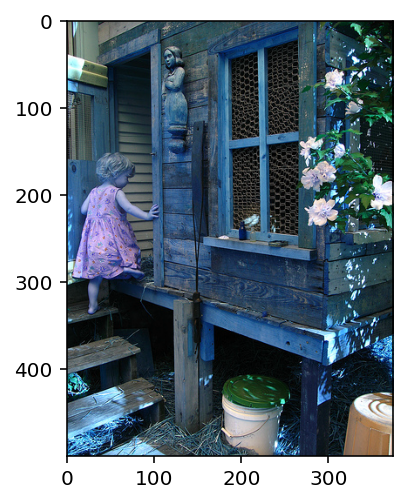

In [ ]:
img = cv2.imread(os.path.join(images_path,f"{list(descriptions.keys())[0]}.jpg"))
plt.imshow(img)

In [ ]:
caption_list[0:5]


['startseq a child in a pink dress is climbing up a set of stairs in an entry way  endseq',
 'startseq a girl going into a wooden building  endseq',
 'startseq a little girl climbing into a wooden playhouse  endseq',
 'startseq a little girl climbing the stairs to her playhouse  endseq',
 'startseq a little girl in a pink dress going into a wooden cabin  endseq']

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model, Sequential
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from tensorflow.keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model

In [ ]:
len(descriptions.keys())

8091

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(caption_list)

In [ ]:
# now we need to find the max len of any captions
max(len(x.split()) for x in caption_list)

38

In [ ]:
caption_len = [len(x.split()) for x in caption_list]

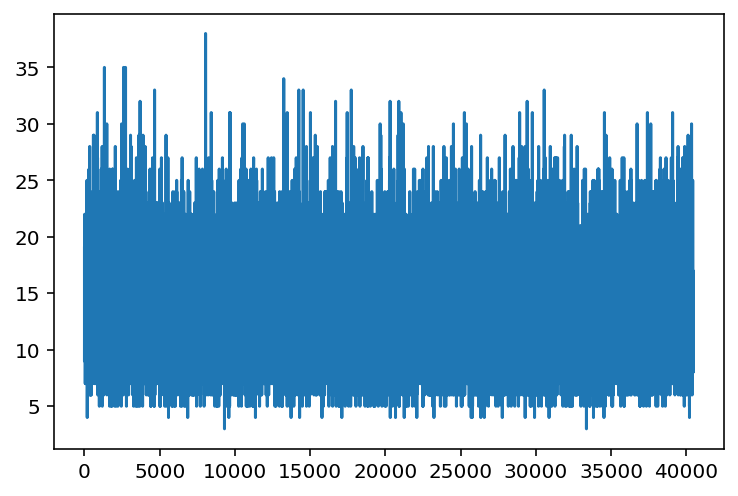

In [ ]:
plt.plot(caption_len)

In [ ]:
def create_sequences(descriptions, desc_list, tokenizer, key):
    max_length = 38
    vocab_size = len(tokenizer.word_index) + 1
    # x1 will store the image feature, x2 will store one sequence and y will store the next sequence
    X1, X2, y = [], [], []

    # iterate through all the images 
    for desc in desc_list:
            # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
        for i in range(1, len(seq)):
				# split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length, padding = 'post')[0]
				# encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
            X1.append(features[key])
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)
            

In [ ]:
def data_generator(descriptions):
	# loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            
			# retrieve the photo feature
            X1, X2, y = create_sequences(descriptions, desc_list, tokenizer, key)
            
            yield [X1,X2],y

In [ ]:
generator = data_generator(descriptions)
[X1,X2],y = next(generator)

In [ ]:
X2.shape

(58, 38)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

In [ ]:
import tensorflow 
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

In [ ]:
embedding_size = 128
max_len = 38
vocab_size = vocab_size

image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

# model.load_weights("../input/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 38, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 38, 128)           1130368   
                                                                 
 lstm (LSTM)                 (None, 38, 256)           394240    
                            

In [ ]:
steps = len(descriptions)
	# create the data generator
generator = data_generator(descriptions)
	# fit for one epoch
for i in range(8):    
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose = 1)
    model.save(f'model_{i}.h5')

8091/8091 [==============================] - 184s 23ms/step - loss: 4.0308 - accuracy: 0.3198


In [ ]:
import keras

model = keras.models.load_model('./model_7.h5')

In [ ]:
# generate a description for an image
def generate_caption(pic_id):
    max_length = 38
    
    photo = features[pic_id]
    photo = photo.reshape(1,2048)
    # seed the generation process
    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for i in range(max_length):
        # integer encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad input
        sequence = pad_sequences([sequence], maxlen=max_length, padding = 'post')
#         print(photo.shape)
#         predict next word
        yhat = model.predict([photo,sequence], verbose=0)
#         # convert probability to integer
        yhat = np.argmax(yhat)
#         # map integer to word
        word = tokenizer.index_word[yhat]
#         # stop if we cannot map the word
        if word is None:
            break
        # append as input for generating the next word
        in_text += ' ' + word
        # stop if we predict the end of the sequence
        if word == 'endseq':
            break
#     print(in_text)
    caption = in_text[9:][:-7]
    pic = f'{pic_id}.jpg'
    plt.figure()
    x=plt.imread(images_path+pic)
    plt.imshow(x)
    plt.xlabel(caption)

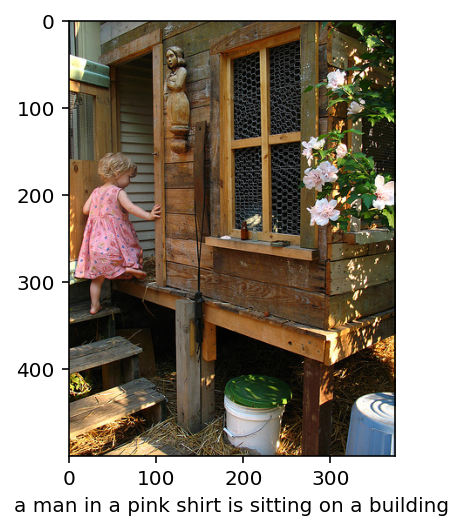

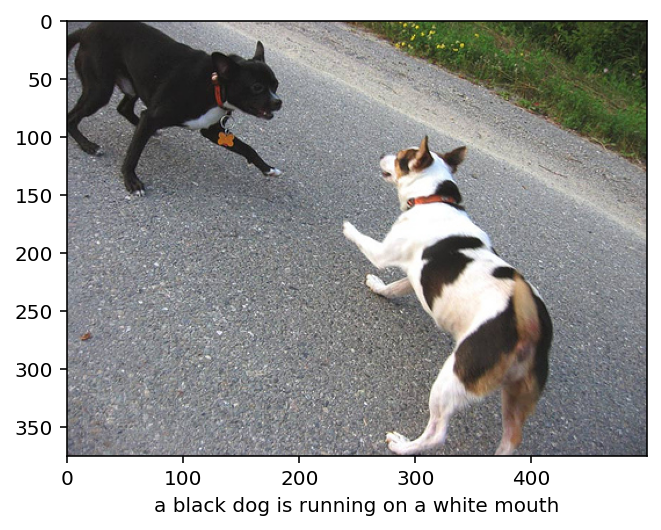

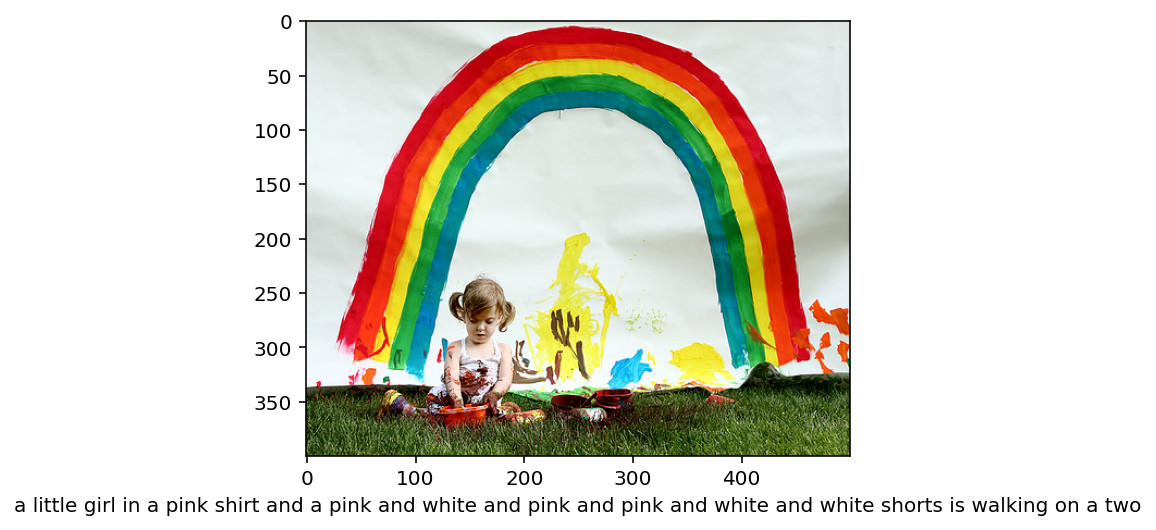

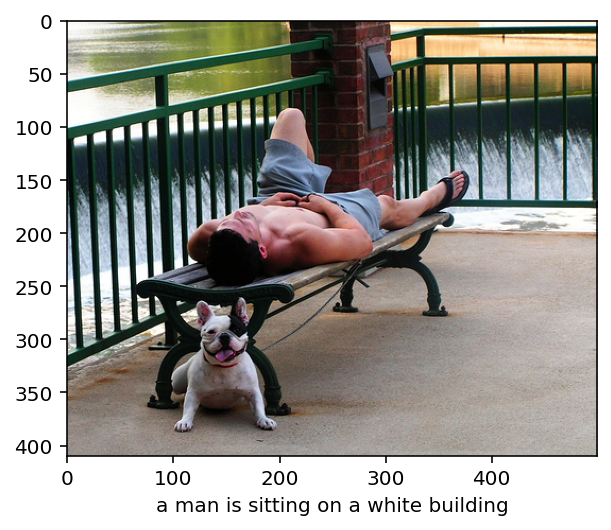

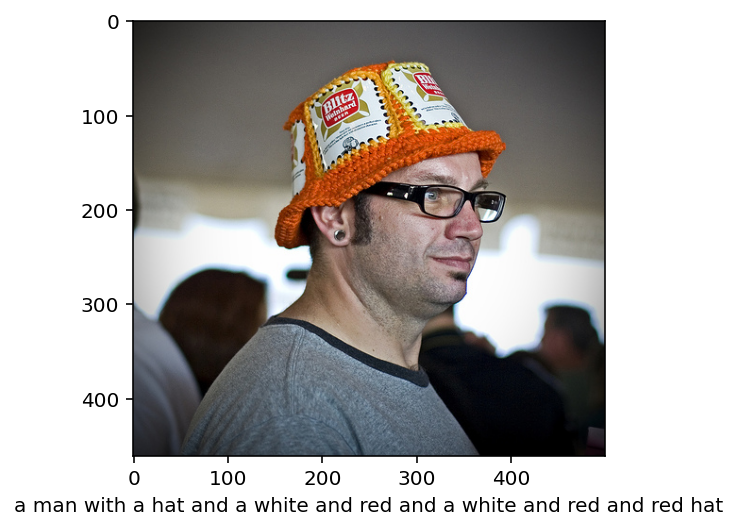

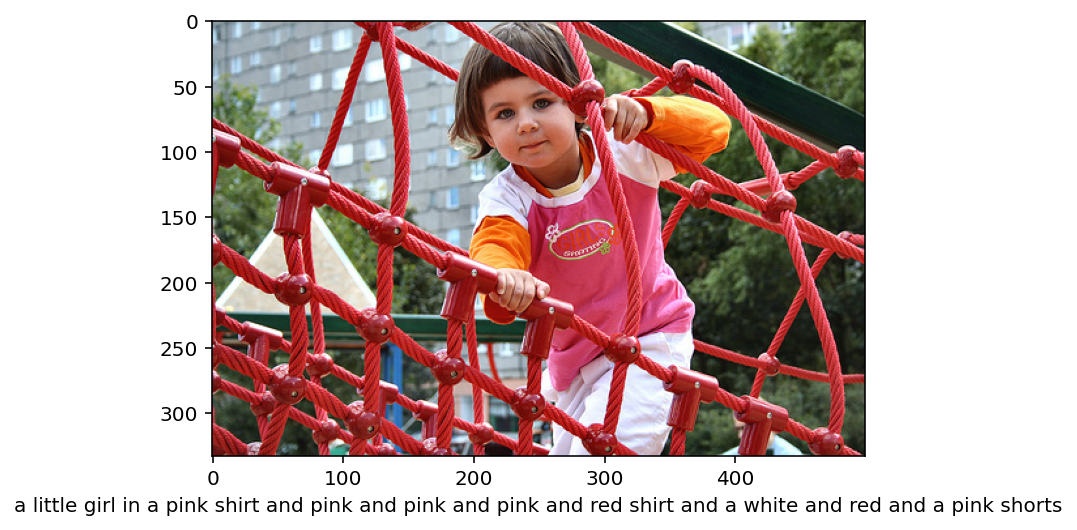

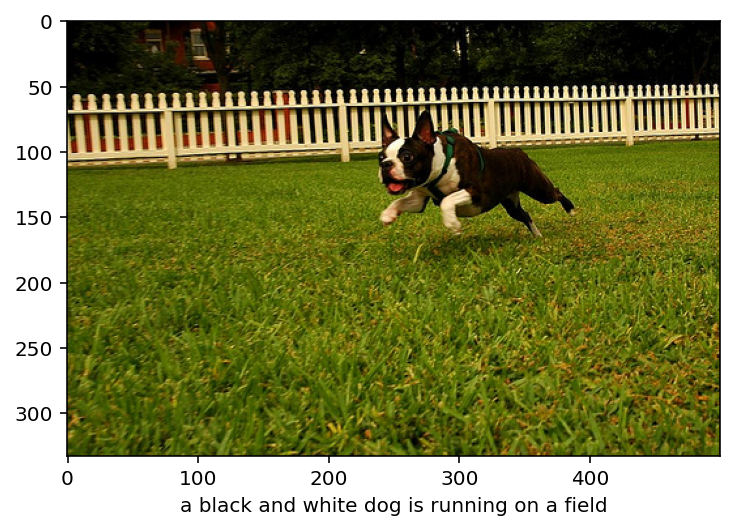

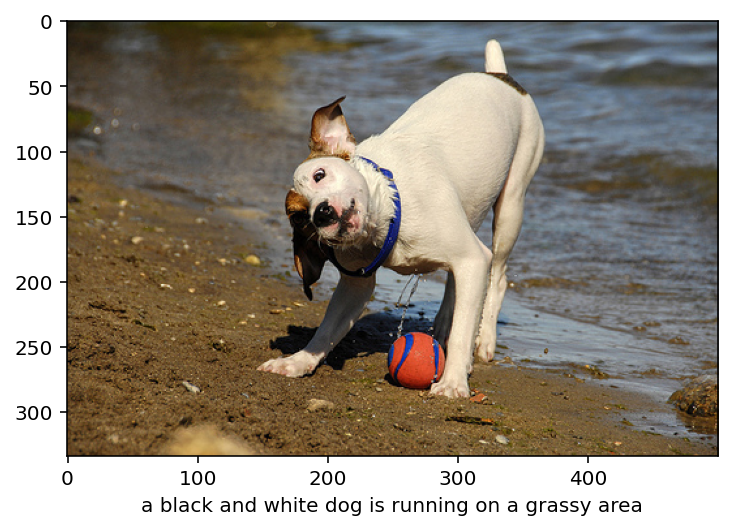

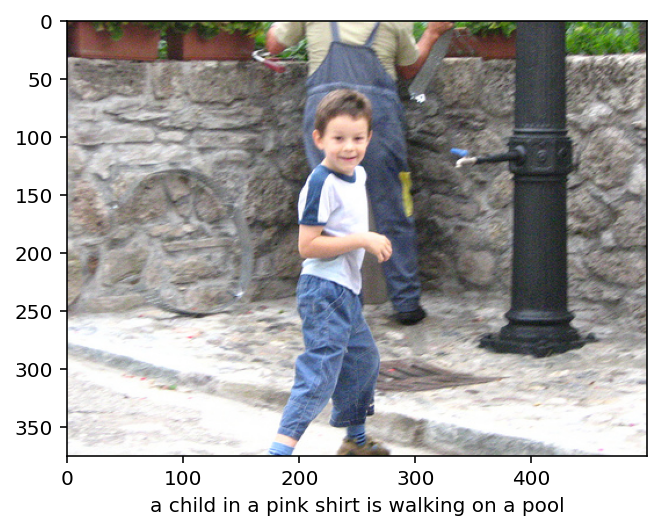

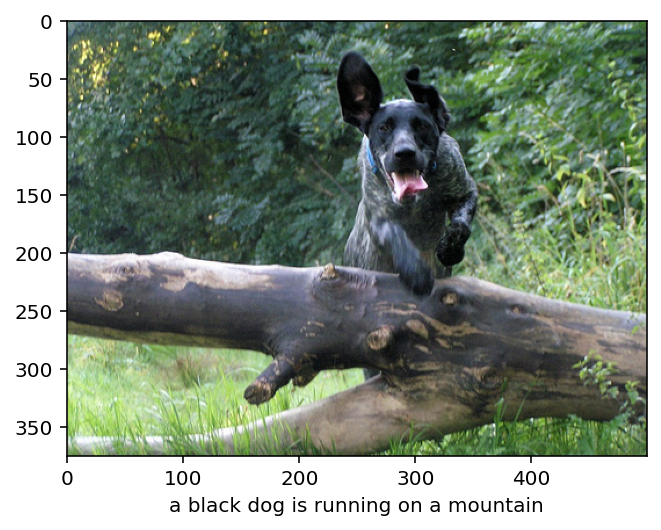

In [ ]:
for id in list(descriptions.keys())[:10]:
    generate_caption(id)